# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [5]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline

In [6]:
def read_image(image_path):
    """Reads and returns image."""
    return mpimg.imread(image_path)

def read_image_and_print_dims(image_path):
    """Reads and returns image.
    Helper function to examine how an image is represented.
    """
    #reading in an image
    image = mpimg.imread(image_path)
    #printing out some stats and plotting
    print('This image is:', type(image), 'with dimensions:', image.shape)
    plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image
    return image

In [7]:
# Read and save test images to array
test_images = [read_image('test_images/' + i) for i in os.listdir('test_images/')]

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [8]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), 
                            minLineLength=min_line_len, maxLineGap=max_line_gap)
    # print("Hough lines: ", lines)
    line_img = np.zeros(img.shape, dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [9]:
def intersection_x(coef1, intercept1, coef2, intercept2):
    """Returns x-coordinate of intersection of two lines."""
    x = (intercept2-intercept1)/(coef1-coef2)
    return x

def draw_linear_regression_line(coef, intercept, intersection_x, img, imshape=[540,960], color=[255, 0, 0], thickness=2):
    
    # Get starting and ending points of regression line, ints.
    print("Coef: ", coef, "Intercept: ", intercept, 
          "intersection_x: ", intersection_x)
    point_one = (int(intersection_x), int(intersection_x * coef + intercept))
    if coef > 0:
        point_two = (imshape[1], int(imshape[1] * coef + intercept))
    elif coef < 0:
        point_two = (0, int(0 * coef + intercept))
    print("Point one: ", point_one, "Point two: ", point_two)
    
    # Draw line using cv2.line
    cv2.line(img, point_one, point_two, color, thickness)

In [10]:
def find_line_fit(slope_intercept):
    """slope_intercept is an array [[slope, intercept], [slope, intercept]...]."""

    # Initialise arrays
    kept_slopes = []
    kept_intercepts = []
    print("Slope & intercept: ", slope_intercept)
    if len(slope_intercept) == 1:
        return slope_intercept[0][0], slope_intercept[0][1]

    # Remove points with slope not within 1.5 standard deviations of the mean
    slopes = [pair[0] for pair in slope_intercept]
    mean_slope = np.mean(slopes)
    slope_std = np.std(slopes)
    for pair in slope_intercept:
        slope = pair[0]
        if slope - mean_slope < 1.5 * slope_std:
            kept_slopes.append(slope)
            kept_intercepts.append(pair[1])
    if not kept_slopes:
        kept_slopes = slopes
        kept_intercepts = [pair[1] for pair in slope_intercept]
    # Take estimate of slope, intercept to be the mean of remaining values
    slope = np.mean(kept_slopes)
    intercept = np.mean(kept_intercepts)
    print("Slope: ", slope, "Intercept: ", intercept)
    return slope, intercept

In [11]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    # Image parameters (hard-coded. TODO: Make not hard-coded.)
    imshape = [540, 960]
    
    # Initialise arrays
    positive_slope_points = []
    negative_slope_points = []
    positive_slope_intercept = []
    negative_slope_intercept = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:            
            slope = (y1-y2)/(x1-x2)
            # print("Points: ", [x1, y1, x2, y2])
            length = math.sqrt((x1-x2)**2 + (y1-y2)**2)
            # print("Length: ", length)
            if not math.isnan(slope):
                if length > 50:
                    if slope > 0:
                        positive_slope_points.append([x1, y1])
                        positive_slope_points.append([x2, y2])
                        positive_slope_intercept.append([slope, y1-slope*x1])
                    elif slope < 0:
                        negative_slope_points.append([x1, y1])
                        negative_slope_points.append([x2, y2])
                        negative_slope_intercept.append([slope, y1-slope*x1])
        
    # If either array is empty, waive length requirement
    if not positive_slope_points:
        for line in lines:
            for x1,y1,x2,y2 in line:            
                slope = (y1-y2)/(x1-x2)
                if slope > 0:
                    positive_slope_points.append([x1, y1])
                    positive_slope_points.append([x2, y2])
                    positive_slope_intercept.append([slope, y1-slope*x1])
    if not negative_slope_points:
        for line in lines:
            for x1,y1,x2,y2 in line:            
                slope = (y1-y2)/(x1-x2)
                if slope < 0:
                    negative_slope_points.append([x1, y1])
                    negative_slope_points.append([x2, y2])
                    negative_slope_intercept.append([slope, y1-slope*x1])
    if not positive_slope_points:
        print("positive_slope_points still empty")
    if not negative_slope_points:
        print("negative_slope_points still empty")
    # Even though positive_slope_points is not used, I am keeping it for debugging purposes.
    positive_slope_points = np.array(positive_slope_points)
    negative_slope_points = np.array(negative_slope_points)
    # print("Positive slope line points: ", positive_slope_points)
    # print("Negative slope line points: ", negative_slope_points)
    # print("positive slope points dtype: ", positive_slope_points.dtype)

    # Get intercept and coefficient of fitted lines
    pos_coef, pos_intercept = find_line_fit(positive_slope_intercept)
    neg_coef, neg_intercept = find_line_fit(negative_slope_intercept)
    
    # Discarded Linear Regression Option:
    # Get intercept and coefficient of linear regression lines
    # pos_coef, pos_intercept = find_linear_regression_line(positive_slope_points)
    # neg_coef, neg_intercept = find_linear_regression_line(negative_slope_points)
    
    # Get intersection point
    intersection_x_coord = intersection_x(pos_coef, pos_intercept, neg_coef, neg_intercept)
    
    # Plot lines
    draw_linear_regression_line(pos_coef, pos_intercept, intersection_x_coord, img)
    draw_linear_regression_line(neg_coef, neg_intercept, intersection_x_coord, img)

In [12]:
# Not used
from sklearn.linear_model import LinearRegression

def find_linear_regression_line(points):
    # Separate points into X and y to fit LinearRegression model
    points_x = [[point[0]] for point in points]
    points_y = [point[1] for point in points]
    # points_x_print = [point[0] for point in points]
    # print("X points: ", points_x, "Length: ", len(points_x))
    # print("X points: ", points_x_print, "Length: ", len(points_x))
    # print("Y points: ", points_y, "Length: ", len(points_y))

    # Fit points to LinearRegression line
    clf = LinearRegression().fit(points_x, points_y)

    # Get parameters from line
    coef = clf.coef_[0]
    intercept = clf.intercept_
    print("Coefficients: ", coef, "Intercept: ", intercept)
    return coef, intercept

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [13]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

### Pipeline

Steps:
1. Read in and grayscale the image
2. Define a kernel size and apply Gaussian smoothing
3. Define our parameters for Canny and apply to get edges image
4. Mask edges image using cv2.fillPoly() (ignore everything outside region of interest)
5. Define Hough transform parameters and run Hough transform on masked edge-detected image
6. Draw line segments
7. Draw lines extrapolated from line segments
8. Combine line image with original image to see how accurate the line annotations are.

Slope & intercept:  [[0.55350553505535061, 41.505535055350492], [0.57482993197278909, 33.874149659863974], [0.57740585774058573, 31.3305439330544], [0.55284552845528456, 41.097560975609724]]
Slope:  0.564646713306 Intercept:  36.951947406
Slope & intercept:  [[-0.81065088757396453, 698.71005917159766], [-0.75555555555555554, 671.55555555555554], [-0.70542635658914732, 653.67441860465124], [-0.78333333333333333, 688.60000000000002]]
Slope:  -0.763741533263 Intercept:  678.135008333
Coef:  0.564646713306 Intercept:  36.951947406 intersection_x:  482.677457124
Point one:  (482, 309) Point two:  (960, 579)
Coef:  -0.763741533263 Intercept:  678.135008333 intersection_x:  482.677457124
Point one:  (482, 309) Point two:  (0, 678)


array([[[ 87, 126, 159],
        [ 87, 126, 159],
        [ 87, 126, 159],
        ..., 
        [ 89, 125, 158],
        [ 86, 122, 155],
        [ 82, 118, 151]],

       [[ 87, 126, 159],
        [ 87, 126, 159],
        [ 87, 126, 159],
        ..., 
        [ 89, 125, 158],
        [ 86, 122, 155],
        [ 83, 119, 152]],

       [[ 87, 126, 159],
        [ 87, 126, 159],
        [ 87, 126, 159],
        ..., 
        [ 89, 125, 158],
        [ 86, 122, 155],
        [ 83, 119, 152]],

       ..., 
       [[ 68,  70,  76],
        [ 68,  70,  76],
        [ 68,  70,  76],
        ..., 
        [ 65,  65,  73],
        [ 64,  64,  72],
        [ 63,  63,  71]],

       [[ 69,  69,  75],
        [ 69,  69,  75],
        [ 70,  70,  76],
        ..., 
        [ 62,  64,  71],
        [ 62,  64,  71],
        [ 61,  63,  70]],

       [[ 67,  67,  74],
        [ 67,  67,  74],
        [ 67,  67,  74],
        ..., 
        [ 61,  62,  72],
        [ 60,  62,  71],
        [ 59,  61,

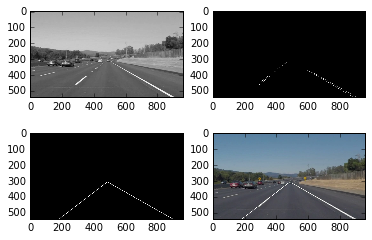

In [14]:
# Pipeline

def draw_lane_lines(image):
    """Draw lane lines in white on original image."""
    # Print image details
    # print("image.shape: ", image.shape)
    imshape = image.shape
    
    # Greyscale image
    greyscaled_image = grayscale(image)
    plt.subplot(2,2,1)
    plt.imshow(greyscaled_image, cmap="gray")
    
    # Gaussian Blur
    blurred_grey_image = gaussian_blur(greyscaled_image, 5)
    
    # Canny edge detection
    edges_image = canny(blurred_grey_image, 50, 150)
    
    # Mask edges image
    border = 0
    vertices = np.array([[(0,imshape[0]),(465, 320), (475, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    edges_image_with_mask = region_of_interest(edges_image, vertices)
    ## Plot masked edges image
    bw_edges_image_with_mask = cv2.cvtColor(edges_image_with_mask, cv2.COLOR_GRAY2BGR)
    plt.subplot(2,2,2)
    plt.imshow(bw_edges_image_with_mask)
    
    # Hough lines
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 45     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 40 #minimum number of pixels making up a line
    max_line_gap = 100    # maximum gap in pixels between connectable line segments
    lines_image = hough_lines(edges_image_with_mask, rho, theta, threshold, min_line_len, max_line_gap)
    
    # Convert Hough from single channel to RGB to prep for weighted
    # TODO: Have it convert the lines to red, not white.
    hough_rgb_image = cv2.cvtColor(lines_image, cv2.COLOR_GRAY2BGR)
    # hough_rgb_image.dtype: uint8.  Shape: (540,960,3).
    # hough_rgb_image is like [[[0 0 0], [0 0 0],...] [[0 0 0], [0 0 0],...]]
    ## Plot Hough lines image
    plt.subplot(2,2,3)
    plt.imshow(hough_rgb_image)    
    
    # Combine lines image with original image
    final_image = weighted_img(hough_rgb_image, image)
    ## Plot final image
    plt.subplot(2,2,4)
    plt.imshow(final_image)
    return final_image

draw_lane_lines(test_images[0])

## Testing the Pipeline on the test_images

Slope & intercept:  [[0.55350553505535061, 41.505535055350492], [0.57482993197278909, 33.874149659863974], [0.57740585774058573, 31.3305439330544], [0.55284552845528456, 41.097560975609724]]
Slope:  0.564646713306 Intercept:  36.951947406
Slope & intercept:  [[-0.81065088757396453, 698.71005917159766], [-0.75555555555555554, 671.55555555555554], [-0.70542635658914732, 653.67441860465124], [-0.78333333333333333, 688.60000000000002]]
Slope:  -0.763741533263 Intercept:  678.135008333
Coef:  0.564646713306 Intercept:  36.951947406 intersection_x:  482.677457124
Point one:  (482, 309) Point two:  (960, 579)
Coef:  -0.763741533263 Intercept:  678.135008333 intersection_x:  482.677457124
Point one:  (482, 309) Point two:  (0, 678)


array([[[ 87, 126, 159],
        [ 87, 126, 159],
        [ 87, 126, 159],
        ..., 
        [ 89, 125, 158],
        [ 86, 122, 155],
        [ 82, 118, 151]],

       [[ 87, 126, 159],
        [ 87, 126, 159],
        [ 87, 126, 159],
        ..., 
        [ 89, 125, 158],
        [ 86, 122, 155],
        [ 83, 119, 152]],

       [[ 87, 126, 159],
        [ 87, 126, 159],
        [ 87, 126, 159],
        ..., 
        [ 89, 125, 158],
        [ 86, 122, 155],
        [ 83, 119, 152]],

       ..., 
       [[ 68,  70,  76],
        [ 68,  70,  76],
        [ 68,  70,  76],
        ..., 
        [ 65,  65,  73],
        [ 64,  64,  72],
        [ 63,  63,  71]],

       [[ 69,  69,  75],
        [ 69,  69,  75],
        [ 70,  70,  76],
        ..., 
        [ 62,  64,  71],
        [ 62,  64,  71],
        [ 61,  63,  70]],

       [[ 67,  67,  74],
        [ 67,  67,  74],
        [ 67,  67,  74],
        ..., 
        [ 61,  62,  72],
        [ 60,  62,  71],
        [ 59,  61,

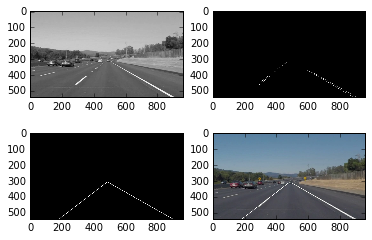

In [15]:
draw_lane_lines(test_images[0])

Slope & intercept:  [[0.62142857142857144, 7.9214285714285779], [0.6512455516014235, -4.1850533807829038], [0.65071770334928225, -4.5454545454545041]]
Slope:  0.641130608793 Intercept:  -0.26969311827
Slope & intercept:  [[-0.67132867132867136, 630.11188811188811], [-0.72222222222222221, 655.83333333333337], [-0.67333333333333334, 631.73333333333335], [-0.69736842105263153, 646.76315789473688]]
Slope:  -0.691063161984 Intercept:  641.110428168
Coef:  0.641130608793 Intercept:  -0.26969311827 intersection_x:  481.446569828
Point one:  (481, 308) Point two:  (960, 615)
Coef:  -0.691063161984 Intercept:  641.110428168 intersection_x:  481.446569828
Point one:  (481, 308) Point two:  (0, 641)


array([[[144, 157, 167],
        [114, 129, 141],
        [107, 125, 143],
        ..., 
        [109, 123, 142],
        [117, 127, 141],
        [149, 156, 168]],

       [[114, 129, 141],
        [114, 133, 147],
        [107, 128, 146],
        ..., 
        [110, 127, 146],
        [114, 127, 143],
        [118, 129, 142]],

       [[105, 126, 143],
        [106, 129, 146],
        [102, 127, 150],
        ..., 
        [103, 125, 148],
        [109, 126, 146],
        [107, 122, 141]],

       ..., 
       [[ 96,  97, 100],
        [ 73,  74,  78],
        [ 66,  67,  71],
        ..., 
        [ 70,  71,  74],
        [ 75,  76,  79],
        [ 96,  97, 100]],

       [[110, 111, 114],
        [ 84,  85,  88],
        [ 71,  72,  76],
        ..., 
        [ 78,  78,  82],
        [ 87,  88,  91],
        [111, 112, 115]],

       [[144, 145, 148],
        [112, 113, 116],
        [ 94,  94,  98],
        ..., 
        [ 98,  98, 100],
        [112, 113, 114],
        [143, 144,

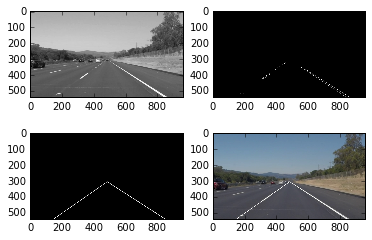

In [16]:
draw_lane_lines(test_images[1])

Slope & intercept:  [[0.62295081967213117, 15.327868852459005], [0.55384615384615388, 51.569230769230728], [0.59999999999999998, 25.0], [0.59813084112149528, 25.028037383177605]]
Slope:  0.59373195366 Intercept:  29.2312842512
Slope & intercept:  [[-0.75547445255474455, 671.20802919708035], [-0.67839195979899503, 639.7437185929648], [-0.68852459016393441, 643.42622950819668], [-0.75, 668.5], [-0.80620155038759689, 689.17829457364337], [-0.77500000000000002, 680.77500000000009], [-0.80952380952380953, 691.19047619047615], [-0.70034843205574915, 646.55400696864115], [-0.70198675496688745, 646.10596026490066]]
Slope:  -0.740605727717 Intercept:  664.075746144
Coef:  0.59373195366 Intercept:  29.2312842512 intersection_x:  475.774963679
Point one:  (475, 311) Point two:  (960, 599)
Coef:  -0.740605727717 Intercept:  664.075746144 intersection_x:  475.774963679
Point one:  (475, 311) Point two:  (0, 664)


array([[[ 82, 125, 162],
        [ 82, 125, 162],
        [ 82, 125, 162],
        ..., 
        [ 77, 122, 157],
        [ 75, 121, 155],
        [ 70, 116, 150]],

       [[ 82, 125, 160],
        [ 82, 125, 160],
        [ 82, 125, 160],
        ..., 
        [ 77, 122, 157],
        [ 75, 121, 155],
        [ 70, 116, 150]],

       [[ 82, 126, 158],
        [ 82, 126, 158],
        [ 82, 126, 158],
        ..., 
        [ 78, 122, 157],
        [ 77, 120, 155],
        [ 72, 115, 150]],

       ..., 
       [[ 76,  80,  85],
        [ 76,  80,  85],
        [ 76,  80,  85],
        ..., 
        [ 58,  63,  74],
        [ 58,  63,  74],
        [ 58,  63,  74]],

       [[ 76,  80,  85],
        [ 76,  80,  85],
        [ 76,  80,  85],
        ..., 
        [ 57,  62,  73],
        [ 57,  62,  73],
        [ 57,  62,  73]],

       [[ 75,  79,  84],
        [ 75,  79,  84],
        [ 75,  79,  84],
        ..., 
        [ 58,  62,  71],
        [ 58,  62,  71],
        [ 58,  62,

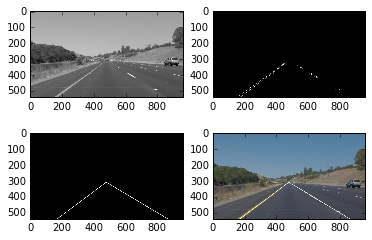

In [17]:
draw_lane_lines(test_images[2])

Slope & intercept:  [[0.60264900662251653, 25.145695364238406], [0.57704918032786889, 34.659016393442585], [0.57770270270270274, 32.510135135135101], [0.55882352941176472, 47.91176470588232]]
Slope:  0.571191804147 Intercept:  38.3603054115
Slope & intercept:  [[-0.72635135135135132, 655.21621621621625], [-0.75423728813559321, 671.94915254237287], [-0.74444444444444446, 658.02222222222224], [-0.7570093457943925, 673.50467289719631], [-0.74576271186440679, 657.32203389830511], [-0.67948717948717952, 640.25641025641028]]
Slope:  -0.745561028318 Intercept:  663.202859555
Coef:  0.571191804147 Intercept:  38.3603054115 intersection_x:  474.53291061
Point one:  (474, 309) Point two:  (960, 586)
Coef:  -0.745561028318 Intercept:  663.202859555 intersection_x:  474.53291061
Point one:  (474, 309) Point two:  (0, 663)


array([[[ 83, 126, 162],
        [ 83, 126, 162],
        [ 83, 126, 162],
        ..., 
        [ 78, 125, 160],
        [ 76, 123, 158],
        [ 74, 122, 157]],

       [[ 83, 126, 162],
        [ 83, 126, 162],
        [ 83, 126, 162],
        ..., 
        [ 77, 124, 159],
        [ 75, 122, 158],
        [ 72, 121, 156]],

       [[ 82, 126, 161],
        [ 83, 126, 162],
        [ 82, 127, 162],
        ..., 
        [ 75, 124, 159],
        [ 74, 122, 158],
        [ 72, 121, 156]],

       ..., 
       [[ 82,  82,  88],
        [ 82,  82,  88],
        [ 82,  82,  88],
        ..., 
        [ 62,  66,  74],
        [ 62,  66,  74],
        [ 62,  66,  74]],

       [[ 82,  81,  87],
        [ 82,  81,  87],
        [ 82,  81,  87],
        ..., 
        [ 62,  66,  73],
        [ 62,  65,  72],
        [ 62,  65,  72]],

       [[ 79,  78,  85],
        [ 79,  78,  85],
        [ 79,  78,  85],
        ..., 
        [ 62,  65,  72],
        [ 62,  65,  72],
        [ 62,  65,

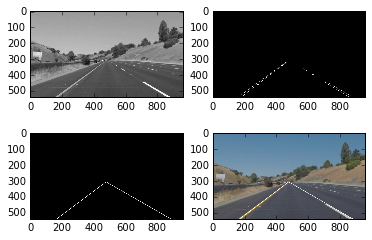

In [18]:
draw_lane_lines(test_images[3])

Slope & intercept:  [[0.64734299516908211, -3.2173913043478137], [0.60180995475113119, 20.782805429864254], [0.67484662576687116, -24.607361963190158]]
Slope:  0.641333191896 Intercept:  -2.34731594589
Slope & intercept:  [[-0.72602739726027399, 653.71232876712327], [-0.70050761421319796, 638.72081218274116], [-0.70046082949308752, 638.29953917050693], [-0.65853658536585369, 628.48780487804879], [-0.72689075630252098, 654.65126050420167]]
Slope:  -0.713471649317 Intercept:  646.345985156
Coef:  0.641333191896 Intercept:  -2.34731594589 intersection_x:  478.809405878
Point one:  (478, 304) Point two:  (960, 613)
Coef:  -0.713471649317 Intercept:  646.345985156 intersection_x:  478.809405878
Point one:  (478, 304) Point two:  (0, 646)


array([[[147, 157, 168],
        [115, 127, 142],
        [106, 123, 142],
        ..., 
        [102, 122, 141],
        [112, 129, 142],
        [146, 159, 171]],

       [[114, 126, 142],
        [115, 130, 147],
        [106, 125, 146],
        ..., 
        [ 99, 123, 144],
        [110, 127, 144],
        [113, 128, 142]],

       [[105, 122, 141],
        [106, 125, 146],
        [100, 123, 147],
        ..., 
        [ 94, 120, 145],
        [ 98, 120, 142],
        [100, 121, 139]],

       ..., 
       [[103, 102, 107],
        [ 92,  91,  96],
        [ 88,  87,  92],
        ..., 
        [ 66,  66,  74],
        [ 70,  70,  78],
        [ 95,  95, 103]],

       [[113, 112, 116],
        [100,  99, 103],
        [ 92,  91,  95],
        ..., 
        [ 70,  70,  78],
        [ 85,  85,  91],
        [109, 109, 115]],

       [[141, 140, 144],
        [111, 110, 114],
        [102, 102, 106],
        ..., 
        [ 95,  95, 102],
        [110, 110, 116],
        [146, 146,

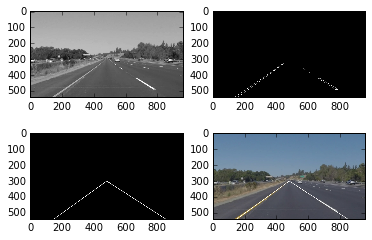

In [19]:
draw_lane_lines(test_images[4])

Slope & intercept:  [[0.55298013245033117, 49.165562913907252], [0.58139534883720934, 36.255813953488371], [0.61979166666666663, 5.84375], [0.55369127516778527, 46.751677852348962]]
Slope:  0.562688918818 Intercept:  44.0576849066
Slope & intercept:  [[-0.78378378378378377, 691.83783783783781], [-0.72881355932203384, 664.72881355932202], [-0.76106194690265483, 682.08849557522126], [-0.75939849624060152, 682.4511278195489], [-0.75257731958762886, 671.45360824742261], [-0.75, 671.75], [-0.80246913580246915, 695.54320987654319]]
Slope:  -0.76821511372 Intercept:  682.520713226
Coef:  0.562688918818 Intercept:  44.0576849066 intersection_x:  479.721311763
Point one:  (479, 313) Point two:  (960, 584)
Coef:  -0.76821511372 Intercept:  682.520713226 intersection_x:  479.721311763
Point one:  (479, 313) Point two:  (0, 682)


array([[[ 88, 127, 162],
        [ 88, 127, 162],
        [ 88, 127, 162],
        ..., 
        [ 81, 124, 161],
        [ 80, 123, 160],
        [ 75, 118, 155]],

       [[ 88, 127, 162],
        [ 88, 127, 162],
        [ 88, 127, 162],
        ..., 
        [ 81, 124, 161],
        [ 80, 123, 160],
        [ 75, 118, 155]],

       [[ 88, 127, 162],
        [ 88, 127, 162],
        [ 88, 127, 162],
        ..., 
        [ 81, 124, 161],
        [ 80, 123, 160],
        [ 75, 118, 155]],

       ..., 
       [[ 76,  80,  85],
        [ 75,  79,  84],
        [ 75,  79,  84],
        ..., 
        [ 67,  70,  82],
        [ 66,  68,  80],
        [ 63,  66,  78]],

       [[ 75,  79,  84],
        [ 75,  79,  84],
        [ 74,  78,  83],
        ..., 
        [ 67,  70,  80],
        [ 66,  69,  78],
        [ 62,  66,  75]],

       [[ 72,  78,  82],
        [ 71,  77,  82],
        [ 71,  77,  82],
        ..., 
        [ 66,  70,  79],
        [ 65,  68,  78],
        [ 62,  66,

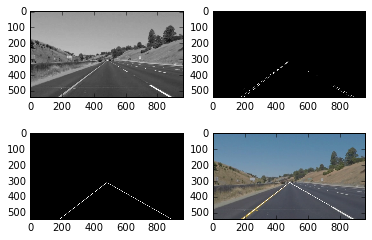

In [20]:
draw_lane_lines(test_images[5])

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [21]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [22]:
def process_image(image):
    """Puts image through pipeline and returns 3-channel image for processing video below."""
    result = draw_lane_lines(image)
    print(result.shape)
    return result

Let's try the one with the solid white lane on the right first ...

Slope & intercept:  [[0.59925093632958804, 16.65168539325839], [0.64615384615384619, -7.2923076923077019], [0.6470588235294118, -9.058823529411768], [0.59999999999999998, 15.600000000000023]]
Slope:  0.623115901503 Intercept:  3.97513854288
Slope & intercept:  [[-0.70037453183520604, 642.97003745318352], [-0.75217391304347825, 665.93913043478256], [-0.6742424242424242, 635.77272727272725], [-0.70270270270270274, 640.56756756756761], [-0.64646464646464652, 626.60606060606062]]
Slope:  -0.695191643658 Intercept:  642.371104667
Coef:  0.623115901503 Intercept:  3.97513854288 intersection_x:  484.25420037
Point one:  (484, 305) Point two:  (960, 602)
Coef:  -0.695191643658 Intercept:  642.371104667 intersection_x:  484.25420037
Point one:  (484, 305) Point two:  (0, 642)
(540, 960, 3)
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


  0%|          | 0/222 [00:00<?, ?it/s]

Slope & intercept:  [[0.59925093632958804, 16.65168539325839], [0.64615384615384619, -7.2923076923077019], [0.6470588235294118, -9.058823529411768], [0.59999999999999998, 15.600000000000023]]
Slope:  0.623115901503 Intercept:  3.97513854288
Slope & intercept:  [[-0.70037453183520604, 642.97003745318352], [-0.75217391304347825, 665.93913043478256], [-0.6742424242424242, 635.77272727272725], [-0.70270270270270274, 640.56756756756761], [-0.64646464646464652, 626.60606060606062]]
Slope:  -0.695191643658 Intercept:  642.371104667
Coef:  0.623115901503 Intercept:  3.97513854288 intersection_x:  484.25420037
Point one:  (484, 305) Point two:  (960, 602)
Coef:  -0.695191643658 Intercept:  642.371104667 intersection_x:  484.25420037
Point one:  (484, 305) Point two:  (0, 642)


  1%|          | 2/222 [00:00<00:17, 12.63it/s]

(540, 960, 3)
Slope & intercept:  [[0.64651162790697669, -8.3023255813953369], [0.60223048327137552, 15.263940520446056], [0.59999999999999998, 21.199999999999989], [0.58904109589041098, 26.835616438356169], [0.660377358490566, -16.396226415094304], [0.6029411764705882, 13.823529411764753]]
Slope:  0.608144876708 Intercept:  13.7641521578
Slope & intercept:  [[-0.75352112676056338, 667.09859154929575], [-0.72413793103448276, 646.62068965517244], [-0.70289855072463769, 643.304347826087], [-0.70491803278688525, 641.86885245901635], [-0.70163934426229513, 643.94754098360659]]
Slope:  -0.717422997114 Intercept:  648.568004495
Coef:  0.608144876708 Intercept:  13.7641521578 intersection_x:  478.892001589
Point one:  (478, 304) Point two:  (960, 597)
Coef:  -0.717422997114 Intercept:  648.568004495 intersection_x:  478.892001589
Point one:  (478, 304) Point two:  (0, 648)
(540, 960, 3)
Slope & intercept:  [[0.60101010101010099, 15.590909090909122], [0.6470588235294118, -8.4117647058823763], 

  2%|▏         | 4/222 [00:00<00:17, 12.66it/s]

(540, 960, 3)
Slope & intercept:  [[0.62686567164179108, 6.4179104477611872], [0.59778597785977861, 17.926199261992622], [0.59999999999999998, 15.600000000000023], [0.62416107382550334, 6.9798657718121149], [0.62544169611307421, 7.0]]
Slope:  0.614850883888 Intercept:  10.7847950963
Slope & intercept:  [[-0.72916666666666663, 656.5], [-0.72807017543859653, 650.24561403508778], [-0.69318181818181823, 638.5454545454545]]
Slope:  -0.716806220096 Intercept:  648.430356194
Coef:  0.614850883888 Intercept:  10.7847950963 intersection_x:  478.836150229
Point one:  (478, 305) Point two:  (960, 601)
Coef:  -0.716806220096 Intercept:  648.430356194 intersection_x:  478.836150229
Point one:  (478, 305) Point two:  (0, 648)
(540, 960, 3)


  3%|▎         | 6/222 [00:00<00:17, 12.65it/s]

Slope & intercept:  [[0.62745098039215685, 5.9215686274509949], [0.60073260073260071, 16.362637362637372], [0.6097560975609756, 15.951219512195109], [0.60150375939849621, 14.691729323308266], [0.60869565217391308, 17.217391304347814], [0.5957446808510638, 27.957446808510667]]
Slope:  0.603286558143 Intercept:  18.4360848622
Slope & intercept:  [[-0.69999999999999996, 640.10000000000002], [-0.72670807453416153, 655.19875776397521], [-0.75362318840579712, 663.28985507246375]]
Slope:  -0.726777087647 Intercept:  652.862870945
Coef:  0.603286558143 Intercept:  18.4360848622 intersection_x:  476.989795256
Point one:  (476, 306) Point two:  (960, 597)
Coef:  -0.726777087647 Intercept:  652.862870945 intersection_x:  476.989795256
Point one:  (476, 306) Point two:  (0, 652)
(540, 960, 3)
Slope & intercept:  [[0.62595419847328249, 6.2061068702290072], [0.59999999999999998, 14.600000000000023], [0.59925093632958804, 16.65168539325839], [0.60869565217391308, 21.217391304347814]]
Slope:  0.602648

  4%|▎         | 8/222 [00:00<00:16, 12.91it/s]

(540, 960, 3)
Slope & intercept:  [[0.62277580071174377, 8.0177935943060561], [0.60074626865671643, 15.149253731343265], [0.59693877551020413, 18.433673469387713], [0.61224489795918369, 3.5102040816326507]]
Slope:  0.608176435709 Intercept:  11.2777312192
Slope & intercept:  [[-0.69369369369369371, 636.14414414414409], [-0.7232142857142857, 652.89285714285711], [-0.75242718446601942, 663.31553398058259]]
Slope:  -0.723111721291 Intercept:  650.784178423
Coef:  0.608176435709 Intercept:  11.2777312192 intersection_x:  480.366661297
Point one:  (480, 303) Point two:  (960, 595)
Coef:  -0.723111721291 Intercept:  650.784178423 intersection_x:  480.366661297
Point one:  (480, 303) Point two:  (0, 650)
(540, 960, 3)
Slope & intercept:  [[0.62633451957295372, 6.2419928825622719], [0.59999999999999998, 17.0], [0.5985130111524164, 17.687732342007394], [0.59808612440191389, 17.066985645933016], [0.60784313725490191, 22.54901960784315], [0.61538461538461542, 14.53846153846149]]
Slope:  0.6039653

  5%|▍         | 10/222 [00:00<00:16, 13.25it/s]

(540, 960, 3)
Slope & intercept:  [[0.602112676056338, 20.18309859154931], [0.64550264550264547, -0.73544973544971981], [0.64393939393939392, -0.9772727272726911], [0.65909090909090906, -11.568181818181813]]
Slope:  0.637661406147 Intercept:  1.72554857766
Slope & intercept:  [[-0.67721518987341767, 634.90506329113919], [-0.78030303030303028, 675.14393939393938], [-0.67567567567567566, 636.70270270270271], [-0.69945355191256831, 642.45355191256829]]
Slope:  -0.708161861941 Intercept:  647.301314325
Coef:  0.637661406147 Intercept:  1.72554857766 intersection_x:  479.688367006
Point one:  (479, 307) Point two:  (960, 613)
Coef:  -0.708161861941 Intercept:  647.301314325 intersection_x:  479.688367006
Point one:  (479, 307) Point two:  (0, 647)
(540, 960, 3)


  5%|▌         | 12/222 [00:00<00:15, 13.32it/s]

Slope & intercept:  [[0.64935064935064934, -1.6493506493506516], [0.60377358490566035, 20.566037735849079], [0.60191082802547768, 23.764331210191074], [0.66101694915254239, -11.203389830508513], [0.609375, 16.53125], [0.64685314685314688, -0.47552447552448029]]
Slope:  0.628713359715 Intercept:  7.92222566511
Slope & intercept:  [[-0.72368421052631582, 657.96052631578948], [-0.70135746606334837, 643.01357466063348], [-0.69955156950672648, 643.89686098654715], [-0.67741935483870963, 637.80645161290317], [-0.72477064220183485, 656.77064220183479]]
Slope:  -0.712340972075 Intercept:  650.410401041
Coef:  0.628713359715 Intercept:  7.92222566511 intersection_x:  479.091831066
Point one:  (479, 309) Point two:  (960, 611)
Coef:  -0.712340972075 Intercept:  650.410401041 intersection_x:  479.091831066
Point one:  (479, 309) Point two:  (0, 650)
(540, 960, 3)
Slope & intercept:  [[0.64960629921259838, -2.1220472440944604], [0.62244897959183676, 8.6938775510204209], [0.62264150943396224, 7.226

  6%|▋         | 14/222 [00:01<00:15, 13.20it/s]

(540, 960, 3)
Slope & intercept:  [[0.65284974093264247, -4.8238341968911982], [0.62230215827338131, 6.9316546762589724], [0.65151515151515149, -5.8939393939393767], [0.62439024390243902, 6.2292682926829457], [0.64000000000000001, 1.9599999999999795], [0.58461538461538465, 37.569230769230728]]
Slope:  0.629278779873 Intercept:  6.99539669122
Slope & intercept:  [[-0.6988847583643123, 638.63940520446101], [-0.75090252707581229, 662.14801444043326], [-0.75095785440613028, 661.15708812260539], [-0.69999999999999996, 644.79999999999995]]
Slope:  -0.725186284962 Intercept:  651.686126942
Coef:  0.629278779873 Intercept:  6.99539669122 intersection_x:  475.974424877
Point one:  (475, 306) Point two:  (960, 611)
Coef:  -0.725186284962 Intercept:  651.686126942 intersection_x:  475.974424877
Point one:  (475, 306) Point two:  (0, 651)
(540, 960, 3)
Slope & intercept:  [[0.65289256198347112, -7.1652892561983776], [0.62445414847161573, 4.445414847161544], [0.62361623616236161, 4.560885608856097]

  7%|▋         | 16/222 [00:01<00:15, 13.17it/s]

(540, 960, 3)
Slope & intercept:  [[0.66990291262135926, -21.281553398058293], [0.62645914396887159, 0.87159533073929651], [0.625, 0.5], [0.67241379310344829, -23.810344827586221], [0.68852459016393441, -32.032786885245912]]
Slope:  0.656460087972 Intercept:  -15.150617956
Slope & intercept:  [[-0.72413793103448276, 649.20689655172418], [-0.69999999999999996, 634.79999999999995], [-0.76000000000000001, 658.08000000000004], [-0.67883211678832112, 631.043795620438], [-0.69999999999999996, 641.20000000000005]]
Slope:  -0.712594009565 Intercept:  642.866138434
Coef:  0.656460087972 Intercept:  -15.150617956 intersection_x:  480.636051983
Point one:  (480, 300) Point two:  (960, 615)
Coef:  -0.712594009565 Intercept:  642.866138434 intersection_x:  480.636051983
Point one:  (480, 300) Point two:  (0, 642)
(540, 960, 3)
Slope & intercept:  [[0.62809917355371903, 0.71900826446278643], [0.67136150234741787, -21.586854460093889], [0.62595419847328249, 1.5572519083968928], [0.68181818181818177, 

  8%|▊         | 18/222 [00:01<00:16, 12.62it/s]

(540, 960, 3)
Slope & intercept:  [[0.65384615384615385, -8.4615384615384528], [0.62313432835820892, 4.5970149253731734], [0.67010309278350511, -19.865979381443253]]
Slope:  0.649027858329 Intercept:  -7.9101676392
Slope & intercept:  [[-0.70253164556962022, 645.1708860759494], [-0.65454545454545454, 621.89090909090908]]
Slope:  -0.678538550058 Intercept:  633.530897583
Coef:  0.649027858329 Intercept:  -7.9101676392 intersection_x:  483.17060538
Point one:  (483, 305) Point two:  (960, 615)
Coef:  -0.678538550058 Intercept:  633.530897583 intersection_x:  483.17060538
Point one:  (483, 305) Point two:  (0, 633)
(540, 960, 3)
Slope & intercept:  [[0.62271062271062272, 6.205128205128176], [0.65333333333333332, -6.6133333333333439], [0.62903225806451613, 6.8870967741935374], [0.66891891891891897, -18.540540540540576]]
Slope:  0.643498783257 Intercept:  -3.01541222364
Slope & intercept:  [[-0.7232142857142857, 654.23214285714289], [-0.69841269841269837, 638.65079365079362]]
Slope:  -0.710

  9%|▉         | 20/222 [00:01<00:16, 12.44it/s]

(540, 960, 3)
Slope & intercept:  [[0.62230215827338131, 7.1762589928057423], [0.6512455516014235, -4.1850533807829038], [0.65071770334928225, -4.5454545454545041], [0.625, 5.875]]
Slope:  0.637316353306 Intercept:  1.08018776664
Slope & intercept:  [[-0.67333333333333334, 631.73333333333335], [-0.72340425531914898, 656.38297872340422], [-0.77659574468085102, 673.28723404255311], [-0.69999999999999996, 644.79999999999995]]
Slope:  -0.718333333333 Intercept:  651.550886525
Coef:  0.637316353306 Intercept:  1.08018776664 intersection_x:  479.8221142
Point one:  (479, 306) Point two:  (960, 612)
Coef:  -0.718333333333 Intercept:  651.550886525 intersection_x:  479.8221142
Point one:  (479, 306) Point two:  (0, 651)


 10%|▉         | 22/222 [00:01<00:15, 12.51it/s]

(540, 960, 3)
Slope & intercept:  [[0.62454873646209386, 5.6353790613718502], [0.64912280701754388, -2.7192982456140271], [0.6495726495726496, -3.9145299145299077], [0.62318840579710144, 6.9130434782608745], [0.64000000000000001, 4.4399999999999977]]
Slope:  0.63728651977 Intercept:  2.0709188759
Slope & intercept:  [[-0.67567567567567566, 631.75675675675677], [-0.72560975609756095, 656.68292682926835], [-0.67441860465116277, 632.58139534883719]]
Slope:  -0.691901345475 Intercept:  640.340359645
Coef:  0.63728651977 Intercept:  2.0709188759 intersection_x:  480.195055536
Point one:  (480, 308) Point two:  (960, 613)
Coef:  -0.691901345475 Intercept:  640.340359645 intersection_x:  480.195055536
Point one:  (480, 308) Point two:  (0, 640)
(540, 960, 3)
Slope & intercept:  [[0.62454873646209386, 5.6353790613718502], [0.64981949458483756, -3.4007220216606697], [0.66901408450704225, -16.704225352112701], [0.63793103448275867, 6.1206896551723844]]
Slope:  0.645328337509 Intercept:  -2.08721

 11%|█         | 24/222 [00:01<00:15, 12.58it/s]

(540, 960, 3)
Slope & intercept:  [[0.62361623616236161, 4.808118081180794], [0.67045454545454541, -18.943181818181813], [0.660377358490566, -11.471698113207538], [0.63636363636363635, 7.2727272727273089], [0.62406015037593987, 4.0526315789473415], [0.65486725663716816, -8.893805309734546]]
Slope:  0.644956530581 Intercept:  -3.86253471804
Slope & intercept:  [[-0.67537313432835822, 632.61940298507466], [-0.70588235294117652, 651.17647058823536], [-0.75221238938053092, 662.2035398230089], [-0.67206477732793524, 632.67611336032394], [-0.65405405405405403, 626.35675675675679], [-0.77685950413223137, 669.75206611570252]]
Slope:  -0.706074368694 Intercept:  645.797391605
Coef:  0.644956530581 Intercept:  -3.86253471804 intersection_x:  480.862374555
Point one:  (480, 306) Point two:  (960, 615)
Coef:  -0.706074368694 Intercept:  645.797391605 intersection_x:  480.862374555
Point one:  (480, 306) Point two:  (0, 645)
(540, 960, 3)
Slope & intercept:  [[0.62453531598513012, 4.271375464684013

 12%|█▏        | 26/222 [00:02<00:18, 10.61it/s]

(540, 960, 3)
Slope & intercept:  [[0.62361623616236161, 5.4317343173431709], [0.65079365079365081, -4.8888888888889142], [0.65306122448979587, -5.9999999999999432], [0.62453531598513012, 4.0223048327137576], [0.63793103448275867, 1.8103448275861638]]
Slope:  0.637987492383 Intercept:  0.0750990177508
Slope & intercept:  [[-0.72677595628415304, 658.19125683060111], [-0.67474048442906576, 634.81314878892738], [-0.67420814479638014, 632.13574660633481], [-0.65161290322580645, 629.10967741935485], [-0.75, 661.0]]
Slope:  -0.695467497747 Intercept:  643.049965929
Coef:  0.637987492383 Intercept:  0.0750990177508 intersection_x:  482.187154175
Point one:  (482, 307) Point two:  (960, 612)
Coef:  -0.695467497747 Intercept:  643.049965929 intersection_x:  482.187154175
Point one:  (482, 307) Point two:  (0, 643)
(540, 960, 3)


 13%|█▎        | 28/222 [00:02<00:18, 10.43it/s]

Slope & intercept:  [[0.62230215827338131, 6.9316546762589724], [0.65027322404371579, -5.2021857923497237], [0.63461538461538458, 8.7307692307692832], [0.63461538461538458, -4.5961538461538112], [0.63636363636363635, 5.636363636363626], [0.63888888888888884, -6.0555555555555429], [0.68181818181818177, -29.0], [0.63636363636363635, -3.181818181818187]]
Slope:  0.636203187595 Intercept:  0.323296309645
Slope & intercept:  [[-0.75, 661.25], [-0.72131147540983609, 657.01639344262298], [-0.676056338028169, 635.0], [-0.67647058823529416, 633.17647058823536], [-0.75, 665.5]]
Slope:  -0.714767680335 Intercept:  650.388572806
Coef:  0.636203187595 Intercept:  0.323296309645 intersection_x:  481.183785623
Point one:  (481, 306) Point two:  (960, 611)
Coef:  -0.714767680335 Intercept:  650.388572806 intersection_x:  481.183785623
Point one:  (481, 306) Point two:  (0, 650)
(540, 960, 3)
Slope & intercept:  [[0.62222222222222223, 6.0], [0.65017667844522964, -4.2473498233215423], [0.653061224489795

 14%|█▎        | 30/222 [00:02<00:17, 10.89it/s]

(540, 960, 3)
Slope & intercept:  [[0.65040650406504064, -5.8780487804878021], [0.62361623616236161, 4.560885608856097], [0.63513513513513509, 6.8243243243243796], [0.625, 15.5]]
Slope:  0.627917123766 Intercept:  8.96173664439
Slope & intercept:  [[-0.72432432432432436, 653.84324324324325], [-0.69999999999999996, 639.29999999999995]]
Slope:  -0.712162162162 Intercept:  646.571621622
Coef:  0.627917123766 Intercept:  8.96173664439 intersection_x:  475.800119943
Point one:  (475, 307) Point two:  (960, 611)
Coef:  -0.712162162162 Intercept:  646.571621622 intersection_x:  475.800119943
Point one:  (475, 307) Point two:  (0, 646)


 14%|█▍        | 32/222 [00:02<00:16, 11.18it/s]

(540, 960, 3)
Slope & intercept:  [[0.65289256198347112, -6.8181818181818699], [0.62313432835820892, 4.3507462686567351], [0.66666666666666663, -17.333333333333314], [0.62352941176470589, 4.8588235294117794], [0.63414634146341464, 4.2439024390243958], [0.64748201438848918, -3.9424460431654325]]
Slope:  0.636236931592 Intercept:  0.538568875149
Slope & intercept:  [[-0.72811059907834097, 655.56221198156686], [-0.70135746606334837, 639.89592760180994]]
Slope:  -0.714734032571 Intercept:  647.729069792
Coef:  0.636236931592 Intercept:  0.538568875149 intersection_x:  479.055818433
Point one:  (479, 305) Point two:  (960, 611)
Coef:  -0.714734032571 Intercept:  647.729069792 intersection_x:  479.055818433
Point one:  (479, 305) Point two:  (0, 647)
(540, 960, 3)
Slope & intercept:  [[0.62132352941176472, 5.9044117647058556], [0.65090909090909088, -6.1599999999999682], [0.65022421524663676, -6.7264573991031398], [0.64179104477611937, -12.014925373134304], [0.63461538461538458, -4.9038461538

 15%|█▌        | 34/222 [00:02<00:16, 11.30it/s]

Slope & intercept:  [[0.64874551971326166, -4.351254480286741], [0.60666666666666669, 16.326666666666654], [0.62222222222222223, 5.1333333333333258], [0.6228813559322034, 5.2372881355931895]]
Slope:  0.617256748274 Intercept:  8.8990960452
Slope & intercept:  [[-0.69655172413793098, 638.39310344827584], [-0.7289719626168224, 656.87850467289718], [-0.73043478260869565, 656.8608695652174]]
Slope:  -0.718652823121 Intercept:  650.710825895
Coef:  0.617256748274 Intercept:  8.8990960452 intersection_x:  480.430519844
Point one:  (480, 305) Point two:  (960, 601)
Coef:  -0.718652823121 Intercept:  650.710825895 intersection_x:  480.430519844
Point one:  (480, 305) Point two:  (0, 650)
(540, 960, 3)
Slope & intercept:  [[0.62142857142857144, 7.6785714285714448], [0.65000000000000002, -4.4499999999999886], [0.65234375, -5.0546875], [0.64000000000000001, -8.3600000000000136], [0.6376811594202898, -5.6956521739130039]]
Slope:  0.64029069617 Intercept:  -3.17635364907
Slope & intercept:  [[-0.69

 16%|█▌        | 36/222 [00:03<00:16, 11.42it/s]

(540, 960, 3)
Slope & intercept:  [[0.65145228215767637, -3.6597510373443924], [0.60396039603960394, 21.217821782178248], [0.61194029850746268, 13.746268656716438], [0.60162601626016265, 23.609756097560933], [0.56043956043956045, 48.505494505494482], [0.64000000000000001, 3.0399999999999636]]
Slope:  0.611569758901 Intercept:  17.7432650008
Slope & intercept:  [[-0.67391304347826086, 634.71739130434776], [-0.75210084033613445, 664.68487394957981], [-0.69803921568627447, 641.32549019607836], [-0.65217391304347827, 627.43478260869563], [-0.75221238938053092, 663.95575221238937], [-0.78048780487804881, 673.60975609756099]]
Slope:  -0.718154534467 Intercept:  650.954674395
Coef:  0.611569758901 Intercept:  17.7432650008 intersection_x:  476.197518954
Point one:  (476, 308) Point two:  (960, 604)
Coef:  -0.718154534467 Intercept:  650.954674395 intersection_x:  476.197518954
Point one:  (476, 308) Point two:  (0, 650)
(540, 960, 3)


 17%|█▋        | 38/222 [00:03<00:16, 11.46it/s]

Slope & intercept:  [[0.65040650406504064, -3.7886178861788267], [0.62277580071174377, 7.1494661921708484], [0.65454545454545454, -6.9636363636363399], [0.62441314553990612, 6.4647887323943678]]
Slope:  0.638035226216 Intercept:  0.715500168688
Slope & intercept:  [[-0.75451263537906132, 665.00361010830329], [-0.70134228187919467, 642.09731543624162], [-0.69841269841269837, 639.96825396825398], [-0.75103734439834025, 664.96265560165978]]
Slope:  -0.726326240017 Intercept:  653.007958779
Coef:  0.638035226216 Intercept:  0.715500168688 intersection_x:  478.09358059
Point one:  (478, 305) Point two:  (960, 613)
Coef:  -0.726326240017 Intercept:  653.007958779 intersection_x:  478.09358059
Point one:  (478, 305) Point two:  (0, 653)
(540, 960, 3)
Slope & intercept:  [[0.62271062271062272, 6.205128205128176], [0.65198237885462551, -5.1013215859030652], [0.65648854961832059, -8.6641221374045472], [0.6376811594202898, -3.4202898550724399]]
Slope:  0.642215677651 Intercept:  -2.74515134331
Sl

 18%|█▊        | 40/222 [00:03<00:15, 11.73it/s]

(540, 960, 3)
Slope & intercept:  [[0.62686567164179108, 3.0298507462686644], [0.6556291390728477, -8.95364238410599], [0.65027322404371579, -4.3278688524590052]]
Slope:  0.644256011586 Intercept:  -3.41722016343
Slope & intercept:  [[-0.6962962962962963, 638.45925925925928], [-0.67500000000000004, 635.25], [-0.7570093457943925, 661.97196261682245]]
Slope:  -0.70943521403 Intercept:  645.227073959
Coef:  0.644256011586 Intercept:  -3.41722016343 intersection_x:  479.16709649
Point one:  (479, 305) Point two:  (960, 615)
Coef:  -0.70943521403 Intercept:  645.227073959 intersection_x:  479.16709649
Point one:  (479, 305) Point two:  (0, 645)
(540, 960, 3)


 19%|█▉        | 42/222 [00:03<00:14, 12.02it/s]

Slope & intercept:  [[0.62453531598513012, 4.0223048327137576], [0.67068273092369479, -18.947791164658668], [0.67105263157894735, -18.473684210526301], [0.68852459016393441, -33.852459016393482]]
Slope:  0.663698817163 Intercept:  -16.8129073897
Slope & intercept:  [[-0.77600000000000002, 672.024], [-0.75384615384615383, 659.36923076923074], [-0.78205128205128205, 675.88461538461536]]
Slope:  -0.770632478632 Intercept:  669.092615385
Coef:  0.663698817163 Intercept:  -16.8129073897 intersection_x:  478.205784664
Point one:  (478, 300) Point two:  (960, 620)
Coef:  -0.770632478632 Intercept:  669.092615385 intersection_x:  478.205784664
Point one:  (478, 300) Point two:  (0, 669)
(540, 960, 3)
Slope & intercept:  [[0.62546816479400746, 3.4756554307116403], [0.67195767195767198, -18.984126984126988], [0.6244897959183674, 4.6857142857142549], [0.63492063492063489, 8.5396825396825875], [0.67105263157894735, -19.157894736842081]]
Slope:  0.645577779834 Intercept:  -4.28819389297
Slope & int

 20%|█▉        | 44/222 [00:03<00:15, 11.85it/s]

(540, 960, 3)
Slope & intercept:  [[0.62893081761006286, 2.5220125786163976], [0.67105263157894735, -18.473684210526301], [0.6244897959183674, 4.6857142857142549], [0.68518518518518523, -30.259259259259238], [0.61702127659574468, 8.6382978723404449]]
Slope:  0.645335941378 Intercept:  -6.57738374662
Slope & intercept:  [[-0.75, 661.5], [-0.69607843137254899, 636.56862745098033], [-0.70192307692307687, 640.40384615384619]]
Slope:  -0.716000502765 Intercept:  646.157491202
Coef:  0.645335941378 Intercept:  -6.57738374662 intersection_x:  479.480937836
Point one:  (479, 302) Point two:  (960, 612)
Coef:  -0.716000502765 Intercept:  646.157491202 intersection_x:  479.480937836
Point one:  (479, 302) Point two:  (0, 646)


 21%|██        | 46/222 [00:03<00:14, 12.07it/s]

(540, 960, 3)
Slope & intercept:  [[0.62857142857142856, 2.1999999999999886], [0.67000000000000004, -17.879999999999995], [0.68181818181818177, -28.272727272727252], [0.61194029850746268, 12.208955223880594], [0.69047619047619047, -34.547619047619037], [0.61290322580645162, 12.903225806451587], [0.72093023255813948, -55.441860465116235], [0.69230769230769229, -35.076923076923038]]
Slope:  0.655431002498 Intercept:  -12.6378697667
Slope & intercept:  [[-0.75757575757575757, 664.30303030303025], [-0.6962962962962963, 636.40740740740739]]
Slope:  -0.726936026936 Intercept:  650.355218855
Coef:  0.655431002498 Intercept:  -12.6378697667 intersection_x:  479.607133637
Point one:  (479, 301) Point two:  (960, 616)
Coef:  -0.726936026936 Intercept:  650.355218855 intersection_x:  479.607133637
Point one:  (479, 301) Point two:  (0, 650)
(540, 960, 3)
Slope & intercept:  [[0.625, 3.625], [0.67088607594936711, -19.063291139240505], [0.62595419847328249, 2.4351145038167488], [0.68518518518518523

 22%|██▏       | 48/222 [00:03<00:14, 12.03it/s]

(540, 960, 3)
Slope & intercept:  [[0.67193675889328064, -19.316205533596815], [0.6243386243386243, 5.4391534391534719], [0.69387755102040816, -37.530612244897952], [0.6428571428571429, -6.7142857142857224], [0.67231638418079098, -18.84180790960454], [0.64596273291925466, -10.32919254658384]]
Slope:  0.651482328638 Intercept:  -9.95246765298
Slope & intercept:  [[-0.70085470085470081, 638.76923076923072], [-0.75342465753424659, 660.21917808219177], [-0.72115384615384615, 652.72115384615381], [-0.67841409691629961, 631.89427312775331]]
Slope:  -0.713461825365 Intercept:  645.900958956
Coef:  0.651482328638 Intercept:  -9.95246765298 intersection_x:  480.498359355
Point one:  (480, 303) Point two:  (960, 615)
Coef:  -0.713461825365 Intercept:  645.900958956 intersection_x:  480.498359355
Point one:  (480, 303) Point two:  (0, 645)
(540, 960, 3)


 23%|██▎       | 50/222 [00:04<00:14, 11.90it/s]

Slope & intercept:  [[0.62616822429906538, 3.8785046728972361], [0.6742424242424242, -20.621212121212125], [0.67307692307692313, -19.269230769230774], [0.61111111111111116, 12.111111111111086], [0.6428571428571429, -7.0], [0.64516129032258063, -9.5161290322580498]]
Slope:  0.645436185985 Intercept:  -6.73615935645
Slope & intercept:  [[-0.70138888888888884, 637.89583333333337], [-0.75203252032520329, 660.3739837398374], [-0.75471698113207553, 659.50943396226421], [-0.67391304347826086, 628.89130434782612], [-0.67692307692307696, 631.55384615384617]]
Slope:  -0.71179490215 Intercept:  643.644880307
Coef:  0.645436185985 Intercept:  -6.73615935645 intersection_x:  479.196980787
Point one:  (479, 302) Point two:  (960, 612)
Coef:  -0.71179490215 Intercept:  643.644880307 intersection_x:  479.196980787
Point one:  (479, 302) Point two:  (0, 643)
(540, 960, 3)


 23%|██▎       | 52/222 [00:04<00:14, 12.06it/s]

Slope & intercept:  [[0.62406015037593987, 4.5488721804510988], [0.6730038022813688, -20.266159695817464], [0.63855421686746983, -6.0481927710843024], [0.66000000000000003, -21.200000000000045], [0.67142857142857137, -18.342857142857099], [0.62745098039215685, 2.7843137254902217]]
Slope:  0.649082953558 Intercept:  -9.75400395064
Slope & intercept:  [[-0.69930069930069927, 636.20279720279723], [-0.75098814229249011, 659.42292490118575], [-0.75396825396825395, 659.6349206349206], [-0.69824561403508767, 635.05614035087717]]
Slope:  -0.725625677399 Intercept:  647.579195772
Coef:  0.649082953558 Intercept:  -9.75400395064 intersection_x:  478.161833658
Point one:  (478, 300) Point two:  (960, 613)
Coef:  -0.725625677399 Intercept:  647.579195772 intersection_x:  478.161833658
Point one:  (478, 300) Point two:  (0, 647)
(540, 960, 3)
Slope & intercept:  [[0.67432950191570884, -21.367816091954012], [0.628, 2.3159999999999741], [0.61194029850746268, 11.835820895522374], [0.61818181818181817,

 24%|██▍       | 54/222 [00:04<00:13, 12.10it/s]

Slope & intercept:  [[0.6730038022813688, -20.266159695817464], [0.6278195488721805, 2.4699248120300581], [0.67088607594936711, -18.037974683544292], [0.64375000000000004, -9.0812500000000114]]
Slope:  0.653864856776 Intercept:  -11.2288648918
Slope & intercept:  [[-0.72535211267605637, 650.25352112676057], [-0.70370370370370372, 636.85185185185185]]
Slope:  -0.71452790819 Intercept:  643.552686489
Coef:  0.653864856776 Intercept:  -11.2288648918 intersection_x:  478.504102145
Point one:  (478, 301) Point two:  (960, 616)
Coef:  -0.71452790819 Intercept:  643.552686489 intersection_x:  478.504102145
Point one:  (478, 301) Point two:  (0, 643)
(540, 960, 3)
Slope & intercept:  [[0.67206477732793524, -19.0445344129555], [0.62698412698412698, 3.1825396825396979], [0.61194029850746268, 11.955223880597032], [0.68852459016393441, -33.032786885245855], [0.6428571428571429, -8.7142857142857224], [0.67391304347826086, -19.739130434782624]]
Slope:  0.652713996553 Intercept:  -10.8988289807
Slope

 25%|██▌       | 56/222 [00:04<00:14, 11.86it/s]

(540, 960, 3)
Slope & intercept:  [[0.66666666666666663, -13.333333333333314], [0.62365591397849462, 6.6451612903225623], [0.6692913385826772, -16.842519685039406], [0.67320261437908502, -19.084967320261455], [0.68181818181818177, -24.545454545454504], [0.62727272727272732, 5.1909090909090878]]
Slope:  0.656984573783 Intercept:  -10.3283674171
Slope & intercept:  [[-0.67441860465116277, 627.37209302325584], [-0.69503546099290781, 640.54609929078015]]
Slope:  -0.684727032822 Intercept:  633.959096157
Coef:  0.656984573783 Intercept:  -10.3283674171 intersection_x:  480.198174036
Point one:  (480, 305) Point two:  (960, 620)
Coef:  -0.684727032822 Intercept:  633.959096157 intersection_x:  480.198174036
Point one:  (480, 305) Point two:  (0, 633)
(540, 960, 3)


 26%|██▌       | 58/222 [00:04<00:14, 11.70it/s]

Slope & intercept:  [[0.62190812720848054, 8.75618374558303], [0.65217391304347827, -2.652173913043498], [0.65625, -6.3125], [0.65116279069767447, -3.8372093023256184], [0.64233576642335766, -4.5547445255474486]]
Slope:  0.644766119475 Intercept:  -1.72008879907
Slope & intercept:  [[-0.64772727272727271, 620.25], [-0.72413793103448276, 651.9655172413793], [-0.74803149606299213, 659.14960629921256], [-0.67808219178082196, 629.60958904109589]]
Slope:  -0.699494722901 Intercept:  640.243678145
Coef:  0.644766119475 Intercept:  -1.72008879907 intersection_x:  477.55892808
Point one:  (477, 306) Point two:  (960, 617)
Coef:  -0.699494722901 Intercept:  640.243678145 intersection_x:  477.55892808
Point one:  (477, 306) Point two:  (0, 640)
(540, 960, 3)
Slope & intercept:  [[0.62411347517730498, 7.5035460992907588], [0.64925373134328357, 0.41791044776118724], [0.65454545454545454, -5.3818181818181756], [0.63636363636363635, 8.7272727272727479], [0.62765957446808507, 6.1170212765957785]]
Slo

 27%|██▋       | 60/222 [00:05<00:13, 11.61it/s]

(540, 960, 3)
Slope & intercept:  [[0.67391304347826086, -16.304347826086939], [0.64601769911504425, -6.8849557522124201], [0.64550264550264547, -5.2275132275132137]]
Slope:  0.655144462699 Intercept:  -9.4722722686
Slope & intercept:  [[-0.67479674796747968, 627.13821138211381], [-0.72294372294372289, 647.97402597402595], [-0.72727272727272729, 650.27272727272725], [-0.65254237288135597, 623.76271186440681], [-0.67532467532467533, 631.59740259740261], [-0.74820143884892087, 656.53956834532369]]
Slope:  -0.700180280873 Intercept:  639.547441239
Coef:  0.655144462699 Intercept:  -9.4722722686 intersection_x:  478.86657171
Point one:  (478, 304) Point two:  (960, 619)
Coef:  -0.700180280873 Intercept:  639.547441239 intersection_x:  478.86657171
Point one:  (478, 304) Point two:  (0, 639)


 28%|██▊       | 62/222 [00:05<00:14, 11.36it/s]

(540, 960, 3)
Slope & intercept:  [[0.67148014440433212, -14.628158844765323], [0.64912280701754388, -9.8596491228070136], [0.64516129032258063, -5.0322580645160997], [0.64655172413793105, -6.6896551724137794]]
Slope:  0.646945273826 Intercept:  -7.19385411991
Slope & intercept:  [[-0.67346938775510201, 626.89795918367349], [-0.72348484848484851, 648.48106060606062], [-0.72764227642276424, 648.8739837398374], [-0.67597765363128492, 632.59776536312847]]
Slope:  -0.700143541574 Intercept:  639.212692223
Coef:  0.646945273826 Intercept:  -7.19385411991 intersection_x:  479.854437921
Point one:  (479, 303) Point two:  (960, 613)
Coef:  -0.700143541574 Intercept:  639.212692223 intersection_x:  479.854437921
Point one:  (479, 303) Point two:  (0, 639)
(540, 960, 3)
Slope & intercept:  [[0.67391304347826086, -15.956521739130437], [0.62903225806451613, 5.9032258064515872], [0.62758620689655176, 6.2965517241378848], [0.6607142857142857, -18.35714285714289], [0.61538461538461542, 16.69230769230

 29%|██▉       | 64/222 [00:05<00:13, 11.43it/s]

Slope & intercept:  [[0.67500000000000004, -15.850000000000023], [0.6428571428571429, -2.2857142857143344], [0.6470588235294118, -7.4705882352941444], [0.64556962025316456, -4.3924050632911644], [0.66265060240963858, -17.951807228915698], [0.65909090909090906, -13.909090909090878], [0.67391304347826086, -15.956521739130437], [0.66129032258064513, -18.4677419354839]]
Slope:  0.658428808025 Intercept:  -12.0354836746
Slope & intercept:  [[-0.66666666666666663, 625.33333333333326], [-0.64864864864864868, 622.97297297297303], [-0.69672131147540983, 640.43442622950818], [-0.734375, 649.890625]]
Slope:  -0.686602906698 Intercept:  634.657839384
Coef:  0.658428808025 Intercept:  -12.0354836746 intersection_x:  480.801542432
Point one:  (480, 304) Point two:  (960, 620)
Coef:  -0.686602906698 Intercept:  634.657839384 intersection_x:  480.801542432
Point one:  (480, 304) Point two:  (0, 634)
(540, 960, 3)
Slope & intercept:  [[0.64150943396226412, -1.5283018867924625], [0.6741573033707865, -15

 30%|██▉       | 66/222 [00:05<00:13, 11.42it/s]

(540, 960, 3)
Slope & intercept:  [[0.67272727272727273, -15.654545454545428], [0.62871287128712872, 5.1485148514851744], [0.62903225806451613, 5.9838709677419502], [0.61538461538461542, 12.461538461538453]]
Slope:  0.624376581579 Intercept:  7.86464142692
Slope & intercept:  [[-0.70114942528735635, 639.40229885057465], [-0.6728395061728395, 623.8641975308642], [-0.625, 608.0]]
Slope:  -0.66632964382 Intercept:  623.755498794
Coef:  0.624376581579 Intercept:  7.86464142692 intersection_x:  477.173538988
Point one:  (477, 305) Point two:  (960, 607)
Coef:  -0.66632964382 Intercept:  623.755498794 intersection_x:  477.173538988
Point one:  (477, 305) Point two:  (0, 623)
(540, 960, 3)


 31%|███       | 68/222 [00:05<00:13, 11.34it/s]

Slope & intercept:  [[0.67399267399267404, -17.369963369963386], [0.625, 7.25], [0.62844036697247707, 5.7110091743119256]]
Slope:  0.642477680322 Intercept:  -1.46965139855
Slope & intercept:  [[-0.67164179104477617, 624.05970149253733], [-0.6964285714285714, 638.91071428571422], [-0.72413793103448276, 646.51724137931035]]
Slope:  -0.697402764503 Intercept:  636.495885719
Coef:  0.642477680322 Intercept:  -1.46965139855 intersection_x:  476.136165418
Point one:  (476, 304) Point two:  (960, 615)
Coef:  -0.697402764503 Intercept:  636.495885719 intersection_x:  476.136165418
Point one:  (476, 304) Point two:  (0, 636)
(540, 960, 3)
Slope & intercept:  [[0.67518248175182483, -17.350364963503637], [0.62621359223300976, 7.5970873786407651], [0.62376237623762376, 8.1980198019801946]]
Slope:  0.641719483407 Intercept:  -0.518419260961
Slope & intercept:  [[-0.67368421052631577, 624.14736842105265], [-0.69767441860465118, 639.06976744186045], [-0.64566929133858264, 615.8661417322835]]
Slope: 

 32%|███▏      | 70/222 [00:05<00:13, 11.30it/s]

(540, 960, 3)
Slope & intercept:  [[0.67391304347826086, -15.956521739130437], [0.64761904761904765, -7.5904761904762381], [0.64516129032258063, -4.4516129032257936], [0.64628820960698685, -5.9082969432313917], [0.67625899280575541, -16.884892086330922]]
Slope:  0.657848116767 Intercept:  -10.1583599725
Slope & intercept:  [[-0.676056338028169, 625.45070422535207], [-0.69753086419753085, 638.03086419753083], [-0.70238095238095233, 640.75]]
Slope:  -0.691989384869 Intercept:  634.743856141
Coef:  0.657848116767 Intercept:  -10.1583599725 intersection_x:  477.762853182
Point one:  (477, 304) Point two:  (960, 621)
Coef:  -0.691989384869 Intercept:  634.743856141 intersection_x:  477.762853182
Point one:  (477, 304) Point two:  (0, 634)


 32%|███▏      | 72/222 [00:06<00:13, 11.36it/s]

(540, 960, 3)
Slope & intercept:  [[0.67441860465116277, -16.930232558139494], [0.64766839378238339, -7.9844559585491766], [0.6428571428571429, -2.8571428571428896], [0.72093023255813948, -52.883720930232471], [0.66129032258064513, -6.5], [0.66666666666666663, -19.666666666666629], [0.64684014869888473, -6.2862453531598135], [0.67266187050359716, -14.928057553956876]]
Slope:  0.658914735677 Intercept:  -10.7361144211
Slope & intercept:  [[-0.69999999999999996, 638.70000000000005], [-0.64948453608247425, 616.38144329896909], [-0.69886363636363635, 638.82386363636363], [-0.65000000000000002, 616.14999999999998]]
Slope:  -0.674587043112 Intercept:  627.513826734
Coef:  0.658914735677 Intercept:  -10.7361144211 intersection_x:  478.62698896
Point one:  (478, 304) Point two:  (960, 621)
Coef:  -0.674587043112 Intercept:  627.513826734 intersection_x:  478.62698896
Point one:  (478, 304) Point two:  (0, 627)
(540, 960, 3)
Slope & intercept:  [[0.67509025270758127, -16.249097472924234], [0.64

 33%|███▎      | 74/222 [00:06<00:13, 11.33it/s]

Slope & intercept:  [[0.67500000000000004, -15.5], [0.64864864864864868, -7.1621621621621898], [0.67500000000000004, -16.550000000000011], [0.66233766233766234, -14.194805194805213]]
Slope:  0.665246577747 Intercept:  -13.3517418392
Slope & intercept:  [[-0.70068027210884354, 639.89795918367349], [-0.64951768488745976, 617.7363344051447], [-0.6506024096385542, 620.2168674698795], [-0.67619047619047623, 623.83809523809521], [-0.70138888888888884, 637.79166666666663], [-0.70070422535211263, 638.20070422535207], [-0.63829787234042556, 616.61702127659578]]
Slope:  -0.673911689915 Intercept:  627.756949781
Coef:  0.665246577747 Intercept:  -13.3517418392 intersection_x:  478.740046716
Point one:  (478, 305) Point two:  (960, 625)
Coef:  -0.673911689915 Intercept:  627.756949781 intersection_x:  478.740046716
Point one:  (478, 305) Point two:  (0, 627)
(540, 960, 3)
Slope & intercept:  [[0.67625899280575541, -15.856115107913695], [0.64516129032258063, -3.5806451612903061], [0.625, 11.0], [0.

 34%|███▍      | 76/222 [00:06<00:12, 11.30it/s]

(540, 960, 3)
Slope & intercept:  [[0.67452830188679247, -14.438679245283026], [0.63013698630136983, 7.9178082191780845], [0.63, 8.8000000000000114], [0.63235294117647056, 4.6470588235294485], [0.66000000000000003, -6.0200000000000387], [0.58333333333333337, 38.833333333333314], [0.65957446808510634, -12.744680851063777], [0.62745098039215685, 6.7450980392156907]]
Slope:  0.637172126397 Intercept:  4.21749228986
Slope & intercept:  [[-0.65040650406504064, 616.47154471544718], [-0.64754098360655743, 613.61475409836066], [-0.69827586206896552, 633.87931034482756], [-0.62337662337662336, 609.75324675324669], [-0.65217391304347827, 618.304347826087]]
Slope:  -0.654354777232 Intercept:  618.404640748
Coef:  0.637172126397 Intercept:  4.21749228986 intersection_x:  475.551184208
Point one:  (475, 307) Point two:  (960, 615)
Coef:  -0.654354777232 Intercept:  618.404640748 intersection_x:  475.551184208
Point one:  (475, 307) Point two:  (0, 618)
(540, 960, 3)


 35%|███▌      | 78/222 [00:06<00:12, 11.17it/s]

Slope & intercept:  [[0.6767676767676768, -16.454545454545496], [0.64981949458483756, -6.1985559566787174], [0.66216216216216217, -4.1621621621621898], [0.65517241379310343, 1.6896551724138362], [0.66666666666666663, -9.0], [0.647887323943662, -3.9295774647887356]]
Slope:  0.65634161223 Intercept:  -4.32012808224
Slope & intercept:  [[-0.70454545454545459, 638.90909090909099], [-0.6063829787234043, 598.59574468085111]]
Slope:  -0.655464216634 Intercept:  618.752417795
Coef:  0.65634161223 Intercept:  -4.32012808224 intersection_x:  474.973149354
Point one:  (474, 307) Point two:  (960, 625)
Coef:  -0.655464216634 Intercept:  618.752417795 intersection_x:  474.973149354
Point one:  (474, 307) Point two:  (0, 618)
(540, 960, 3)
Slope & intercept:  [[0.65027322404371579, -4.6284153005464077], [0.6796875, -16.4453125], [0.65107913669064743, -5.6510791366906119], [0.67938931297709926, -16.816793893129784], [0.65079365079365081, 6.9523809523809632], [0.65957446808510634, -6.5106382978723332]

 36%|███▌      | 80/222 [00:06<00:12, 11.19it/s]

(540, 960, 3)
Slope & intercept:  [[0.6967741935483871, -26.561290322580646], [0.65090909090909088, -5.5563636363636419], [0.6988847583643123, -29.193308550185861], [0.65030674846625769, -4.3558282208588821]]
Slope:  0.674218697822 Intercept:  -16.4166976825
Slope & intercept:  [[-0.69607843137254899, 635.48039215686276], [-0.66981132075471694, 621.28301886792451], [-0.62406015037593987, 605.46616541353387]]
Slope:  -0.663316634168 Intercept:  620.743192146
Coef:  0.674218697822 Intercept:  -16.4166976825 intersection_x:  476.368642076
Point one:  (476, 304) Point two:  (960, 630)
Coef:  -0.663316634168 Intercept:  620.743192146 intersection_x:  476.368642076
Point one:  (476, 304) Point two:  (0, 620)


 37%|███▋      | 82/222 [00:06<00:12, 11.22it/s]

(540, 960, 3)
Slope & intercept:  [[0.69736842105263153, -26.881578947368382], [0.66891891891891897, -17.783783783783804], [0.72251308900523559, -45.884816753926714], [0.68518518518518523, -27.0], [0.63218390804597702, 10.28735632183907], [0.69999999999999996, -29.399999999999977], [0.6517857142857143, -5.5892857142857224]]
Slope:  0.679707890928 Intercept:  -20.3217298396
Slope & intercept:  [[-0.62251655629139069, 605.5496688741722], [-0.6962962962962963, 636.49629629629635], [-0.72448979591836737, 644.86734693877554]]
Slope:  -0.681100882835 Intercept:  628.971104036
Coef:  0.679707890928 Intercept:  -20.3217298396 intersection_x:  477.137454134
Point one:  (477, 303) Point two:  (960, 632)
Coef:  -0.681100882835 Intercept:  628.971104036 intersection_x:  477.137454134
Point one:  (477, 303) Point two:  (0, 628)
(540, 960, 3)
Slope & intercept:  [[0.70110701107011075, -29.597785977859814], [0.65000000000000002, -5.3500000000000227], [0.65340909090909094, -6.2897727272727479], [0.629

 38%|███▊      | 84/222 [00:07<00:12, 11.18it/s]

Slope & intercept:  [[0.70037453183520604, -30.00374531835206], [0.65284974093264247, -6.6373056994818853], [0.65346534653465349, -6.4158415841584429], [0.70110701107011075, -29.597785977859814]]
Slope:  0.676949157593 Intercept:  -18.163669645
Slope & intercept:  [[-0.64550264550264547, 611.88359788359787], [-0.69729729729729728, 634.65405405405409], [-0.70063694267515919, 636.47133757961785], [-0.64912280701754388, 614.08771929824559], [-0.62376237623762376, 607.8415841584158]]
Slope:  -0.663264413746 Intercept:  620.987658595
Coef:  0.676949157593 Intercept:  -18.163669645 intersection_x:  476.902593667
Point one:  (476, 304) Point two:  (960, 631)
Coef:  -0.663264413746 Intercept:  620.987658595 intersection_x:  476.902593667
Point one:  (476, 304) Point two:  (0, 620)
(540, 960, 3)
Slope & intercept:  [[0.69999999999999996, -29.0], [0.66863905325443784, -17.289940828402337], [0.66896551724137931, -16.696551724137919], [0.6875, -32.9375], [0.68181818181818177, -24.090909090909065]]

 39%|███▊      | 86/222 [00:07<00:12, 10.91it/s]

(540, 960, 3)
Slope & intercept:  [[0.70196078431372544, -29.588235294117624], [0.67005076142131981, -17.812182741116771], [0.66923076923076918, -16.438461538461524], [0.7007575757575758, -29.613636363636374], [0.65296803652968038, -5.7625570776255586]]
Slope:  0.678993585451 Intercept:  -19.843014603
Slope & intercept:  [[-0.67540983606557381, 629.85573770491806], [-0.6470588235294118, 613.70588235294122], [-0.69819819819819817, 635.73423423423424]]
Slope:  -0.673555619264 Intercept:  626.431951431
Coef:  0.678993585451 Intercept:  -19.843014603 intersection_x:  477.819929789
Point one:  (477, 304) Point two:  (960, 631)
Coef:  -0.673555619264 Intercept:  626.431951431 intersection_x:  477.819929789
Point one:  (477, 304) Point two:  (0, 626)
(540, 960, 3)


 40%|███▉      | 88/222 [00:07<00:12, 10.75it/s]

Slope & intercept:  [[0.69999999999999996, -29.0], [0.65492957746478875, -6.2464788732394254], [0.65384615384615385, -6.8076923076923208], [0.70078740157480313, -28.63779527559052], [0.65625, -6.6875], [0.65277777777777779, -5.3055555555555429]]
Slope:  0.669765151777 Intercept:  -13.780837002
Slope & intercept:  [[-0.6404494382022472, 613.57303370786519], [-0.69918699186991873, 634.48780487804879], [-0.69787234042553192, 636.20000000000005], [-0.67073170731707321, 629.89024390243901], [-0.64485981308411211, 618.71028037383178]]
Slope:  -0.67062005818 Intercept:  626.572272572
Coef:  0.669765151777 Intercept:  -13.780837002 intersection_x:  477.738119473
Point one:  (477, 306) Point two:  (960, 629)
Coef:  -0.67062005818 Intercept:  626.572272572 intersection_x:  477.738119473
Point one:  (477, 306) Point two:  (0, 626)
(540, 960, 3)
Slope & intercept:  [[0.70078740157480313, -28.937007874015762], [0.64948453608247425, -1.7216494845361012], [0.67149758454106279, -17.710144927536248], [

 41%|████      | 90/222 [00:07<00:11, 11.10it/s]

(540, 960, 3)
Slope & intercept:  [[0.67094017094017089, -17.055555555555543], [0.70129870129870131, -28.649350649350652], [0.70334928229665072, -30.808612440191382], [0.69565217391304346, -37.695652173913004], [0.65027322404371579, -2.7486338797813801]]
Slope:  0.684302710498 Intercept:  -23.3915609398
Slope & intercept:  [[-0.61946902654867253, 605.90265486725662], [-0.67346938775510201, 631.10204081632651]]
Slope:  -0.646469207152 Intercept:  618.502347842
Coef:  0.684302710498 Intercept:  -23.3915609398 intersection_x:  482.34705006
Point one:  (482, 306) Point two:  (960, 633)
Coef:  -0.646469207152 Intercept:  618.502347842 intersection_x:  482.34705006
Point one:  (482, 306) Point two:  (0, 618)
(540, 960, 3)


 41%|████▏     | 92/222 [00:07<00:11, 11.35it/s]

Slope & intercept:  [[0.67241379310344829, -18.224137931034477], [0.69999999999999996, -28.299999999999955], [0.6875, -30.4375], [0.69047619047619047, -23.595238095238074], [0.65432098765432101, -5.0864197530864317], [0.72093023255813948, -42.511627906976685]]
Slope:  0.680942194247 Intercept:  -21.1286591559
Slope & intercept:  [[-0.67381974248927035, 632.30472103004286], [-0.624, 607.68000000000006], [-0.67099567099567103, 630.31601731601734], [-0.64806866952789699, 617.39055793991417]]
Slope:  -0.664294694338 Intercept:  626.670432095
Coef:  0.680942194247 Intercept:  -21.1286591559 intersection_x:  481.550198889
Point one:  (481, 306) Point two:  (960, 632)
Coef:  -0.664294694338 Intercept:  626.670432095 intersection_x:  481.550198889
Point one:  (481, 306) Point two:  (0, 626)
(540, 960, 3)
Slope & intercept:  [[0.67547169811320751, -20.2905660377358], [0.72058823529411764, -42.70588235294116], [0.72340425531914898, -43.425531914893668], [0.70192307692307687, -29.153846153846132]

 42%|████▏     | 94/222 [00:08<00:11, 11.50it/s]

(540, 960, 3)
Slope & intercept:  [[0.70297029702970293, -31.405940594059359], [0.65322580645161288, -5.1935483870967687], [0.69411764705882351, -32.647058823529392], [0.67557251908396942, -21.725190839694619], [0.71232876712328763, -38.493150684931493]]
Slope:  0.687643007349 Intercept:  -25.8929778659
Slope & intercept:  [[-0.67391304347826086, 631.304347826087], [-0.62566844919786091, 609.29946524064167], [-0.69696969696969702, 635.09090909090912], [-0.67027027027027031, 629.30270270270273]]
Slope:  -0.680384336906 Intercept:  631.899319873
Coef:  0.687643007349 Intercept:  -25.8929778659 intersection_x:  480.832711788
Point one:  (480, 304) Point two:  (960, 634)
Coef:  -0.680384336906 Intercept:  631.899319873 intersection_x:  480.832711788
Point one:  (480, 304) Point two:  (0, 631)


 43%|████▎     | 96/222 [00:08<00:11, 11.06it/s]

(540, 960, 3)
Slope & intercept:  [[0.67441860465116277, -22.441860465116292], [0.702247191011236, -31.522471910112415], [0.70243902439024386, -32.380487804878044], [0.65217391304347827, -5.652173913043498], [0.65957446808510634, -9.5531914893616658], [0.63157894736842102, 9.1052631578947398], [0.61111111111111116, 19.055555555555543], [0.62857142857142856, 12.685714285714312]]
Slope:  0.657764336029 Intercept:  -7.58795657292
Slope & intercept:  [[-0.65000000000000002, 616.14999999999998], [-0.67475728155339809, 631.29126213592235], [-0.65024630541871919, 617.20689655172418], [-0.67464114832535882, 630.23923444976072]]
Slope:  -0.662411183824 Intercept:  623.721848284
Coef:  0.657764336029 Intercept:  -7.58795657292 intersection_x:  478.201417435
Point one:  (478, 306) Point two:  (960, 623)
Coef:  -0.662411183824 Intercept:  623.721848284 intersection_x:  478.201417435
Point one:  (478, 306) Point two:  (0, 623)
(540, 960, 3)
Slope & intercept:  [[0.72164948453608246, -45.40206185567

 44%|████▍     | 98/222 [00:08<00:11, 10.81it/s]

Slope & intercept:  [[0.72398190045248867, -47.877828054298618], [0.67532467532467533, -23.194805194805213], [0.67588932806324109, -23.988142292490124], [0.73809523809523814, -59.428571428571445]]
Slope:  0.703322785484 Intercept:  -38.6223367425
Slope & intercept:  [[-0.6488294314381271, 615.64548494983273], [-0.69999999999999996, 637.79999999999995], [-0.67333333333333334, 630.30666666666662]]
Slope:  -0.674054254924 Intercept:  627.917383872
Coef:  0.703322785484 Intercept:  -38.6223367425 intersection_x:  483.919581248
Point one:  (483, 301) Point two:  (960, 636)
Coef:  -0.674054254924 Intercept:  627.917383872 intersection_x:  483.919581248
Point one:  (483, 301) Point two:  (0, 627)
(540, 960, 3)
Slope & intercept:  [[0.70714285714285718, -37.185714285714312], [0.67588932806324109, -24.339920948616566], [0.7068965517241379, -37.517241379310349], [0.67721518987341767, -24.765822784810098], [0.68852459016393441, -22.540983606557347], [0.73809523809523814, -59.904761904761926]]
Slo

 45%|████▌     | 100/222 [00:08<00:11, 10.35it/s]

Slope & intercept:  [[0.67469879518072284, -24.349397590361434], [0.71969696969696972, -47.113636363636374], [0.70833333333333337, -39.041666666666686], [0.65405405405405403, -8.4648648648648646], [0.70085470085470081, -32.094017094017033], [0.6875, -33.6875], [0.69047619047619047, -26.095238095238074]]
Slope:  0.690802006228 Intercept:  -30.1209029535
Slope & intercept:  [[-0.67045454545454541, 629.18181818181813], [-0.62244897959183676, 609.82653061224494], [-0.62666666666666671, 609.48000000000002], [-0.70149253731343286, 640.35820895522397], [-0.60483870967741937, 599.94354838709683], [-0.65079365079365081, 615.14285714285711]]
Slope:  -0.64611584825 Intercept:  617.322160547
Coef:  0.690802006228 Intercept:  -30.1209029535 intersection_x:  484.280362725
Point one:  (484, 304) Point two:  (960, 633)
Coef:  -0.64611584825 Intercept:  617.322160547 intersection_x:  484.280362725
Point one:  (484, 304) Point two:  (0, 617)
(540, 960, 3)
Slope & intercept:  [[0.67622950819672134, -24.6

 46%|████▌     | 102/222 [00:08<00:11, 10.14it/s]

Slope & intercept:  [[0.72435897435897434, -48.089743589743591], [0.67450980392156867, -23.192156862745151], [0.67588932806324109, -23.664031620553374], [0.72121212121212119, -46.903030303030278]]
Slope:  0.698992556889 Intercept:  -35.462240594
Slope & intercept:  [[-0.69892473118279574, 641.51612903225805], [-0.65000000000000002, 618.95000000000005]]
Slope:  -0.674462365591 Intercept:  630.233064516
Coef:  0.698992556889 Intercept:  -35.462240594 intersection_x:  484.686678983
Point one:  (484, 303) Point two:  (960, 635)
Coef:  -0.674462365591 Intercept:  630.233064516 intersection_x:  484.686678983
Point one:  (484, 303) Point two:  (0, 630)
(540, 960, 3)
Slope & intercept:  [[0.70440251572327039, -35.352201257861623], [0.6731517509727627, -22.062256809338578], [0.72727272727272729, -51.545454545454504], [0.72058823529411764, -44.808823529411768], [0.67567567567567566, -23.162162162162133], [0.68888888888888888, -22.844444444444434]]
Slope:  0.698329965638 Intercept:  -33.295890458

 47%|████▋     | 104/222 [00:09<00:11, 10.62it/s]

(540, 960, 3)
Slope & intercept:  [[0.69999999999999996, -31.799999999999955], [0.67193675889328064, -21.707509881422936], [0.703125, -35.046875], [0.67455621301775148, -22.917159763313634]]
Slope:  0.687404492978 Intercept:  -27.8678861612
Slope & intercept:  [[-0.65277777777777779, 622.01388888888891], [-0.70085470085470081, 643.57264957264954], [-0.64516129032258063, 620.64516129032256]]
Slope:  -0.666264589652 Intercept:  628.743899917
Coef:  0.687404492978 Intercept:  -27.8678861612 intersection_x:  485.060783691
Point one:  (485, 305) Point two:  (960, 632)
Coef:  -0.666264589652 Intercept:  628.743899917 intersection_x:  485.060783691
Point one:  (485, 305) Point two:  (0, 628)
(540, 960, 3)
Slope & intercept:  [[0.67063492063492058, -21.638888888888857], [0.70129870129870131, -34.259740259740283], [0.69047619047619047, -28.404761904761926], [0.68852459016393441, -36.606557377049171]]
Slope:  0.687733600643 Intercept:  -30.2274871076
Slope & intercept:  [[-0.72307692307692306, 6

 48%|████▊     | 106/222 [00:09<00:10, 10.85it/s]

(540, 960, 3)


 49%|████▊     | 108/222 [00:09<00:10, 10.83it/s]

Slope & intercept:  [[0.70078740157480313, -35.244094488188978], [0.65040650406504064, -7.4308943089430954], [0.66153846153846152, -17.0], [0.63793103448275867, 3.1551724137930819], [0.72027972027972031, -47.321678321678348], [0.67391304347826086, -24.565217391304373]]
Slope:  0.664915289028 Intercept:  -16.2170067549
Slope & intercept:  [[-0.64835164835164838, 618.75824175824175], [-0.69886363636363635, 642.68181818181824], [-0.67096774193548392, 625.81935483870973], [-0.69767441860465118, 642.93023255813955]]
Slope:  -0.678964361314 Intercept:  632.547411834
Coef:  0.664915289028 Intercept:  -16.2170067549 intersection_x:  482.75484968
Point one:  (482, 304) Point two:  (960, 622)
Coef:  -0.678964361314 Intercept:  632.547411834 intersection_x:  482.75484968
Point one:  (482, 304) Point two:  (0, 632)
(540, 960, 3)
Slope & intercept:  [[0.70161290322580649, -35.919354838709694], [0.67479674796747968, -26.479674796747986], [0.6733668341708543, -24.5929648241206], [0.72340425531914898,

 50%|████▉     | 110/222 [00:09<00:10, 11.07it/s]

(540, 960, 3)
Slope & intercept:  [[0.70078740157480313, -35.244094488188978], [0.67200000000000004, -24.136000000000024], [0.67567567567567566, -25.945945945945937], [0.68571428571428572, -22.228571428571399], [0.72072072072072069, -47.369369369369338]]
Slope:  0.683544340741 Intercept:  -26.8886529657
Slope & intercept:  [[-0.65015479876160986, 622.32198142414859], [-0.69867549668874174, 644.18543046357615], [-0.72440944881889768, 647.90551181102364], [-0.70322580645161292, 642.63870967741934], [-0.67441860465116277, 628.76744186046517]]
Slope:  -0.700182339153 Intercept:  640.874273453
Coef:  0.683544340741 Intercept:  -26.8886529657 intersection_x:  482.582966797
Point one:  (482, 302) Point two:  (960, 629)
Coef:  -0.700182339153 Intercept:  640.874273453 intersection_x:  482.582966797
Point one:  (482, 302) Point two:  (0, 640)
(540, 960, 3)
Slope & intercept:  [[0.70408163265306123, -36.234693877551024], [0.67330677290836649, -24.557768924302763], [0.68656716417910446, -26.85074

 50%|█████     | 112/222 [00:09<00:09, 11.27it/s]

Coef:  -0.692206187526 Intercept:  638.709736866 intersection_x:  484.736963553
Point one:  (484, 303) Point two:  (0, 638)
(540, 960, 3)
Slope & intercept:  [[0.6711111111111111, -24.639999999999986], [0.69803921568627447, -33.694117647058818], [0.69999999999999996, -35.599999999999966], [0.68518518518518523, -32.259259259259295], [0.65363128491620115, -11.396648044692768]]
Slope:  0.68159335938 Intercept:  -27.5180049902
Slope & intercept:  [[-0.72727272727272729, 650.63636363636363], [-0.72093023255813948, 650.53488372093022], [-0.72641509433962259, 649.64150943396226], [-0.75342465753424659, 657.31506849315065], [-0.72972972972972971, 652.1351351351351]]
Slope:  -0.731554488287 Intercept:  652.052592084
Coef:  0.68159335938 Intercept:  -27.5180049902 intersection_x:  480.891364761
Point one:  (480, 300) Point two:  (960, 626)
Coef:  -0.731554488287 Intercept:  652.052592084 intersection_x:  480.891364761
Point one:  (480, 300) Point two:  (0, 652)
(540, 960, 3)
Slope & intercept:  

 51%|█████▏    | 114/222 [00:09<00:09, 11.48it/s]

(540, 960, 3)
Slope & intercept:  [[0.69999999999999996, -36.399999999999977], [0.67000000000000004, -25.720000000000027], [0.7142857142857143, -49.14285714285711], [0.68888888888888888, -41.333333333333371], [0.69758064516129037, -36.10887096774195]]
Slope:  0.694151049667 Intercept:  -37.7410122888
Slope & intercept:  [[-0.67005076142131981, 630.90355329949239], [-0.6470588235294118, 616.94117647058829]]
Slope:  -0.658554792475 Intercept:  623.922364885
Coef:  0.694151049667 Intercept:  -37.7410122888 intersection_x:  489.140622122
Point one:  (489, 301) Point two:  (960, 628)
Coef:  -0.658554792475 Intercept:  623.922364885 intersection_x:  489.140622122
Point one:  (489, 301) Point two:  (0, 623)
(540, 960, 3)
Slope & intercept:  [[0.67080745341614911, -26.155279503105589], [0.69999999999999996, -37.099999999999966], [0.67171717171717171, -27.929292929292899], [0.69957081545064381, -37.746781115879855]]
Slope:  0.685523860146 Intercept:  -32.2328383871
Slope & intercept:  [[-0.6981

 52%|█████▏    | 116/222 [00:10<00:09, 11.39it/s]

(540, 960, 3)


 53%|█████▎    | 118/222 [00:10<00:09, 11.50it/s]

Slope & intercept:  [[0.69747899159663862, -36.420168067226882], [0.65079365079365081, -12.571428571428555], [0.69565217391304346, -34.608695652173878], [0.6333333333333333, -2.3666666666666742], [0.63076923076923075, -0.061538461538475531], [0.65306122448979587, -13.489795918367292]]
Slope:  0.660181434149 Intercept:  -16.5863822229
Slope & intercept:  [[-0.66896551724137931, 630.39999999999998], [-0.67368421052631577, 627.21052631578948], [-0.73584905660377353, 653.11320754716985], [-0.69599999999999995, 640.80799999999999]]
Slope:  -0.693624696093 Intercept:  637.882933466
Coef:  0.660181434149 Intercept:  -16.5863822229 intersection_x:  483.429127014
Point one:  (483, 302) Point two:  (960, 617)
Coef:  -0.693624696093 Intercept:  637.882933466 intersection_x:  483.429127014
Point one:  (483, 302) Point two:  (0, 637)
(540, 960, 3)
Slope & intercept:  [[0.64940239043824699, -11.745019920318725], [0.69655172413793098, -36.655172413793082], [0.67619047619047623, -22.780952380952385], 

 54%|█████▍    | 120/222 [00:10<00:08, 11.35it/s]

(540, 960, 3)
Slope & intercept:  [[0.67547169811320751, -20.615094339622601], [0.6428571428571429, -7.0], [0.67512690355329952, -21.121827411167544], [0.67105263157894735, -30.381578947368439], [0.66249999999999998, -22.675000000000011], [0.66666666666666663, -23.666666666666629]]
Slope:  0.665612507128 Intercept:  -20.9100278941
Slope & intercept:  [[-0.65384615384615385, 621.53846153846155], [-0.67441860465116277, 634.2790697674418], [-0.62790697674418605, 611.97674418604652], [-0.72368421052631582, 649.26315789473688]]
Slope:  -0.669963986442 Intercept:  629.264358347
Coef:  0.665612507128 Intercept:  -20.9100278941 intersection_x:  486.81179204
Point one:  (486, 303) Point two:  (960, 618)
Coef:  -0.669963986442 Intercept:  629.264358347 intersection_x:  486.81179204
Point one:  (486, 303) Point two:  (0, 629)
(540, 960, 3)
Slope & intercept:  [[0.64583333333333337, -9.0416666666666856], [0.6742424242424242, -19.924242424242379], [0.66666666666666663, -27.0], [0.66666666666666663,

 55%|█████▍    | 122/222 [00:10<00:08, 11.17it/s]

Slope & intercept:  [[0.64473684210526316, -7.8157894736842195], [0.67286245353159846, -18.13011152416351], [0.67330677290836649, -19.498007968127467], [0.640625, -7.171875], [0.66000000000000003, -19.939999999999998]]
Slope:  0.658306213709 Intercept:  -14.5111567932
Slope & intercept:  [[-0.69896193771626303, 644.72664359861596], [-0.67407407407407405, 628.45925925925928], [-0.67647058823529416, 638.26470588235293], [-0.65158371040723984, 621.4253393665158], [-0.67407407407407405, 636.85185185185185], [-0.69444444444444442, 639.16666666666663], [-0.69811320754716977, 645.32075471698113]]
Slope:  -0.686023054349 Intercept:  638.798313663
Coef:  0.658306213709 Intercept:  -14.5111567932 intersection_x:  485.974296609
Point one:  (485, 305) Point two:  (960, 617)
Coef:  -0.686023054349 Intercept:  638.798313663 intersection_x:  485.974296609
Point one:  (485, 305) Point two:  (0, 638)
(540, 960, 3)
Slope & intercept:  [[0.62576687116564422, 4.8466257668711137], [0.67346938775510201, -20

 56%|█████▌    | 124/222 [00:10<00:08, 11.28it/s]

(540, 960, 3)
Slope & intercept:  [[0.67307692307692313, -21.000000000000057], [0.62598425196850394, 3.4094488188976584], [0.625, 2.75], [0.6733668341708543, -22.241206030150749], [0.60119047619047616, 20.523809523809518]]
Slope:  0.639723697081 Intercept:  -3.31158953749
Slope & intercept:  [[-0.65359477124183007, 624.92156862745105], [-0.64814814814814814, 622.90740740740739], [-0.69852941176470584, 641.73529411764707], [-0.70138888888888884, 646.14583333333326], [-0.71739130434782605, 646.60869565217388], [-0.65000000000000002, 621.79999999999995]]
Slope:  -0.678175420732 Intercept:  634.019799856
Coef:  0.639723697081 Intercept:  -3.31158953749 intersection_x:  483.5964914
Point one:  (483, 306) Point two:  (960, 610)
Coef:  -0.678175420732 Intercept:  634.019799856 intersection_x:  483.5964914
Point one:  (483, 306) Point two:  (0, 634)
(540, 960, 3)
Slope & intercept:  [[0.65540540540540537, -8.952702702702652], [0.62436548223350252, 3.1269035532994849], [0.60655737704918034, 18.

 57%|█████▋    | 126/222 [00:10<00:08, 11.05it/s]

(540, 960, 3)


 58%|█████▊    | 128/222 [00:11<00:08, 10.88it/s]

Slope & intercept:  [[0.62172284644194753, 5.1835205992509827], [0.67021276595744683, -20.553191489361723], [0.66942148760330578, -19.247933884297538], [0.72340425531914898, -63.446808510638334], [0.68181818181818177, -26.045454545454504]]
Slope:  0.660793820455 Intercept:  -15.16576483
Slope & intercept:  [[-0.65151515151515149, 623.60606060606062], [-0.67333333333333334, 635.49333333333334], [-0.67539267015706805, 632.65445026178008]]
Slope:  -0.666747051669 Intercept:  630.584614734
Coef:  0.660793820455 Intercept:  -15.16576483 intersection_x:  486.42598742
Point one:  (486, 306) Point two:  (960, 619)
Coef:  -0.666747051669 Intercept:  630.584614734 intersection_x:  486.42598742
Point one:  (486, 306) Point two:  (0, 630)
(540, 960, 3)
Slope & intercept:  [[0.62357414448669202, 2.9733840304182309], [0.64963503649635035, -6.0948905109489147], [0.65000000000000002, -6.0500000000000114]]
Slope:  0.641069726994 Intercept:  -3.05716882684
Slope & intercept:  [[-0.6711711711711712, 630.

 59%|█████▊    | 130/222 [00:11<00:08, 10.79it/s]

(540, 960, 3)
Slope & intercept:  [[0.62313432835820892, 4.3507462686567351], [0.65090909090909088, -6.8109090909090924], [0.64000000000000001, -10.840000000000032], [0.62068965517241381, 6.5172413793103487], [0.63636363636363635, -6.545454545454561]]
Slope:  0.634219342161 Intercept:  -2.66567519768
Slope & intercept:  [[-0.65306122448979587, 625.63265306122446], [-0.72185430463576161, 656.66225165562912], [-0.75, 665.5], [-0.69852941176470584, 641.95588235294122]]
Slope:  -0.705861235223 Intercept:  647.437696767
Coef:  0.634219342161 Intercept:  -2.66567519768 intersection_x:  485.122598549
Point one:  (485, 305) Point two:  (960, 606)
Coef:  -0.705861235223 Intercept:  647.437696767 intersection_x:  485.122598549
Point one:  (485, 305) Point two:  (0, 647)
(540, 960, 3)
Slope & intercept:  [[0.62114537444933926, 5.5242290748898313], [0.65217391304347827, -7.5217391304348098], [0.63265306122448983, -5.0816326530612059], [0.62043795620437958, 6.6642335766423457], [0.64963503649635035

 59%|█████▉    | 132/222 [00:11<00:08, 10.46it/s]

Slope & intercept:  [[0.65250965250965254, -6.4980694980695262], [0.62264150943396224, 4.7735849056604138], [0.61931818181818177, 7.9375000000000568], [0.63636363636363635, 2.9090909090909349], [0.64855072463768115, -4.8369565217391255], [0.6495726495726496, -6.0598290598290987]]
Slope:  0.638159392389 Intercept:  -0.295779877481
Slope & intercept:  [[-0.67475728155339809, 634.03883495145635], [-0.72413793103448276, 658.17241379310349], [-0.7009803921568627, 643.64705882352939]]
Slope:  -0.699958534915 Intercept:  645.286102523
Coef:  0.638159392389 Intercept:  -0.295779877481 intersection_x:  482.455147807
Point one:  (482, 307) Point two:  (960, 612)
Coef:  -0.699958534915 Intercept:  645.286102523 intersection_x:  482.455147807
Point one:  (482, 307) Point two:  (0, 645)
(540, 960, 3)
Slope & intercept:  [[0.62083333333333335, 5.9499999999999886], [0.64963503649635035, -5.744525547445221], [0.64855072463768115, -5.4855072463768124], [0.64444444444444449, -14.577777777777783], [0.622

 60%|██████    | 134/222 [00:11<00:08, 10.04it/s]

Slope & intercept:  [[0.62083333333333335, 5.4666666666666401], [0.65037593984962405, -7.015037593984971], [0.63636363636363635, -7.545454545454561], [0.6690647482014388, -20.187050359712202]]
Slope:  0.644159414437 Intercept:  -7.32021895812
Slope & intercept:  [[-0.72631578947368425, 658.46315789473681], [-0.69999999999999996, 643.20000000000005], [-0.67441860465116277, 634.93023255813955], [-0.67368421052631577, 635.48421052631579]]
Slope:  -0.693604651163 Intercept:  643.019400245
Coef:  0.644159414437 Intercept:  -7.32021895812 intersection_x:  486.139249757
Point one:  (486, 305) Point two:  (960, 611)
Coef:  -0.693604651163 Intercept:  643.019400245 intersection_x:  486.139249757
Point one:  (486, 305) Point two:  (0, 643)
(540, 960, 3)
Slope & intercept:  [[0.6489795918367347, -7.1428571428571672], [0.6228070175438597, 1.7631578947368212], [0.62357414448669202, 2.7262357414448388], [0.64971751412429379, -8.2881355932203178]]
Slope:  0.636269566998 Intercept:  -2.73539977497
Slo

 61%|██████▏   | 136/222 [00:11<00:08, 10.46it/s]

(540, 960, 3)
Slope & intercept:  [[0.65000000000000002, -9.6500000000000341], [0.62301587301587302, 0.71428571428572241], [0.60526315789473684, 13.89473684210526], [0.63636363636363635, -6.9090909090908781]]
Slope:  0.628660666819 Intercept:  -0.487517088175
Slope & intercept:  [[-0.73469387755102045, 655.55102040816325], [-0.67272727272727273, 632.85454545454547], [-0.72180451127819545, 653.58646616541353], [-0.74468085106382975, 658.89361702127655], [-0.69999999999999996, 638.89999999999998]]
Slope:  -0.725294809973 Intercept:  651.732775899
Coef:  0.628660666819 Intercept:  -0.487517088175 intersection_x:  481.714727084
Point one:  (481, 302) Point two:  (960, 603)
Coef:  -0.725294809973 Intercept:  651.732775899 intersection_x:  481.714727084
Point one:  (481, 302) Point two:  (0, 651)
(540, 960, 3)
Slope & intercept:  [[0.60465116279069764, 13.860465116279101], [0.65000000000000002, -10.600000000000023], [0.58620689655172409, 30.344827586206918], [0.55844155844155841, 51.54545454

 62%|██████▏   | 138/222 [00:12<00:07, 10.60it/s]

(540, 960, 3)


 63%|██████▎   | 140/222 [00:12<00:07, 10.92it/s]

Slope & intercept:  [[0.59999999999999998, 19.600000000000023], [0.65055762081784385, -8.7695167286245237], [0.64794007490636707, -7.5655430711610734], [0.60919540229885061, 11.172413793103431], [0.61788617886178865, 4.7642276422764098], [0.6428571428571429, -10.285714285714334]]
Slope:  0.628072736624 Intercept:  1.48597789165
Slope & intercept:  [[-0.65217391304347827, 623.26086956521738], [-0.75, 664.75], [-0.69942196531791911, 641.34104046242783]]
Slope:  -0.700531959454 Intercept:  643.117303343
Coef:  0.628072736624 Intercept:  1.48597789165 intersection_x:  482.936216728
Point one:  (482, 304) Point two:  (960, 604)
Coef:  -0.700531959454 Intercept:  643.117303343 intersection_x:  482.936216728
Point one:  (482, 304) Point two:  (0, 643)
(540, 960, 3)
Slope & intercept:  [[0.64684014869888473, -5.9925650557620429], [0.62100456621004563, 4.2602739726027608], [0.625, 0.875], [0.66666666666666663, -19.0]]
Slope:  0.639877845394 Intercept:  -4.96432277079
Slope & intercept:  [[-0.72

 64%|██████▍   | 142/222 [00:12<00:07, 10.90it/s]

(540, 960, 3)
Slope & intercept:  [[0.6216216216216216, 5.2432432432432279], [0.65340909090909094, -7.9034090909091219], [0.6484375, -5.71875], [0.62430939226519333, 4.1546961325967118], [0.64000000000000001, -10.560000000000059], [0.64835164835164838, -5.3186813186813424]]
Slope:  0.639354875525 Intercept:  -3.35048350563
Slope & intercept:  [[-0.72368421052631582, 658.68421052631584], [-0.69934640522875813, 643.69934640522877]]
Slope:  -0.711515307878 Intercept:  651.191778466
Coef:  0.639354875525 Intercept:  -3.35048350563 intersection_x:  484.533799038
Point one:  (484, 306) Point two:  (960, 610)
Coef:  -0.711515307878 Intercept:  651.191778466 intersection_x:  484.533799038
Point one:  (484, 306) Point two:  (0, 651)
(540, 960, 3)
Slope & intercept:  [[0.624, 2.9839999999999804], [0.65000000000000002, -6.0500000000000114], [0.64963503649635035, -6.3941605839415843], [0.62256809338521402, 4.4396887159533094], [0.62200956937799046, 5.7464114832535529]]
Slope:  0.633642539852 Inter

 65%|██████▍   | 144/222 [00:12<00:06, 11.15it/s]

Slope & intercept:  [[0.64944649446494462, -6.5867158671586594], [0.62204724409448819, 3.6614173228346658], [0.65467625899280579, -9.6187050359712316], [0.62109375, 5.5546875]]
Slope:  0.636815936888 Intercept:  -1.74732902007
Slope & intercept:  [[-0.72499999999999998, 659.29999999999995], [-0.69999999999999996, 644.29999999999995], [-0.75138121546961323, 668.87845303867402]]
Slope:  -0.725460405157 Intercept:  657.49281768
Coef:  0.636815936888 Intercept:  -1.74732902007 intersection_x:  483.925416858
Point one:  (483, 306) Point two:  (960, 609)
Coef:  -0.725460405157 Intercept:  657.49281768 intersection_x:  483.925416858
Point one:  (483, 306) Point two:  (0, 657)
(540, 960, 3)
Slope & intercept:  [[0.65055762081784385, -7.5167286245352898], [0.625, 2.125], [0.62389380530973448, 2.0752212389380702], [0.6495726495726496, -6.3418803418803691]]
Slope:  0.637256018925 Intercept:  -2.41459693187
Slope & intercept:  [[-0.70042194092827004, 644.19409282700417], [-0.75355450236966826, 669

 66%|██████▌   | 146/222 [00:12<00:06, 11.10it/s]

(540, 960, 3)
Slope & intercept:  [[0.64638783269961975, -7.5513307984790572], [0.62325581395348839, 0.50697674418603356], [0.63461538461538458, -6.1153846153845848], [0.62285714285714289, -0.1485714285714721]]
Slope:  0.626909447142 Intercept:  -1.91899309992
Slope & intercept:  [[-0.70032573289902278, 644.44951140065143], [-0.75087719298245614, 666.39999999999998], [-0.70260223048327142, 643.7657992565056], [-0.72727272727272729, 658.90909090909088]]
Slope:  -0.720269470909 Intercept:  653.381100392
Coef:  0.626909447142 Intercept:  -1.91899309992 intersection_x:  486.42395209
Point one:  (486, 303) Point two:  (960, 599)
Coef:  -0.720269470909 Intercept:  653.381100392 intersection_x:  486.42395209
Point one:  (486, 303) Point two:  (0, 653)
(540, 960, 3)
Slope & intercept:  [[0.61931818181818177, 1.9147727272727479], [0.64885496183206104, -9.9312977099236264], [0.61832061068702293, 3.3511450381679424], [0.63636363636363635, -13.18181818181813]]
Slope:  0.630714347675 Intercept:  -4

 67%|██████▋   | 148/222 [00:13<00:06, 11.26it/s]

(540, 960, 3)


 68%|██████▊   | 150/222 [00:13<00:06, 11.42it/s]

Slope & intercept:  [[0.60236220472440949, 13.342519685039349], [0.64583333333333337, -9.0416666666666856], [0.64566929133858264, -8.3622047244094233], [0.60655737704918034, 11.295081967213093], [0.6619718309859155, -22.704225352112701]]
Slope:  0.632478807486 Intercept:  -3.09409901819
Slope & intercept:  [[-0.69999999999999996, 643.70000000000005], [-0.76086956521739135, 667.3478260869565], [-0.75193798449612403, 666.88372093023258], [-0.75, 667.0], [-0.72222222222222221, 650.83333333333337], [-0.70138888888888884, 646.14583333333326], [-0.752, 665.39999999999998]]
Slope:  -0.734059808689 Intercept:  658.187244812
Coef:  0.632478807486 Intercept:  -3.09409901819 intersection_x:  483.90973808
Point one:  (483, 302) Point two:  (960, 604)
Coef:  -0.734059808689 Intercept:  658.187244812 intersection_x:  483.90973808
Point one:  (483, 302) Point two:  (0, 658)
(540, 960, 3)
Slope & intercept:  [[0.60311284046692604, 12.085603112840488], [0.64467005076142136, -8.6446700507614196], [0.646

 68%|██████▊   | 152/222 [00:13<00:06, 11.19it/s]

(540, 960, 3)
Slope & intercept:  [[0.60096153846153844, 15.764423076923094], [0.6470588235294118, -8.8823529411764639], [0.60439560439560436, 12.527472527472526], [0.65079365079365081, -12.873015873015902]]
Slope:  0.625802404295 Intercept:  1.63413169755
Slope & intercept:  [[-0.72666666666666668, 654.39333333333332], [-0.75384615384615383, 670.26153846153852], [-0.72857142857142854, 660.24285714285713], [-0.80434782608695654, 689.52173913043475]]
Slope:  -0.753358018793 Intercept:  668.604867017
Coef:  0.625802404295 Intercept:  1.63413169755 intersection_x:  483.606347858
Point one:  (483, 304) Point two:  (960, 602)
Coef:  -0.753358018793 Intercept:  668.604867017 intersection_x:  483.606347858
Point one:  (483, 304) Point two:  (0, 668)
(540, 960, 3)
Slope & intercept:  [[0.60416666666666663, 13.583333333333371], [0.64638783269961975, -8.4904942965779355], [0.60747663551401865, 10.439252336448646], [0.64935064935064934, -10.168831168831161]]
Slope:  0.626845446058 Intercept:  1.3

 69%|██████▉   | 154/222 [00:13<00:06, 10.90it/s]

Slope & intercept:  [[0.6484375, -10.875], [0.62068965517241381, 0.55172413793104624], [0.624, -2.632000000000005], [0.64974619289340096, -11.096446700507556]]
Slope:  0.635718337016 Intercept:  -6.01293064064
Slope & intercept:  [[-0.69999999999999996, 644.0], [-0.75172413793103443, 669.55172413793105], [-0.69999999999999996, 646.70000000000005]]
Slope:  -0.71724137931 Intercept:  653.417241379
Coef:  0.635718337016 Intercept:  -6.01293064064 intersection_x:  487.398230755
Point one:  (487, 303) Point two:  (960, 604)
Coef:  -0.71724137931 Intercept:  653.417241379 intersection_x:  487.398230755
Point one:  (487, 303) Point two:  (0, 653)
(540, 960, 3)
Slope & intercept:  [[0.64822134387351782, -11.691699604743121], [0.61875000000000002, 1.9937499999999773], [0.61842105263157898, 0.59210526315786183], [0.6484375, -10.875], [0.63492063492063489, -11.888888888888857], [0.63636363636363635, -11.272727272727252]]
Slope:  0.634185694632 Intercept:  -7.19041008387
Slope & intercept:  [[-0.7

 70%|███████   | 156/222 [00:13<00:06, 10.63it/s]

(540, 960, 3)
Slope & intercept:  [[0.62244897959183676, -3.153061224489818], [0.64658634538152615, -11.598393574297233], [0.6470588235294118, -11.0], [0.59259259259259256, 18.259259259259295], [0.62068965517241381, -2.6206896551724412]]
Slope:  0.625875279254 Intercept:  -2.02257703894
Slope & intercept:  [[-0.69747899159663862, 644.32773109243703], [-0.7766497461928934, 675.93908629441626], [-0.67630057803468213, 637.24855491329481], [-0.75336322869955152, 669.05381165919277]]
Slope:  -0.725948136131 Intercept:  656.64229599
Coef:  0.625875279254 Intercept:  -2.02257703894 intersection_x:  487.241799138
Point one:  (487, 302) Point two:  (960, 598)
Coef:  -0.725948136131 Intercept:  656.64229599 intersection_x:  487.241799138
Point one:  (487, 302) Point two:  (0, 656)
(540, 960, 3)
Slope & intercept:  [[0.60323886639676116, 10.37246963562751], [0.64467005076142136, -10.446700507614253], [0.60199004975124382, 11.860696517412919], [0.66129032258064513, -24.790322580645125], [0.6666666

 71%|███████   | 158/222 [00:13<00:05, 10.90it/s]

(540, 960, 3)


 72%|███████▏  | 160/222 [00:14<00:05, 10.93it/s]

Slope & intercept:  [[0.59999999999999998, 11.800000000000011], [0.6292134831460674, -0.73033707865170072], [0.61111111111111116, 14.888888888888857], [0.59999999999999998, 16.600000000000023], [0.64661654135338342, -12.556390977443584]]
Slope:  0.610081148564 Intercept:  10.6396379526
Slope & intercept:  [[-0.75172413793103443, 669.55172413793105], [-0.72413793103448276, 651.9655172413793], [-0.7021276595744681, 644.57446808510645], [-0.74509803921568629, 654.98039215686276], [-0.67708333333333337, 640.57291666666674], [-0.75347222222222221, 670.61111111111109]]
Slope:  -0.735311997996 Intercept:  658.336642546
Coef:  0.610081148564 Intercept:  10.6396379526 intersection_x:  481.418391531
Point one:  (481, 304) Point two:  (960, 596)
Coef:  -0.735311997996 Intercept:  658.336642546 intersection_x:  481.418391531
Point one:  (481, 304) Point two:  (0, 658)
(540, 960, 3)
Slope & intercept:  [[0.625, 1.75], [0.59832635983263593, 11.472803347280376], [0.59999999999999998, 11.6000000000000

 73%|███████▎  | 162/222 [00:14<00:05, 11.10it/s]

(540, 960, 3)
Slope & intercept:  [[0.59740259740259738, 11.675324675324703], [0.62645914396887159, -0.38132295719844933], [0.62343096234309625, 2.3179916317991456], [0.59459459459459463, 12.972972972972968]]
Slope:  0.610471824577 Intercept:  6.64624158072
Slope & intercept:  [[-0.77777777777777779, 684.0], [-0.72972972972972971, 659.48648648648646], [-0.81176470588235294, 696.03529411764703], [-0.75342465753424659, 668.06849315068496]]
Slope:  -0.768174217731 Intercept:  676.897568439
Coef:  0.610471824577 Intercept:  6.64624158072 intersection_x:  486.166359086
Point one:  (486, 303) Point two:  (960, 592)
Coef:  -0.768174217731 Intercept:  676.897568439 intersection_x:  486.166359086
Point one:  (486, 303) Point two:  (0, 676)
(540, 960, 3)
Slope & intercept:  [[0.62447257383966248, 0.080168776371294825], [0.57657657657657657, 25.567567567567551], [0.58208955223880599, 22.850746268656678], [0.56862745098039214, 32.470588235294144], [0.63829787234042556, -8.3829787234042783]]
Slope:

 74%|███████▍  | 164/222 [00:14<00:05, 11.25it/s]

Slope & intercept:  [[0.57826086956521738, 25.382608695652152], [0.62091503267973858, 2.9673202614379193], [0.60824742268041232, 11.845360824742329], [0.57894736842105265, 25.052631578947341], [0.59183673469387754, 26.653061224489818], [0.60126582278481011, 16.24683544303798]]
Slope:  0.591711643629 Intercept:  21.0360995534
Slope & intercept:  [[-0.75376884422110557, 669.24120603015081], [-0.78181818181818186, 685.89090909090908], [-0.73015873015873012, 658.19047619047615]]
Slope:  -0.755248585399 Intercept:  671.107530437
Coef:  0.591711643629 Intercept:  21.0360995534 intersection_x:  482.621102594
Point one:  (482, 306) Point two:  (960, 589)
Coef:  -0.755248585399 Intercept:  671.107530437 intersection_x:  482.621102594
Point one:  (482, 306) Point two:  (0, 671)
(540, 960, 3)
Slope & intercept:  [[0.60084033613445376, 17.302521008403403], [0.57707509881422925, 26.134387351778685], [0.60666666666666669, 13.233333333333292]]
Slope:  0.594860700538 Intercept:  18.8900805645
Slope & 

 75%|███████▍  | 166/222 [00:14<00:04, 11.50it/s]

(540, 960, 3)
Slope & intercept:  [[0.5993031358885017, 20.202090592334514], [0.5757575757575758, 28.454545454545439], [0.5892857142857143, 24.857142857142833]]
Slope:  0.588115475311 Intercept:  24.504592968
Slope & intercept:  [[-0.72189349112426038, 659.28994082840234], [-0.80620155038759689, 696.01550387596899], [-0.80519480519480524, 693.0], [-0.78064516129032258, 686.78064516129029]]
Slope:  -0.797347172291 Intercept:  691.932049679
Coef:  0.588115475311 Intercept:  24.504592968 intersection_x:  481.736160745
Point one:  (481, 307) Point two:  (960, 589)
Coef:  -0.797347172291 Intercept:  691.932049679 intersection_x:  481.736160745
Point one:  (481, 307) Point two:  (0, 691)
(540, 960, 3)
Slope & intercept:  [[0.57777777777777772, 27.666666666666686], [0.60070671378091878, 18.989399293286169], [0.58904109589041098, 16.876712328767098]]
Slope:  0.589175195816 Intercept:  21.1775927629
Slope & intercept:  [[-0.83453237410071945, 703.69064748201436], [-0.70422535211267601, 653.4788

 76%|███████▌  | 168/222 [00:14<00:04, 11.80it/s]

Slope & intercept:  [[0.57777777777777772, 27.666666666666686], [0.59861591695501726, 20.79584775086505]]
Slope:  0.588196847366 Intercept:  24.2312572088
Slope & intercept:  [[-0.75229357798165142, 668.05504587155963], [-0.78139534883720929, 686.47441860465119], [-0.75565610859728505, 670.86877828054298], [-0.80745341614906829, 695.54658385093171]]
Slope:  -0.774199612891 Intercept:  680.236206652
Coef:  0.588196847366 Intercept:  24.2312572088 intersection_x:  481.508113519
Point one:  (481, 307) Point two:  (960, 588)
Coef:  -0.774199612891 Intercept:  680.236206652 intersection_x:  481.508113519
Point one:  (481, 307) Point two:  (0, 680)


 77%|███████▋  | 170/222 [00:14<00:04, 11.93it/s]

(540, 960, 3)
Slope & intercept:  [[0.59861591695501726, 20.79584775086505], [0.57509157509157505, 30.043956043956086], [0.60207612456747406, 19.010380622837374]]
Slope:  0.591927872205 Intercept:  23.2833948059
Slope & intercept:  [[-0.72862453531598514, 662.453531598513], [-0.80800000000000005, 694.29600000000005], [-0.83636363636363631, 703.30909090909086], [-0.70491803278688525, 658.86885245901635], [-0.80952380952380953, 696.33333333333337], [-0.72727272727272729, 660.63636363636363]]
Slope:  -0.769117123544 Intercept:  679.316195323
Coef:  0.591927872205 Intercept:  23.2833948059 intersection_x:  482.006695272
Point one:  (482, 308) Point two:  (960, 591)
Coef:  -0.769117123544 Intercept:  679.316195323 intersection_x:  482.006695272
Point one:  (482, 308) Point two:  (0, 679)
(540, 960, 3)
Slope & intercept:  [[0.5757575757575758, 29.030303030303003], [0.59999999999999998, 20.199999999999989], [0.58333333333333337, 24.833333333333314]]
Slope:  0.586363636364 Intercept:  24.68787

 77%|███████▋  | 172/222 [00:15<00:04, 12.01it/s]

(540, 960, 3)
Slope & intercept:  [[0.59999999999999998, 19.600000000000023], [0.57620817843866168, 28.631970260223056], [0.59090909090909094, 27.818181818181813]]
Slope:  0.589039089783 Intercept:  25.3500506928
Slope & intercept:  [[-0.75, 670.0], [-0.81196581196581197, 696.69230769230762], [-0.8375634517766497, 701.48730964467006], [-0.76086956521739135, 671.1521739130435], [-0.77777777777777779, 678.88888888888891], [-0.80672268907563027, 695.70588235294122]]
Slope:  -0.790816549302 Intercept:  685.654427082
Coef:  0.589039089783 Intercept:  25.3500506928 intersection_x:  478.531491039
Point one:  (478, 307) Point two:  (960, 590)
Coef:  -0.790816549302 Intercept:  685.654427082 intersection_x:  478.531491039
Point one:  (478, 307) Point two:  (0, 685)
(540, 960, 3)


 78%|███████▊  | 174/222 [00:15<00:04, 11.81it/s]

Slope & intercept:  [[0.60215053763440862, 18.344086021505348], [0.57633587786259544, 27.94274809160305], [0.58974358974358976, 19.435897435897402], [0.60869565217391308, 8.0], [0.56716417910447758, 36.462686567164212], [0.56521739130434778, 37.086956521739182], [0.58490566037735847, 28.245283018867951]]
Slope:  0.580919539338 Intercept:  27.9196096095
Slope & intercept:  [[-0.78102189781021902, 679.58394160583941], [-0.78195488721804507, 684.57142857142856], [-0.80833333333333335, 696.94166666666661], [-0.75, 668.0]]
Slope:  -0.78032752959 Intercept:  682.274259211
Coef:  0.580919539338 Intercept:  27.9196096095 intersection_x:  480.702338714
Point one:  (480, 307) Point two:  (960, 585)
Coef:  -0.78032752959 Intercept:  682.274259211 intersection_x:  480.702338714
Point one:  (480, 307) Point two:  (0, 682)
(540, 960, 3)
Slope & intercept:  [[0.60215053763440862, 18.139784946236546], [0.57620817843866168, 28.479553903345732], [0.55430711610486894, 45.838951310861432]]
Slope:  0.57755

 79%|███████▉  | 176/222 [00:15<00:04, 11.25it/s]

(540, 960, 3)
Slope & intercept:  [[0.57553956834532372, 30.22302158273385], [0.60070671378091878, 18.989399293286169], [0.60384615384615381, 17.880769230769261], [0.58904109589041098, 17.945205479452056]]
Slope:  0.592283382966 Intercept:  21.2595988966
Slope & intercept:  [[-0.81042654028436023, 698.60663507109007], [-0.752, 669.68000000000006], [-0.75213675213675213, 670.47863247863245]]
Slope:  -0.771521097474 Intercept:  679.588422517
Coef:  0.592283382966 Intercept:  21.2595988966 intersection_x:  482.714958825
Point one:  (482, 307) Point two:  (960, 589)
Coef:  -0.771521097474 Intercept:  679.588422517 intersection_x:  482.714958825
Point one:  (482, 307) Point two:  (0, 679)


 80%|████████  | 178/222 [00:15<00:03, 11.11it/s]

(540, 960, 3)
Slope & intercept:  [[0.57564575645756455, 29.553505535055365], [0.60357142857142854, 16.514285714285734], [0.59090909090909094, 26.545454545454504], [0.58620689655172409, 19.793103448275929], [0.58823529411764708, 29.70588235294116]]
Slope:  0.585249259509 Intercept:  26.3994864704
Slope & intercept:  [[-0.75714285714285712, 672.07142857142856], [-0.80769230769230771, 697.76923076923072], [-0.80851063829787229, 691.57446808510645], [-0.86324786324786329, 717.77777777777783]]
Slope:  -0.809148416595 Intercept:  694.798226301
Coef:  0.585249259509 Intercept:  26.3994864704 intersection_x:  479.345850387
Point one:  (479, 306) Point two:  (960, 588)
Coef:  -0.809148416595 Intercept:  694.798226301 intersection_x:  479.345850387
Point one:  (479, 306) Point two:  (0, 694)
(540, 960, 3)
Slope & intercept:  [[0.60165975103734437, 18.165975103734468], [0.57692307692307687, 28.153846153846189], [0.56470588235294117, 36.847058823529437], [0.58823529411764708, 18.352941176470551],

 81%|████████  | 180/222 [00:15<00:03, 10.78it/s]

Slope & intercept:  [[0.57587548638132291, 27.198443579766547], [0.6029411764705882, 15.25], [0.60087719298245612, 17.640350877192986], [0.57874015748031493, 25.657480314960651]]
Slope:  0.589608503329 Intercept:  21.436568693
Slope & intercept:  [[-0.83647798742138368, 706.92452830188677], [-0.77906976744186052, 678.69767441860472], [-0.75539568345323738, 671.48201438848923], [-0.78212290502793291, 684.68715083798884], [-0.78034682080924855, 679.83815028901734]]
Slope:  -0.786682632831 Intercept:  684.325903647
Coef:  0.589608503329 Intercept:  21.436568693 intersection_x:  481.649062134
Point one:  (481, 305) Point two:  (960, 587)
Coef:  -0.786682632831 Intercept:  684.325903647 intersection_x:  481.649062134
Point one:  (481, 305) Point two:  (0, 684)
(540, 960, 3)
Slope & intercept:  [[0.57692307692307687, 26.692307692307736], [0.60076045627376429, 16.539923954372625], [0.60360360360360366, 15.67567567567562], [0.57768924302788849, 25.011952191235025]]
Slope:  0.589744094957 Inter

 82%|████████▏ | 182/222 [00:16<00:03, 10.51it/s]

(540, 960, 3)
Slope & intercept:  [[0.5714285714285714, 29.428571428571445], [0.60074626865671643, 15.951492537313413], [0.57707509881422925, 25.403162055335997], [0.61935483870967745, 3.6709677419354421]]
Slope:  0.592151194402 Intercept:  18.6135484408
Slope & intercept:  [[-0.7806691449814126, 679.30111524163567], [-0.8359375, 705.1875], [-0.83720930232558144, 706.44186046511629], [-0.78181818181818186, 685.89090909090908]]
Slope:  -0.808908532281 Intercept:  694.205346199
Coef:  0.592151194402 Intercept:  18.6135484408 intersection_x:  482.200569249
Point one:  (482, 304) Point two:  (960, 587)
Coef:  -0.808908532281 Intercept:  694.205346199 intersection_x:  482.200569249
Point one:  (482, 304) Point two:  (0, 694)


 83%|████████▎ | 184/222 [00:16<00:03, 10.66it/s]

(540, 960, 3)
Slope & intercept:  [[0.60109289617486339, 16.650273224043701], [0.57936507936507942, 23.9444444444444], [0.64814814814814814, 1.5740740740740762], [0.58904109589041098, 23.219178082191775], [0.59183673469387754, 22.306122448979579], [0.55555555555555558, 43.222222222222229]]
Slope:  0.583378272336 Intercept:  25.8684480844
Slope & intercept:  [[-0.7781818181818182, 678.85090909090911], [-0.8125, 700.5], [-0.80851063829787229, 697.57446808510633], [-0.78191489361702127, 684.24468085106378], [-0.83760683760683763, 706.78632478632483]]
Slope:  -0.803742837541 Intercept:  693.591276563
Coef:  0.583378272336 Intercept:  25.8684480844 intersection_x:  481.37312865
Point one:  (481, 306) Point two:  (960, 585)
Coef:  -0.803742837541 Intercept:  693.591276563 intersection_x:  481.37312865
Point one:  (481, 306) Point two:  (0, 693)
(540, 960, 3)


 84%|████████▍ | 186/222 [00:16<00:03,  9.48it/s]

Slope & intercept:  [[0.60185185185185186, 15.592592592592609], [0.58091286307053946, 23.149377593360953], [0.5901639344262295, 22.131147540983591], [0.60317460317460314, 16.047619047619094], [0.56578947368421051, 32.763157894736878]]
Slope:  0.588378545241 Intercept:  21.9367789339
Slope & intercept:  [[-0.7407407407407407, 670.59259259259261], [-0.8366336633663366, 703.13861386138615], [-0.86802030456852797, 712.60406091370555], [-0.83613445378151263, 706.11344537815125], [-0.74809160305343514, 670.10687022900765], [-0.8379446640316206, 704.7509881422925]]
Slope:  -0.811260904924 Intercept:  694.551095186
Coef:  0.588378545241 Intercept:  21.9367789339 intersection_x:  480.562559288
Point one:  (480, 304) Point two:  (960, 586)
Coef:  -0.811260904924 Intercept:  694.551095186 intersection_x:  480.562559288
Point one:  (480, 304) Point two:  (0, 694)
(540, 960, 3)
Slope & intercept:  [[0.57999999999999996, 23.54000000000002], [0.60122699386503065, 16.736196319018404], [0.6201923076923

 85%|████████▍ | 188/222 [00:16<00:03, 10.15it/s]

Slope & intercept:  [[0.60150375939849621, 14.691729323308266], [0.5761316872427984, 24.666666666666629], [0.57480314960629919, 26.850393700787436], [0.6033755274261603, 14.063291139240505]]
Slope:  0.588953530918 Intercept:  20.0680202075
Slope & intercept:  [[-0.72815533980582525, 657.31067961165047], [-0.80790960451977401, 694.63841807909603], [-0.7816091954022989, 677.25287356321837], [-0.80838323353293418, 690.73053892215569]]
Slope:  -0.799300677818 Intercept:  687.540610188
Coef:  0.588953530918 Intercept:  20.0680202075 intersection_x:  480.799975811
Point one:  (480, 303) Point two:  (960, 585)
Coef:  -0.799300677818 Intercept:  687.540610188 intersection_x:  480.799975811
Point one:  (480, 303) Point two:  (0, 687)
(540, 960, 3)
Slope & intercept:  [[0.574585635359116, 22.596685082872966], [0.59760956175298807, 14.494023904382459], [0.58823529411764708, 12.235294117647015], [0.59139784946236562, 10.881720430107521], [0.59922178988326846, 14.081712062256827], [0.60465116279069

 86%|████████▋ | 192/222 [00:17<00:02, 11.19it/s]

(540, 960, 3)
Slope & intercept:  [[0.55309734513274333, 36.893805309734546], [0.59638554216867468, 12.71686746987956], [0.57999999999999996, 25.28000000000003], [0.55392156862745101, 35.887254901960773]]
Slope:  0.570851113982 Intercept:  27.6944819204
Slope & intercept:  [[-0.75172413793103443, 666.02758620689656], [-0.86538461538461542, 711.46153846153845], [-0.84126984126984128, 704.68253968253975], [-0.70329670329670335, 648.90109890109898]]
Slope:  -0.790418824471 Intercept:  682.768190813
Coef:  0.570851113982 Intercept:  27.6944819204 intersection_x:  481.222489668
Point one:  (481, 302) Point two:  (960, 575)
Coef:  -0.790418824471 Intercept:  682.768190813 intersection_x:  481.222489668
Point one:  (481, 302) Point two:  (0, 682)
(540, 960, 3)
Slope & intercept:  [[0.55555555555555558, 36.333333333333314], [0.57837837837837835, 27.870270270270282], [0.61250000000000004, 3.0], [0.58119658119658124, 24.709401709401675], [0.55411255411255411, 36.744588744588725]]
Slope:  0.56731

 87%|████████▋ | 194/222 [00:17<00:02, 11.44it/s]

(540, 960, 3)
Slope & intercept:  [[0.55633802816901412, 41.190140845070403], [0.59778597785977861, 17.73062730627305], [0.56122448979591832, 36.846938775510239], [0.60416666666666663, 6.2708333333333712], [0.59999999999999998, 15.400000000000034]]
Slope:  0.583903032498 Intercept:  23.487708052
Slope & intercept:  [[-0.75294117647058822, 672.10588235294119], [-0.83796296296296291, 706.02777777777783], [-0.75502008032128509, 673.28915662650604], [-0.83589743589743593, 706.6615384615385], [-0.80995475113122173, 698.38009049773757]]
Slope:  -0.798355281357 Intercept:  691.292889143
Coef:  0.583903032498 Intercept:  23.487708052 intersection_x:  483.126181552
Point one:  (483, 305) Point two:  (960, 584)
Coef:  -0.798355281357 Intercept:  691.292889143 intersection_x:  483.126181552
Point one:  (483, 305) Point two:  (0, 691)
(540, 960, 3)
Slope & intercept:  [[0.6021897810218978, 15.697080291970792], [0.57936507936507942, 23.9444444444444], [0.58974358974358976, 22.564102564102541]]
Slop

 88%|████████▊ | 196/222 [00:17<00:02, 11.53it/s]

Slope & intercept:  [[0.599290780141844, 19.014184397163092], [0.57692307692307687, 26.846153846153868], [0.60073260073260071, 17.366300366300379], [0.57735849056603772, 27.460377358490575]]
Slope:  0.588576237091 Intercept:  22.671753992
Slope & intercept:  [[-0.755868544600939, 671.47887323943667], [-0.80769230769230771, 698.73076923076928], [-0.75276752767527677, 672.74538745387451], [-0.81176470588235294, 698.97647058823532], [-0.75524475524475521, 672.4335664335664]]
Slope:  -0.776667568219 Intercept:  682.873013389
Coef:  0.588576237091 Intercept:  22.671753992 intersection_x:  483.577553569
Point one:  (483, 307) Point two:  (960, 587)
Coef:  -0.776667568219 Intercept:  682.873013389 intersection_x:  483.577553569
Point one:  (483, 307) Point two:  (0, 682)
(540, 960, 3)
Slope & intercept:  [[0.59999999999999998, 18.199999999999989], [0.57429718875502012, 27.449799196787126], [0.60098522167487689, 15.773399014778306], [0.60150375939849621, 16.10526315789474]]
Slope:  0.594196542

 90%|█████████ | 200/222 [00:17<00:02, 10.96it/s]

(540, 960, 3)
Slope & intercept:  [[0.59854014598540151, 17.671532846715309], [0.56097560975609762, 36.756097560975547], [0.59905660377358494, 16.221698113207538], [0.54285714285714282, 48.514285714285734], [0.55913978494623651, 39.247311827957049], [0.51000000000000001, 70.550000000000011]]
Slope:  0.561761547886 Intercept:  38.1601543439
Slope & intercept:  [[-0.83916083916083917, 707.97902097902102], [-0.80689655172413788, 689.64827586206889], [-0.70297029702970293, 648.99009900990097]]
Slope:  -0.783009229305 Intercept:  682.205798617
Coef:  0.561761547886 Intercept:  38.1601543439 intersection_x:  478.925966564
Point one:  (478, 307) Point two:  (960, 577)
Coef:  -0.783009229305 Intercept:  682.205798617 intersection_x:  478.925966564
Point one:  (478, 307) Point two:  (0, 682)
(540, 960, 3)
Slope & intercept:  [[0.5736434108527132, 28.457364341085281], [0.59854014598540151, 17.868613138686101], [0.58904109589041098, 15.20547945205476], [0.61016949152542377, 11.559322033898297]]
S

 91%|█████████ | 202/222 [00:17<00:01, 11.03it/s]

Slope & intercept:  [[0.55851063829787229, 38.627659574468112], [0.59740259740259738, 17.064935064935071], [0.59523809523809523, 19.833333333333314], [0.53459119496855345, 55.641509433962256], [0.58333333333333337, 21.25], [0.609375, 8.875], [0.55882352941176472, 38.970588235294088]]
Slope:  0.576753484093 Intercept:  28.6090036631
Slope & intercept:  [[-0.8366336633663366, 707.50495049504946], [-0.80582524271844658, 688.56310679611647], [-0.78125, 685.625], [-0.74789915966386555, 667.28571428571422], [-0.7265625, 659.3046875]]
Slope:  -0.77963411315 Intercept:  681.656691815
Coef:  0.576753484093 Intercept:  28.6090036631 intersection_x:  481.460969917
Point one:  (481, 306) Point two:  (960, 582)
Coef:  -0.77963411315 Intercept:  681.656691815 intersection_x:  481.460969917
Point one:  (481, 306) Point two:  (0, 681)
(540, 960, 3)
Slope & intercept:  [[0.59740259740259738, 16.974025974026006], [0.55855855855855852, 37.531531531531584], [0.60465116279069764, 9.5348837209302815], [0.55

 92%|█████████▏| 204/222 [00:18<00:01, 11.05it/s]

(540, 960, 3)
Slope & intercept:  [[0.55510204081632653, 38.408163265306143], [0.59728506787330315, 15.669683257918564], [0.55555555555555558, 39.111111111111086], [0.60784313725490191, 6.039215686274531], [0.58278145695364236, 26.0]]
Slope:  0.579713451691 Intercept:  25.0456346641
Slope & intercept:  [[-0.80645161290322576, 697.09677419354841], [-0.78106508875739644, 678.69822485207101], [-0.7528089887640449, 670.8089887640449], [-0.78034682080924855, 679.27745664739882], [-0.78787878787878785, 688.69696969696975]]
Slope:  -0.788935577587 Intercept:  685.942356347
Coef:  0.579713451691 Intercept:  25.0456346641 intersection_x:  482.882541503
Point one:  (482, 304) Point two:  (960, 581)
Coef:  -0.788935577587 Intercept:  685.942356347 intersection_x:  482.882541503
Point one:  (482, 304) Point two:  (0, 685)
(540, 960, 3)
Slope & intercept:  [[0.59677419354838712, 15.596774193548356], [0.5561797752808989, 37.438202247190986], [0.6071428571428571, 6.071428571428612], [0.54385964912280

 94%|█████████▎| 208/222 [00:18<00:01, 11.73it/s]

(540, 960, 3)
Slope & intercept:  [[0.55555555555555558, 36.333333333333314], [0.58080808080808077, 25.727272727272748], [0.49504950495049505, 78.554455445544534], [0.5625, 37.1875], [0.58252427184466016, 25.378640776699058], [0.5423728813559322, 45.542372881355959]]
Slope:  0.553135049086 Intercept:  41.453929194
Slope & intercept:  [[-0.81040892193308545, 696.84014869888472], [-0.75347222222222221, 669.61111111111109], [-0.7526132404181185, 670.45993031358887], [-0.83730158730158732, 703.11111111111109], [-0.89682539682539686, 722.11111111111109]]
Slope:  -0.81012427374 Intercept:  692.426682469
Coef:  0.553135049086 Intercept:  41.453929194 intersection_x:  477.512049524
Point one:  (477, 305) Point two:  (960, 572)
Coef:  -0.81012427374 Intercept:  692.426682469 intersection_x:  477.512049524
Point one:  (477, 305) Point two:  (0, 692)
(540, 960, 3)
Slope & intercept:  [[0.55319148936170215, 37.914893617021278], [0.5780346820809249, 27.040462427745638], [0.56923076923076921, 35.292

 95%|█████████▍| 210/222 [00:18<00:00, 12.08it/s]

(540, 960, 3)
Slope & intercept:  [[0.57620817843866168, 28.631970260223056], [0.55084745762711862, 38.932203389830534]]
Slope:  0.563527818033 Intercept:  33.782086825
Slope & intercept:  [[-0.77692307692307694, 679.94615384615383], [-0.72368421052631582, 654.0], [-0.78294573643410847, 683.45736434108528], [-0.78048780487804881, 677.7560975609756]]
Slope:  -0.780118872745 Intercept:  680.386538583
Coef:  0.563527818033 Intercept:  33.782086825 intersection_x:  481.231008267
Point one:  (481, 304) Point two:  (960, 574)
Coef:  -0.780118872745 Intercept:  680.386538583 intersection_x:  481.231008267
Point one:  (481, 304) Point two:  (0, 680)
(540, 960, 3)
Slope & intercept:  [[0.5799256505576208, 26.345724907063186], [0.55223880597014929, 37.671641791044749], [0.56578947368421051, 28.28947368421052], [0.58333333333333337, 17.0], [0.55508474576271183, 36.093220338983087]]
Slope:  0.567274401862 Intercept:  29.0800121443
Slope & intercept:  [[-0.70192307692307687, 647.79807692307691], [-

 96%|█████████▋| 214/222 [00:18<00:00, 11.93it/s]

(540, 960, 3)
Slope & intercept:  [[0.57746478873239437, 30.253521126760575], [0.55241935483870963, 39.7177419354839], [0.56716417910447758, 35.791044776119406], [0.55511811023622049, 38.283464566929126]]
Slope:  0.563041608228 Intercept:  36.0114431013
Slope & intercept:  [[-0.70434782608695656, 650.33913043478265], [-0.83574879227053145, 706.44444444444446], [-0.75490196078431371, 668.66666666666674], [-0.80645161290322576, 693.58064516129025]]
Slope:  -0.775362548011 Intercept:  679.757721677
Coef:  0.563041608228 Intercept:  36.0114431013 intersection_x:  480.980483791
Point one:  (480, 306) Point two:  (960, 576)
Coef:  -0.775362548011 Intercept:  679.757721677 intersection_x:  480.980483791
Point one:  (480, 306) Point two:  (0, 679)
(540, 960, 3)
Slope & intercept:  [[0.57792207792207795, 29.824675324675297], [0.5513307984790875, 41.802281368821241], [0.59292035398230092, 18.415929203539804], [0.55598455598455598, 39.169884169884199], [0.56896551724137934, 37.5], [0.559322033898

 97%|█████████▋| 216/222 [00:19<00:00, 11.41it/s]

Slope & intercept:  [[0.57692307692307687, 31.46153846153851], [0.5513307984790875, 41.802281368821241], [0.55471698113207546, 40.309433962264166], [0.5821917808219178, 27.835616438356169]]
Slope:  0.566290659339 Intercept:  35.3522175577
Slope & intercept:  [[-0.83333333333333337, 704.5], [-0.72839506172839508, 661.88888888888891], [-0.75182481751824815, 668.59124087591238], [-0.72727272727272729, 662.81818181818176], [-0.80794701986754969, 695.69536423841055]]
Slope:  -0.769754591944 Intercept:  678.698735164
Coef:  0.566290659339 Intercept:  35.3522175577 intersection_x:  481.530484831
Point one:  (481, 308) Point two:  (960, 578)
Coef:  -0.769754591944 Intercept:  678.698735164 intersection_x:  481.530484831
Point one:  (481, 308) Point two:  (0, 678)
(540, 960, 3)
Slope & intercept:  [[0.55185185185185182, 42.437037037037044], [0.57482993197278909, 33.874149659863974], [0.57714285714285718, 31.251428571428562]]
Slope:  0.567941546989 Intercept:  35.8542050894
Slope & intercept:  [

 98%|█████████▊| 218/222 [00:19<00:00, 11.46it/s]

(540, 960, 3)
Slope & intercept:  [[0.5757575757575758, 33.636363636363626], [0.55160142348754448, 43.765124555160128], [0.55350553505535061, 41.505535055350492]]
Slope:  0.5602881781 Intercept:  39.6356744156
Slope & intercept:  [[-0.75378787878787878, 672.01893939393938], [-0.81333333333333335, 699.30666666666662], [-0.726457399103139, 663.61434977578472], [-0.755, 670.31999999999994], [-0.8666666666666667, 714.4666666666667], [-0.75396825396825395, 673.05555555555554], [-0.78703703703703709, 690.42592592592587]]
Slope:  -0.779464366985 Intercept:  683.315443426
Coef:  0.5602881781 Intercept:  39.6356744156 intersection_x:  480.446759644
Point one:  (480, 308) Point two:  (960, 577)
Coef:  -0.779464366985 Intercept:  683.315443426 intersection_x:  480.446759644
Point one:  (480, 308) Point two:  (0, 683)
(540, 960, 3)
Slope & intercept:  [[0.55223880597014929, 42.089552238805936], [0.57679180887372017, 32.730375426621151], [0.55555555555555558, 40.222222222222229]]
Slope:  0.56152872

100%|█████████▉| 221/222 [00:19<00:00, 11.31it/s]

Slope & intercept:  [[0.57851239669421484, 31.801652892562004], [0.55350553505535061, 42.059040590405857], [0.56451612903225812, 39.629032258064512], [0.56578947368421051, 39.89473684210526]]
Slope:  0.565580883617 Intercept:  38.3461156458
Slope & intercept:  [[-0.7558139534883721, 669.67441860465112], [-0.81203007518796988, 697.15789473684208], [-0.75457875457875456, 670.80586080586079], [-0.80991735537190079, 695.80165289256195]]
Slope:  -0.783085034657 Intercept:  683.35995676
Coef:  0.565580883617 Intercept:  38.3461156458 intersection_x:  478.260651785
Point one:  (478, 308) Point two:  (960, 581)
Coef:  -0.783085034657 Intercept:  683.35995676 intersection_x:  478.260651785
Point one:  (478, 308) Point two:  (0, 683)
(540, 960, 3)
Slope & intercept:  [[0.55555555555555558, 40.222222222222229], [0.57894736842105265, 30.842105263157862], [0.56896551724137934, 36.775862068965523]]
Slope:  0.567822813739 Intercept:  35.9467298514
Slope & intercept:  [[-0.81512605042016806, 697.77310

[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 17.7 s, sys: 3.5 s, total: 21.2 s
Wall time: 20.1 s


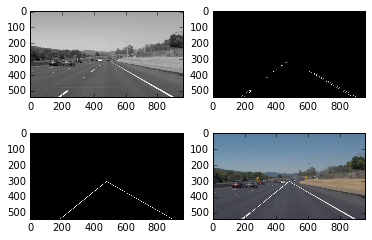

In [23]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

Slope & intercept:  [[0.64928909952606639, -6.1990521327014676], [0.69897959183673475, -33.525510204081684], [0.62576687116564422, 9.6625766871165411]]
Slope:  0.658011854176 Intercept:  -10.0206618832
Slope & intercept:  [[-0.60285714285714287, 600.9028571428571], [-0.62745098039215685, 615.17647058823525], [-0.60139860139860135, 610.65734265734261], [-0.6018957345971564, 601.19905213270147], [-0.64757709251101325, 620.59471365638763], [-0.72131147540983609, 650.70491803278696], [-0.64903846153846156, 621.61057692307691]]
Slope:  -0.635932784101 Intercept:  617.263704448
Coef:  0.658011854176 Intercept:  -10.0206618832 intersection_x:  484.784547789
Point one:  (484, 308) Point two:  (960, 621)
Coef:  -0.635932784101 Intercept:  617.263704448 intersection_x:  484.784547789
Point one:  (484, 308) Point two:  (0, 617)
(540, 960, 3)
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4









  0%|          | 0/682 [00:00<?, ?it/s]

Slope & intercept:  [[0.64928909952606639, -6.1990521327014676], [0.69897959183673475, -33.525510204081684], [0.62576687116564422, 9.6625766871165411]]
Slope:  0.658011854176 Intercept:  -10.0206618832
Slope & intercept:  [[-0.60285714285714287, 600.9028571428571], [-0.62745098039215685, 615.17647058823525], [-0.60139860139860135, 610.65734265734261], [-0.6018957345971564, 601.19905213270147], [-0.64757709251101325, 620.59471365638763], [-0.72131147540983609, 650.70491803278696], [-0.64903846153846156, 621.61057692307691]]
Slope:  -0.635932784101 Intercept:  617.263704448
Coef:  0.658011854176 Intercept:  -10.0206618832 intersection_x:  484.784547789
Point one:  (484, 308) Point two:  (960, 621)
Coef:  -0.635932784101 Intercept:  617.263704448 intersection_x:  484.784547789
Point one:  (484, 308) Point two:  (0, 617)
(540, 960, 3)









  0%|          | 2/682 [00:00<00:49, 13.76it/s]

Slope & intercept:  [[0.69918699186991873, -33.439024390243901], [0.6489795918367347, -7.3020408163265529]]
Slope:  0.674083291853 Intercept:  -20.3705326033
Slope & intercept:  [[-0.62676056338028174, 616.34507042253517], [-0.60171919770773641, 601.18051575931236], [-0.62937062937062938, 615.32867132867136], [-0.61111111111111116, 610.0], [-0.625, 616.75], [-0.60236220472440949, 600.67716535433067], [-0.75735294117647056, 667.80882352941171]]
Slope:  -0.636239521067 Intercept:  618.298606628
Coef:  0.674083291853 Intercept:  -20.3705326033 intersection_x:  487.413584602
Point one:  (487, 308) Point two:  (960, 626)
Coef:  -0.636239521067 Intercept:  618.298606628 intersection_x:  487.413584602
Point one:  (487, 308) Point two:  (0, 618)
(540, 960, 3)
Slope & intercept:  [[0.70161290322580649, -35.620967741935488], [0.64919354838709675, -6.6733870967742064]]
Slope:  0.675403225806 Intercept:  -21.1471774194
Slope & intercept:  [[-0.60233918128654973, 601.85964912280701], [-0.6267942583

(540, 960, 3)









  1%|          | 4/682 [00:00<00:47, 14.30it/s]

Slope & intercept:  [[0.69683257918552033, -31.678733031674199], [0.65116279069767447, -9.3255813953488769], [0.72566371681415931, -56.04424778761063], [0.647887323943662, -7.1830985915493102], [0.72486772486772488, -53.597883597883595], [0.64444444444444449, -3.3333333333333712]]
Slope:  0.681809763326 Intercept:  -26.8604796229
Slope & intercept:  [[-0.65094339622641506, 624.92452830188677], [-0.62403100775193798, 609.43023255813955], [-0.62179487179487181, 608.01923076923072], [-0.6506024096385542, 621.32530120481931], [-0.6470588235294118, 622.76470588235293], [-0.66666666666666663, 632.66666666666663], [-0.62087912087912089, 608.26923076923072]]
Slope:  -0.64028232807 Intercept:  618.199985165
Coef:  0.681809763326 Intercept:  -26.8604796229 intersection_x:  487.90887487
Point one:  (487, 305) Point two:  (960, 627)
Coef:  -0.64028232807 Intercept:  618.199985165 intersection_x:  487.90887487
Point one:  (487, 305) Point two:  (0, 618)
(540, 960, 3)
Slope & intercept:  [[0.7205882








  1%|          | 6/682 [00:00<00:45, 14.80it/s]

(540, 960, 3)
Slope & intercept:  [[0.64516129032258063, -2.0645161290322562], [0.75, -68.75]]
Slope:  0.697580645161 Intercept:  -35.4072580645
Slope & intercept:  [[-0.65048543689320393, 626.46601941747576], [-0.62426035502958577, 611.66272189349115], [-0.63414634146341464, 624.26829268292681], [-0.67441860465116277, 631.1395348837209], [-0.64983164983164987, 627.02693602693603]]
Slope:  -0.646628477574 Intercept:  624.112700981
Coef:  0.697580645161 Intercept:  -35.4072580645 intersection_x:  490.637913321
Point one:  (490, 306) Point two:  (960, 634)
Coef:  -0.646628477574 Intercept:  624.112700981 intersection_x:  490.637913321
Point one:  (490, 306) Point two:  (0, 624)
(540, 960, 3)
Slope & intercept:  [[0.72268907563025209, -49.823529411764696], [0.66990291262135926, -23.61165048543694]]
Slope:  0.696295994126 Intercept:  -36.7175899486
Slope & intercept:  [[-0.62574850299401197, 612.7155688622754], [-0.6518518518518519, 628.25925925925924], [-0.64919354838709675, 628.237903225

(540, 960, 3)
Slope & intercept:  [[0.64963503649635035, -11.029197080291965], [0.67741935483870963, -22.838709677419331], [0.69354838709677424, -39.45161290322585]]
Slope:  0.673534259477 Intercept:  -24.439839887
Slope & intercept:  [[-0.62691131498470953, 614.2293577981651], [-0.64876033057851235, 628.17768595041321], [-0.72268907563025209, 651.76470588235293], [-0.67346938775510201, 635.67346938775506], [-0.66956521739130437, 633.31304347826085], [-0.59999999999999998, 605.0], [-0.63513513513513509, 615.71621621621625], [-0.62613981762917936, 612.76291793313067]]
Slope:  -0.650333784888 Intercept:  624.579674581
Coef:  0.673534259477 Intercept:  -24.439839887 intersection_x:  490.244867855
Point one:  (490, 305) Point two:  (960, 622)
Coef:  -0.650333784888 Intercept:  624.579674581 intersection_x:  490.244867855
Point one:  (490, 305) Point two:  (0, 624)









  1%|          | 8/682 [00:01<01:53,  5.92it/s]






  1%|▏         | 10/682 [00:01<01:31,  7.33it/s]

(540, 960, 3)
Slope & intercept:  [[0.66666666666666663, -17.666666666666629], [0.67441860465116277, -27.767441860465112]]
Slope:  0.670542635659 Intercept:  -22.7170542636
Slope & intercept:  [[-0.62538699690402477, 613.67182662538698], [-0.65333333333333332, 628.75999999999999], [-0.64864864864864868, 628.81081081081084], [-0.62745098039215685, 612.60784313725492], [-0.77611940298507465, 675.14925373134326], [-0.6071428571428571, 606.67857142857144], [-0.69945355191256831, 641.85792349726773]]
Slope:  -0.662505110188 Intercept:  629.648032747
Coef:  0.670542635659 Intercept:  -22.7170542636 intersection_x:  489.378635569
Point one:  (489, 305) Point two:  (960, 621)
Coef:  -0.662505110188 Intercept:  629.648032747 intersection_x:  489.378635569
Point one:  (489, 305) Point two:  (0, 629)
(540, 960, 3)
Slope & intercept:  [[0.62264150943396224, 3.8490566037735903], [0.6987951807228916, -38.795180722891587], [0.68000000000000005, -25.800000000000011]]
Slope:  0.667145563386 Intercept: 








  2%|▏         | 12/682 [00:01<01:15,  8.84it/s]






  2%|▏         | 14/682 [00:01<01:05, 10.24it/s]

Slope & intercept:  [[0.62015503875968991, 5.2868217054263482], [0.70085470085470081, -41.811965811965763], [0.64473684210526316, -3.5657894736842195]]
Slope:  0.655248860573 Intercept:  -13.3636445267
Slope & intercept:  [[-0.64848484848484844, 619.41212121212118], [-0.67586206896551726, 636.32413793103444], [-0.65000000000000002, 621.14999999999998], [-0.67666666666666664, 635.44000000000005], [-0.66101694915254239, 620.62711864406776]]
Slope:  -0.662406106654 Intercept:  626.590675557
Coef:  0.655248860573 Intercept:  -13.3636445267 intersection_x:  485.676702931
Point one:  (485, 304) Point two:  (960, 615)
Coef:  -0.662406106654 Intercept:  626.590675557 intersection_x:  485.676702931
Point one:  (485, 304) Point two:  (0, 626)
(540, 960, 3)
Slope & intercept:  [[0.67333333333333334, -24.366666666666674], [0.62420382165605093, 2.2356687898089262], [0.67333333333333334, -23.693333333333328]]
Slope:  0.656956829441 Intercept:  -15.2747770701
Slope & intercept:  [[-0.6748251748251747








  2%|▏         | 16/682 [00:01<00:57, 11.64it/s]






  3%|▎         | 18/682 [00:01<00:51, 12.85it/s]

(540, 960, 3)
Slope & intercept:  [[0.64761904761904765, -5.3523809523809973], [0.60073260073260071, 20.377289377289401], [0.60144927536231885, 20.753623188405811]]
Slope:  0.616600307905 Intercept:  11.9261772044
Slope & intercept:  [[-0.69945355191256831, 646.76502732240442], [-0.6741573033707865, 631.69662921348311], [-0.66666666666666663, 628.0], [-0.69999999999999996, 645.39999999999998], [-0.67142857142857137, 627.62857142857138], [-0.75, 653.25], [-0.66666666666666663, 627.33333333333337]]
Slope:  -0.689767537149 Intercept:  637.1533659
Coef:  0.616600307905 Intercept:  11.9261772044 intersection_x:  478.599646388
Point one:  (478, 307) Point two:  (960, 603)
Coef:  -0.689767537149 Intercept:  637.1533659 intersection_x:  478.599646388
Point one:  (478, 307) Point two:  (0, 637)
(540, 960, 3)
Slope & intercept:  [[0.59459459459459463, 26.054054054054006], [0.66129032258064513, -17.5], [0.59722222222222221, 23.388888888888914], [0.65079365079365081, -8.3650793650793958], [0.62337








  3%|▎         | 20/682 [00:01<00:47, 13.90it/s]






  3%|▎         | 22/682 [00:02<00:44, 14.74it/s]

(540, 960, 3)
Slope & intercept:  [[0.62393162393162394, 8.0256410256410504], [0.59848484848484851, 18.515151515151501], [0.59848484848484851, 22.909090909090878]]
Slope:  0.606967106967 Intercept:  16.4832944833
Slope & intercept:  [[-0.70188679245283014, 646.79245283018872], [-0.67307692307692313, 629.53846153846155], [-0.67419354838709677, 630.69032258064522], [-0.70289855072463769, 646.24637681159425]]
Slope:  -0.68801395366 Intercept:  638.31690344
Coef:  0.606967106967 Intercept:  16.4832944833 intersection_x:  480.187415757
Point one:  (480, 307) Point two:  (960, 599)
Coef:  -0.68801395366 Intercept:  638.31690344 intersection_x:  480.187415757
Point one:  (480, 307) Point two:  (0, 638)
(540, 960, 3)
Slope & intercept:  [[0.6097560975609756, 9.3902439024390105], [0.65000000000000002, -9.1999999999999886]]
Slope:  0.62987804878 Intercept:  0.0951219512195
Slope & intercept:  [[-0.67202572347266876, 628.72347266881025], [-0.70370370370370372, 646.07407407407413], [-0.70089285714








  4%|▎         | 24/682 [00:02<00:43, 15.23it/s]






  4%|▍         | 26/682 [00:02<00:41, 15.64it/s]

(540, 960, 3)
Slope & intercept:  [[0.59836065573770492, 17.188524590163922], [0.64912280701754388, -9.5263157894736992], [0.59523809523809523, 20.047619047619037]]
Slope:  0.614240519331 Intercept:  9.23660928277
Slope & intercept:  [[-0.70355731225296447, 646.64426877470351], [-0.65200000000000002, 623.10000000000002], [-0.7142857142857143, 648.14285714285711], [-0.65492957746478875, 622.54929577464793], [-0.64000000000000001, 622.03999999999996], [-0.70229007633587781, 645.45038167938935], [-0.67381974248927035, 628.84978540772534], [-0.67202572347266876, 627.70739549839232]]
Slope:  -0.676613518288 Intercept:  633.060498035
Coef:  0.614240519331 Intercept:  9.23660928277 intersection_x:  483.264467223
Point one:  (483, 306) Point two:  (960, 598)
Coef:  -0.676613518288 Intercept:  633.060498035 intersection_x:  483.264467223
Point one:  (483, 306) Point two:  (0, 633)
(540, 960, 3)
Slope & intercept:  [[0.6449704142011834, -5.8579881656804673], [0.62666666666666671, -0.640000000000








  4%|▍         | 28/682 [00:02<00:40, 16.06it/s]

Slope & intercept:  [[0.65022421524663676, -12.390134529147986], [0.59836065573770492, 17.827868852459005], [0.64583333333333337, -8.0416666666666856], [0.57727272727272727, 33.068181818181813]]
Slope:  0.617922732898 Intercept:  7.61606236871
Slope & intercept:  [[-0.67558528428093645, 632.23076923076928], [-0.70192307692307687, 648.90384615384619], [-0.70873786407766992, 649.252427184466], [-0.70707070707070707, 649.53535353535358], [-0.69230769230769229, 637.69230769230762]]
Slope:  -0.702509835095 Intercept:  646.345983641
Coef:  0.617922732898 Intercept:  7.61606236871 intersection_x:  483.727784936
Point one:  (483, 306) Point two:  (960, 600)
Coef:  -0.702509835095 Intercept:  646.345983641 intersection_x:  483.727784936
Point one:  (483, 306) Point two:  (0, 646)
(540, 960, 3)
Slope & intercept:  [[0.59913793103448276, 15.551724137931046], [0.64682539682539686, -11.44841269841271], [0.61805555555555558, 8.0555555555555429], [0.6097560975609756, 18.487804878048792]]
Slope:  0.60








  4%|▍         | 30/682 [00:02<00:39, 16.50it/s]






  5%|▍         | 32/682 [00:02<00:39, 16.64it/s]

Slope & intercept:  [[0.59803921568627449, 18.166666666666686]]
Slope & intercept:  [[-0.67509025270758127, 633.1877256317689], [-0.70731707317073167, 651.73170731707319], [-0.75, 665.0], [-0.75, 658.75], [-0.70192307692307687, 651.00961538461536], [-0.77931034482758621, 674.18620689655177], [-0.77922077922077926, 671.83116883116884]]
Slope:  -0.74462854569 Intercept:  662.084783072
Coef:  0.598039215686 Intercept:  18.1666666667 intersection_x:  479.581125672
Point one:  (479, 304) Point two:  (960, 592)
Coef:  -0.74462854569 Intercept:  662.084783072 intersection_x:  479.581125672
Point one:  (479, 304) Point two:  (0, 662)
(540, 960, 3)
Slope & intercept:  [[0.62393162393162394, 3.2649572649572747], [0.59999999999999998, 17.400000000000034]]
Slope:  0.611965811966 Intercept:  10.3324786325
Slope & intercept:  [[-0.67407407407407405, 634.39259259259256], [-0.72769953051643188, 657.61502347417843], [-0.72033898305084743, 648.66949152542372], [-0.65540540540540537, 628.60810810810813],








  5%|▍         | 34/682 [00:02<00:38, 16.72it/s]






  5%|▌         | 36/682 [00:02<00:38, 16.70it/s]

(540, 960, 3)
Slope & intercept:  [[0.61818181818181817, 6.0181818181818016], [0.62790697674418605, -7.2558139534883708], [0.58620689655172409, 21.103448275862092], [0.61111111111111116, 11.4444444444444]]
Slope:  0.610851700647 Intercept:  7.82756514625
Slope & intercept:  [[-0.75294117647058822, 665.68235294117653], [-0.70034843205574915, 640.55052264808364], [-0.75396825396825395, 664.43650793650795], [-0.83486238532110091, 692.98165137614683], [-0.72666666666666668, 649.11333333333334]]
Slope:  -0.753757382896 Intercept:  662.552873647
Coef:  0.610851700647 Intercept:  7.82756514625 intersection_x:  479.789645545
Point one:  (479, 300) Point two:  (960, 594)
Coef:  -0.753757382896 Intercept:  662.552873647 intersection_x:  479.789645545
Point one:  (479, 300) Point two:  (0, 662)
(540, 960, 3)
Slope & intercept:  [[0.62121212121212122, 3.6666666666666856], [0.59154929577464788, 17.633802816901436]]
Slope:  0.606380708493 Intercept:  10.6502347418
Slope & intercept:  [[-0.7534883720








  6%|▌         | 38/682 [00:02<00:38, 16.77it/s]






  6%|▌         | 40/682 [00:03<00:38, 16.51it/s]

Slope & intercept:  [[0.57894736842105265, 26.947368421052602], [0.62135922330097082, 4.3106796116505279], [0.625, -6.625], [0.62857142857142856, -1.8857142857143003]]
Slope:  0.613469505073 Intercept:  5.68683343675
Slope & intercept:  [[-0.72614107883817425, 646.7053941908714], [-0.78666666666666663, 677.39999999999998], [-0.76923076923076927, 669.23076923076928], [-0.7531914893617021, 663.78297872340431], [-0.70357142857142863, 641.42499999999995], [-0.75257731958762886, 664.68041237113403], [-0.68493150684931503, 633.15068493150682], [-0.70833333333333337, 643.83333333333337]]
Slope:  -0.742816012227 Intercept:  658.151126836
Coef:  0.613469505073 Intercept:  5.68683343675 intersection_x:  481.067065213
Point one:  (481, 300) Point two:  (960, 594)
Coef:  -0.742816012227 Intercept:  658.151126836 intersection_x:  481.067065213
Point one:  (481, 300) Point two:  (0, 658)
(540, 960, 3)
Slope & intercept:  [[0.59999999999999998, 10.0], [0.62561576354679804, 0.1182266009852242], [0.619








  6%|▌         | 42/682 [00:03<00:38, 16.46it/s]

(540, 960, 3)
Slope & intercept:  [[0.61971830985915488, 4.4225352112676433], [0.55555555555555558, 47.0]]
Slope:  0.587636932707 Intercept:  25.7112676056
Slope & intercept:  [[-0.75308641975308643, 662.25925925925924], [-0.7007299270072993, 639.60583941605842], [-0.70279720279720281, 638.90559440559446], [-0.83892617449664431, 690.95973154362423]]
Slope:  -0.748884931014 Intercept:  657.932606156
Coef:  0.587636932707 Intercept:  25.7112676056 intersection_x:  473.034789562
Point one:  (473, 303) Point two:  (960, 589)
Coef:  -0.748884931014 Intercept:  657.932606156 intersection_x:  473.034789562
Point one:  (473, 303) Point two:  (0, 657)
(540, 960, 3)
Slope & intercept:  [[0.56976744186046513, 34.569767441860449]]
Slope & intercept:  [[-0.70034843205574915, 637.44947735191636], [-0.75416666666666665, 662.68333333333339], [-0.7021276595744681, 639.40425531914889], [-0.75502008032128509, 662.33333333333337], [-0.70138888888888884, 638.29861111111109], [-0.72093023255813948, 643.8604








  6%|▋         | 44/682 [00:03<00:40, 15.64it/s]






  7%|▋         | 46/682 [00:03<00:40, 15.76it/s]

(540, 960, 3)
Slope & intercept:  [[0.578125, 32.34375]]
Slope & intercept:  [[-0.69999999999999996, 638.89999999999998], [-0.75348837209302322, 664.07906976744187], [-0.70138888888888884, 639.70138888888891], [-0.7441860465116279, 660.20930232558135], [-0.76595744680851063, 666.23404255319156], [-0.70370370370370372, 639.2962962962963]]
Slope:  -0.728120743001 Intercept:  651.403349972
Coef:  0.578125 Intercept:  32.34375 intersection_x:  473.922769348
Point one:  (473, 306) Point two:  (960, 587)
Coef:  -0.728120743001 Intercept:  651.403349972 intersection_x:  473.922769348
Point one:  (473, 306) Point two:  (0, 651)
(540, 960, 3)
Slope & intercept:  [[0.59999999999999998, 19.199999999999989]]
Slope & intercept:  [[-0.70307167235494883, 640.24232081911259], [-0.75342465753424659, 663.63013698630141], [-0.7678571428571429, 662.89285714285711], [-0.77083333333333337, 666.1875], [-0.70149253731343286, 639.14925373134326], [-0.7441860465116279, 659.06976744186045]]
Slope:  -0.7401442316








  7%|▋         | 48/682 [00:03<00:39, 15.98it/s]






  7%|▋         | 50/682 [00:03<00:39, 16.08it/s]

Slope & intercept:  [[0.6166666666666667, 10.116666666666674], [0.625, -1.875], [0.63829787234042556, -11.808510638297889]]
Slope:  0.626654846336 Intercept:  -1.18894799054
Slope & intercept:  [[-0.75590551181102361, 664.48031496062993], [-0.70186335403726707, 639.71428571428578], [-0.72151898734177211, 644.34177215189868], [-0.72677595628415304, 647.51912568306011], [-0.68421052631578949, 636.73684210526312], [-0.75342465753424659, 664.67123287671234]]
Slope:  -0.731897693402 Intercept:  652.145346277
Coef:  0.626654846336 Intercept:  -1.18894799054 intersection_x:  480.904694635
Point one:  (480, 300) Point two:  (960, 600)
Coef:  -0.731897693402 Intercept:  652.145346277 intersection_x:  480.904694635
Point one:  (480, 300) Point two:  (0, 652)
(540, 960, 3)
Slope & intercept:  [[0.6495726495726496, -12.495726495726501], [0.58024691358024694, 27.160493827160451]]
Slope:  0.614909781576 Intercept:  7.33238366572
Slope & intercept:  [[-0.70068027210884354, 639.59863945578229], [-0.75








  8%|▊         | 52/682 [00:03<00:38, 16.36it/s]






  8%|▊         | 54/682 [00:03<00:38, 16.23it/s]

(540, 960, 3)
Slope & intercept:  [[0.57539682539682535, 31.678571428571445], [0.60465116279069764, 17.976744186046517], [0.64676616915422891, -14.582089552238813], [0.59999999999999998, 12.199999999999989], [0.62439024390243902, 3.6292682926829229]]
Slope:  0.601109558022 Intercept:  16.3711459768
Slope & intercept:  [[-0.72222222222222221, 644.77777777777783], [-0.75555555555555554, 663.66666666666663], [-0.75091575091575091, 661.15018315018312], [-0.73809523809523814, 645.5], [-0.73999999999999999, 648.31999999999994], [-0.7265625, 646.8828125]]
Slope:  -0.738891877798 Intercept:  651.716240016
Coef:  0.601109558022 Intercept:  16.3711459768 intersection_x:  474.137621838
Point one:  (474, 301) Point two:  (960, 593)
Coef:  -0.738891877798 Intercept:  651.716240016 intersection_x:  474.137621838
Point one:  (474, 301) Point two:  (0, 651)
(540, 960, 3)
Slope & intercept:  [[0.59999999999999998, 11.800000000000011], [0.625, 4.0], [0.61428571428571432, 2.2714285714285438], [0.62357414








  8%|▊         | 56/682 [00:04<00:38, 16.36it/s]

Slope & intercept:  [[0.57954545454545459, 31.704545454545439], [0.65306122448979587, -19.367346938775427], [0.59183673469387754, 19.551020408163254]]
Slope:  0.608147804576 Intercept:  10.629406308
Slope & intercept:  [[-0.70238095238095233, 638.73809523809518], [-0.7528089887640449, 663.22471910112358], [-0.74683544303797467, 659.7341772151899], [-0.76470588235294112, 664.88235294117646], [-0.76470588235294112, 665.47058823529414], [-0.83333333333333337, 691.66666666666674], [-0.67708333333333337, 629.23958333333337], [-0.73684210526315785, 656.0]]
Slope:  -0.757373226784 Intercept:  662.816657057
Coef:  0.608147804576 Intercept:  10.629406308 intersection_x:  477.610549945
Point one:  (477, 301) Point two:  (960, 594)
Coef:  -0.757373226784 Intercept:  662.816657057 intersection_x:  477.610549945
Point one:  (477, 301) Point two:  (0, 662)
(540, 960, 3)
Slope & intercept:  [[0.55434782608695654, 48.5]]
Slope & intercept:  [[-0.70175438596491224, 636.9473684210526], [-0.7294117647058








  9%|▊         | 58/682 [00:04<00:37, 16.60it/s]






  9%|▉         | 60/682 [00:04<00:36, 16.83it/s]

(540, 960, 3)
Slope & intercept:  [[0.59999999999999998, 22.0], [0.5957446808510638, 19.212765957446834]]
Slope:  0.597872340426 Intercept:  20.6063829787
Slope & intercept:  [[-0.70155038759689925, 637.91860465116281], [-0.75, 660.75], [-0.75, 661.25], [-0.74390243902439024, 657.76829268292681], [-0.77653631284916202, 666.39106145251401], [-0.70175438596491224, 636.9473684210526]]
Slope:  -0.737290587573 Intercept:  653.504221201
Coef:  0.597872340426 Intercept:  20.6063829787 intersection_x:  474.022926304
Point one:  (474, 304) Point two:  (960, 594)
Coef:  -0.737290587573 Intercept:  653.504221201 intersection_x:  474.022926304
Point one:  (474, 304) Point two:  (0, 653)
(540, 960, 3)
Slope & intercept:  [[0.5892857142857143, 24.285714285714278], [0.62222222222222223, 7.8666666666666742], [0.61538461538461542, 6.153846153846132], [0.60784313725490191, 18.13725490196083]]
Slope:  0.608683922287 Intercept:  14.110870502
Slope & intercept:  [[-0.70106761565836295, 637.14946619217085],








  9%|▉         | 62/682 [00:04<00:37, 16.69it/s]






  9%|▉         | 64/682 [00:04<00:37, 16.67it/s]

Slope & intercept:  [[0.59848484848484851, 18.106060606060566], [0.62204724409448819, 8.2598425196850371]]
Slope:  0.61026604629 Intercept:  13.1829515629
Slope & intercept:  [[-0.72953736654804269, 652.53736654804266], [-0.69767441860465118, 633.58139534883719], [-0.69999999999999996, 636.10000000000002], [-0.69798657718120805, 634.32214765100673], [-0.71153846153846156, 638.75], [-0.72830188679245278, 653.0716981132075]]
Slope:  -0.710839785111 Intercept:  641.393767944
Coef:  0.61026604629 Intercept:  13.1829515629 intersection_x:  475.518918658
Point one:  (475, 303) Point two:  (960, 599)
Coef:  -0.710839785111 Intercept:  641.393767944 intersection_x:  475.518918658
Point one:  (475, 303) Point two:  (0, 641)
(540, 960, 3)
Slope & intercept:  [[0.59999999999999998, 16.400000000000034], [0.61855670103092786, 11.752577319587601]]
Slope:  0.609278350515 Intercept:  14.0762886598
Slope & intercept:  [[-0.69696969696969702, 634.12121212121212], [-0.72791519434628971, 651.5547703180211








 10%|▉         | 66/682 [00:04<00:37, 16.55it/s]






 10%|▉         | 68/682 [00:04<00:38, 16.02it/s]

(540, 960, 3)
Slope & intercept:  [[0.62454873646209386, 7.7581227436822928], [0.59677419354838712, 19.806451612903231], [0.578125, 34.453125]]
Slope:  0.59981597667 Intercept:  20.6725664522
Slope & intercept:  [[-0.72573839662447259, 652.63291139240505], [-0.67656765676567654, 630.013201320132], [-0.67567567567567566, 628.97297297297291], [-0.75418994413407825, 659.53072625698326], [-0.72693726937269376, 652.40221402214024]]
Slope:  -0.711821788515 Intercept:  644.710405193
Coef:  0.59981597667 Intercept:  20.6725664522 intersection_x:  475.769953645
Point one:  (475, 306) Point two:  (960, 596)
Coef:  -0.711821788515 Intercept:  644.710405193 intersection_x:  475.769953645
Point one:  (475, 306) Point two:  (0, 644)
(540, 960, 3)
Slope & intercept:  [[0.57647058823529407, 37.047058823529426], [0.64000000000000001, -3.7200000000000273], [0.57746478873239437, 34.070422535211264], [0.57499999999999996, 36.800000000000011]]
Slope:  0.576311792323 Intercept:  35.9724937862
Slope & interc








 10%|█         | 70/682 [00:04<00:37, 16.11it/s]

Slope & intercept:  [[0.57657657657657657, 33.396396396396426], [0.60439560439560436, 21.362637362637372], [0.55140186915887845, 51.22429906542061]]
Slope:  0.57745801671 Intercept:  35.3277776082
Slope & intercept:  [[-0.72759856630824371, 653.96057347670251], [-0.67708333333333337, 630.97916666666663], [-0.67647058823529416, 631.35294117647061], [-0.65454545454545454, 620.27272727272725], [-0.73913043478260865, 655.39130434782612]]
Slope:  -0.694965675441 Intercept:  638.391342588
Coef:  0.57745801671 Intercept:  35.3277776082 intersection_x:  473.948708044
Point one:  (473, 309) Point two:  (960, 589)
Coef:  -0.694965675441 Intercept:  638.391342588 intersection_x:  473.948708044
Point one:  (473, 309) Point two:  (0, 638)
(540, 960, 3)
Slope & intercept:  [[0.59523809523809523, 26.428571428571445], [0.57692307692307687, 32.000000000000057]]
Slope:  0.586080586081 Intercept:  29.2142857143
Slope & intercept:  [[-0.67441860465116277, 629.79069767441865], [-0.72262773722627738, 651.45








 11%|█         | 72/682 [00:05<00:37, 16.15it/s]






 11%|█         | 74/682 [00:05<00:37, 16.12it/s]

(540, 960, 3)
Slope & intercept:  [[0.61403508771929827, 16.912280701754355], [0.59999999999999998, 20.400000000000034], [0.60194174757281549, 18.067961165048587]]
Slope:  0.605325611764 Intercept:  18.4600806223
Slope & intercept:  [[-0.67434210526315785, 630.3848684210526], [-0.69999999999999996, 647.20000000000005], [-0.7142857142857143, 649.14285714285711], [-0.80232558139534882, 678.32558139534876], [-0.82608695652173914, 689.6521739130435], [-0.7265625, 653.0703125], [-0.7767857142857143, 670.79464285714289], [-0.65000000000000002, 620.85000000000002]]
Slope:  -0.733798571469 Intercept:  654.927554529
Coef:  0.605325611764 Intercept:  18.4600806223 intersection_x:  475.286371403
Point one:  (475, 306) Point two:  (960, 599)
Coef:  -0.733798571469 Intercept:  654.927554529 intersection_x:  475.286371403
Point one:  (475, 306) Point two:  (0, 654)
(540, 960, 3)
Slope & intercept:  [[0.60330578512396693, 17.049586776859485], [0.66666666666666663, -16.333333333333314], [0.62068965517








 11%|█         | 76/682 [00:05<00:37, 15.99it/s]






 11%|█▏        | 78/682 [00:05<00:38, 15.58it/s]

Slope & intercept:  [[0.59999999999999998, 21.199999999999989], [0.64903846153846156, -4.8125]]
Slope:  0.624519230769 Intercept:  8.19375
Slope & intercept:  [[-0.67763157894736847, 632.51315789473688], [-0.72661870503597126, 653.97841726618708], [-0.69047619047619047, 635.07142857142856], [-0.72758620689655173, 653.95862068965516], [-0.67619047619047623, 630.58095238095234]]
Slope:  -0.699700631509 Intercept:  641.220515361
Coef:  0.624519230769 Intercept:  8.19375 intersection_x:  478.037509777
Point one:  (478, 306) Point two:  (960, 607)
Coef:  -0.699700631509 Intercept:  641.220515361 intersection_x:  478.037509777
Point one:  (478, 306) Point two:  (0, 641)
(540, 960, 3)
Slope & intercept:  [[0.59922178988326846, 21.653696498054501], [0.65053763440860213, -4.9516129032257936], [0.67123287671232879, -23.0], [0.647887323943662, -4.1126760563380458], [0.64853556485355646, -6.0962343096234122]]
Slope:  0.64348303796 Intercept:  -3.30136535423
Slope & intercept:  [[-0.674418604651162








 12%|█▏        | 80/682 [00:05<00:37, 15.99it/s]






 12%|█▏        | 82/682 [00:05<00:36, 16.41it/s]

(540, 960, 3)
Slope & intercept:  [[0.5901639344262295, 29.868852459016409], [0.6166666666666667, 21.0], [0.64912280701754388, -7.263157894736878], [0.60256410256410253, 22.128205128205138], [0.66153846153846152, -18.307692307692321], [0.6428571428571429, -1.7142857142857792]]
Slope:  0.627152185845 Intercept:  7.61865361175
Slope & intercept:  [[-0.67426710097719866, 630.37459283387625], [-0.7407407407407407, 656.0], [-0.80555555555555558, 681.13888888888891], [-0.74193548387096775, 658.41935483870964], [-0.77692307692307694, 666.78461538461534], [-0.80487804878048785, 681.68292682926835], [-0.75147928994082835, 662.5976331360946], [-0.74545454545454548, 656.0363636363636], [-0.7008928571428571, 636.87946428571422], [-0.63235294117647056, 615.52941176470586]]
Slope:  -0.749125188821 Intercept:  658.879315537
Coef:  0.627152185845 Intercept:  7.61865361175 intersection_x:  473.204510888
Point one:  (473, 304) Point two:  (960, 609)
Coef:  -0.749125188821 Intercept:  658.879315537 inter








 12%|█▏        | 84/682 [00:05<00:36, 16.51it/s]






 13%|█▎        | 86/682 [00:05<00:35, 16.67it/s]

(540, 960, 3)
Slope & intercept:  [[0.64666666666666661, -3.3533333333332962], [0.64748201438848918, -11.143884892086305], [0.67142857142857137, -25.242857142857133]]
Slope:  0.655192417495 Intercept:  -13.2466917894
Slope & intercept:  [[-0.72649572649572647, 652.29059829059827], [-0.67313915857605178, 628.20064724919098], [-0.72401433691756267, 650.49820788530462], [-0.71875, 643.75], [-0.69421487603305787, 633.2066115702479]]
Slope:  -0.715868734862 Intercept:  644.936354437
Coef:  0.655192417495 Intercept:  -13.2466917894 intersection_x:  480.053748948
Point one:  (480, 301) Point two:  (960, 615)
Coef:  -0.715868734862 Intercept:  644.936354437 intersection_x:  480.053748948
Point one:  (480, 301) Point two:  (0, 644)
(540, 960, 3)
Slope & intercept:  [[0.62264150943396224, 5.0754716981132333], [0.65116279069767447, -6.4186046511628092]]
Slope:  0.636902150066 Intercept:  -0.671566476525
Slope & intercept:  [[-0.6797385620915033, 628.24836601307197], [-0.72569444444444442, 651.482








 13%|█▎        | 88/682 [00:06<00:35, 16.71it/s]

Slope & intercept:  [[0.66666666666666663, -16.333333333333314], [0.59868421052631582, 22.342105263157862], [0.58156028368794321, 32.90780141843976]]
Slope:  0.615637053627 Intercept:  12.9721911161
Slope & intercept:  [[-0.67449664429530198, 626.35906040268458], [-0.72413793103448276, 648.79310344827582], [-0.70454545454545459, 644.13636363636363], [-0.65359477124183007, 620.54248366013076], [-0.68421052631578949, 635.73684210526312], [-0.67615658362989328, 627.57651245551597]]
Slope:  -0.68619031851 Intercept:  633.857394285
Coef:  0.615637053627 Intercept:  12.9721911161 intersection_x:  476.93359078
Point one:  (476, 306) Point two:  (960, 603)
Coef:  -0.68619031851 Intercept:  633.857394285 intersection_x:  476.93359078
Point one:  (476, 306) Point two:  (0, 633)
(540, 960, 3)
Slope & intercept:  [[0.6460674157303371, -3.4438202247191043], [0.59999999999999998, 21.0], [0.67132867132867136, -20.097902097902136], [0.63888888888888884, -6.6111111111110858]]
Slope:  0.639071243987 Int








 13%|█▎        | 90/682 [00:06<00:35, 16.75it/s]






 13%|█▎        | 92/682 [00:06<00:35, 16.82it/s]

(540, 960, 3)
Slope & intercept:  [[0.60137457044673537, 23.22336769759454], [0.67193675889328064, -22.051383399209499], [0.66666666666666663, -16.0], [0.57746478873239437, 42.126760563380287], [0.57868020304568524, 39.375634517766514], [0.65098039215686276, -4.5686274509803866]]
Slope:  0.62451722999 Intercept:  10.3509586548
Slope & intercept:  [[-0.67434210526315785, 627.33881578947364], [-0.70070422535211263, 643.80633802816897], [-0.70169491525423733, 643.25423728813564], [-0.67326732673267331, 628.18811881188117]]
Slope:  -0.687502143151 Intercept:  635.646877479
Coef:  0.62451722999 Intercept:  10.3509586548 intersection_x:  476.590461715
Point one:  (476, 307) Point two:  (960, 609)
Coef:  -0.687502143151 Intercept:  635.646877479 intersection_x:  476.590461715
Point one:  (476, 307) Point two:  (0, 635)
(540, 960, 3)
Slope & intercept:  [[0.61855670103092786, 9.1340206185566899], [0.64772727272727271, -2.204545454545439], [0.65957446808510634, -10.319148936170166], [0.63829787








 14%|█▍        | 94/682 [00:06<00:35, 16.76it/s]






 14%|█▍        | 96/682 [00:06<00:35, 16.63it/s]

Slope & intercept:  [[0.55769230769230771, 48.692307692307679], [0.66935483870967738, -12.451612903225794]]
Slope:  0.613523573201 Intercept:  18.1203473945
Slope & intercept:  [[-0.671875, 630.375], [-0.69999999999999996, 646.5], [-0.67549668874172186, 630.54304635761594], [-0.70388349514563109, 646.93203883495153]]
Slope:  -0.687813795972 Intercept:  638.587521298
Coef:  0.613523573201 Intercept:  18.1203473945 intersection_x:  476.791943889
Point one:  (476, 310) Point two:  (960, 607)
Coef:  -0.687813795972 Intercept:  638.587521298 intersection_x:  476.791943889
Point one:  (476, 310) Point two:  (0, 638)
(540, 960, 3)
Slope & intercept:  [[0.58024691358024694, 36.086419753086432], [0.62037037037037035, 16.46296296296299]]
Slope:  0.600308641975 Intercept:  26.274691358
Slope & intercept:  [[-0.7007299270072993, 647.31386861313865], [-0.67400881057268724, 631.69603524229069], [-0.67647058823529416, 631.0], [-0.6875, 641.625], [-0.6875, 640.8125]]
Slope:  -0.685241865163 Intercept:








 14%|█▍        | 98/682 [00:06<00:34, 16.74it/s]






 15%|█▍        | 100/682 [00:06<00:35, 16.62it/s]

(540, 960, 3)
Slope & intercept:  [[0.63829787234042556, 5.2765957446808329], [0.61764705882352944, 12.5], [0.57647058823529407, 38.800000000000011], [0.67500000000000004, -23.850000000000023]]
Slope:  0.62685387985 Intercept:  8.18164893617
Slope & intercept:  [[-0.67301587301587307, 630.2031746031746], [-0.72972972972972971, 657.2702702702702], [-0.70422535211267601, 648.56338028169012], [-0.67507886435331232, 631.48580441640377], [-0.75, 661.25], [-0.72121212121212119, 652.68484848484854]]
Slope:  -0.708876990071 Intercept:  646.909579676
Coef:  0.62685387985 Intercept:  8.18164893617 intersection_x:  478.186096558
Point one:  (478, 307) Point two:  (960, 609)
Coef:  -0.708876990071 Intercept:  646.909579676 intersection_x:  478.186096558
Point one:  (478, 307) Point two:  (0, 646)
(540, 960, 3)
Slope & intercept:  [[0.65454545454545454, -5.818181818181813], [0.64583333333333337, -6.75], [0.57999999999999996, 35.0]]
Slope:  0.626792929293 Intercept:  7.47727272727
Slope & intercept:








 15%|█▍        | 102/682 [00:06<00:34, 16.69it/s]

Slope & intercept:  [[0.65151515151515149, -4.3030303030303116], [0.60326086956521741, 20.983695652173878], [0.59999999999999998, 22.199999999999989]]
Slope:  0.618258673693 Intercept:  12.960221783
Slope & intercept:  [[-0.67405063291139244, 630.6708860759494], [-0.703125, 647.390625], [-0.70454545454545459, 647.06818181818187], [-0.67549668874172186, 629.19205298013242]]
Slope:  -0.68930444405 Intercept:  638.580436469
Coef:  0.618258673693 Intercept:  12.960221783 intersection_x:  478.462726729
Point one:  (478, 308) Point two:  (960, 606)
Coef:  -0.68930444405 Intercept:  638.580436469 intersection_x:  478.462726729
Point one:  (478, 308) Point two:  (0, 638)
(540, 960, 3)
Slope & intercept:  [[0.6009174311926605, 22.486238532110121], [0.65000000000000002, -3.8500000000000227], [0.57627118644067798, 42.355932203389841]]
Slope:  0.609062872544 Intercept:  20.3307235785
Slope & intercept:  [[-0.6768707482993197, 630.37755102040819], [-0.72799999999999998, 655.78399999999999], [-0.724








 15%|█▌        | 104/682 [00:07<00:34, 16.60it/s]






 16%|█▌        | 106/682 [00:07<00:35, 16.32it/s]

(540, 960, 3)
Slope & intercept:  [[0.59722222222222221, 25.791666666666686], [0.61616161616161613, 11.181818181818187], [0.62820512820512819, 13.5], [0.67441860465116277, -22.790697674418595]]
Slope:  0.613862988863 Intercept:  16.8244949495
Slope & intercept:  [[-0.67543859649122806, 629.38596491228077], [-0.70289855072463769, 645.05797101449275], [-0.66666666666666663, 626.0], [-0.72727272727272729, 651.09090909090912], [-0.70149253731343286, 645.32835820895525], [-0.66878980891719741, 626.94904458598728], [-0.70183486238532111, 646.38073394495416]]
Slope:  -0.692056249967 Intercept:  638.598997394
Coef:  0.613862988863 Intercept:  16.8244949495 intersection_x:  476.120179531
Point one:  (476, 309) Point two:  (960, 606)
Coef:  -0.692056249967 Intercept:  638.598997394 intersection_x:  476.120179531
Point one:  (476, 309) Point two:  (0, 638)
(540, 960, 3)
Slope & intercept:  [[0.61538461538461542, 11.846153846153811], [0.66666666666666663, -19.666666666666629], [0.63829787234042556








 16%|█▌        | 108/682 [00:07<00:36, 15.53it/s]






 16%|█▌        | 110/682 [00:07<00:36, 15.60it/s]

Slope & intercept:  [[0.57377049180327866, 36.245901639344254], [0.62831858407079644, 8.9203539823009237]]
Slope:  0.601044537937 Intercept:  22.5831278108
Slope & intercept:  [[-0.67449664429530198, 628.42953020134223], [-0.72455089820359286, 653.94610778443121], [-0.72350230414746541, 652.57603686635946], [-0.71951219512195119, 647.42682926829264], [-0.75, 657.5], [-0.78378378378378377, 663.75675675675677], [-0.68888888888888888, 633.91111111111104], [-0.67142857142857137, 627.62857142857138]]
Slope:  -0.717020410734 Intercept:  645.646867927
Coef:  0.601044537937 Intercept:  22.5831278108 intersection_x:  472.710954604
Point one:  (472, 306) Point two:  (960, 599)
Coef:  -0.717020410734 Intercept:  645.646867927 intersection_x:  472.710954604
Point one:  (472, 306) Point two:  (0, 645)
(540, 960, 3)
Slope & intercept:  [[0.60240963855421692, 20.012048192771033], [0.62686567164179108, 11.134328358208961]]
Slope:  0.614637655098 Intercept:  15.5731882755
Slope & intercept:  [[-0.69999








 16%|█▋        | 112/682 [00:07<00:36, 15.55it/s]






 17%|█▋        | 114/682 [00:07<00:36, 15.40it/s]

(540, 960, 3)
Slope & intercept:  [[0.65116279069767447, -3.7441860465116292], [0.65000000000000002, -10.100000000000023], [0.58156028368794321, 34.397163120567427]]
Slope:  0.627574358129 Intercept:  6.85099235802
Slope & intercept:  [[-0.70196078431372544, 647.50588235294117], [-0.67241379310344829, 631.65517241379314], [-0.67213114754098358, 630.40983606557381], [-0.70344827586206893, 649.44137931034481], [-0.67368421052631577, 632.83157894736837], [-0.6875, 635.4375], [-0.68181818181818177, 632.77272727272725], [-0.74850299401197606, 661.58682634730542]]
Slope:  -0.692682423397 Intercept:  640.205112839
Coef:  0.627574358129 Intercept:  6.85099235802 intersection_x:  479.720406926
Point one:  (479, 307) Point two:  (960, 609)
Coef:  -0.692682423397 Intercept:  640.205112839 intersection_x:  479.720406926
Point one:  (479, 307) Point two:  (0, 640)
(540, 960, 3)
Slope & intercept:  [[0.58273381294964033, 34.0], [0.67153284671532842, -18.11678832116786], [0.57792207792207795, 37.7402








 17%|█▋        | 116/682 [00:07<00:36, 15.57it/s]

Slope & intercept:  [[0.64888888888888885, -3.9733333333333007], [0.62085308056872035, 7.2843601895734764], [0.65137614678899081, -4.6330275229357767]]
Slope:  0.640372705416 Intercept:  -0.440666888899
Slope & intercept:  [[-0.67355371900826444, 632.18181818181824], [-0.70175438596491224, 648.17543859649118], [-0.6875, 635.25], [-0.65934065934065933, 628.32967032967031], [-0.65740740740740744, 627.12962962962968], [-0.69047619047619047, 641.42857142857144], [-0.68627450980392157, 641.96078431372553], [-0.65765765765765771, 625.60360360360369]]
Slope:  -0.676745566207 Intercept:  635.00743951
Coef:  0.640372705416 Intercept:  -0.440666888899 intersection_x:  482.453337783
Point one:  (482, 308) Point two:  (960, 614)
Coef:  -0.676745566207 Intercept:  635.00743951 intersection_x:  482.453337783
Point one:  (482, 308) Point two:  (0, 635)
(540, 960, 3)
Slope & intercept:  [[0.65037593984962405, -4.7142857142857224], [0.62222222222222223, 5.0], [0.62096774193548387, 6.9758064516129252], 








 17%|█▋        | 118/682 [00:07<00:35, 15.78it/s]






 18%|█▊        | 120/682 [00:08<00:34, 16.06it/s]

(540, 960, 3)
Slope & intercept:  [[0.6506024096385542, -5.3012048192770749], [0.67469879518072284, -25.397590361445737], [0.64485981308411211, -2.7663551401868745], [0.66666666666666663, -21.333333333333314]]
Slope:  0.659206921143 Intercept:  -13.6996209136
Slope & intercept:  [[-0.67289719626168221, 631.18691588785043], [-0.72398190045248867, 655.03167420814475], [-0.67213114754098358, 630.08196721311469], [-0.71739130434782605, 648.23913043478262], [-0.7528089887640449, 661.50561797752812], [-0.68571428571428572, 645.34285714285716], [-0.7142857142857143, 645.28571428571422], [-0.75138121546961323, 659.52486187845307]]
Slope:  -0.711323969105 Intercept:  647.024842379
Coef:  0.659206921143 Intercept:  -13.6996209136 intersection_x:  482.093813422
Point one:  (482, 304) Point two:  (960, 619)
Coef:  -0.711323969105 Intercept:  647.024842379 intersection_x:  482.093813422
Point one:  (482, 304) Point two:  (0, 647)
(540, 960, 3)
Slope & intercept:  [[0.65040650406504064, -5.479674796








 18%|█▊        | 122/682 [00:08<00:34, 16.34it/s]






 18%|█▊        | 124/682 [00:08<00:36, 15.14it/s]

Slope & intercept:  [[0.64942528735632188, -4.7701149425287781]]
Slope & intercept:  [[-0.67719298245614035, 631.87017543859645], [-0.7055555555555556, 650.12222222222226], [-0.65340909090909094, 626.77840909090912], [-0.65151515151515149, 626.81818181818176], [-0.64912280701754388, 628.22807017543857], [-0.70642201834862384, 648.48623853211006], [-0.72426470588235292, 655.4375], [-0.68333333333333335, 633.7166666666667]]
Slope:  -0.681351955627 Intercept:  637.682182993
Coef:  0.649425287356 Intercept:  -4.77011494253 intersection_x:  482.764716126
Point one:  (482, 308) Point two:  (960, 618)
Coef:  -0.681351955627 Intercept:  637.682182993 intersection_x:  482.764716126
Point one:  (482, 308) Point two:  (0, 637)
(540, 960, 3)
Slope & intercept:  [[0.64423076923076927, -1.8365384615385096], [0.62068965517241381, 7.1379310344827331]]
Slope:  0.632460212202 Intercept:  2.65069628647
Slope & intercept:  [[-0.72463768115942029, 656.95652173913049], [-0.67391304347826086, 632.34782608695








 18%|█▊        | 126/682 [00:08<00:38, 14.42it/s]

Slope & intercept:  [[0.6462585034013606, -3.2585034013605991], [0.59589041095890416, 23.150684931506817]]
Slope:  0.62107445718 Intercept:  9.94609076507
Slope & intercept:  [[-0.72666666666666668, 657.44666666666672], [-0.69841269841269837, 639.79365079365084], [-0.69473684210526321, 640.02105263157898], [-0.65217391304347827, 629.95652173913049], [-0.69892473118279574, 641.11827956989248]]
Slope:  -0.704685234592 Intercept:  644.594912415
Coef:  0.62107445718 Intercept:  9.94609076507 intersection_x:  478.705775707
Point one:  (478, 307) Point two:  (960, 606)
Coef:  -0.704685234592 Intercept:  644.594912415 intersection_x:  478.705775707
Point one:  (478, 307) Point two:  (0, 644)
(540, 960, 3)
Slope & intercept:  [[0.64772727272727271, -3.375], [0.59677419354838712, 23.822580645161281], [0.6460674157303371, -3.4438202247191043]]
Slope:  0.630189627335 Intercept:  5.66792014015
Slope & intercept:  [[-0.72425249169435213, 656.7774086378738], [-0.69565217391304346, 639.13043478260875








 19%|█▉        | 128/682 [00:08<00:38, 14.48it/s]






 19%|█▉        | 130/682 [00:08<00:38, 14.46it/s]

Slope & intercept:  [[0.64925373134328357, -4.7761194029850458], [0.60278745644599308, 19.616724738675941], [0.58620689655172409, 34.206896551724185], [0.62181818181818183, 6.7236363636363876]]
Slope:  0.61501656654 Intercept:  13.9427845628
Slope & intercept:  [[-0.72661870503597126, 656.89208633093529], [-0.67692307692307696, 634.01538461538462], [-0.72695035460992907, 658.21985815602841], [-0.71604938271604934, 655.11111111111109], [-0.66666666666666663, 632.66666666666663], [-0.69599999999999995, 641.37599999999998]]
Slope:  -0.701534697659 Intercept:  646.38018448
Coef:  0.61501656654 Intercept:  13.9427845628 intersection_x:  480.374306049
Point one:  (480, 309) Point two:  (960, 604)
Coef:  -0.701534697659 Intercept:  646.38018448 intersection_x:  480.374306049
Point one:  (480, 309) Point two:  (0, 646)
(540, 960, 3)
Slope & intercept:  [[0.60069444444444442, 21.402777777777771], [0.64794007490636707, -4.973782771535582], [0.671875, -21.671875], [0.59541984732824427, 26.5343511








 19%|█▉        | 132/682 [00:08<00:37, 14.50it/s]

(540, 960, 3)
Slope & intercept:  [[0.64912280701754388, -4.1052631578947398], [0.625, 5.0]]
Slope:  0.637061403509 Intercept:  0.447368421053
Slope & intercept:  [[-0.72499999999999998, 657.17499999999995], [-0.67741935483870963, 635.19354838709683], [-0.67701863354037262, 633.42857142857144], [-0.65517241379310343, 626.68965517241372], [-0.66216216216216217, 630.7702702702702], [-0.7767857142857143, 675.23214285714289], [-0.62962962962962965, 619.40740740740739], [-0.63076923076923075, 622.43076923076922]]
Slope:  -0.679244642377 Intercept:  637.540920594
Coef:  0.637061403509 Intercept:  0.447368421053 intersection_x:  484.001083308
Point one:  (484, 308) Point two:  (960, 612)
Coef:  -0.679244642377 Intercept:  637.540920594 intersection_x:  484.001083308
Point one:  (484, 308) Point two:  (0, 637)
(540, 960, 3)
Slope & intercept:  [[0.65137614678899081, -6.2660550458715534], [0.61946902654867253, 7.3185840707964758]]
Slope:  0.635422586669 Intercept:  0.526264512462
Slope & interc








 20%|█▉        | 134/682 [00:09<00:37, 14.43it/s]






 20%|█▉        | 136/682 [00:09<00:41, 13.28it/s]

(540, 960, 3)
Slope & intercept:  [[0.57692307692307687, 35.807692307692321], [0.64383561643835618, -1.1369863013698591], [0.59999999999999998, 20.0]]
Slope:  0.606919564454 Intercept:  18.2235686688
Slope & intercept:  [[-0.67731629392971249, 634.21086261980827], [-0.72463768115942029, 657.1159420289855], [-0.72556390977443608, 658.83834586466162], [-0.67839195979899503, 636.0100502512563], [-0.63793103448275867, 617.27586206896558]]
Slope:  -0.701477461166 Intercept:  646.543800191
Coef:  0.606919564454 Intercept:  18.2235686688 intersection_x:  480.221384809
Point one:  (480, 309) Point two:  (960, 600)
Coef:  -0.701477461166 Intercept:  646.543800191 intersection_x:  480.221384809
Point one:  (480, 309) Point two:  (0, 646)
(540, 960, 3)
Slope & intercept:  [[0.6179775280898876, 9.2471910112359978], [0.64655172413793105, -2.5431034482758719]]
Slope:  0.632264626114 Intercept:  3.35204378148
Slope & intercept:  [[-0.72425249169435213, 657.7774086378738], [-0.67721518987341767, 634.1








 20%|██        | 138/682 [00:09<00:39, 13.62it/s]

Slope & intercept:  [[0.57638888888888884, 37.375], [0.64444444444444449, -0.66666666666668561], [0.59848484848484851, 23.46212121212119]]
Slope:  0.606439393939 Intercept:  20.0568181818
Slope & intercept:  [[-0.67692307692307696, 635.15384615384619], [-0.72627737226277367, 658.83576642335765], [-0.6470588235294118, 622.82352941176475], [-0.67692307692307696, 633.73846153846148], [-0.72473867595818819, 658.82926829268297], [-0.67788461538461542, 636.61538461538464]]
Slope:  -0.688300940164 Intercept:  640.999376073
Coef:  0.606439393939 Intercept:  20.0568181818 intersection_x:  479.588487
Point one:  (479, 310) Point two:  (960, 602)
Coef:  -0.688300940164 Intercept:  640.999376073 intersection_x:  479.588487
Point one:  (479, 310) Point two:  (0, 640)
(540, 960, 3)
Slope & intercept:  [[0.64779874213836475, -4.1194968553459148], [0.59999999999999998, 21.0], [0.65189873417721522, -5.7594936708861155]]
Slope:  0.633232492105 Intercept:  3.70700315792
Slope & intercept:  [[-0.672839506








 21%|██        | 140/682 [00:09<00:38, 14.05it/s]






 21%|██        | 142/682 [00:09<00:37, 14.34it/s]

(540, 960, 3)
Slope & intercept:  [[0.59931506849315064, 21.390410958904113], [0.65055762081784385, -6.1672862453531252], [0.64814814814814814, -5.1481481481481524], [0.58695652173913049, 33.217391304347757]]
Slope:  0.6212443398 Intercept:  10.8230919674
Slope & intercept:  [[-0.72527472527472525, 657.2197802197802], [-0.69590643274853803, 640.54970760233914], [-0.69411764705882351, 637.56470588235288], [-0.69444444444444442, 639.13888888888891], [-0.7142857142857143, 643.0]]
Slope:  -0.704805792762 Intercept:  643.494616519
Coef:  0.6212443398 Intercept:  10.8230919674 intersection_x:  477.109808306
Point one:  (477, 307) Point two:  (960, 607)
Coef:  -0.704805792762 Intercept:  643.494616519 intersection_x:  477.109808306
Point one:  (477, 307) Point two:  (0, 643)
(540, 960, 3)
Slope & intercept:  [[0.59420289855072461, 23.739130434782624], [0.5993031358885017, 22.0], [0.62745098039215685, 12.333333333333314], [0.5758928571428571, 42.73214285714289], [0.64761904761904765, -3.409523








 21%|██        | 144/682 [00:09<00:37, 14.40it/s]






 21%|██▏       | 146/682 [00:09<00:36, 14.83it/s]

Slope & intercept:  [[0.64761904761904765, -3.6095238095238074], [0.61445783132530118, 10.397590361445793], [0.62222222222222223, 6.7555555555555316]]
Slope:  0.628099700389 Intercept:  4.51454070249
Slope & intercept:  [[-0.72666666666666668, 658.17333333333329], [-0.6776859504132231, 634.23140495867767], [-0.67391304347826086, 631.6521739130435], [-0.66176470588235292, 631.85294117647061], [-0.70634920634920639, 650.15873015873012]]
Slope:  -0.689275914558 Intercept:  641.213716708
Coef:  0.628099700389 Intercept:  4.51454070249 intersection_x:  483.308760828
Point one:  (483, 308) Point two:  (960, 607)
Coef:  -0.689275914558 Intercept:  641.213716708 intersection_x:  483.308760828
Point one:  (483, 308) Point two:  (0, 641)
(540, 960, 3)
Slope & intercept:  [[0.57894736842105265, 33.157894736842081], [0.67521367521367526, -19.846153846153868]]
Slope:  0.627080521817 Intercept:  6.65587044534
Slope & intercept:  [[-0.72413793103448276, 656.75862068965512], [-0.69607843137254899, 640








 22%|██▏       | 148/682 [00:09<00:35, 15.25it/s]






 22%|██▏       | 150/682 [00:10<00:35, 15.14it/s]

(540, 960, 3)
Slope & intercept:  [[0.64485981308411211, -1.3177570093457689], [0.61904761904761907, 7.8571428571428328], [0.66666666666666663, -16.0]]
Slope:  0.643524699599 Intercept:  -3.15353805073
Slope & intercept:  [[-0.72623574144486691, 657.37642585551328], [-0.67697594501718217, 633.63917525773195], [-0.67582417582417587, 633.96703296703299], [-0.65714285714285714, 624.34285714285716], [-0.6292134831460674, 614.21348314606735], [-0.6097560975609756, 608.85365853658539], [-0.68085106382978722, 638.51063829787233]]
Slope:  -0.674373877734 Intercept:  633.674935445
Coef:  0.643524699599 Intercept:  -3.15353805073 intersection_x:  483.215085324
Point one:  (483, 307) Point two:  (960, 614)
Coef:  -0.674373877734 Intercept:  633.674935445 intersection_x:  483.215085324
Point one:  (483, 307) Point two:  (0, 633)
(540, 960, 3)
Slope & intercept:  [[0.58163265306122447, 32.0], [0.64462809917355368, -2.3471074380165078]]
Slope:  0.613130376117 Intercept:  14.826446281
Slope & interce








 22%|██▏       | 152/682 [00:10<00:36, 14.49it/s]

Slope & intercept:  [[0.57978723404255317, 34.739361702127667], [0.62068965517241381, 13.931034482758605], [0.5786516853932584, 34.797752808988776]]
Slope:  0.593042858203 Intercept:  27.8227163313
Slope & intercept:  [[-0.67711598746081503, 634.15047021943576], [-0.72486772486772488, 657.7883597883598], [-0.72661870503597126, 657.16546762589928], [-0.72932330827067671, 660.59398496240601], [-0.67441860465116277, 632.58139534883719]]
Slope:  -0.706468866057 Intercept:  648.455935589
Coef:  0.593042858203 Intercept:  27.8227163313 intersection_x:  477.58954973
Point one:  (477, 311) Point two:  (960, 597)
Coef:  -0.706468866057 Intercept:  648.455935589 intersection_x:  477.58954973
Point one:  (477, 311) Point two:  (0, 648)
(540, 960, 3)
Slope & intercept:  [[0.62285714285714289, 4.3199999999999932], [0.6160714285714286, 17.464285714285666], [0.57964601769911506, 35.5], [0.61290322580645162, 20.741935483870975]]
Slope:  0.607869453734 Intercept:  19.5065552995
Slope & intercept:  [[-0








 23%|██▎       | 154/682 [00:10<00:35, 14.88it/s]






 23%|██▎       | 156/682 [00:10<00:34, 15.24it/s]

(540, 960, 3)
Slope & intercept:  [[0.59722222222222221, 20.625], [0.62637362637362637, 9.3406593406593288], [0.59183673469387754, 26.061224489795904], [0.63888888888888884, 0.72222222222228538], [0.59340659340659341, 27.098901098901081]]
Slope:  0.602209794174 Intercept:  20.7814462323
Slope & intercept:  [[-0.72881355932203384, 659.71186440677968], [-0.69480519480519476, 641.11688311688317], [-0.69599999999999995, 643.24800000000005], [-0.72222222222222221, 660.27777777777783], [-0.71153846153846156, 648.09615384615381], [-0.67816091954022983, 638.0114942528736], [-0.80434782608695654, 690.04347826086951], [-0.67601246105919, 636.37383177570098], [-0.77777777777777779, 680.77777777777783]]
Slope:  -0.721075380261 Intercept:  655.295251246
Coef:  0.602209794174 Intercept:  20.7814462323 intersection_x:  479.498914725
Point one:  (479, 309) Point two:  (960, 598)
Coef:  -0.721075380261 Intercept:  655.295251246 intersection_x:  479.498914725
Point one:  (479, 309) Point two:  (0, 655)









 23%|██▎       | 158/682 [00:10<00:34, 15.27it/s]






 23%|██▎       | 160/682 [00:10<00:33, 15.75it/s]

Slope & intercept:  [[0.57432432432432434, 35.763513513513487], [0.59880239520958078, 25.856287425149731]]
Slope:  0.586563359767 Intercept:  30.8099004693
Slope & intercept:  [[-0.67492260061919507, 639.23839009287929], [-0.72516556291390732, 662.27814569536429], [-0.67924528301886788, 638.88679245283015], [-0.71764705882352942, 661.88235294117646], [-0.74137931034482762, 670.74137931034488], [-0.74193548387096775, 664.80645161290317], [-0.69736842105263153, 645.57894736842104]]
Slope:  -0.711094817235 Intercept:  654.773208496
Coef:  0.586563359767 Intercept:  30.8099004693 intersection_x:  480.837958012
Point one:  (480, 312) Point two:  (960, 593)
Coef:  -0.711094817235 Intercept:  654.773208496 intersection_x:  480.837958012
Point one:  (480, 312) Point two:  (0, 654)
(540, 960, 3)
Slope & intercept:  [[0.56976744186046513, 39.65116279069764], [0.6028368794326241, 24.680851063829778]]
Slope:  0.586302160647 Intercept:  32.1660069273
Slope & intercept:  [[-0.72516556291390732, 663.








 24%|██▍       | 162/682 [00:10<00:35, 14.85it/s]

(540, 960, 3)
Slope & intercept:  [[0.62142857142857144, 11.378571428571433], [0.59633027522935778, 21.009174311926643], [0.55900621118012417, 46.664596273291977]]
Slope:  0.592255019279 Intercept:  26.3507806713
Slope & intercept:  [[-0.72575250836120397, 665.00668896321065], [-0.67532467532467533, 640.37662337662334], [-0.67680608365019013, 641.65399239543729], [-0.65909090909090906, 639.63636363636363], [-0.62745098039215685, 634.39215686274508], [-0.839622641509434, 712.94339622641519], [-0.62650602409638556, 632.16867469879514]]
Slope:  -0.690079117489 Intercept:  652.311128023
Coef:  0.592255019279 Intercept:  26.3507806713 intersection_x:  488.141373924
Point one:  (488, 315) Point two:  (960, 594)
Coef:  -0.690079117489 Intercept:  652.311128023 intersection_x:  488.141373924
Point one:  (488, 315) Point two:  (0, 652)
(540, 960, 3)
Slope & intercept:  [[0.62285714285714289, 10.805714285714259], [0.57627118644067798, 34.983050847457605], [0.67021276595744683, -22.82978723404255








 24%|██▍       | 164/682 [00:11<00:34, 14.86it/s]






 24%|██▍       | 166/682 [00:11<00:35, 14.63it/s]

(540, 960, 3)
Slope & intercept:  [[0.62396694214876036, 7.4669421487603245], [0.57692307692307687, 33.423076923076962], [0.62222222222222223, 7.6444444444444457]]
Slope:  0.607704080431 Intercept:  16.1781545054
Slope & intercept:  [[-0.72666666666666668, 665.89333333333332], [-0.67790262172284643, 642.003745318352], [-0.70063694267515919, 648.29936305732485], [-0.67796610169491522, 640.61016949152543], [-0.75401069518716579, 672.82887700534764], [-0.74137931034482762, 667.74137931034488], [-0.75609756097560976, 672.58536585365846]]
Slope:  -0.719237128467 Intercept:  658.566033339
Coef:  0.607704080431 Intercept:  16.1781545054 intersection_x:  484.111786208
Point one:  (484, 310) Point two:  (960, 599)
Coef:  -0.719237128467 Intercept:  658.566033339 intersection_x:  484.111786208
Point one:  (484, 310) Point two:  (0, 658)
(540, 960, 3)
Slope & intercept:  [[0.57859531772575246, 32.729096989966592], [0.6028368794326241, 22.574468085106389], [0.57608695652173914, 33.347826086956502]








 25%|██▍       | 168/682 [00:11<00:34, 14.71it/s]






 25%|██▍       | 170/682 [00:11<00:33, 15.33it/s]

(540, 960, 3)
Slope & intercept:  [[0.60869565217391308, 17.347826086956502], [0.55000000000000004, 55.099999999999966], [0.61764705882352944, 8.6764705882352473], [0.57692307692307687, 30.730769230769283], [0.57499999999999996, 36.475000000000023], [0.5757575757575758, 30.757575757575694]]
Slope:  0.584003893946 Intercept:  29.8479402773
Slope & intercept:  [[-0.69696969696969702, 647.42424242424249], [-0.7279411764705882, 665.38970588235293], [-0.72916666666666663, 667.33333333333326], [-0.72307692307692306, 658.39999999999998], [-0.7142857142857143, 653.57142857142856], [-0.6992481203007519, 650.1503759398496]]
Slope:  -0.715114716295 Intercept:  657.044847692
Coef:  0.584003893946 Intercept:  29.8479402773 intersection_x:  482.786484983
Point one:  (482, 311) Point two:  (960, 590)
Coef:  -0.715114716295 Intercept:  657.044847692 intersection_x:  482.786484983
Point one:  (482, 311) Point two:  (0, 657)
(540, 960, 3)
Slope & intercept:  [[0.62222222222222223, 4.7777777777777715], [








 25%|██▌       | 172/682 [00:11<00:32, 15.63it/s]

Slope & intercept:  [[0.57352941176470584, 32.573529411764753], [0.578125, 34.078125]]
Slope:  0.575827205882 Intercept:  33.3258272059
Slope & intercept:  [[-0.72999999999999998, 668.66999999999996], [-0.70032573289902278, 650.05211726384368], [-0.84090909090909094, 710.18181818181824], [-0.81176470588235294, 699.90588235294126], [-0.6996699669966997, 650.94719471947201], [-0.73529411764705888, 669.11764705882354], [-0.78106508875739644, 683.41420118343194]]
Slope:  -0.757004100442 Intercept:  676.041265823
Coef:  0.575827205882 Intercept:  33.3258272059 intersection_x:  482.218143862
Point one:  (482, 311) Point two:  (960, 586)
Coef:  -0.757004100442 Intercept:  676.041265823 intersection_x:  482.218143862
Point one:  (482, 311) Point two:  (0, 676)
(540, 960, 3)
Slope & intercept:  [[0.5714285714285714, 37.285714285714278], [0.54545454545454541, 49.272727272727309]]
Slope:  0.558441558442 Intercept:  43.2792207792
Slope & intercept:  [[-0.75524475524475521, 675.69930069930069], [-0








 26%|██▌       | 174/682 [00:11<00:32, 15.69it/s]






 26%|██▌       | 176/682 [00:11<00:32, 15.76it/s]

(540, 960, 3)
Slope & intercept:  [[0.62184873949579833, 4.0252100840336311], [0.55384615384615388, 43.923076923076906]]
Slope:  0.587847446671 Intercept:  23.9741435036
Slope & intercept:  [[-0.75294117647058822, 675.78823529411761], [-0.70036101083032487, 652.15884476534291], [-0.75462962962962965, 677.37962962962968], [-0.75423728813559321, 670.45762711864404], [-0.7483443708609272, 666.73509933774835], [-0.70454545454545459, 651.31818181818176]]
Slope:  -0.735843155079 Intercept:  665.639602994
Coef:  0.587847446671 Intercept:  23.9741435036 intersection_x:  484.754865406
Point one:  (484, 308) Point two:  (960, 588)
Coef:  -0.735843155079 Intercept:  665.639602994 intersection_x:  484.754865406
Point one:  (484, 308) Point two:  (0, 665)
(540, 960, 3)
Slope & intercept:  [[0.5955056179775281, 22.202247191011224], [0.55629139072847678, 41.437086092715276], [0.53435114503816794, 58.44274809160305], [0.58181818181818179, 31.400000000000034], [0.51485148514851486, 75.56435643564356]]









 26%|██▌       | 178/682 [00:11<00:32, 15.63it/s]






 26%|██▋       | 180/682 [00:12<00:31, 15.77it/s]

Slope & intercept:  [[0.60256410256410253, 15.782051282051327], [0.57786885245901642, 25.741803278688508]]
Slope:  0.590216477512 Intercept:  20.7619272804
Slope & intercept:  [[-0.72649572649572647, 662.54700854700855], [-0.77966101694915257, 687.10169491525426], [-0.72727272727272729, 660.36363636363637], [-0.75242718446601942, 669.12621359223294], [-0.72575250836120397, 660.6521739130435], [-0.76033057851239672, 681.15702479338847]]
Slope:  -0.745323290343 Intercept:  670.157958687
Coef:  0.590216477512 Intercept:  20.7619272804 intersection_x:  486.24237708
Point one:  (486, 307) Point two:  (960, 587)
Coef:  -0.745323290343 Intercept:  670.157958687 intersection_x:  486.24237708
Point one:  (486, 307) Point two:  (0, 670)
(540, 960, 3)
Slope & intercept:  [[0.59595959595959591, 19.515151515151558], [0.57407407407407407, 28.703703703703695], [0.57627118644067798, 26.118644067796595], [0.60076045627376429, 16.939163498098821], [0.5977011494252874, 6.6436781609194782]]
Slope:  0.5889








 27%|██▋       | 182/682 [00:12<00:31, 16.09it/s]






 27%|██▋       | 184/682 [00:12<00:30, 16.26it/s]

(540, 960, 3)
Slope & intercept:  [[0.51327433628318586, 70.548672566371692], [0.53271028037383172, 59.906542056074784]]
Slope:  0.522992308329 Intercept:  65.2276073112
Slope & intercept:  [[-0.78102189781021902, 687.17518248175179], [-0.75324675324675328, 669.50649350649348], [-0.72945205479452058, 662.73630136986299], [-0.7303370786516854, 661.79775280898878], [-0.80540540540540539, 696.12432432432433]]
Slope:  -0.759892637982 Intercept:  675.468010898
Coef:  0.522992308329 Intercept:  65.2276073112 intersection_x:  475.678201184
Point one:  (475, 314) Point two:  (960, 567)
Coef:  -0.759892637982 Intercept:  675.468010898 intersection_x:  475.678201184
Point one:  (475, 314) Point two:  (0, 675)
(540, 960, 3)
Slope & intercept:  [[0.52671755725190839, 60.229007633587798], [0.53097345132743368, 62.265486725663663], [0.57432432432432434, 35.040540540540519]]
Slope:  0.544005110968 Intercept:  52.5116782999
Slope & intercept:  [[-0.78102189781021902, 687.17518248175179], [-0.753424657








 27%|██▋       | 186/682 [00:12<00:30, 16.35it/s]

Slope & intercept:  [[0.54166666666666663, 51.833333333333371], [0.55752212389380529, 46.787610619469035]]
Slope:  0.54959439528 Intercept:  49.3104719764
Slope & intercept:  [[-0.75, 670.5], [-0.77857142857142858, 688.26428571428573], [-0.75438596491228072, 670.26315789473688], [-0.75352112676056338, 672.38732394366195], [-0.76249999999999996, 679.75], [-0.76744186046511631, 674.18604651162786], [-0.759493670886076, 684.34177215189879], [-0.80891719745222934, 698.95541401273886]]
Slope:  -0.766853906131 Intercept:  679.831000029
Coef:  0.54959439528 Intercept:  49.3104719764 intersection_x:  478.955783813
Point one:  (478, 312) Point two:  (960, 576)
Coef:  -0.766853906131 Intercept:  679.831000029 intersection_x:  478.955783813
Point one:  (478, 312) Point two:  (0, 679)
(540, 960, 3)
Slope & intercept:  [[0.52713178294573648, 62.480620155038707], [0.5736434108527132, 36.612403100775168], [0.55172413793103448, 44.793103448275872]]
Slope:  0.550833110576 Intercept:  47.9620422347
Slop








 28%|██▊       | 188/682 [00:12<00:30, 16.24it/s]






 28%|██▊       | 190/682 [00:12<00:30, 16.39it/s]

(540, 960, 3)
Slope & intercept:  [[0.57727272727272727, 34.109090909090924], [0.55191256830601088, 45.814207650273261], [0.5714285714285714, 29.85714285714289], [0.51098901098901095, 73.780219780219795], [0.57635467980295563, 33.679802955665025]]
Slope:  0.55759151156 Intercept:  43.4480928305
Slope & intercept:  [[-0.7528089887640449, 670.30337078651678], [-0.78472222222222221, 688.54166666666663], [-0.7526132404181185, 668.95470383275256], [-0.78260869565217395, 689.82608695652175], [-0.76470588235294112, 683.29411764705878], [-0.78417266187050361, 689.34532374100718]]
Slope:  -0.770271948547 Intercept:  681.710878272
Coef:  0.55759151156 Intercept:  43.4480928305 intersection_x:  480.668987902
Point one:  (480, 311) Point two:  (960, 578)
Coef:  -0.770271948547 Intercept:  681.710878272 intersection_x:  480.668987902
Point one:  (480, 311) Point two:  (0, 681)
(540, 960, 3)
Slope & intercept:  [[0.57720588235294112, 34.415441176470608], [0.5311475409836065, 61.213114754098399], [0.








 28%|██▊       | 192/682 [00:12<00:29, 16.37it/s]






 28%|██▊       | 194/682 [00:12<00:30, 16.10it/s]

Slope & intercept:  [[0.5803571428571429, 31.76785714285711], [0.55045871559633031, 46.944954128440315], [0.56451612903225812, 34.483870967741893], [0.53623188405797106, 61.304347826086939], [0.57333333333333336, 34.74666666666667], [0.58490566037735847, 16.188679245283026], [0.59259259259259256, 22.888888888888914]]
Slope:  0.568913636835 Intercept:  35.475037838
Slope & intercept:  [[-0.80932203389830504, 696.71610169491521], [-0.75308641975308643, 670.1358024691358], [-0.75172413793103443, 669.04827586206898], [-0.77981651376146788, 688.50458715596324], [-0.83544303797468356, 709.08860759493678], [-0.84905660377358494, 716.11320754716985]]
Slope:  -0.796408124515 Intercept:  691.601097054
Coef:  0.568913636835 Intercept:  35.475037838 intersection_x:  480.565151593
Point one:  (480, 308) Point two:  (960, 581)
Coef:  -0.796408124515 Intercept:  691.601097054 intersection_x:  480.565151593
Point one:  (480, 308) Point two:  (0, 691)
(540, 960, 3)
Slope & intercept:  [[0.5737704918032








 29%|██▊       | 196/682 [00:13<00:31, 15.49it/s]

(540, 960, 3)
Slope & intercept:  [[0.52173913043478259, 64.869565217391312], [0.55319148936170215, 50.872340425531888]]
Slope:  0.537465309898 Intercept:  57.8709528215
Slope & intercept:  [[-0.75352112676056338, 667.6056338028169], [-0.80500000000000005, 693.91000000000008], [-0.75221238938053092, 666.62831858407083], [-0.7678571428571429, 683.46428571428578], [-0.81021897810218979, 696.51094890510944], [-0.76470588235294112, 683.29411764705878], [-0.83439490445859876, 699.93630573248402]]
Slope:  -0.783987203416 Intercept:  684.478515769
Coef:  0.537465309898 Intercept:  57.8709528215 intersection_x:  474.180915799
Point one:  (474, 312) Point two:  (960, 573)
Coef:  -0.783987203416 Intercept:  684.478515769 intersection_x:  474.180915799
Point one:  (474, 312) Point two:  (0, 684)
(540, 960, 3)
Slope & intercept:  [[0.55555555555555558, 50.0], [0.5130434782608696, 71.313043478260852]]
Slope:  0.534299516908 Intercept:  60.6565217391
Slope & intercept:  [[-0.73008849557522126, 660.9








 29%|██▉       | 198/682 [00:13<00:31, 15.31it/s]






 29%|██▉       | 200/682 [00:13<00:32, 15.00it/s]

Slope & intercept:  [[0.57746478873239437, 35.929577464788736], [0.54887218045112784, 49.496240601503757], [0.54545454545454541, 57.727272727272748]]
Slope:  0.557263838213 Intercept:  47.7176969312
Slope & intercept:  [[-0.75126903553299496, 668.08629441624362], [-0.78488372093023251, 687.12790697674416], [-0.75352112676056338, 667.09859154929575], [-0.75190839694656486, 667.11832061068708], [-0.75824175824175821, 675.0], [-0.75342465753424659, 672.56164383561645], [-0.7808988764044944, 687.37078651685397]]
Slope:  -0.762021081764 Intercept:  674.909077701
Coef:  0.557263838213 Intercept:  47.7176969312 intersection_x:  475.402523953
Point one:  (475, 312) Point two:  (960, 582)
Coef:  -0.762021081764 Intercept:  674.909077701 intersection_x:  475.402523953
Point one:  (475, 312) Point two:  (0, 674)
(540, 960, 3)
Slope & intercept:  [[0.53201970443349755, 62.433497536945822], [0.59731543624161076, 22.946308724832193], [0.6198347107438017, 8.0991735537189697], [0.53216374269005851, 60








 30%|██▉       | 202/682 [00:13<00:31, 15.33it/s]






 30%|██▉       | 204/682 [00:13<00:30, 15.52it/s]

(540, 960, 3)
Slope & intercept:  [[0.59931506849315064, 22.390410958904113], [0.5558912386706949, 47.5921450151057], [0.53333333333333333, 63.399999999999977], [0.6228070175438597, 1.7631578947368212], [0.61904761904761907, 9.2857142857142776], [0.55405405405405406, 49.513513513513487]]
Slope:  0.580741388524 Intercept:  32.3241569447
Slope & intercept:  [[-0.78388278388278387, 683.80219780219784], [-0.75, 664.25], [-0.75, 663.25], [-0.78277153558052437, 684.37827715355809], [-0.76923076923076927, 673.15384615384619], [-0.83823529411764708, 704.01470588235293]]
Slope:  -0.779020063802 Intercept:  678.808171165
Coef:  0.580741388524 Intercept:  32.3241569447 intersection_x:  475.439286145
Point one:  (475, 308) Point two:  (960, 589)
Coef:  -0.779020063802 Intercept:  678.808171165 intersection_x:  475.439286145
Point one:  (475, 308) Point two:  (0, 678)
(540, 960, 3)
Slope & intercept:  [[0.58064516129032262, 38.645161290322562], [0.5535714285714286, 50.303571428571388], [0.549450549








 30%|███       | 206/682 [00:13<00:31, 15.28it/s]






 30%|███       | 208/682 [00:13<00:31, 15.01it/s]

Slope & intercept:  [[0.55434782608695654, 53.260869565217376], [0.59848484848484851, 25.818181818181813], [0.51048951048951052, 76.335664335664319], [0.54887218045112784, 52.120300751879711]]
Slope:  0.553048591378 Intercept:  51.8837541177
Slope & intercept:  [[-0.72689075630252098, 657.27731092436977], [-0.78136200716845883, 683.33333333333337], [-0.78873239436619713, 688.54929577464782], [-0.75, 663.75], [-0.79411764705882348, 687.5], [-0.78136200716845883, 684.11469534050184]]
Slope:  -0.779114811152 Intercept:  681.44946489
Coef:  0.553048591378 Intercept:  51.8837541177 intersection_x:  472.588955361
Point one:  (472, 313) Point two:  (960, 582)
Coef:  -0.779114811152 Intercept:  681.44946489 intersection_x:  472.588955361
Point one:  (472, 313) Point two:  (0, 681)
(540, 960, 3)
Slope & intercept:  [[0.50943396226415094, 75.584905660377387], [0.57792207792207795, 38.766233766233768]]
Slope:  0.543678020093 Intercept:  57.1755697133
Slope & intercept:  [[-0.78136200716845883, 68








 31%|███       | 210/682 [00:14<00:33, 14.28it/s]

Slope & intercept:  [[0.52800000000000002, 65.216000000000008], [0.57851239669421484, 38.85950413223145]]
Slope:  0.553256198347 Intercept:  52.0377520661
Slope & intercept:  [[-0.72818791946308725, 656.96644295302008], [-0.75376884422110557, 674.9396984924623], [-0.77419354838709675, 680.77419354838707], [-0.7407407407407407, 669.07407407407413], [-0.80689655172413788, 690.10344827586209], [-0.72916666666666663, 656.125], [-0.72881355932203384, 664.49152542372883], [-0.75471698113207553, 675.35849056603774]]
Slope:  -0.752060601457 Intercept:  670.979109167
Coef:  0.553256198347 Intercept:  52.0377520661 intersection_x:  474.169456176
Point one:  (474, 314) Point two:  (960, 583)
Coef:  -0.752060601457 Intercept:  670.979109167 intersection_x:  474.169456176
Point one:  (474, 314) Point two:  (0, 670)
(540, 960, 3)
Slope & intercept:  [[0.5968992248062015, 28.240310077519382], [0.53472222222222221, 61.736111111111143], [0.61818181818181817, 13.381818181818176]]
Slope:  0.58326775507 I








 31%|███       | 212/682 [00:14<00:36, 12.97it/s]

(540, 960, 3)
Slope & intercept:  [[0.55614973262032086, 50.352941176470608], [0.625, 8.375], [0.60355029585798814, 24.10059171597635], [0.53125, 66.15625]]
Slope:  0.57898750712 Intercept:  37.2461957231
Slope & intercept:  [[-0.72340425531914898, 654.31914893617022], [-0.75555555555555554, 673.24444444444441], [-0.75838926174496646, 673.06711409395973], [-0.72580645161290325, 656.14516129032256], [-0.74193548387096775, 657.16129032258061]]
Slope:  -0.741018201621 Intercept:  662.787431817
Coef:  0.57898750712 Intercept:  37.2461957231 intersection_x:  473.892826336
Point one:  (473, 311) Point two:  (960, 593)
Coef:  -0.741018201621 Intercept:  662.787431817 intersection_x:  473.892826336
Point one:  (473, 311) Point two:  (0, 662)
(540, 960, 3)
Slope & intercept:  [[0.62068965517241381, 12.413793103448256], [0.57309941520467833, 38.198830409356731], [0.601123595505618, 27.005617977528061]]
Slope:  0.598304221961 Intercept:  25.8727471634
Slope & intercept:  [[-0.72592592592592597, 6








 31%|███▏      | 214/682 [00:14<00:37, 12.55it/s]






 32%|███▏      | 216/682 [00:14<00:35, 13.18it/s]

Slope & intercept:  [[0.55160142348754448, 54.234875444839872], [0.62019230769230771, 11.730769230769226], [0.60079051383399207, 27.790513833992122], [0.55508474576271183, 49.813559322033939], [0.59649122807017541, 22.561403508771946]]
Slope:  0.584832043769 Intercept:  33.2262242681
Slope & intercept:  [[-0.703125, 648.515625], [-0.77777777777777779, 679.22222222222217], [-0.7068965517241379, 650.39655172413791], [-0.77777777777777779, 681.22222222222217], [-0.77272727272727271, 674.72727272727275], [-0.72888888888888892, 667.21777777777777], [-0.75294117647058822, 672.77647058823527], [-0.67924528301886788, 638.66037735849056], [-0.70454545454545459, 649.31818181818187]]
Slope:  -0.740584987489 Intercept:  665.42454051
Coef:  0.584832043769 Intercept:  33.2262242681 intersection_x:  476.980679539
Point one:  (476, 312) Point two:  (960, 594)
Coef:  -0.740584987489 Intercept:  665.42454051 intersection_x:  476.980679539
Point one:  (476, 312) Point two:  (0, 665)
(540, 960, 3)
Slope &








 32%|███▏      | 218/682 [00:14<00:34, 13.31it/s]

Slope & intercept:  [[0.59633027522935778, 29.9633027522936], [0.62068965517241381, 12.482758620689651], [0.57009345794392519, 42.018691588785089], [0.64646464646464652, -9.5555555555555998], [0.55384615384615388, 50.692307692307679]]
Slope:  0.597484837731 Intercept:  25.1203010197
Slope & intercept:  [[-0.75547445255474455, 671.20802919708035], [-0.7023411371237458, 645.86287625418061], [-0.71111111111111114, 652.44444444444446], [-0.70033670033670037, 645.85185185185185], [-0.7528089887640449, 669.74157303370782], [-0.68965517241379315, 639.48275862068965]]
Slope:  -0.718621260384 Intercept:  654.0985889
Coef:  0.597484837731 Intercept:  25.1203010197 intersection_x:  477.908497485
Point one:  (477, 310) Point two:  (960, 598)
Coef:  -0.718621260384 Intercept:  654.0985889 intersection_x:  477.908497485
Point one:  (477, 310) Point two:  (0, 654)
(540, 960, 3)
Slope & intercept:  [[0.54651162790697672, 59.569767441860506], [0.57377049180327866, 39.81967213114757], [0.603773584905660








 32%|███▏      | 220/682 [00:14<00:32, 14.11it/s]






 33%|███▎      | 222/682 [00:14<00:31, 14.45it/s]

(540, 960, 3)
Slope & intercept:  [[0.55084745762711862, 53.559322033898297], [0.62176165803108807, 14.357512953367859], [0.55172413793103448, 52.241379310344826]]
Slope:  0.574777751196 Intercept:  40.0527380992
Slope & intercept:  [[-0.70261437908496727, 645.09477124183002], [-0.72727272727272729, 662.0], [-0.81333333333333335, 692.68000000000006], [-0.71052631578947367, 659.21052631578948], [-0.77922077922077926, 680.76623376623377], [-0.69911504424778759, 643.26548672566378], [-0.80555555555555558, 688.88888888888891], [-0.6785714285714286, 638.92857142857144]]
Slope:  -0.739526195385 Intercept:  663.854309796
Coef:  0.574777751196 Intercept:  40.0527380992 intersection_x:  474.625046451
Point one:  (474, 312) Point two:  (960, 591)
Coef:  -0.739526195385 Intercept:  663.854309796 intersection_x:  474.625046451
Point one:  (474, 312) Point two:  (0, 663)
(540, 960, 3)
Slope & intercept:  [[0.61946902654867253, 15.964601769911496], [0.59405940594059403, 26.108910891089124], [0.55555








 33%|███▎      | 224/682 [00:15<00:31, 14.58it/s]






 33%|███▎      | 226/682 [00:15<00:30, 14.94it/s]

Slope & intercept:  [[0.6216216216216216, 13.702702702702709], [0.60144927536231885, 20.985507246376812], [0.5714285714285714, 39.428571428571445]]
Slope:  0.598166489471 Intercept:  24.7055937926
Slope & intercept:  [[-0.69934640522875813, 644.60130718954247], [-0.72928176795580113, 662.70718232044203], [-0.73404255319148937, 662.97872340425533], [-0.71739130434782605, 655.08695652173913], [-0.78021978021978022, 677.53846153846155], [-0.71212121212121215, 660.030303030303]]
Slope:  -0.728733837177 Intercept:  660.490489001
Coef:  0.598166489471 Intercept:  24.7055937926 intersection_x:  479.150454966
Point one:  (479, 311) Point two:  (960, 598)
Coef:  -0.728733837177 Intercept:  660.490489001 intersection_x:  479.150454966
Point one:  (479, 311) Point two:  (0, 660)
(540, 960, 3)
Slope & intercept:  [[0.62643678160919536, 10.218390804597732], [0.55555555555555558, 51.111111111111086], [0.59880239520958078, 22.473053892215603]]
Slope:  0.593598244125 Intercept:  27.9341852693
Slope & 








 33%|███▎      | 228/682 [00:15<00:30, 15.07it/s]

(540, 960, 3)
Slope & intercept:  [[0.62244897959183676, 11.785714285714278], [0.57706093189964158, 37.534050179211476], [0.55631399317406138, 51.781569965870347], [0.57728706624605675, 35.760252365930626], [0.64651162790697669, -8.948837209302269]]
Slope:  0.583277742728 Intercept:  34.2153966992
Slope & intercept:  [[-0.70394736842105265, 646.0], [-0.75294117647058822, 668.83529411764709], [-0.70032573289902278, 643.7491856677525], [-0.70121951219512191, 643.7560975609756], [-0.75268817204301075, 669.69892473118284], [-0.7024793388429752, 657.47107438016531]]
Slope:  -0.718933550145 Intercept:  654.91842941
Coef:  0.583277742728 Intercept:  34.2153966992 intersection_x:  476.653087028
Point one:  (476, 312) Point two:  (960, 594)
Coef:  -0.718933550145 Intercept:  654.91842941 intersection_x:  476.653087028
Point one:  (476, 312) Point two:  (0, 654)
(540, 960, 3)
Slope & intercept:  [[0.60185185185185186, 27.629629629629619], [0.57643312101910826, 36.503184713375788], [0.64761904761








 34%|███▎      | 230/682 [00:15<00:30, 14.90it/s]






 34%|███▍      | 232/682 [00:15<00:29, 15.12it/s]

(540, 960, 3)
Slope & intercept:  [[0.62727272727272732, 7.8454545454545155], [0.59793814432989689, 21.010309278350519], [0.6404494382022472, -5.505617977528118]]
Slope:  0.621886769935 Intercept:  7.78338194876
Slope & intercept:  [[-0.70307167235494883, 641.86689419795221], [-0.73134328358208955, 659.44776119402991], [-0.7384615384615385, 662.79999999999995], [-0.69836065573770489, 642.05573770491799], [-0.72888888888888892, 659.60888888888894]]
Slope:  -0.720025207805 Intercept:  653.155856397
Coef:  0.621886769935 Intercept:  7.78338194876 intersection_x:  480.935027896
Point one:  (480, 306) Point two:  (960, 604)
Coef:  -0.720025207805 Intercept:  653.155856397 intersection_x:  480.935027896
Point one:  (480, 306) Point two:  (0, 653)
(540, 960, 3)
Slope & intercept:  [[0.64356435643564358, -0.70297029702970804], [0.61818181818181817, 8.5636363636363626]]
Slope:  0.630873087309 Intercept:  3.9303330333
Slope & intercept:  [[-0.70307167235494883, 643.0546075085324], [-0.7290076335








 34%|███▍      | 234/682 [00:15<00:29, 15.14it/s]






 35%|███▍      | 236/682 [00:15<00:28, 15.53it/s]

Slope & intercept:  [[0.62135922330097082, 12.980582524271881], [0.625, 5.25]]
Slope:  0.62317961165 Intercept:  9.11529126214
Slope & intercept:  [[-0.72826086956521741, 659.61956521739125], [-0.6964285714285714, 642.66071428571422], [-0.69999999999999996, 642.79999999999995], [-0.72093023255813948, 659.39534883720933], [-0.70731707317073167, 643.68292682926835], [-0.60162601626016265, 625.65853658536582], [-0.72653061224489801, 659.86122448979586]]
Slope:  -0.713244559828 Intercept:  651.336629943
Coef:  0.62317961165 Intercept:  9.11529126214 intersection_x:  480.552022619
Point one:  (480, 308) Point two:  (960, 607)
Coef:  -0.713244559828 Intercept:  651.336629943 intersection_x:  480.552022619
Point one:  (480, 308) Point two:  (0, 651)
(540, 960, 3)
Slope & intercept:  [[0.61864406779661019, 14.838983050847446], [0.5955056179775281, 24.820224719101134], [0.61250000000000004, 13.074999999999989]]
Slope:  0.608883228591 Intercept:  17.5780692566
Slope & intercept:  [[-0.7269230769








 35%|███▍      | 238/682 [00:15<00:28, 15.63it/s]






 35%|███▌      | 240/682 [00:16<00:28, 15.78it/s]

(540, 960, 3)
Slope & intercept:  [[0.6216216216216216, 10.756756756756772], [0.57923497267759561, 33.836065573770497], [0.59722222222222221, 19.291666666666686], [0.55612244897959184, 48.352040816326507]]
Slope:  0.588550316375 Intercept:  28.0591324534
Slope & intercept:  [[-0.72862453531598514, 658.49442379182153], [-0.6745762711864407, 634.46440677966098], [-0.67741935483870963, 632.90322580645159], [-0.73999999999999999, 659.36000000000001], [-0.72277227722772275, 650.63366336633658], [-0.65934065934065933, 627.5164835164835], [-0.63157894736842102, 621.26315789473688], [-0.65137614678899081, 626.36697247706422]]
Slope:  -0.685711024008 Intercept:  638.875291704
Coef:  0.588550316375 Intercept:  28.0591324534 intersection_x:  479.349204039
Point one:  (479, 310) Point two:  (960, 593)
Coef:  -0.685711024008 Intercept:  638.875291704 intersection_x:  479.349204039
Point one:  (479, 310) Point two:  (0, 638)
(540, 960, 3)
Slope & intercept:  [[0.64880952380952384, -10.01785714285716








 35%|███▌      | 242/682 [00:16<00:28, 15.63it/s]

Slope & intercept:  [[0.59911894273127753, 17.365638766519851], [0.65238095238095239, -14.219047619047615], [0.64678899082568808, -8.7247706422018609], [0.57516339869281041, 37.607843137254918]]
Slope:  0.618363071158 Intercept:  8.00741591063
Slope & intercept:  [[-0.72759856630824371, 658.05376344086017], [-0.69999999999999996, 641.70000000000005], [-0.69784172661870503, 640.1870503597122], [-0.7265625, 658.8828125], [-0.69620253164556967, 641.86075949367091], [-0.70181818181818179, 641.30909090909086]]
Slope:  -0.708337251065 Intercept:  646.998912784
Coef:  0.618363071158 Intercept:  8.00741591063 intersection_x:  481.639663585
Point one:  (481, 305) Point two:  (960, 601)
Coef:  -0.708337251065 Intercept:  646.998912784 intersection_x:  481.639663585
Point one:  (481, 305) Point two:  (0, 646)
(540, 960, 3)
Slope & intercept:  [[0.6292134831460674, 3.7977528089887755], [0.57692307692307687, 35.96153846153851], [0.57647058823529407, 34.81176470588241], [0.55769230769230771, 52.25],








 36%|███▌      | 244/682 [00:16<00:27, 15.85it/s]






 36%|███▌      | 246/682 [00:16<00:27, 16.04it/s]

(540, 960, 3)
Slope & intercept:  [[0.56896551724137934, 39.810344827586164], [0.601123595505618, 25.595505617977494]]
Slope:  0.585044556373 Intercept:  32.7029252228
Slope & intercept:  [[-0.6763754045307443, 635.39805825242718], [-0.72661870503597126, 658.89208633093529], [-0.72664359861591699, 657.89619377162626], [-0.68181818181818177, 635.27272727272725], [-0.69834710743801653, 641.25619834710744]]
Slope:  -0.701960599488 Intercept:  645.743052795
Coef:  0.585044556373 Intercept:  32.7029252228 intersection_x:  476.330747224
Point one:  (476, 311) Point two:  (960, 594)
Coef:  -0.701960599488 Intercept:  645.743052795 intersection_x:  476.330747224
Point one:  (476, 311) Point two:  (0, 645)
(540, 960, 3)
Slope & intercept:  [[0.53333333333333333, 63.0], [0.5957446808510638, 28.659574468085111]]
Slope:  0.564539007092 Intercept:  45.829787234
Slope & intercept:  [[-0.67741935483870963, 635.90322580645159], [-0.72857142857142854, 659.94285714285718], [-0.67540983606557381, 635.934








 36%|███▋      | 248/682 [00:16<00:27, 15.76it/s]






 37%|███▋      | 250/682 [00:16<00:27, 15.79it/s]

Slope & intercept:  [[0.55284552845528456, 51.227642276422785], [0.61702127659574468, 15.936170212765944]]
Slope:  0.584933402526 Intercept:  33.5819062446
Slope & intercept:  [[-0.67628205128205132, 634.70833333333337], [-0.72619047619047616, 659.46428571428567], [-0.71999999999999997, 656.08000000000004], [-0.75213675213675213, 664.45299145299145], [-0.67666666666666664, 636.44000000000005], [-0.75115207373271886, 665.0184331797235], [-0.70149253731343286, 651.1343283582089]]
Slope:  -0.714845793903 Intercept:  652.471196006
Coef:  0.584933402526 Intercept:  33.5819062446 intersection_x:  476.149557911
Point one:  (476, 312) Point two:  (960, 595)
Coef:  -0.714845793903 Intercept:  652.471196006 intersection_x:  476.149557911
Point one:  (476, 312) Point two:  (0, 652)
(540, 960, 3)
Slope & intercept:  [[0.61864406779661019, 14.983050847457605], [0.55038759689922478, 53.387596899224832]]
Slope:  0.584515832348 Intercept:  34.1853238733
Slope & intercept:  [[-0.67731629392971249, 634.








 37%|███▋      | 252/682 [00:16<00:27, 15.91it/s]






 37%|███▋      | 254/682 [00:16<00:26, 15.86it/s]

(540, 960, 3)
Slope & intercept:  [[0.62621359223300976, 10.966019417475707], [0.57456140350877194, 39.758771929824547], [0.57798165137614677, 37.0], [0.6460674157303371, -4.3820224719101475]]
Slope:  0.606206015712 Intercept:  20.8356922188
Slope & intercept:  [[-0.67567567567567566, 635.97297297297291], [-0.7279411764705882, 659.83823529411768], [-0.7407407407407407, 663.77777777777783], [-0.68421052631578949, 636.68421052631584], [-0.74698795180722888, 661.40963855421683], [-0.71951219512195119, 656.71951219512198], [-0.80645161290322576, 688.67741935483878], [-0.67532467532467533, 635.2467532467532]]
Slope:  -0.722105569295 Intercept:  654.79081499
Coef:  0.606206015712 Intercept:  20.8356922188 intersection_x:  477.263866345
Point one:  (477, 310) Point two:  (960, 602)
Coef:  -0.722105569295 Intercept:  654.79081499 intersection_x:  477.263866345
Point one:  (477, 310) Point two:  (0, 654)
(540, 960, 3)
Slope & intercept:  [[0.624, 13.656000000000006], [0.60085836909871249, 21.10








 38%|███▊      | 256/682 [00:17<00:32, 13.30it/s]

Slope & intercept:  [[0.57446808510638303, 41.659574468085054], [0.62337662337662336, 13.493506493506516], [0.62337662337662336, 14.493506493506516], [0.57980456026058635, 35.745928338762212]]
Slope:  0.60025647303 Intercept:  26.3481289485
Slope & intercept:  [[-0.69830508474576269, 642.82372881355934], [-0.72774869109947649, 660.98952879581157], [-0.77173913043478259, 676.91304347826087], [-0.72297297297297303, 652.33783783783792], [-0.78048780487804881, 681.68292682926835], [-0.67657992565055758, 638.13382899628255]]
Slope:  -0.729638934964 Intercept:  658.813482459
Coef:  0.60025647303 Intercept:  26.3481289485 intersection_x:  475.575259309
Point one:  (475, 311) Point two:  (960, 602)
Coef:  -0.729638934964 Intercept:  658.813482459 intersection_x:  475.575259309
Point one:  (475, 311) Point two:  (0, 658)
(540, 960, 3)
Slope & intercept:  [[0.625, 12.125], [0.57657657657657657, 38.531531531531527], [0.5714285714285714, 44.285714285714334], [0.62, 14.819999999999993], [0.59793814








 38%|███▊      | 258/682 [00:17<00:30, 14.11it/s]

Slope & intercept:  [[0.63265306122448983, 5.6734693877550626], [0.57831325301204817, 39.313253012048222], [0.57258064516129037, 41.524193548387075], [0.58490566037735847, 33.226415094339643], [0.57281553398058249, 38.79611650485441], [0.59493670886075944, 30.721518987341824]]
Slope:  0.580710360278 Intercept:  36.7162994294
Slope & intercept:  [[-0.69934640522875813, 644.60130718954247], [-0.75107296137339052, 668.73819742489263], [-0.70909090909090911, 646.09090909090912], [-0.76470588235294112, 669.17647058823525], [-0.71084337349397586, 658.63855421686753], [-0.71111111111111114, 645.79999999999995], [-0.67938931297709926, 636.76335877862596]]
Slope:  -0.717937136518 Intercept:  652.829828184
Coef:  0.580710360278 Intercept:  36.7162994294 intersection_x:  474.427071453
Point one:  (474, 312) Point two:  (960, 594)
Coef:  -0.717937136518 Intercept:  652.829828184 intersection_x:  474.427071453
Point one:  (474, 312) Point two:  (0, 652)
(540, 960, 3)
Slope & intercept:  [[0.6212121








 38%|███▊      | 260/682 [00:17<00:29, 14.39it/s]






 38%|███▊      | 262/682 [00:17<00:29, 14.00it/s]

(540, 960, 3)
Slope & intercept:  [[0.62, 14.860000000000014], [0.60526315789473684, 18.157894736842081]]
Slope:  0.612631578947 Intercept:  16.5089473684
Slope & intercept:  [[-0.7526132404181185, 667.69686411149826], [-0.70261437908496727, 645.09477124183002], [-0.70169491525423733, 643.25423728813564], [-0.7678571428571429, 675.39285714285711], [-0.80412371134020622, 686.81443298969066], [-0.78409090909090906, 684.625], [-0.77894736842105261, 680.97894736842102]]
Slope:  -0.755991666638 Intercept:  669.122444306
Coef:  0.612631578947 Intercept:  16.5089473684 intersection_x:  476.839407078
Point one:  (476, 308) Point two:  (960, 604)
Coef:  -0.755991666638 Intercept:  669.122444306 intersection_x:  476.839407078
Point one:  (476, 308) Point two:  (0, 669)
(540, 960, 3)
Slope & intercept:  [[0.624, 13.288000000000011], [0.59813084112149528, 23.252336448598157], [0.59459459459459463, 24.83783783783781], [0.624, 12.663999999999987]]
Slope:  0.610181358929 Intercept:  18.5105435716
Slo








 39%|███▊      | 264/682 [00:17<00:29, 14.40it/s]






 39%|███▉      | 266/682 [00:17<00:28, 14.74it/s]

(540, 960, 3)
Slope & intercept:  [[0.6227544910179641, 12.221556886227518], [0.59999999999999998, 20.199999999999989], [0.60130718954248363, 20.254901960784309]]
Slope:  0.608020560187 Intercept:  17.5588196157
Slope & intercept:  [[-0.6996699669966997, 642.2508250825083], [-0.72580645161290325, 660.38709677419354], [-0.69902912621359226, 643.15533980582529], [-0.7279411764705882, 659.48529411764707], [-0.73584905660377353, 664.09433962264154], [-0.72916666666666663, 661.95833333333337]]
Slope:  -0.719577074094 Intercept:  655.221871456
Coef:  0.608020560187 Intercept:  17.5588196157 intersection_x:  480.313489099
Point one:  (480, 309) Point two:  (960, 601)
Coef:  -0.719577074094 Intercept:  655.221871456 intersection_x:  480.313489099
Point one:  (480, 309) Point two:  (0, 655)
(540, 960, 3)
Slope & intercept:  [[0.62365591397849462, 9.7526881720430083], [0.59602649006622521, 21.615894039735053], [0.64848484848484844, -6.8242424242424136]]
Slope:  0.62272241751 Intercept:  8.181446








 39%|███▉      | 268/682 [00:17<00:27, 14.94it/s]

Slope & intercept:  [[0.62244897959183676, 10.785714285714278], [0.60074626865671643, 18.164179104477626], [0.59915611814345993, 17.932489451476783], [0.64593301435406703, -5.181818181818187], [0.64840182648401823, -9.8995433789954177]]
Slope:  0.623337241446 Intercept:  6.36020425617
Slope & intercept:  [[-0.72982456140350882, 660.34035087719303], [-0.70065789473684215, 642.6973684210526], [-0.70037453183520604, 643.16853932584274], [-0.71666666666666667, 658.06666666666661], [-0.69047619047619047, 654.0], [-0.73118279569892475, 660.41935483870975]]
Slope:  -0.711530440136 Intercept:  653.115380022
Coef:  0.623337241446 Intercept:  6.36020425617 intersection_x:  484.50882787
Point one:  (484, 308) Point two:  (960, 604)
Coef:  -0.711530440136 Intercept:  653.115380022 intersection_x:  484.50882787
Point one:  (484, 308) Point two:  (0, 653)
(540, 960, 3)
Slope & intercept:  [[0.62413793103448278, 9.3551724137930705], [0.57692307692307687, 36.653846153846189], [0.64591439688715957, -6.








 40%|███▉      | 270/682 [00:18<00:26, 15.28it/s]






 40%|███▉      | 272/682 [00:18<00:26, 15.20it/s]

(540, 960, 3)
Slope & intercept:  [[0.580952380952381, 35.495238095238051], [0.57547169811320753, 32.867924528301899], [0.55625000000000002, 48.399999999999977]]
Slope:  0.570891359689 Intercept:  38.9210542078
Slope & intercept:  [[-0.69999999999999996, 643.5], [-0.72916666666666663, 661.22916666666663], [-0.72695035460992907, 661.58156028368796], [-0.69911504424778759, 643.16814159292039], [-0.71999999999999997, 652.31999999999994], [-0.7142857142857143, 649.14285714285711], [-0.68000000000000005, 637.79999999999995]]
Slope:  -0.714919629968 Intercept:  651.823620948
Coef:  0.570891359689 Intercept:  38.9210542078 intersection_x:  476.666144301
Point one:  (476, 311) Point two:  (960, 586)
Coef:  -0.714919629968 Intercept:  651.823620948 intersection_x:  476.666144301
Point one:  (476, 311) Point two:  (0, 651)
(540, 960, 3)
Slope & intercept:  [[0.59763313609467461, 24.11834319526622], [0.5714285714285714, 36.142857142857167]]
Slope:  0.584530853762 Intercept:  30.1306001691
Slope &








 40%|████      | 274/682 [00:18<00:29, 13.85it/s]

(540, 960, 3)
Slope & intercept:  [[0.5982142857142857, 24.785714285714278], [0.59523809523809523, 20.809523809523796], [0.60416666666666663, 13.791666666666686], [0.62195121951219512, 8.4024390243902189]]
Slope:  0.599206349206 Intercept:  19.7956349206
Slope & intercept:  [[-0.73043478260869565, 663.3478260869565], [-0.70129870129870131, 645.2987012987013], [-0.69805194805194803, 645.8019480519481], [-0.7142857142857143, 660.85714285714289], [-0.73333333333333328, 663.66666666666663], [-0.70068027210884354, 656.75510204081638]]
Slope:  -0.713014125281 Intercept:  655.9545645
Coef:  0.599206349206 Intercept:  19.7956349206 intersection_x:  484.795765611
Point one:  (484, 310) Point two:  (960, 595)
Coef:  -0.713014125281 Intercept:  655.9545645 intersection_x:  484.795765611
Point one:  (484, 310) Point two:  (0, 655)
(540, 960, 3)
Slope & intercept:  [[0.59595959595959591, 19.212121212121247], [0.59999999999999998, 24.0]]
Slope:  0.59797979798 Intercept:  21.6060606061
Slope & interc








 40%|████      | 276/682 [00:18<00:32, 12.47it/s]

Slope & intercept:  [[0.60130718954248363, 22.470588235294144], [0.52500000000000002, 68.949999999999989], [0.53448275862068961, 59.293103448275872], [0.53333333333333333, 61.866666666666674]]
Slope:  0.530938697318 Intercept:  63.3699233716
Slope & intercept:  [[-0.72932330827067671, 662.38345864661653], [-0.70129870129870131, 646.2987012987013], [-0.70370370370370372, 657.11111111111109], [-0.7142857142857143, 647.28571428571433], [-0.7269076305220884, 663.02811244979921]]
Slope:  -0.715103811616 Intercept:  655.221419558
Coef:  0.530938697318 Intercept:  63.3699233716 intersection_x:  474.984996052
Point one:  (474, 315) Point two:  (960, 573)
Coef:  -0.715103811616 Intercept:  655.221419558 intersection_x:  474.984996052
Point one:  (474, 315) Point two:  (0, 655)
(540, 960, 3)
Slope & intercept:  [[0.57432432432432434, 32.810810810810779], [0.61870503597122306, 8.683453237410049], [0.5977653631284916, 24.055865921787699]]
Slope:  0.596931574475 Intercept:  21.8500433233
Slope & in








 41%|████      | 278/682 [00:18<00:36, 11.15it/s]

Slope & intercept:  [[0.62318840579710144, 6.4202898550724967], [0.55421686746987953, 48.626506024096386], [0.53475935828877008, 60.973262032085529]]
Slope:  0.570721543852 Intercept:  38.6733526371
Slope & intercept:  [[-0.69902912621359226, 644.55339805825247], [-0.75409836065573765, 671.37704918032784], [-0.70547945205479456, 655.47945205479459], [-0.69871794871794868, 656.78205128205127], [-0.69047619047619047, 652.80952380952385], [-0.72659176029962547, 660.96629213483152], [-0.71698113207547165, 646.69811320754718]]
Slope:  -0.713053424356 Intercept:  655.523697104
Coef:  0.570721543852 Intercept:  38.6733526371 intersection_x:  480.497252044
Point one:  (480, 312) Point two:  (960, 586)
Coef:  -0.713053424356 Intercept:  655.523697104 intersection_x:  480.497252044
Point one:  (480, 312) Point two:  (0, 655)
(540, 960, 3)
Slope & intercept:  [[0.59931506849315064, 23.780821917808225], [0.57746478873239437, 32.647887323943678], [0.58441558441558439, 37.584415584415581], [0.554216








 41%|████      | 280/682 [00:18<00:35, 11.20it/s]






 41%|████▏     | 282/682 [00:19<00:32, 12.28it/s]

(540, 960, 3)
Slope & intercept:  [[0.59223300970873782, 30.640776699029175], [0.59183673469387754, 21.142857142857167], [0.63043478260869568, -0.39130434782612156], [0.6428571428571429, -8.8571428571428896], [0.62295081967213117, 8.3114754098360208], [0.57425742574257421, 36.099009900990154], [0.55000000000000004, 51.549999999999955]]
Slope:  0.60065284504 Intercept:  19.7850959925
Slope & intercept:  [[-0.69836065573770489, 645.5475409836065], [-0.72992700729927007, 664.00729927007296], [-0.72602739726027399, 664.32876712328766], [-0.80263157894736847, 691.40789473684208], [-0.78181818181818186, 684.63636363636363], [-0.67878787878787883, 640.4545454545455], [-0.72692307692307689, 663.75769230769231], [-0.70833333333333337, 654.375]]
Slope:  -0.731601138763 Intercept:  663.564387939
Coef:  0.60065284504 Intercept:  19.7850959925 intersection_x:  483.22564599
Point one:  (483, 310) Point two:  (960, 596)
Coef:  -0.731601138763 Intercept:  663.564387939 intersection_x:  483.22564599
Po








 42%|████▏     | 284/682 [00:19<00:30, 13.16it/s]






 42%|████▏     | 286/682 [00:19<00:28, 14.12it/s]

Slope & intercept:  [[0.57345971563981046, 43.829383886255926], [0.55440414507772018, 50.393782383419705], [0.016393442622950821, 393.85245901639342]]
Slope:  0.381419101113 Intercept:  162.691875095
Slope & intercept:  [[-0.6996699669966997, 647.14851485148517], [-0.73124999999999996, 664.86874999999998], [-0.72908366533864544, 665.31872509960158], [-0.71084337349397586, 655.45783132530119], [-0.66990291262135926, 634.14563106796118], [-0.055555555555555552, 415.44444444444446]]
Slope:  -0.70814998369 Intercept:  653.387890469
Coef:  0.381419101113 Intercept:  162.691875095 intersection_x:  450.357872867
Point one:  (450, 334) Point two:  (960, 528)
Coef:  -0.70814998369 Intercept:  653.387890469 intersection_x:  450.357872867
Point one:  (450, 334) Point two:  (0, 653)
(540, 960, 3)
Slope & intercept:  [[0.54867256637168138, 53.362831858407105], [0.58015267175572516, 40.122137404580144], [0.55147058823529416, 54.095588235294088], [0.59999999999999998, 26.400000000000034]]
Slope:  0.5








 42%|████▏     | 288/682 [00:19<00:26, 14.66it/s]






 43%|████▎     | 290/682 [00:19<00:26, 14.96it/s]

(540, 960, 3)
Slope & intercept:  [[0.55238095238095242, 54.809523809523796], [0.57534246575342463, 46.109589041095887], [0.018691588785046728, 431.47663551401871], [0.55688622754491013, 54.167664670658723], [0.55660377358490565, 52.811320754716974]]
Slope:  0.45198100161 Intercept:  127.874946758
Slope & intercept:  [[-0.75265017667844525, 670.71378091872793], [-0.70099667774086383, 647.65448504983385], [-0.70065789473684215, 645.90131578947364], [-0.75539568345323738, 673.68345323741005], [-0.7303370786516854, 663.7303370786517]]
Slope:  -0.728007502252 Intercept:  660.336674415
Coef:  0.45198100161 Intercept:  127.874946758 intersection_x:  451.243148483
Point one:  (451, 331) Point two:  (960, 561)
Coef:  -0.728007502252 Intercept:  660.336674415 intersection_x:  451.243148483
Point one:  (451, 331) Point two:  (0, 660)
(540, 960, 3)
Slope & intercept:  [[0.59829059829059827, 32.846153846153868], [0.57560975609756093, 39.897560975609792], [0.034188034188034191, 443.64957264957263],








 43%|████▎     | 292/682 [00:19<00:26, 14.75it/s]

Slope & intercept:  [[0.62323943661971826, 14.943661971831034], [0.57632398753894076, 41.040498442367607], [0.01948051948051948, 494.46753246753246], [0.019607843137254902, 497.47058823529414], [0.5547945205479452, 55.260273972602761], [0.62313432835820892, 13.783582089552283]]
Slope:  0.40276343928 Intercept:  186.161022863
Slope & intercept:  [[-0.69999999999999996, 647.20000000000005], [-0.72727272727272729, 664.72727272727275], [-0.72653061224489801, 663.64897959183668], [-0.703125, 659.453125], [-0.66901408450704225, 655.07746478873241], [-0.028571428571428571, 499.82857142857142], [-0.70149253731343286, 649.47761194029852], [-0.6730038022813688, 637.65779467680613], [-0.67716535433070868, 655.62992125984249]]
Slope:  -0.697200514744 Intercept:  654.109021248
Coef:  0.40276343928 Intercept:  186.161022863 intersection_x:  425.421211916
Point one:  (425, 357) Point two:  (960, 572)
Coef:  -0.697200514744 Intercept:  654.109021248 intersection_x:  425.421211916
Point one:  (425, 357








 43%|████▎     | 294/682 [00:19<00:26, 14.38it/s]






 43%|████▎     | 296/682 [00:20<00:26, 14.80it/s]

Slope & intercept:  [[0.59615384615384615, 34.25], [0.54838709677419351, 63.096774193548413], [0.55704697986577179, 51.778523489932923], [0.55737704918032782, 54.754098360655803], [0.55333333333333334, 52.266666666666652], [0.57647058823529407, 44.37647058823535]]
Slope:  0.558523009478 Intercept:  53.2545066598
Slope & intercept:  [[-0.73008849557522126, 664.14601769911508], [-0.70099667774086383, 646.95348837209303], [-0.70198675496688745, 646.10596026490066], [-0.72666666666666668, 663.71333333333337], [-0.71999999999999997, 659.31999999999994]]
Slope:  -0.71594771899 Intercept:  656.047759934
Coef:  0.558523009478 Intercept:  53.2545066598 intersection_x:  472.975361308
Point one:  (472, 317) Point two:  (960, 589)
Coef:  -0.71594771899 Intercept:  656.047759934 intersection_x:  472.975361308
Point one:  (472, 317) Point two:  (0, 656)
(540, 960, 3)
Slope & intercept:  [[0.55555555555555558, 52.111111111111086], [0.56999999999999995, 48.690000000000055], [0.59459459459459463, 26.72








 44%|████▎     | 298/682 [00:20<00:25, 15.14it/s]






 44%|████▍     | 300/682 [00:20<00:25, 15.20it/s]

(540, 960, 3)
Slope & intercept:  [[0.56060606060606055, 48.121212121212125], [0.56521739130434778, 51.04347826086962]]
Slope:  0.562911725955 Intercept:  49.582345191
Slope & intercept:  [[-0.70033670033670037, 645.85185185185185], [-0.75392670157068065, 671.2356020942409], [-0.7142857142857143, 650.71428571428578], [-0.70099667774086383, 645.65448504983385], [-0.73255813953488369, 665.46511627906978], [-0.73118279569892475, 664.58064516129036]]
Slope:  -0.722214454861 Intercept:  657.250331025
Coef:  0.562911725955 Intercept:  49.582345191 intersection_x:  472.846942896
Point one:  (472, 315) Point two:  (960, 589)
Coef:  -0.722214454861 Intercept:  657.250331025 intersection_x:  472.846942896
Point one:  (472, 315) Point two:  (0, 657)
(540, 960, 3)
Slope & intercept:  [[0.59836065573770492, 24.508196721311492], [0.61870503597122306, 16.705035971223026], [0.59999999999999998, 30.400000000000034]]
Slope:  0.605688563903 Intercept:  23.8710775642
Slope & intercept:  [[-0.7009966777408








 44%|████▍     | 302/682 [00:20<00:25, 15.19it/s]

Slope & intercept:  [[0.57788944723618085, 38.296482412060357], [0.62068965517241381, 16.344827586206861], [0.67153284671532842, -17.401459854014547], [0.66666666666666663, -12.333333333333314], [0.59890109890109888, 25.598901098901081]]
Slope:  0.627135942938 Intercept:  10.101083582
Slope & intercept:  [[-0.70033670033670037, 646.55218855218857], [-0.72540983606557374, 665.22131147540983], [-0.7289719626168224, 664.71028037383178], [-0.8666666666666667, 716.26666666666665], [-0.78014184397163122, 681.74468085106378], [-0.70085470085470081, 648.07692307692309], [-0.8392857142857143, 707.71428571428578]]
Slope:  -0.7630953464 Intercept:  675.755190959
Coef:  0.627135942938 Intercept:  10.101083582 intersection_x:  478.808175648
Point one:  (478, 310) Point two:  (960, 612)
Coef:  -0.7630953464 Intercept:  675.755190959 intersection_x:  478.808175648
Point one:  (478, 310) Point two:  (0, 675)
(540, 960, 3)
Slope & intercept:  [[0.5787234042553191, 38.697872340425533], [0.62105263157894








 45%|████▍     | 304/682 [00:20<00:26, 14.06it/s]






 45%|████▍     | 306/682 [00:20<00:27, 13.83it/s]

Slope & intercept:  [[0.59793814432989689, 23.577319587628892], [0.6071428571428571, 27.000000000000057], [0.57839721254355403, 38.891986062717763], [0.6484375, -6.8515625], [0.60330578512396693, 30.619834710743817]]
Slope:  0.596695999785 Intercept:  30.0222850903
Slope & intercept:  [[-0.70033670033670037, 645.15151515151513], [-0.75289575289575295, 669.52123552123555], [-0.70034843205574915, 646.15331010452962], [-0.810126582278481, 689.50632911392404], [-0.77777777777777779, 674.0]]
Slope:  -0.748297049069 Intercept:  664.866477978
Coef:  0.596695999785 Intercept:  30.0222850903 intersection_x:  472.005556779
Point one:  (472, 311) Point two:  (960, 602)
Coef:  -0.748297049069 Intercept:  664.866477978 intersection_x:  472.005556779
Point one:  (472, 311) Point two:  (0, 664)
(540, 960, 3)
Slope & intercept:  [[0.57933579335793361, 39.350553505535061], [0.62254901960784315, 16.303921568627459], [0.57692307692307687, 38.846153846153868], [0.64628820960698685, -0.98253275109169635], 








 45%|████▌     | 308/682 [00:20<00:27, 13.72it/s]

Slope & intercept:  [[0.64220183486238536, 0.4403669724770225], [0.60416666666666663, 18.145833333333371]]
Slope:  0.623184250765 Intercept:  9.29310015291
Slope & intercept:  [[-0.75357142857142856, 667.61428571428564], [-0.72641509433962259, 652.72641509433959], [-0.72602739726027399, 649.35616438356169], [-0.74137931034482762, 655.79310344827582], [-0.67796610169491522, 638.10169491525426], [-0.67692307692307696, 640.21538461538466], [-0.68131868131868134, 640.56043956043959], [-0.77669902912621358, 677.62135922330094], [-0.7407407407407407, 656.18518518518522], [-0.78109452736318408, 676.02487562189049]]
Slope:  -0.728213538768 Intercept:  655.419890776
Coef:  0.623184250765 Intercept:  9.29310015291 intersection_x:  478.117394913
Point one:  (478, 307) Point two:  (960, 607)
Coef:  -0.728213538768 Intercept:  655.419890776 intersection_x:  478.117394913
Point one:  (478, 307) Point two:  (0, 655)
(540, 960, 3)
Slope & intercept:  [[0.57446808510638303, 36.702127659574444], [0.6012








 45%|████▌     | 310/682 [00:21<00:28, 13.23it/s]






 46%|████▌     | 312/682 [00:21<00:26, 13.76it/s]

Slope & intercept:  [[0.62244897959183676, 11.030612244897952], [0.5679012345679012, 40.320987654321016]]
Slope:  0.59517510708 Intercept:  25.6757999496
Slope & intercept:  [[-0.69867549668874174, 641.40397350993373], [-0.7441860465116279, 663.02325581395348], [-0.73103448275862071, 659.37931034482756], [-0.73529411764705888, 662.47058823529414], [-0.71739130434782605, 657.28260869565213], [-0.7384615384615385, 660.96923076923076], [-0.78289473684210531, 675.69078947368416]]
Slope:  -0.741543704428 Intercept:  663.135963889
Coef:  0.59517510708 Intercept:  25.6757999496 intersection_x:  476.884262009
Point one:  (476, 309) Point two:  (960, 597)
Coef:  -0.741543704428 Intercept:  663.135963889 intersection_x:  476.884262009
Point one:  (476, 309) Point two:  (0, 663)
(540, 960, 3)
Slope & intercept:  [[0.62068965517241381, 12.620689655172384], [0.5714285714285714, 37.285714285714278], [0.57657657657657657, 35.234234234234236]]
Slope:  0.589564934393 Intercept:  28.380212725
Slope & in








 46%|████▌     | 314/682 [00:21<00:25, 14.26it/s]

(540, 960, 3)
Slope & intercept:  [[0.59893048128342241, 20.81283422459893], [0.64971751412429379, -7.3389830508474461], [0.55500000000000005, 50.644999999999982]]
Slope:  0.601215998469 Intercept:  21.3729503913
Slope & intercept:  [[-0.73275862068965514, 658.81034482758616], [-0.6964285714285714, 640.69642857142856], [-0.73008849557522126, 659.4646017699115], [-0.69999999999999996, 639.79999999999995], [-0.69767441860465118, 639.65116279069764], [-0.65454545454545454, 622.85454545454547]]
Slope:  -0.71139002126 Intercept:  647.684507592
Coef:  0.601215998469 Intercept:  21.3729503913 intersection_x:  477.151215054
Point one:  (477, 308) Point two:  (960, 598)
Coef:  -0.71139002126 Intercept:  647.684507592 intersection_x:  477.151215054
Point one:  (477, 308) Point two:  (0, 647)
(540, 960, 3)
Slope & intercept:  [[0.64601769911504425, -4.6460176991150206], [0.57751937984496127, 36.364341085271292], [0.54918032786885251, 59.20491803278685], [0.62195121951219512, 13.792682926829286]]









 46%|████▋     | 316/682 [00:21<00:25, 14.49it/s]






 47%|████▋     | 318/682 [00:21<00:24, 14.82it/s]

Slope & intercept:  [[0.62, 15.300000000000011], [0.59905660377358494, 20.806603773584868], [0.60869565217391308, 23.652173913043441], [0.64680851063829792, -6.5021276595745121], [0.57777777777777772, 36.488888888888937], [0.61224489795918369, 8.9183673469387372]]
Slope:  0.603554986337 Intercept:  21.0332067845
Slope & intercept:  [[-0.69836065573770489, 641.65901639344258], [-0.72811059907834097, 659.59447004608296], [-0.73684210526315785, 661.57894736842104], [-0.72592592592592597, 652.03703703703707], [-0.72844827586206895, 658.92241379310349], [-0.70050761421319796, 643.03045685279187]]
Slope:  -0.719699196013 Intercept:  652.803723582
Coef:  0.603554986337 Intercept:  21.0332067845 intersection_x:  477.43700736
Point one:  (477, 309) Point two:  (960, 600)
Coef:  -0.719699196013 Intercept:  652.803723582 intersection_x:  477.43700736
Point one:  (477, 309) Point two:  (0, 652)
(540, 960, 3)
Slope & intercept:  [[0.57831325301204817, 36.02409638554218], [0.6216216216216216, 13.351








 47%|████▋     | 320/682 [00:21<00:23, 15.22it/s]






 47%|████▋     | 322/682 [00:21<00:23, 15.43it/s]

(540, 960, 3)
Slope & intercept:  [[0.60220994475138123, 24.602209944751394], [0.58024691358024694, 32.09876543209873]]
Slope:  0.591228429166 Intercept:  28.3504876884
Slope & intercept:  [[-0.70034843205574915, 640.95121951219517], [-0.75342465753424659, 666.79452054794524], [-0.73255813953488369, 661.33720930232562], [-0.7142857142857143, 646.28571428571422], [-0.703125, 641.890625], [-0.67934782608695654, 636.96739130434787], [-0.72685185185185186, 659.38425925925924]]
Slope:  -0.721765632544 Intercept:  652.773924651
Coef:  0.591228429166 Intercept:  28.3504876884 intersection_x:  475.5721714
Point one:  (475, 309) Point two:  (960, 595)
Coef:  -0.721765632544 Intercept:  652.773924651 intersection_x:  475.5721714
Point one:  (475, 309) Point two:  (0, 652)
(540, 960, 3)
Slope & intercept:  [[0.60273972602739723, 24.630136986301409], [0.53636363636363638, 60.145454545454527]]
Slope:  0.569551681196 Intercept:  42.3877957659
Slope & intercept:  [[-0.70161290322580649, 642.137096774








 48%|████▊     | 324/682 [00:21<00:25, 13.88it/s]

(540, 960, 3)
Slope & intercept:  [[0.57894736842105265, 33.631578947368382], [0.60135135135135132, 24.871621621621614]]
Slope:  0.590149359886 Intercept:  29.2516002845
Slope & intercept:  [[-0.7023411371237458, 641.54180602006693], [-0.72820512820512817, 658.15384615384619], [-0.7142857142857143, 650.71428571428578], [-0.72677595628415304, 658.64480874316939], [-0.72093023255813948, 654.37209302325573], [-0.72027972027972031, 648.27972027972032]]
Slope:  -0.722095350323 Intercept:  654.032950783
Coef:  0.590149359886 Intercept:  29.2516002845 intersection_x:  476.11649385
Point one:  (476, 310) Point two:  (960, 595)
Coef:  -0.722095350323 Intercept:  654.032950783 intersection_x:  476.11649385
Point one:  (476, 310) Point two:  (0, 654)
(540, 960, 3)
Slope & intercept:  [[0.62209302325581395, 14.912790697674438], [0.57831325301204817, 34.879518072289159], [0.6227544910179641, 13.089820359281418], [0.5730337078651685, 39.269662921348356]]
Slope:  0.599048618788 Intercept:  25.5379480








 48%|████▊     | 326/682 [00:22<00:27, 13.06it/s]






 48%|████▊     | 328/682 [00:22<00:26, 13.18it/s]

Slope & intercept:  [[0.57499999999999996, 37.575000000000045], [0.6009174311926605, 27.114678899082605], [0.62189054726368154, 13.313432835820947]]
Slope:  0.599269326152 Intercept:  26.001037245
Slope & intercept:  [[-0.70033670033670037, 641.35016835016836], [-0.72695035460992907, 657.94680851063833], [-0.72839506172839508, 659.91358024691363], [-0.69387755102040816, 639.30612244897964], [-0.71232876712328763, 651.13698630136992]]
Slope:  -0.712377686964 Intercept:  649.930733172
Coef:  0.599269326152 Intercept:  26.001037245 intersection_x:  475.684151062
Point one:  (475, 311) Point two:  (960, 601)
Coef:  -0.712377686964 Intercept:  649.930733172 intersection_x:  475.684151062
Point one:  (475, 311) Point two:  (0, 649)
(540, 960, 3)
Slope & intercept:  [[0.5791505791505791, 35.783783783783804], [0.62295081967213117, 12.868852459016352], [0.62348178137651822, 14.554655870445345], [0.57677902621722843, 38.692883895131104]]
Slope:  0.600590551604 Intercept:  25.4750440021
Slope & i








 48%|████▊     | 330/682 [00:22<00:26, 13.06it/s]

Slope & intercept:  [[0.62458471760797341, 11.475083056478411], [0.57831325301204817, 37.759036144578317], [0.62244897959183676, 16.234693877551024], [0.57999999999999996, 35.260000000000048]]
Slope:  0.601336737553 Intercept:  25.1822032697
Slope & intercept:  [[-0.72597864768683273, 657.78647686832744], [-0.68148148148148147, 634.34814814814808], [-0.67938931297709926, 636.19083969465646], [-0.68888888888888888, 641.5333333333333], [-0.63, 621.84000000000003], [-0.66666666666666663, 634.33333333333337], [-0.75369458128078815, 665.64039408866995], [-0.63265306122448983, 620.63265306122446], [-0.69999999999999996, 641.20000000000005]]
Slope:  -0.684305848912 Intercept:  639.27835317
Coef:  0.601336737553 Intercept:  25.1822032697 intersection_x:  477.65697587
Point one:  (477, 312) Point two:  (960, 602)
Coef:  -0.684305848912 Intercept:  639.27835317 intersection_x:  477.65697587
Point one:  (477, 312) Point two:  (0, 639)
(540, 960, 3)
Slope & intercept:  [[0.5714285714285714, 42.571








 49%|████▊     | 332/682 [00:22<00:26, 13.20it/s]






 49%|████▉     | 334/682 [00:22<00:25, 13.58it/s]

Slope & intercept:  [[0.62068965517241381, 13.827586206896569], [0.57692307692307687, 35.192307692307736]]
Slope:  0.598806366048 Intercept:  24.5099469496
Slope & intercept:  [[-0.69938650306748462, 636.91411042944787], [-0.72758620689655173, 654.41379310344826], [-0.6953125, 637.2421875], [-0.70833333333333337, 639.5], [-0.65306122448979587, 623.30612244897952], [-0.72822299651567945, 655.2439024390244]]
Slope:  -0.711768307963 Intercept:  644.662798694
Coef:  0.598806366048 Intercept:  24.5099469496 intersection_x:  473.191542644
Point one:  (473, 307) Point two:  (960, 599)
Coef:  -0.711768307963 Intercept:  644.662798694 intersection_x:  473.191542644
Point one:  (473, 307) Point two:  (0, 644)
(540, 960, 3)
Slope & intercept:  [[0.61988304093567248, 15.643274853801188], [0.60264900662251653, 20.490066225165606], [0.59477124183006536, 24.575163398692837]]
Slope:  0.605767763129 Intercept:  20.2361681592
Slope & intercept:  [[-0.72664359861591699, 654.26297577854666], [-0.675572519








 49%|████▉     | 336/682 [00:22<00:24, 14.05it/s]

Slope & intercept:  [[0.57983193277310929, 35.252100840336084], [0.62015503875968991, 15.937984496124045], [0.59482758620689657, 26.25]]
Slope:  0.598271519247 Intercept:  25.8133617788
Slope & intercept:  [[-0.70408163265306123, 648.0204081632653], [-0.67515923566878977, 631.171974522293], [-0.68627450980392157, 644.01960784313724], [-0.70192307692307687, 648.90384615384619]]
Slope:  -0.691859613762 Intercept:  643.028959171
Coef:  0.598271519247 Intercept:  25.8133617788 intersection_x:  478.413071044
Point one:  (478, 312) Point two:  (960, 600)
Coef:  -0.691859613762 Intercept:  643.028959171 intersection_x:  478.413071044
Point one:  (478, 312) Point two:  (0, 643)
(540, 960, 3)
Slope & intercept:  [[0.62251655629139069, 15.556291390728518], [0.57534246575342463, 38.739726027397296], [0.59398496240601506, 26.932330827067631]]
Slope:  0.59728132815 Intercept:  27.0761160817
Slope & intercept:  [[-0.70175438596491224, 648.17543859649118], [-0.67515923566878977, 632.171974522293], [-








 50%|████▉     | 338/682 [00:23<00:23, 14.56it/s]






 50%|████▉     | 340/682 [00:23<00:23, 14.82it/s]

(540, 960, 3)
Slope & intercept:  [[0.62601626016260159, 13.211382113821173], [0.59668508287292821, 24.425414364640858], [0.59842519685039375, 25.259842519685037], [0.5982142857142857, 24.803571428571445]]
Slope:  0.597774855146 Intercept:  24.8296094376
Slope & intercept:  [[-0.70279720279720281, 647.33916083916085], [-0.67400881057268724, 630.97797356828198], [-0.67405063291139244, 630.6708860759494], [-0.6741573033707865, 641.05617977528095]]
Slope:  -0.681253487413 Intercept:  637.511050065
Coef:  0.597774855146 Intercept:  24.8296094376 intersection_x:  479.021003867
Point one:  (479, 311) Point two:  (960, 598)
Coef:  -0.681253487413 Intercept:  637.511050065 intersection_x:  479.021003867
Point one:  (479, 311) Point two:  (0, 637)
(540, 960, 3)
Slope & intercept:  [[0.6262295081967213, 13.472131147541006], [0.60085836909871249, 22.266094420600837], [0.62096774193548387, 11.669354838709694]]
Slope:  0.616018539744 Intercept:  15.8025268023
Slope & intercept:  [[-0.69964664310954








 50%|█████     | 342/682 [00:23<00:22, 15.16it/s]






 50%|█████     | 344/682 [00:23<00:23, 14.67it/s]

Slope & intercept:  [[0.57291666666666663, 44.71875], [0.62352941176470589, 15.482352941176487], [0.57971014492753625, 38.36231884057969], [0.57943925233644855, 36.205607476635521], [0.59523809523809523, 30.476190476190482]]
Slope:  0.581826039792 Intercept:  37.4407166984
Slope & intercept:  [[-0.70106761565836295, 648.06761565836302], [-0.67434210526315785, 630.8026315789474], [-0.66972477064220182, 629.08256880733938], [-0.70279720279720281, 647.63636363636363], [-0.6964285714285714, 640.39285714285711]]
Slope:  -0.688872053158 Intercept:  639.196407365
Coef:  0.581826039792 Intercept:  37.4407166984 intersection_x:  473.563070571
Point one:  (473, 312) Point two:  (960, 595)
Coef:  -0.688872053158 Intercept:  639.196407365 intersection_x:  473.563070571
Point one:  (473, 312) Point two:  (0, 639)
(540, 960, 3)
Slope & intercept:  [[0.62307692307692308, 14.392307692307668], [0.6470588235294118, -4.6470588235294485]]
Slope:  0.635067873303 Intercept:  4.87262443439
Slope & intercept:








 51%|█████     | 346/682 [00:23<00:25, 13.40it/s]

Slope & intercept:  [[0.55670103092783507, 49.278350515463899], [0.64661654135338342, -0.27819548872179212]]
Slope:  0.601658786141 Intercept:  24.5000775134
Slope & intercept:  [[-0.67515923566878977, 631.49681528662416], [-0.70106761565836295, 647.36654804270461], [-0.67142857142857137, 629.98571428571427], [-0.69999999999999996, 647.89999999999998], [-0.70161290322580649, 641.70967741935488]]
Slope:  -0.689853665196 Intercept:  639.691751007
Coef:  0.601658786141 Intercept:  24.5000775134 intersection_x:  476.334295389
Point one:  (476, 311) Point two:  (960, 602)
Coef:  -0.689853665196 Intercept:  639.691751007 intersection_x:  476.334295389
Point one:  (476, 311) Point two:  (0, 639)
(540, 960, 3)
Slope & intercept:  [[0.64893617021276595, -1.6702127659574444], [0.62209302325581395, 9.9186046511628092], [0.57954545454545459, 36.193181818181813]]
Slope:  0.616858216005 Intercept:  14.8138579011
Slope & intercept:  [[-0.67412140575079871, 631.02875399361028], [-0.70250896057347667, 








 51%|█████     | 348/682 [00:23<00:29, 11.19it/s]

Slope & intercept:  [[0.61616161616161613, 12.717171717171709], [0.64423076923076927, 1.6057692307692264]]
Slope:  0.630196192696 Intercept:  7.16147047397
Slope & intercept:  [[-0.67202572347266876, 631.73954983922829], [-0.70181818181818179, 648.88727272727272], [-0.67400881057268724, 632.95594713656385], [-0.7007299270072993, 648.11678832116786], [-0.68888888888888888, 633.75555555555559]]
Slope:  -0.687494306352 Intercept:  639.091022716
Coef:  0.630196192696 Intercept:  7.16147047397 intersection_x:  479.573581731
Point one:  (479, 309) Point two:  (960, 612)
Coef:  -0.687494306352 Intercept:  639.091022716 intersection_x:  479.573581731
Point one:  (479, 309) Point two:  (0, 639)
(540, 960, 3)
Slope & intercept:  [[0.64615384615384619, 0.07692307692303757], [0.55932203389830504, 50.101694915254257], [0.62393162393162394, 8.102564102564088]]
Slope:  0.609802501328 Intercept:  19.4270606982
Slope & intercept:  [[-0.70036101083032487, 647.95667870036095], [-0.67426710097719866, 632.








 51%|█████▏    | 350/682 [00:24<00:28, 11.47it/s]

Slope & intercept:  [[0.64473684210526316, 0.90789473684208133], [0.62121212121212122, 8.9090909090909349]]
Slope:  0.632974481659 Intercept:  4.90849282297
Slope & intercept:  [[-0.70329670329670335, 650.82417582417588], [-0.67532467532467533, 632.87012987012986], [-0.6811594202898551, 641.04347826086951], [-0.67420814479638014, 633.67420814479635], [-0.70289855072463769, 649.05797101449275]]
Slope:  -0.687377498886 Intercept:  641.493992623
Coef:  0.632974481659 Intercept:  4.90849282297 intersection_x:  482.13318053
Point one:  (482, 310) Point two:  (960, 612)
Coef:  -0.687377498886 Intercept:  641.493992623 intersection_x:  482.13318053
Point one:  (482, 310) Point two:  (0, 641)
(540, 960, 3)
Slope & intercept:  [[0.580952380952381, 37.25714285714281], [0.64640883977900554, 0.0], [0.62195121951219512, 9.0], [0.61538461538461542, 21.230769230769226]]
Slope:  0.616174263907 Intercept:  16.871978022
Slope & intercept:  [[-0.67434210526315785, 633.40789473684208], [-0.701886792452830








 52%|█████▏    | 352/682 [00:24<00:29, 11.04it/s]

(540, 960, 3)
Slope & intercept:  [[0.625, 14.125], [0.59859154929577463, 23.978873239436609], [0.66666666666666663, -17.0], [0.59999999999999998, 27.0], [0.6015625, 20.7109375], [0.6428571428571429, 1.928571428571388]]
Slope:  0.613602238431 Intercept:  17.5486764336
Slope & intercept:  [[-0.67434210526315785, 632.73355263157896], [-0.7024793388429752, 649.69421487603302], [-0.70526315789473681, 649.378947368421], [-0.67426710097719866, 631.72312703583066]]
Slope:  -0.689087925745 Intercept:  640.882460478
Coef:  0.613602238431 Intercept:  17.5486764336 intersection_x:  478.497344331
Point one:  (478, 311) Point two:  (960, 606)
Coef:  -0.689087925745 Intercept:  640.882460478 intersection_x:  478.497344331
Point one:  (478, 311) Point two:  (0, 640)
(540, 960, 3)
Slope & intercept:  [[0.64794007490636707, -4.3258426966292518], [0.60066006600660071, 23.633663366336577], [0.6028368794326241, 20.36879432624113], [0.62650602409638556, 13.180722891566234], [0.59890109890109888, 27.3846153








 52%|█████▏    | 354/682 [00:24<00:27, 11.96it/s]






 52%|█████▏    | 356/682 [00:24<00:25, 12.79it/s]

(540, 960, 3)
Slope & intercept:  [[0.59615384615384615, 26.5], [0.65306122448979587, -8.0204081632653015], [0.64646464646464652, -2.3737373737374128], [0.64444444444444449, 0.2444444444444116], [0.59848484848484851, 27.401515151515127], [0.59813084112149528, 23.644859813084111]]
Slope:  0.622789975193 Intercept:  11.2327789787
Slope & intercept:  [[-0.67391304347826086, 632.52173913043475], [-0.70270270270270274, 649.02702702702709], [-0.68571428571428572, 646.71428571428578], [-0.67647058823529416, 632.35294117647061], [-0.72413793103448276, 655.44827586206895]]
Slope:  -0.692587710233 Intercept:  643.212853782
Coef:  0.622789975193 Intercept:  11.2327789787 intersection_x:  480.455219672
Point one:  (480, 310) Point two:  (960, 609)
Coef:  -0.692587710233 Intercept:  643.212853782 intersection_x:  480.455219672
Point one:  (480, 310) Point two:  (0, 643)
(540, 960, 3)
Slope & intercept:  [[0.53409090909090906, 61.465909090909122], [0.62318840579710144, 14.101449275362313]]
Slope:  0








 52%|█████▏    | 358/682 [00:24<00:24, 13.49it/s]






 53%|█████▎    | 360/682 [00:24<00:22, 14.19it/s]

Slope & intercept:  [[0.59482758620689657, 30.689655172413779], [0.62130177514792895, 9.9940828402367288], [0.62068965517241381, 15.793103448275872]]
Slope:  0.612273005509 Intercept:  18.8256138203
Slope & intercept:  [[-0.67586206896551726, 631.43448275862067], [-0.703125, 648.203125], [-0.67368421052631577, 630.42105263157896], [-0.70183486238532111, 648.88990825688074], [-0.69999999999999996, 641.60000000000002], [-0.69811320754716977, 638.98113207547169]]
Slope:  -0.692103224904 Intercept:  639.921616787
Coef:  0.612273005509 Intercept:  18.8256138203 intersection_x:  476.163233034
Point one:  (476, 310) Point two:  (960, 606)
Coef:  -0.692103224904 Intercept:  639.921616787 intersection_x:  476.163233034
Point one:  (476, 310) Point two:  (0, 639)
(540, 960, 3)
Slope & intercept:  [[0.62068965517241381, 16.172413793103431], [0.57499999999999996, 39.225000000000023], [0.580952380952381, 33.895238095238085]]
Slope:  0.592214012042 Intercept:  29.7642172961
Slope & intercept:  [[-0.








 53%|█████▎    | 362/682 [00:24<00:21, 14.62it/s]






 53%|█████▎    | 364/682 [00:24<00:21, 15.07it/s]

(540, 960, 3)
Slope & intercept:  [[0.67153284671532842, -16.715328467153256], [0.5748792270531401, 41.763285024154584], [0.56060606060606055, 51.439393939393995], [0.64942528735632188, -2.2873563218391268], [0.59638554216867468, 25.813253012048222]]
Slope:  0.61056579278 Intercept:  20.0026494373
Slope & intercept:  [[-0.67558528428093645, 632.23076923076928], [-0.72477064220183485, 654.82568807339453], [-0.72602739726027399, 656.20547945205476], [-0.66666666666666663, 629.33333333333337], [-0.7142857142857143, 647.57142857142856], [-0.68518518518518523, 646.0], [-0.75409836065573765, 662.03278688524586]]
Slope:  -0.706659892934 Intercept:  646.885640792
Coef:  0.61056579278 Intercept:  20.0026494373 intersection_x:  475.91160585
Point one:  (475, 310) Point two:  (960, 606)
Coef:  -0.706659892934 Intercept:  646.885640792 intersection_x:  475.91160585
Point one:  (475, 310) Point two:  (0, 646)
(540, 960, 3)
Slope & intercept:  [[0.64646464646464652, -0.72727272727274794], [0.5971563








 54%|█████▎    | 366/682 [00:25<00:20, 15.21it/s]

Slope & intercept:  [[0.6071428571428571, 23.821428571428612], [0.64912280701754388, -3.6666666666666856], [0.60069444444444442, 22.604166666666686], [0.64772727272727271, -2.25], [0.60139860139860135, 22.601398601398614]]
Slope:  0.621217196546 Intercept:  12.6220654346
Slope & intercept:  [[-0.69791666666666663, 640.27083333333326], [-0.72687224669603523, 656.55947136563873], [-0.72093023255813948, 654.06976744186045], [-0.6875, 636.0], [-0.72440944881889768, 655.62992125984249], [-0.77631578947368418, 675.3552631578948], [-0.67361111111111116, 633.30555555555554], [-0.67586206896551726, 633.29655172413788], [-0.8666666666666667, 709.5333333333333]]
Slope:  -0.727787136773 Intercept:  654.891188575
Coef:  0.621217196546 Intercept:  12.6220654346 intersection_x:  476.10604894
Point one:  (476, 308) Point two:  (960, 608)
Coef:  -0.727787136773 Intercept:  654.891188575 intersection_x:  476.10604894
Point one:  (476, 308) Point two:  (0, 654)
(540, 960, 3)
Slope & intercept:  [[0.64768








 54%|█████▍    | 368/682 [00:25<00:20, 15.39it/s]






 54%|█████▍    | 370/682 [00:25<00:19, 15.66it/s]

(540, 960, 3)
Slope & intercept:  [[0.59890109890109888, 29.967032967032992], [0.59999999999999998, 28.800000000000011], [0.55952380952380953, 46.738095238095241], [0.57558139534883723, 38.912790697674382]]
Slope:  0.583501575943 Intercept:  36.1044797257
Slope & intercept:  [[-0.67615658362989328, 634.0142348754448], [-0.71844660194174759, 656.03883495145635], [-0.72764227642276424, 656.60569105691059], [-0.67804878048780493, 633.88292682926829], [-0.77777777777777779, 670.33333333333337], [-0.80555555555555558, 683.80555555555554], [-0.72727272727272729, 657.72727272727275], [-0.68518518518518523, 634.53703703703707]]
Slope:  -0.724510686034 Intercept:  653.368110796
Coef:  0.583501575943 Intercept:  36.1044797257 intersection_x:  471.909667068
Point one:  (471, 311) Point two:  (960, 596)
Coef:  -0.724510686034 Intercept:  653.368110796 intersection_x:  471.909667068
Point one:  (471, 311) Point two:  (0, 653)
(540, 960, 3)
Slope & intercept:  [[0.59999999999999998, 29.4000000000000








 55%|█████▍    | 372/682 [00:25<00:19, 15.61it/s]






 55%|█████▍    | 374/682 [00:25<00:20, 15.15it/s]

Slope & intercept:  [[0.62318840579710144, 15.202898550724626], [0.59482758620689657, 26.275862068965523], [0.58015267175572516, 36.778625954198503]]
Slope:  0.599389554587 Intercept:  26.0857955246
Slope & intercept:  [[-0.73113207547169812, 658.17452830188677], [-0.6742424242424242, 634.41666666666663], [-0.72727272727272729, 650.72727272727275], [-0.65441176470588236, 628.63970588235293], [-0.67961165048543692, 633.31067961165047], [-0.75362318840579712, 664.60869565217388], [-0.18666666666666668, 682.81333333333328], [-0.72868217054263562, 650.51937984496124], [-0.15151515151515152, 648.09090909090912], [-0.68518518518518523, 635.66666666666663]]
Slope:  -0.704270148289 Intercept:  644.507949419
Coef:  0.599389554587 Intercept:  26.0857955246 intersection_x:  474.373912556
Point one:  (474, 310) Point two:  (960, 601)
Coef:  -0.704270148289 Intercept:  644.507949419 intersection_x:  474.373912556
Point one:  (474, 310) Point two:  (0, 644)
(540, 960, 3)
Slope & intercept:  [[0.6226








 55%|█████▌    | 376/682 [00:25<00:20, 15.12it/s]

Slope & intercept:  [[0.57707509881422925, 42.268774703557312], [0.62083333333333335, 18.995833333333337], [0.57692307692307687, 40.269230769230774], [0.65196078431372551, -3.0147058823529278]]
Slope:  0.606698073346 Intercept:  24.6297832309
Slope & intercept:  [[-0.69918699186991873, 640.13821138211381], [-0.75, 662.5], [-0.75301204819277112, 665.09036144578317], [-0.75308641975308643, 662.50617283950623], [-0.70042194092827004, 639.56962025316454], [-0.7814569536423841, 672.80794701986758], [-0.7142857142857143, 641.28571428571433]]
Slope:  -0.735921438382 Intercept:  654.842575318
Coef:  0.606698073346 Intercept:  24.6297832309 intersection_x:  469.390461394
Point one:  (469, 309) Point two:  (960, 607)
Coef:  -0.735921438382 Intercept:  654.842575318 intersection_x:  469.390461394
Point one:  (469, 309) Point two:  (0, 654)
(540, 960, 3)
Slope & intercept:  [[0.62545454545454549, 15.261818181818171], [0.59925093632958804, 24.808988764044955], [0.60223048327137552, 24.3866171003717








 55%|█████▌    | 378/682 [00:25<00:19, 15.36it/s]






 56%|█████▌    | 380/682 [00:26<00:20, 14.95it/s]

(540, 960, 3)
Slope & intercept:  [[0.59722222222222221, 26.180555555555543], [0.64615384615384619, -1.5384615384615472], [0.59999999999999998, 29.199999999999989], [0.5546875, 51.015625]]
Slope:  0.599515892094 Intercept:  26.2144297543
Slope & intercept:  [[-0.72727272727272729, 653.63636363636363], [-0.69999999999999996, 637.29999999999995], [-0.69811320754716977, 635.33962264150944], [-0.67307692307692313, 628.51923076923072], [-0.71111111111111114, 639.66666666666674], [-0.71666666666666667, 649.01666666666665]]
Slope:  -0.71063274252 Intercept:  642.991863922
Coef:  0.599515892094 Intercept:  26.2144297543 intersection_x:  470.76905465
Point one:  (470, 308) Point two:  (960, 601)
Coef:  -0.71063274252 Intercept:  642.991863922 intersection_x:  470.76905465
Point one:  (470, 308) Point two:  (0, 642)
(540, 960, 3)
Slope & intercept:  [[0.60169491525423724, 22.652542372881385], [0.59740259740259738, 30.337662337662323]]
Slope:  0.599548756328 Intercept:  26.4951023553
Slope & inte








 56%|█████▌    | 382/682 [00:26<00:20, 14.93it/s]

(540, 960, 3)
Slope & intercept:  [[0.57416267942583732, 41.13875598086122], [0.60093896713615025, 28.920187793427203], [0.6705882352941176, -12.788235294117612]]
Slope:  0.615229960619 Intercept:  19.0902361601
Slope & intercept:  [[-0.67524115755627012, 630.50803858520896], [-0.72727272727272729, 654.63636363636363], [-0.7142857142857143, 644.28571428571422], [-0.70796460176991149, 648.66371681415933]]
Slope:  -0.716507681109 Intercept:  649.195264912
Coef:  0.615229960619 Intercept:  19.0902361601 intersection_x:  473.145016712
Point one:  (473, 310) Point two:  (960, 609)
Coef:  -0.716507681109 Intercept:  649.195264912 intersection_x:  473.145016712
Point one:  (473, 310) Point two:  (0, 649)
(540, 960, 3)
Slope & intercept:  [[0.57983193277310929, 37.109243697478973], [0.55905511811023623, 51.732283464566933]]
Slope:  0.569443525442 Intercept:  44.420763581
Slope & intercept:  [[-0.67419354838709677, 630.03870967741932], [-0.72659176029962547, 654.23970037453182], [-0.72115384615








 56%|█████▋    | 384/682 [00:26<00:20, 14.83it/s]






 57%|█████▋    | 386/682 [00:26<00:19, 14.84it/s]

(540, 960, 3)
Slope & intercept:  [[0.58125000000000004, 36.518749999999955], [0.64583333333333337, 1.4791666666666288], [0.55905511811023623, 51.755905511811022], [0.69318181818181823, -27.329545454545496]]
Slope:  0.619830067406 Intercept:  15.606069181
Slope & intercept:  [[-0.67449664429530198, 628.3825503355705], [-0.72307692307692306, 652.38461538461536], [-0.72631578947368425, 654.21052631578948], [-0.69565217391304346, 636.21739130434776], [-0.8035714285714286, 664.98214285714289], [-0.73913043478260865, 655.39130434782601], [-0.69999999999999996, 639.10000000000002]]
Slope:  -0.72317762773 Intercept:  647.238361506
Coef:  0.619830067406 Intercept:  15.606069181 intersection_x:  470.31174476
Point one:  (470, 307) Point two:  (960, 610)
Coef:  -0.72317762773 Intercept:  647.238361506 intersection_x:  470.31174476
Point one:  (470, 307) Point two:  (0, 647)
(540, 960, 3)
Slope & intercept:  [[0.64814814814814814, -0.29629629629630472], [0.59887005649717517, 25.610169491525426], 








 57%|█████▋    | 388/682 [00:26<00:19, 15.15it/s]






 57%|█████▋    | 390/682 [00:26<00:19, 15.36it/s]

Slope & intercept:  [[0.60165975103734437, 23.07053941908714], [0.64757709251101325, -1.9955947136564305], [0.67361111111111116, -18.2430555555556], [0.62452107279693492, 14.87739463601531]]
Slope:  0.636842256864 Intercept:  4.42732094647
Slope & intercept:  [[-0.72327044025157228, 651.10691823899367], [-0.67524115755627012, 629.48231511254016], [-0.67549668874172186, 627.84105960264901], [-0.75, 662.0], [-0.74850299401197606, 659.1017964071857], [-0.7142857142857143, 648.28571428571422], [-0.70552147239263807, 647.06134969325149]]
Slope:  -0.713188352463 Intercept:  646.41130762
Coef:  0.636842256864 Intercept:  4.42732094647 intersection_x:  475.532911801
Point one:  (475, 307) Point two:  (960, 615)
Coef:  -0.713188352463 Intercept:  646.41130762 intersection_x:  475.532911801
Point one:  (475, 307) Point two:  (0, 646)
(540, 960, 3)
Slope & intercept:  [[0.62758620689655176, 14.337931034482722], [0.57823129251700678, 41.612244897959215], [0.59090909090909094, 33.18181818181813], [








 57%|█████▋    | 392/682 [00:26<00:20, 14.27it/s]

(540, 960, 3)
Slope & intercept:  [[0.55555555555555558, 51.777777777777771], [0.64516129032258063, 3.4838709677419502], [0.59558823529411764, 28.360294117647072], [0.5757575757575758, 46.121212121212068]]
Slope:  0.575633788869 Intercept:  42.0864280055
Slope & intercept:  [[-0.69747899159663862, 644.71428571428567], [-0.67129629629629628, 628.74074074074076], [-0.67320261437908502, 627.53594771241831], [-0.76190476190476186, 670.61904761904759], [-0.69230769230769229, 641.46153846153845], [-0.76190476190476186, 669.85714285714289], [-0.70469798657718119, 647.22818791946304], [-0.67441860465116277, 628.69767441860461]]
Slope:  -0.704651463702 Intercept:  644.85682068
Coef:  0.575633788869 Intercept:  42.0864280055 intersection_x:  470.80944771
Point one:  (470, 313) Point two:  (960, 594)
Coef:  -0.704651463702 Intercept:  644.85682068 intersection_x:  470.80944771
Point one:  (470, 313) Point two:  (0, 644)
(540, 960, 3)
Slope & intercept:  [[0.57594936708860756, 40.291139240506368],








 58%|█████▊    | 394/682 [00:26<00:19, 14.83it/s]






 58%|█████▊    | 396/682 [00:27<00:19, 14.97it/s]

(540, 960, 3)
Slope & intercept:  [[0.6271186440677966, 14.525423728813564], [0.60396039603960394, 23.653465346534688], [0.6428571428571429, 5.1428571428571104]]
Slope:  0.624645394322 Intercept:  14.4405820727
Slope & intercept:  [[-0.70491803278688525, 645.50819672131149], [-0.6745762711864407, 629.09152542372885], [-0.67796610169491522, 640.52542372881362], [-0.67320261437908502, 627.53594771241831], [-0.68055555555555558, 642.125], [-0.67460317460317465, 638.30158730158735]]
Slope:  -0.680970291701 Intercept:  637.181280148
Coef:  0.624645394322 Intercept:  14.4405820727 intersection_x:  476.970907092
Point one:  (476, 312) Point two:  (960, 614)
Coef:  -0.680970291701 Intercept:  637.181280148 intersection_x:  476.970907092
Point one:  (476, 312) Point two:  (0, 637)
(540, 960, 3)
Slope & intercept:  [[0.59836065573770492, 26.680327868852487], [0.64341085271317833, 5.782945736434101], [0.64566929133858264, 3.3779527559055396]]
Slope:  0.629146933263 Intercept:  11.9470754537
Slope








 58%|█████▊    | 398/682 [00:27<00:18, 15.10it/s]






 59%|█████▊    | 400/682 [00:27<00:18, 14.98it/s]

Slope & intercept:  [[0.6460674157303371, 4.3370786516853741], [0.62337662337662336, 11.896103896103909], [0.625, 10.125]]
Slope:  0.631481346369 Intercept:  8.78606084926
Slope & intercept:  [[-0.70134228187919467, 643.90268456375838], [-0.67229729729729726, 627.13851351351354], [-0.67368421052631577, 628.42105263157896], [-0.68888888888888888, 629.13333333333333], [-0.68656716417910446, 641.97014925373128]]
Slope:  -0.684555968554 Intercept:  634.113146659
Coef:  0.631481346369 Intercept:  8.78606084926 intersection_x:  475.159084563
Point one:  (475, 308) Point two:  (960, 615)
Coef:  -0.684555968554 Intercept:  634.113146659 intersection_x:  475.159084563
Point one:  (475, 308) Point two:  (0, 634)
(540, 960, 3)
Slope & intercept:  [[0.6262626262626263, 10.565656565656525], [0.6470588235294118, 3.2941176470587834], [0.671875, -12.109375]]
Slope:  0.648398816597 Intercept:  0.583466404238
Slope & intercept:  [[-0.70068027210884354, 644.50340136054422], [-0.65040650406504064, 619.983








 59%|█████▉    | 402/682 [00:27<00:19, 14.70it/s]

Slope & intercept:  [[0.625, 12.75], [0.6518518518518519, 2.4370370370369869], [0.60194174757281549, 28.174757281553411], [0.65497076023391809, -0.47953216374264684], [0.625, 11.125], [0.67241379310344829, -12.086206896551744]]
Slope:  0.638529692127 Intercept:  6.98684254305
Slope & intercept:  [[-0.6523297491039427, 621.50537634408602], [-0.70033670033670037, 644.05050505050508], [-0.69930069930069927, 642.19580419580416], [-0.64984227129337535, 621.82965299684543], [-0.78014184397163122, 674.14184397163126], [-0.69945355191256831, 642.91803278688531]]
Slope:  -0.696900802653 Intercept:  641.106869224
Coef:  0.638529692127 Intercept:  6.98684254305 intersection_x:  474.843152946
Point one:  (474, 310) Point two:  (960, 619)
Coef:  -0.696900802653 Intercept:  641.106869224 intersection_x:  474.843152946
Point one:  (474, 310) Point two:  (0, 641)
(540, 960, 3)
Slope & intercept:  [[0.65454545454545454, 1.2727272727272521], [0.62214983713355054, 14.149837133550477], [0.6241830065359477








 59%|█████▉    | 404/682 [00:27<00:18, 14.94it/s]






 60%|█████▉    | 406/682 [00:27<00:18, 15.15it/s]

Slope & intercept:  [[0.61904761904761907, 14.714285714285722], [0.65000000000000002, 2.9499999999999886], [0.67256637168141598, -13.858407079646042], [0.62745098039215685, 10.254901960784309], [0.66935483870967738, -10.435483870967744]]
Slope:  0.647683961966 Intercept:  0.725059344891
Slope & intercept:  [[-0.70032573289902278, 643.34853420195441], [-0.67261904761904767, 628.64285714285711], [-0.7232142857142857, 653.33928571428578], [-0.66666666666666663, 625.66666666666663], [-0.63513513513513509, 618.74324324324323], [-0.69911504424778759, 642.86725663716811], [-0.7142857142857143, 649.42857142857144], [-0.65109034267912769, 622.33956386292834], [-0.69047619047619047, 640.95238095238096]]
Slope:  -0.689724128073 Intercept:  638.323139576
Coef:  0.647683961966 Intercept:  0.725059344891 intersection_x:  476.741605632
Point one:  (476, 309) Point two:  (960, 622)
Coef:  -0.689724128073 Intercept:  638.323139576 intersection_x:  476.741605632
Point one:  (476, 309) Point two:  (0, 63








 60%|█████▉    | 408/682 [00:27<00:19, 14.41it/s]

Slope & intercept:  [[0.6470588235294118, 4.1764705882353041], [0.62200956937799046, 13.870813397129155]]
Slope:  0.634534196454 Intercept:  9.02364199268
Slope & intercept:  [[-0.70085470085470081, 645.28205128205127], [-0.65131578947368418, 623.67105263157896], [-0.7142857142857143, 646.85714285714289], [-0.67625899280575541, 630.55395683453241], [-0.65094339622641506, 622.62264150943395], [-0.72413793103448276, 648.34482758620686]]
Slope:  -0.68629942078 Intercept:  636.22194545
Coef:  0.634534196454 Intercept:  9.02364199268 intersection_x:  474.850348503
Point one:  (474, 310) Point two:  (960, 618)
Coef:  -0.68629942078 Intercept:  636.22194545 intersection_x:  474.850348503
Point one:  (474, 310) Point two:  (0, 636)
(540, 960, 3)
Slope & intercept:  [[0.59999999999999998, 28.800000000000011], [0.6216216216216216, 14.216216216216253], [0.6484375, 3.1640625]]
Slope:  0.623353040541 Intercept:  15.3934262387
Slope & intercept:  [[-0.69964664310954061, 644.44169611307416], [-0.6733








 60%|██████    | 410/682 [00:28<00:18, 14.38it/s]






 60%|██████    | 412/682 [00:28<00:18, 14.30it/s]

Slope & intercept:  [[0.6470588235294118, 2.941176470588232], [0.62345679012345678, 12.333333333333314], [0.67088607594936711, -10.911392405063282]]
Slope:  0.647133896534 Intercept:  1.45437246629
Slope & intercept:  [[-0.70099667774086383, 644.55149501661128], [-0.67521367521367526, 629.47008547008545], [-0.70036101083032487, 645.66064981949455], [-0.67256637168141598, 627.77876106194685], [-0.67039106145251393, 629.69832402234636]]
Slope:  -0.683905759384 Intercept:  635.431863078
Coef:  0.647133896534 Intercept:  1.45437246629 intersection_x:  476.302481142
Point one:  (476, 309) Point two:  (960, 622)
Coef:  -0.683905759384 Intercept:  635.431863078 intersection_x:  476.302481142
Point one:  (476, 309) Point two:  (0, 635)
(540, 960, 3)
Slope & intercept:  [[0.67403314917127077, -14.977900552486233], [0.60487804878048779, 25.229268292682946], [0.69565217391304346, -29.869565217391312], [0.60115606936416188, 26.791907514450827]]
Slope:  0.643929860307 Intercept:  1.79342750931
Slop








 61%|██████    | 414/682 [00:28<00:19, 14.02it/s]

Slope & intercept:  [[0.67286245353159846, -15.037174721189558], [0.64748201438848918, -8.3525179856114846], [0.69565217391304346, -33.086956521739125], [0.67153284671532842, -24.029197080291965], [0.62453531598513012, 9.3866171003717227], [0.65116279069767447, -1.0697674418605061]]
Slope:  0.653515084264 Intercept:  -7.82040802572
Slope & intercept:  [[-0.70270270270270274, 645.10810810810813], [-0.66863905325443784, 626.31360946745565], [-0.67346938775510201, 628.9591836734694], [-0.69354838709677424, 629.87096774193549], [-0.67452830188679247, 628.46698113207549]]
Slope:  -0.682577566539 Intercept:  631.743770025
Coef:  0.653515084264 Intercept:  -7.82040802572 intersection_x:  478.682505787
Point one:  (478, 305) Point two:  (960, 619)
Coef:  -0.682577566539 Intercept:  631.743770025 intersection_x:  478.682505787
Point one:  (478, 305) Point two:  (0, 631)
(540, 960, 3)
Slope & intercept:  [[0.67441860465116277, -19.744186046511629], [0.62365591397849462, 8.5161290322580498], [0.6








 61%|██████    | 416/682 [00:28<00:19, 13.80it/s]






 61%|██████▏   | 418/682 [00:28<00:18, 14.21it/s]

Slope & intercept:  [[0.620253164556962, 10.392405063291164], [0.5957446808510638, 30.617021276595779], [0.64655172413793105, 1.0948275862068613], [0.66666666666666663, -16.666666666666629]]
Slope:  0.632304059053 Intercept:  6.35939681486
Slope & intercept:  [[-0.67375886524822692, 628.82269503546104], [-0.7007299270072993, 646.62043795620434], [-0.70134228187919467, 645.30536912751677], [-0.66887417218543044, 629.34437086092714], [-0.660377358490566, 625.16981132075466], [-0.6741071428571429, 629.65178571428578], [-0.7010309278350515, 646.25773195876286]]
Slope:  -0.682888667929 Intercept:  635.881743139
Coef:  0.632304059053 Intercept:  6.35939681486 intersection_x:  478.654065985
Point one:  (478, 309) Point two:  (960, 613)
Coef:  -0.682888667929 Intercept:  635.881743139 intersection_x:  478.654065985
Point one:  (478, 309) Point two:  (0, 635)
(540, 960, 3)
Slope & intercept:  [[0.55696202531645567, 49.354430379746873], [0.60416666666666663, 25.979166666666686]]
Slope:  0.580564








 62%|██████▏   | 420/682 [00:28<00:18, 13.93it/s]

Slope & intercept:  [[0.6470588235294118, 1.2941176470587834], [0.59798994974874375, 25.889447236180899]]
Slope:  0.622524386639 Intercept:  13.5917824416
Slope & intercept:  [[-0.70070422535211263, 647.60915492957747], [-0.67432950191570884, 630.77394636015322], [-0.67226890756302526, 629.75630252100837], [-0.63218390804597702, 616.68965517241384], [-0.7010309278350515, 642.46391752577324]]
Slope:  -0.687083390666 Intercept:  637.650830334
Coef:  0.622524386639 Intercept:  13.5917824416 intersection_x:  476.523626926
Point one:  (476, 310) Point two:  (960, 611)
Coef:  -0.687083390666 Intercept:  637.650830334 intersection_x:  476.523626926
Point one:  (476, 310) Point two:  (0, 637)
(540, 960, 3)
Slope & intercept:  [[0.65048543689320393, -0.51456310679611761], [0.61682242990654201, 14.130841121495337]]
Slope:  0.6336539334 Intercept:  6.80813900735
Slope & intercept:  [[-0.70033670033670037, 646.55218855218857], [-0.6741573033707865, 632.11235955056179], [-0.67346938775510201, 629.9








 62%|██████▏   | 422/682 [00:28<00:17, 14.63it/s]






 62%|██████▏   | 424/682 [00:29<00:18, 14.31it/s]

Slope & intercept:  [[0.58156028368794321, 36.560283687943297], [0.6470588235294118, 0.8823529411764639]]
Slope:  0.614309553609 Intercept:  18.7213183146
Slope & intercept:  [[-0.70318021201413428, 647.99293286219086], [-0.67027027027027031, 630.32432432432438], [-0.67368421052631577, 630.11578947368423], [-0.68181818181818177, 631.5], [-0.6875, 640.875]]
Slope:  -0.683290574926 Intercept:  636.161609332
Coef:  0.614309553609 Intercept:  18.7213183146 intersection_x:  475.832482935
Point one:  (475, 311) Point two:  (960, 608)
Coef:  -0.683290574926 Intercept:  636.161609332 intersection_x:  475.832482935
Point one:  (475, 311) Point two:  (0, 636)
(540, 960, 3)
Slope & intercept:  [[0.59895833333333337, 25.963541666666629], [0.65217391304347827, -2.2608695652173765], [0.58273381294964033, 36.0], [0.67295597484276726, -18.528301886792406]]
Slope:  0.626705508542 Intercept:  10.2935925537
Slope & intercept:  [[-0.70250896057347667, 647.88888888888891], [-0.67460317460317465, 630.198412








 62%|██████▏   | 426/682 [00:29<00:17, 14.36it/s]

Slope & intercept:  [[0.60068259385665534, 25.634812286689396], [0.64682539682539686, 0.77777777777777146], [0.65000000000000002, -0.85000000000002274], [0.60070671378091878, 24.614840989399283]]
Slope:  0.624553676116 Intercept:  12.5443577635
Slope & intercept:  [[-0.65671641791044777, 627.0], [-0.70143884892086328, 647.72302158273385], [-0.67368421052631577, 630.70526315789471], [-0.67460317460317465, 629.8730158730159], [-0.75163398692810457, 667.75163398692814], [-0.70033670033670037, 645.85185185185185]]
Slope:  -0.693068889871 Intercept:  641.484131075
Coef:  0.624553676116 Intercept:  12.5443577635 intersection_x:  477.32923642
Point one:  (477, 310) Point two:  (960, 612)
Coef:  -0.693068889871 Intercept:  641.484131075 intersection_x:  477.32923642
Point one:  (477, 310) Point two:  (0, 641)
(540, 960, 3)
Slope & intercept:  [[0.60069444444444442, 26.607638888888914], [0.64965986394557829, -0.86734693877554037], [0.58008658008658009, 42.666666666666686], [0.6711111111111111, 








 63%|██████▎   | 428/682 [00:29<00:17, 14.32it/s]






 63%|██████▎   | 430/682 [00:29<00:17, 14.39it/s]

Slope & intercept:  [[0.58730158730158732, 38.793650793650784], [0.67391304347826086, -18.717391304347814], [0.65384615384615385, -2.7307692307692264], [0.65517241379310343, -4.1724137931034306], [0.59999999999999998, 27.600000000000023], [0.62666666666666671, 12.919999999999959], [0.56060606060606055, 47.075757575757621]]
Slope:  0.622500846527 Intercept:  14.3955477202
Slope & intercept:  [[-0.67123287671232879, 630.76712328767121], [-0.69999999999999996, 647.20000000000005], [-0.70305676855895194, 649.37991266375548], [-0.67515923566878977, 630.82165605095543]]
Slope:  -0.687362220235 Intercept:  639.542173001
Coef:  0.622500846527 Intercept:  14.3955477202 intersection_x:  477.261052047
Point one:  (477, 311) Point two:  (960, 611)
Coef:  -0.687362220235 Intercept:  639.542173001 intersection_x:  477.261052047
Point one:  (477, 311) Point two:  (0, 639)
(540, 960, 3)
Slope & intercept:  [[0.65079365079365081, -1.4761904761904816], [0.66666666666666663, -16.333333333333314]]
Slope: 








 63%|██████▎   | 432/682 [00:29<00:17, 14.49it/s]

(540, 960, 3)
Slope & intercept:  [[0.67010309278350511, -13.216494845360785], [0.64444444444444449, -4.2000000000000455], [0.67539267015706805, -17.518324607329816]]
Slope:  0.663313402462 Intercept:  -11.6449398176
Slope & intercept:  [[-0.70279720279720281, 646.9335664335664], [-0.67295597484276726, 628.84905660377353], [-0.69672131147540983, 638.64754098360652], [-0.68518518518518523, 632.64814814814815], [-0.67032967032967028, 629.67032967032969], [-0.71900826446280997, 651.36363636363637], [-0.72131147540983609, 652.60655737704917]]
Slope:  -0.695472726358 Intercept:  640.102690797
Coef:  0.663313402462 Intercept:  -11.6449398176 intersection_x:  479.654315563
Point one:  (479, 306) Point two:  (960, 625)
Coef:  -0.695472726358 Intercept:  640.102690797 intersection_x:  479.654315563
Point one:  (479, 306) Point two:  (0, 640)
(540, 960, 3)
Slope & intercept:  [[0.67521367521367526, -16.666666666666686], [0.6607142857142857, -15.0], [0.65137614678899081, -4.1192660550458413], [0.








 64%|██████▎   | 434/682 [00:29<00:17, 14.13it/s]






 64%|██████▍   | 436/682 [00:29<00:16, 14.48it/s]

(540, 960, 3)
Slope & intercept:  [[0.63953488372093026, -2.6627906976744384], [0.67080745341614911, -15.285714285714334], [0.67346938775510201, -17.857142857142833]]
Slope:  0.661270574964 Intercept:  -11.9352159468
Slope & intercept:  [[-0.70068027210884354, 645.20408163265301], [-0.67630057803468213, 630.80924855491332], [-0.69999999999999996, 646.10000000000002], [-0.6741573033707865, 627.98876404494376], [-0.68181818181818177, 630.86363636363637], [-0.67368421052631577, 628.78947368421052]]
Slope:  -0.684440090976 Intercept:  634.959200713
Coef:  0.661270574964 Intercept:  -11.9352159468 intersection_x:  480.70839671
Point one:  (480, 305) Point two:  (960, 622)
Coef:  -0.684440090976 Intercept:  634.959200713 intersection_x:  480.70839671
Point one:  (480, 305) Point two:  (0, 634)
(540, 960, 3)
Slope & intercept:  [[0.6966292134831461, -32.988764044943821], [0.62254901960784315, 9.9950980392156907], [0.58333333333333337, 36.25], [0.64840182648401823, 0.69863013698630994], [0.601








 64%|██████▍   | 438/682 [00:30<00:16, 14.64it/s]






 65%|██████▍   | 440/682 [00:30<00:16, 14.56it/s]

Slope & intercept:  [[0.6742424242424242, -19.272727272727252], [0.59999999999999998, 25.400000000000034], [0.62190812720848054, 9.378091872791515], [0.57714285714285718, 40.222857142857094], [0.67586206896551726, -21.613793103448302]]
Slope:  0.629831095512 Intercept:  6.82288572789
Slope & intercept:  [[-0.67441860465116277, 629.93023255813955], [-0.70270270270270274, 645.51351351351354], [-0.68918918918918914, 632.66216216216219], [-0.70042194092827004, 645.86497890295357], [-0.68852459016393441, 630.57377049180332], [-0.67491166077738518, 628.9858657243816], [-0.66871165644171782, 626.93865030674851]]
Slope:  -0.685554334979 Intercept:  634.352739094
Coef:  0.629831095512 Intercept:  6.82288572789 intersection_x:  477.069183541
Point one:  (477, 307) Point two:  (960, 611)
Coef:  -0.685554334979 Intercept:  634.352739094 intersection_x:  477.069183541
Point one:  (477, 307) Point two:  (0, 634)
(540, 960, 3)
Slope & intercept:  [[0.6718146718146718, -19.606177606177596], [0.6244343








 65%|██████▍   | 442/682 [00:30<00:16, 14.80it/s]

Slope & intercept:  [[0.65306122448979587, -5.7959183673469283], [0.59433962264150941, 26.141509433962256], [0.59756097560975607, 23.012195121951208]]
Slope:  0.614987274247 Intercept:  14.4525953962
Slope & intercept:  [[-0.67441860465116277, 627.37209302325584], [-0.70198675496688745, 643.29801324503308], [-0.6901408450704225, 628.71830985915494], [-0.6875, 630.0], [-0.70181818181818179, 644.27272727272725], [-0.67543859649122806, 628.98245614035091], [-0.033898305084745763, 538.33898305084745]]
Slope:  -0.688550497166 Intercept:  633.773933257
Coef:  0.614987274247 Intercept:  14.4525953962 intersection_x:  475.10808773
Point one:  (475, 306) Point two:  (960, 604)
Coef:  -0.688550497166 Intercept:  633.773933257 intersection_x:  475.10808773
Point one:  (475, 306) Point two:  (0, 633)
(540, 960, 3)
Slope & intercept:  [[0.64566929133858264, -0.24409448818897772], [0.5957446808510638, 23.893617021276611]]
Slope:  0.620706986095 Intercept:  11.8247612665
Slope & intercept:  [[-0.7019








 65%|██████▌   | 444/682 [00:30<00:15, 15.32it/s]






 65%|██████▌   | 446/682 [00:30<00:15, 15.47it/s]

(540, 960, 3)
Slope & intercept:  [[0.6705882352941176, -15.517647058823513], [0.61643835616438358, 12.547945205479436], [0.64583333333333337, 1.3125], [0.64948453608247425, -1.3195876288659747]]
Slope:  0.645586115219 Intercept:  -0.744197370553
Slope & intercept:  [[-0.64912280701754388, 619.40350877192986], [-0.69999999999999996, 642.29999999999995], [-0.67088607594936711, 626.51898734177212], [-0.69999999999999996, 643.5], [-0.6875, 628.9375], [-0.70198675496688745, 643.59602649006627], [-0.65333333333333332, 621.38666666666666]]
Slope:  -0.680404138752 Intercept:  632.234669896
Coef:  0.645586115219 Intercept:  -0.744197370553 intersection_x:  477.363136999
Point one:  (477, 307) Point two:  (960, 619)
Coef:  -0.680404138752 Intercept:  632.234669896 intersection_x:  477.363136999
Point one:  (477, 307) Point two:  (0, 632)
(540, 960, 3)
Slope & intercept:  [[0.65137614678899081, -0.65137614678900491], [0.5950413223140496, 27.512396694214885], [0.66972477064220182, -15.01834862385








 66%|██████▌   | 448/682 [00:30<00:15, 15.43it/s]






 66%|██████▌   | 450/682 [00:30<00:14, 15.63it/s]

Slope & intercept:  [[0.57861635220125784, 39.132075471698101], [0.6962962962962963, -31.622222222222206], [0.5757575757575758, 40.18181818181813], [0.69724770642201839, -34.467889908256893]]
Slope:  0.636979482669 Intercept:  3.30594538076
Slope & intercept:  [[-0.6733668341708543, 627.2613065326633], [-0.70065789473684215, 642.6973684210526], [-0.66666666666666663, 623.66666666666663], [-0.68181818181818177, 628.5], [-0.69999999999999996, 643.79999999999995]]
Slope:  -0.684501915479 Intercept:  633.185068324
Coef:  0.636979482669 Intercept:  3.30594538076 intersection_x:  476.646227352
Point one:  (476, 306) Point two:  (960, 614)
Coef:  -0.684501915479 Intercept:  633.185068324 intersection_x:  476.646227352
Point one:  (476, 306) Point two:  (0, 633)
(540, 960, 3)
Slope & intercept:  [[0.60204081632653061, 22.265306122448976], [0.64963503649635035, -1.5474452554744289], [0.64930555555555558, -1.9236111111111427]]
Slope:  0.633660469459 Intercept:  6.26474991862
Slope & intercept:  








 66%|██████▋   | 452/682 [00:30<00:14, 15.61it/s]






 67%|██████▋   | 454/682 [00:31<00:14, 15.65it/s]

(540, 960, 3)
Slope & intercept:  [[0.65019011406844107, -2.9581749049429504], [0.59934853420195444, 23.758957654723076], [0.67338709677419351, -19.830645161290306], [0.67567567567567566, -23.162162162162133], [0.67094017094017089, -21.158119658119631]]
Slope:  0.653908318332 Intercept:  -8.67002884636
Slope & intercept:  [[-0.69867549668874174, 641.40397350993373], [-0.67286245353159846, 626.00371747211898], [-0.6745762711864407, 626.02033898305081]]
Slope:  -0.682038073802 Intercept:  631.142676655
Coef:  0.653908318332 Intercept:  -8.67002884636 intersection_x:  478.920942688
Point one:  (478, 304) Point two:  (960, 619)
Coef:  -0.682038073802 Intercept:  631.142676655 intersection_x:  478.920942688
Point one:  (478, 304) Point two:  (0, 631)
(540, 960, 3)
Slope & intercept:  [[0.58227848101265822, 37.063291139240505], [0.65384615384615385, -7.6153846153846416], [0.59340659340659341, 29.857142857142833], [0.59740259740259738, 25.688311688311728], [0.55319148936170215, 62.91489361702








 67%|██████▋   | 456/682 [00:31<00:15, 14.77it/s]

Slope & intercept:  [[0.65000000000000002, -4.6500000000000341], [0.6262626262626263, 3.2525252525252313]]
Slope:  0.638131313131 Intercept:  -0.698737373737
Slope & intercept:  [[-0.69999999999999996, 640.5], [-0.65326633165829151, 618.6281407035176], [-0.63636363636363635, 617.5454545454545], [-0.6470588235294118, 614.58823529411768], [-0.69724770642201839, 639.97247706422013], [-0.66249999999999998, 621.32500000000005], [-0.60689655172413792, 612.21379310344832]]
Slope:  -0.666072749662 Intercept:  625.426551268
Coef:  0.638131313131 Intercept:  -0.698737373737 intersection_x:  480.082301922
Point one:  (480, 305) Point two:  (960, 611)
Coef:  -0.666072749662 Intercept:  625.426551268 intersection_x:  480.082301922
Point one:  (480, 305) Point two:  (0, 625)
(540, 960, 3)
Slope & intercept:  [[0.62295081967213117, 6.7213114754098342], [0.64583333333333337, -2.5416666666666856]]
Slope:  0.634392076503 Intercept:  2.08982240437
Slope & intercept:  [[-0.65476190476190477, 619.190476190








 67%|██████▋   | 458/682 [00:31<00:15, 14.51it/s]






 67%|██████▋   | 460/682 [00:31<00:15, 14.27it/s]

Slope & intercept:  [[0.64814814814814814, -0.88888888888885731], [0.61904761904761907, 11.190476190476204]]
Slope:  0.633597883598 Intercept:  5.15079365079
Slope & intercept:  [[-0.67518248175182483, 635.22627737226276], [-0.65048543689320393, 619.31067961165047], [-0.65333333333333332, 619.73333333333335], [-0.71875, 651.3125], [-0.66101694915254239, 627.47457627118638], [-0.64984227129337535, 618.58044164037858], [-0.67518248175182483, 636.22627737226276]]
Slope:  -0.669113279168 Intercept:  629.694869372
Coef:  0.633597883598 Intercept:  5.15079365079 intersection_x:  479.418687405
Point one:  (479, 308) Point two:  (960, 613)
Coef:  -0.669113279168 Intercept:  629.694869372 intersection_x:  479.418687405
Point one:  (479, 308) Point two:  (0, 629)
(540, 960, 3)
Slope & intercept:  [[0.59701492537313428, 25.641791044776141], [0.67272727272727273, -16.072727272727263]]
Slope:  0.63487109905 Intercept:  4.78453188602
Slope & intercept:  [[-0.64970059880239517, 620.86227544910184], [








 68%|██████▊   | 462/682 [00:31<00:15, 14.51it/s]

Slope & intercept:  [[0.64571428571428569, -0.37142857142856656], [0.62142857142857144, 6.8999999999999773], [0.64492753623188404, -8.5362318840579405], [0.60215053763440862, 21.806451612903231]]
Slope:  0.628555232752 Intercept:  4.94969778935
Slope & intercept:  [[-0.69658119658119655, 640.85470085470081], [-0.67080745341614911, 625.67701863354034], [-0.69696969696969702, 639.36363636363637], [-0.65175718849840258, 619.16613418530346], [-0.72340425531914898, 653.42553191489367], [-0.660377358490566, 621.52830188679241]]
Slope:  -0.683316191546 Intercept:  633.335887306
Coef:  0.628555232752 Intercept:  4.94969778935 intersection_x:  478.999830226
Point one:  (478, 306) Point two:  (960, 608)
Coef:  -0.683316191546 Intercept:  633.335887306 intersection_x:  478.999830226
Point one:  (478, 306) Point two:  (0, 633)
(540, 960, 3)
Slope & intercept:  [[0.62068965517241381, 6.7586206896551744], [0.64928909952606639, -2.6018957345971785], [0.60444444444444445, 20.51111111111112], [0.598984








 68%|██████▊   | 464/682 [00:31<00:14, 14.67it/s]






 68%|██████▊   | 466/682 [00:31<00:14, 14.98it/s]

(540, 960, 3)
Slope & intercept:  [[0.6470588235294118, -0.3529411764706083], [0.62637362637362637, 4.0769230769230944], [0.6216216216216216, 8.9459459459459367], [0.59722222222222221, 28.388888888888914], [0.58024691358024694, 41.172839506172807]]
Slope:  0.614504641465 Intercept:  16.4463312483
Slope & intercept:  [[-0.69805194805194803, 643.40584415584419], [-0.67149758454106279, 626.96618357487921], [-0.6767676767676768, 630.83838383838383], [-0.72602739726027399, 657.60273972602738], [-0.69090909090909092, 629.20000000000005], [-0.69090909090909092, 634.4909090909091], [-0.7024793388429752, 643.37190082644634], [-0.7142857142857143, 651.28571428571422]]
Slope:  -0.696365980196 Intercept:  639.645209437
Coef:  0.614504641465 Intercept:  16.4463312483 intersection_x:  475.408379661
Point one:  (475, 308) Point two:  (960, 606)
Coef:  -0.696365980196 Intercept:  639.645209437 intersection_x:  475.408379661
Point one:  (475, 308) Point two:  (0, 639)
(540, 960, 3)
Slope & intercept:  








 69%|██████▊   | 468/682 [00:32<00:14, 14.77it/s]






 69%|██████▉   | 470/682 [00:32<00:14, 14.72it/s]

Slope & intercept:  [[0.62576687116564422, 10.834355828220851], [0.59999999999999998, 21.0]]
Slope:  0.612883435583 Intercept:  15.9171779141
Slope & intercept:  [[-0.64880952380952384, 621.04761904761904], [-0.67400881057268724, 637.07929515418505], [-0.6785714285714286, 636.78571428571433], [-0.63076923076923075, 613.47692307692307], [-0.62841530054644812, 614.13114754098365], [-0.74683544303797467, 661.34177215189879], [-0.6607142857142857, 635.44642857142856], [-0.69491525423728817, 637.45762711864404]]
Slope:  -0.670379909657 Intercept:  632.095815868
Coef:  0.612883435583 Intercept:  15.9171779141 intersection_x:  480.16538479
Point one:  (480, 310) Point two:  (960, 604)
Coef:  -0.670379909657 Intercept:  632.095815868 intersection_x:  480.16538479
Point one:  (480, 310) Point two:  (0, 632)
(540, 960, 3)
Slope & intercept:  [[0.56000000000000005, 46.919999999999959], [0.62303664921465973, 13.1989528795811]]
Slope:  0.591518324607 Intercept:  30.0594764398
Slope & intercept:  [[








 69%|██████▉   | 472/682 [00:32<00:14, 14.48it/s]

Slope & intercept:  [[0.62411347517730498, 14.468085106383], [0.59842519685039375, 24.267716535433067]]
Slope:  0.611269336014 Intercept:  19.3679008209
Slope & intercept:  [[-0.64970059880239517, 623.11077844311376], [-0.69759450171821302, 644.49828178694156], [-0.6964285714285714, 645.44642857142856], [-0.69444444444444442, 639.5], [-0.75471698113207553, 667.13207547169816], [-0.69747899159663862, 645.26050420168065]]
Slope:  -0.708132698064 Intercept:  648.367458006
Coef:  0.611269336014 Intercept:  19.3679008209 intersection_x:  476.730777231
Point one:  (476, 310) Point two:  (960, 606)
Coef:  -0.708132698064 Intercept:  648.367458006 intersection_x:  476.730777231
Point one:  (476, 310) Point two:  (0, 648)
(540, 960, 3)
Slope & intercept:  [[0.67669172932330823, -18.56390977443607], [0.60135135135135132, 22.851351351351354], [0.62393162393162394, 14.564102564102541]]
Slope:  0.633991568202 Intercept:  6.28384804701
Slope & intercept:  [[-0.65231788079470199, 623.10596026490066],








 70%|██████▉   | 474/682 [00:32<00:15, 13.54it/s]






 70%|██████▉   | 476/682 [00:32<00:14, 13.84it/s]

Slope & intercept:  [[0.65000000000000002, -1.0500000000000114], [0.62048192771084343, 10.98795180722891], [0.60122699386503065, 23.110429447852766], [0.64651162790697669, 0.2976744186046858], [0.63461538461538458, -0.21153846153845279]]
Slope:  0.63056718682 Intercept:  6.62690344243
Slope & intercept:  [[-0.69668246445497628, 645.957345971564], [-0.65064102564102566, 623.64423076923072], [-0.67346938775510201, 640.36734693877554], [-0.64954682779456197, 624.38972809667678], [-0.72189349112426038, 650.86982248520712], [-0.72297297297297303, 653.67567567567573], [-0.75, 660.25]]
Slope:  -0.69502945282 Intercept:  642.736307134
Coef:  0.63056718682 Intercept:  6.62690344243 intersection_x:  479.866487791
Point one:  (479, 309) Point two:  (960, 611)
Coef:  -0.69502945282 Intercept:  642.736307134 intersection_x:  479.866487791
Point one:  (479, 309) Point two:  (0, 642)
(540, 960, 3)
Slope & intercept:  [[0.64748201438848918, 1.1870503597122593], [0.62380952380952381, 8.1095238095238074








 70%|███████   | 478/682 [00:32<00:14, 14.17it/s]

Slope & intercept:  [[0.64745762711864407, 0.61016949152542566], [0.60465116279069764, 22.720930232558146], [0.60465116279069764, 26.232558139534888], [0.58163265306122447, 42.265306122448976], [0.62105263157894741, 12.315789473684163], [0.65027322404371579, -3.2513661202185631]]
Slope:  0.618286410231 Intercept:  16.8155645566
Slope & intercept:  [[-0.65142857142857147, 625.94285714285718], [-0.69774919614147912, 647.15112540192922], [-0.69747899159663862, 640.86554621848745], [-0.66990291262135926, 630.495145631068], [-0.72248803827751196, 652.28229665071774], [-0.65217391304347827, 624.95652173913049], [-0.6796875, 642.671875]]
Slope:  -0.681558446158 Intercept:  637.766481112
Coef:  0.618286410231 Intercept:  16.8155645566 intersection_x:  477.711561886
Point one:  (477, 312) Point two:  (960, 610)
Coef:  -0.681558446158 Intercept:  637.766481112 intersection_x:  477.711561886
Point one:  (477, 312) Point two:  (0, 637)
(540, 960, 3)
Slope & intercept:  [[0.64000000000000001, 6.800








 70%|███████   | 480/682 [00:32<00:14, 13.68it/s]






 71%|███████   | 482/682 [00:33<00:14, 14.01it/s]

Slope & intercept:  [[0.64779874213836475, 1.371069182389931], [0.59493670886075944, 26.974683544303844]]
Slope:  0.6213677255 Intercept:  14.1728763633
Slope & intercept:  [[-0.69934640522875813, 648.49673202614383], [-0.6728395061728395, 632.52469135802471], [-0.70129870129870131, 648.10389610389609], [-0.67105263157894735, 633.32894736842104], [-0.67320261437908502, 631.92156862745094], [-0.69565217391304346, 640.82608695652175]]
Slope:  -0.685565338762 Intercept:  639.200320407
Coef:  0.6213677255 Intercept:  14.1728763633 intersection_x:  478.23982814
Point one:  (478, 311) Point two:  (960, 610)
Coef:  -0.685565338762 Intercept:  639.200320407 intersection_x:  478.23982814
Point one:  (478, 311) Point two:  (0, 639)
(540, 960, 3)
Slope & intercept:  [[0.65142857142857147, -0.72571428571433216], [0.60103626943005184, 24.036269430051789], [0.62371134020618557, 13.938144329896886], [0.70129870129870131, -32.415584415584419]]
Slope:  0.625392060355 Intercept:  12.4162331581
Slope & i








 71%|███████   | 484/682 [00:33<00:14, 13.85it/s]

Slope & intercept:  [[0.62184873949579833, 11.739495798319297], [0.64661654135338342, 2.5864661654135261], [0.64444444444444449, 3.0888888888888459], [0.59541984732824427, 27.877862595419856]]
Slope:  0.627082393155 Intercept:  11.323178362
Slope & intercept:  [[-0.70355731225296447, 650.86561264822137], [-0.67592592592592593, 633.62962962962968], [-0.65413533834586468, 627.51879699248116], [-0.68518518518518523, 637.62962962962968], [-0.6523297491039427, 628.97849462365593], [-0.69444444444444442, 641.36111111111109]]
Slope:  -0.677596325876 Intercept:  636.663879106
Coef:  0.627082393155 Intercept:  11.323178362 intersection_x:  479.306277953
Point one:  (479, 311) Point two:  (960, 613)
Coef:  -0.677596325876 Intercept:  636.663879106 intersection_x:  479.306277953
Point one:  (479, 311) Point two:  (0, 636)
(540, 960, 3)
Slope & intercept:  [[0.62318840579710144, 10.507246376811622], [0.64743589743589747, 1.50641025641022]]
Slope:  0.635312151616 Intercept:  6.00682831661
Slope & i








 71%|███████▏  | 486/682 [00:33<00:14, 13.49it/s]






 72%|███████▏  | 488/682 [00:33<00:14, 13.59it/s]

Slope & intercept:  [[0.65079365079365081, -3.1428571428571672], [0.60103626943005184, 22.621761658031062], [0.62105263157894741, 9.2421052631578959]]
Slope:  0.624294183934 Intercept:  9.57366992611
Slope & intercept:  [[-0.7009803921568627, 647.35294117647061], [-0.67298578199052128, 631.51658767772506], [-0.66949152542372881, 629.05084745762713], [-0.70253164556962022, 646.67721518987344], [-0.68518518518518523, 633.90740740740739], [-0.62337662337662336, 610.49350649350652], [-0.69599999999999995, 638.32799999999997]]
Slope:  -0.687862421721 Intercept:  637.805499818
Coef:  0.624294183934 Intercept:  9.57366992611 intersection_x:  478.778087299
Point one:  (478, 308) Point two:  (960, 608)
Coef:  -0.687862421721 Intercept:  637.805499818 intersection_x:  478.778087299
Point one:  (478, 308) Point two:  (0, 637)
(540, 960, 3)
Slope & intercept:  [[0.65158371040723984, -3.0542986425339222], [0.59919028340080971, 25.255060728744922], [0.58282208588957052, 35.791411042944787], [0.65040








 72%|███████▏  | 490/682 [00:33<00:13, 14.17it/s]

Slope & intercept:  [[0.60333333333333339, 23.356666666666626], [0.65326633165829151, -2.5577889447236544], [0.67588932806324109, -22.988142292490124], [0.64942528735632188, -3.1321839080459881], [0.64960629921259838, -1.2755905511810965], [0.64974619289340096, -0.98984771573600483], [0.62264150943396224, 7.5094339622641542]]
Slope:  0.64341546885 Intercept:  -0.0110646833209
Slope & intercept:  [[-0.67412140575079871, 630.00638977635776], [-0.69999999999999996, 646.5], [-0.67539267015706805, 631.18324607329839], [-0.70226537216828477, 646.55339805825247]]
Slope:  -0.687944862019 Intercept:  638.560758477
Coef:  0.64341546885 Intercept:  -0.0110646833209 intersection_x:  479.638613495
Point one:  (479, 308) Point two:  (960, 617)
Coef:  -0.687944862019 Intercept:  638.560758477 intersection_x:  479.638613495
Point one:  (479, 308) Point two:  (0, 638)
(540, 960, 3)
Slope & intercept:  [[0.64814814814814814, -0.64814814814815236], [0.61971830985915488, 11.619718309859195], [0.6451612903








 72%|███████▏  | 492/682 [00:33<00:13, 14.48it/s]






 72%|███████▏  | 494/682 [00:33<00:12, 14.67it/s]

(540, 960, 3)
Slope & intercept:  [[0.64534883720930236, -0.36046511627910149], [0.62179487179487181, 8.3333333333333144]]
Slope:  0.633571854502 Intercept:  3.98643410853
Slope & intercept:  [[-0.67419354838709677, 629.01612903225805], [-0.7008928571428571, 645.51339285714289], [-0.70096463022508038, 646.64951768488743], [-0.68852459016393441, 634.19672131147536], [-0.71111111111111114, 642.97777777777776], [-0.68085106382978722, 635.70212765957444], [-0.67412140575079871, 630.00638977635776]]
Slope:  -0.690094172373 Intercept:  637.723150871
Coef:  0.633571854502 Intercept:  3.98643410853 intersection_x:  478.773877924
Point one:  (478, 307) Point two:  (960, 612)
Coef:  -0.690094172373 Intercept:  637.723150871 intersection_x:  478.773877924
Point one:  (478, 307) Point two:  (0, 637)
(540, 960, 3)
Slope & intercept:  [[0.6216216216216216, 8.3243243243243228], [0.65048543689320393, -3.1650485436893518]]
Slope:  0.636053529257 Intercept:  2.57963789032
Slope & intercept:  [[-0.698717








 73%|███████▎  | 496/682 [00:33<00:12, 14.96it/s]






 73%|███████▎  | 498/682 [00:34<00:12, 15.24it/s]

Slope & intercept:  [[0.6696428571428571, -16.6875], [0.57894736842105265, 35.842105263157862]]
Slope:  0.624295112782 Intercept:  9.57730263158
Slope & intercept:  [[-0.67469879518072284, 629.91566265060237], [-0.69999999999999996, 646.5], [-0.65231788079470199, 625.67549668874176], [-0.65151515151515149, 624.25757575757575], [-0.68354430379746833, 644.05063291139243], [-0.60493827160493829, 620.93827160493834], [-0.67515923566878977, 630.82165605095543]]
Slope:  -0.672872561159 Intercept:  633.536837343
Coef:  0.624295112782 Intercept:  9.57730263158 intersection_x:  481.016870252
Point one:  (481, 309) Point two:  (960, 608)
Coef:  -0.672872561159 Intercept:  633.536837343 intersection_x:  481.016870252
Point one:  (481, 309) Point two:  (0, 633)
(540, 960, 3)
Slope & intercept:  [[0.6198347107438017, 7.958677685950363], [0.66923076923076918, -15.792307692307645], [0.59876543209876543, 25.086419753086432], [0.6462585034013606, -1.2585034013605991]]
Slope:  0.633522353869 Intercept: 








 73%|███████▎  | 500/682 [00:34<00:12, 14.13it/s]

(540, 960, 3)
Slope & intercept:  [[0.62337662337662336, 3.5194805194805099], [0.65055762081784385, -5.5167286245352898], [0.67298578199052128, -24.943127962085271], [0.67510548523206748, -25.286919831223599]]
Slope:  0.655506377854 Intercept:  -13.0568239746
Slope & intercept:  [[-0.6739811912225705, 631.68338557993729], [-0.70085470085470081, 648.0], [-0.70512820512820518, 649.52564102564099], [-0.6785714285714286, 637.89285714285711], [-0.67567567567567566, 631.35135135135135], [-0.676056338028169, 635.90140845070414], [-0.66129032258064513, 630.58064516129036], [-0.6875, 646.75]]
Slope:  -0.685395362783 Intercept:  640.157806221
Coef:  0.655506377854 Intercept:  -13.0568239746 intersection_x:  487.145784363
Point one:  (487, 306) Point two:  (960, 616)
Coef:  -0.685395362783 Intercept:  640.157806221 intersection_x:  487.145784363
Point one:  (487, 306) Point two:  (0, 640)
(540, 960, 3)
Slope & intercept:  [[0.60069444444444442, 21.402777777777771], [0.64885496183206104, -4.740458








 74%|███████▎  | 502/682 [00:34<00:13, 13.47it/s]

(540, 960, 3)
Slope & intercept:  [[0.64356435643564358, -0.68316831683171131], [0.59813084112149528, 22.457943925233678], [0.59999999999999998, 21.800000000000011], [0.66666666666666663, -20.666666666666629]]
Slope:  0.627090466056 Intercept:  5.72702723543
Slope & intercept:  [[-0.67405063291139244, 632.01898734177212], [-0.70270270270270274, 648.32432432432438], [-0.67407407407407405, 637.14074074074074], [-0.67465753424657537, 630.77739726027403], [-0.6875, 643.1875], [-0.74137931034482762, 663.06896551724139], [-0.67592592592592593, 636.89814814814815]]
Slope:  -0.690041454315 Intercept:  641.63086619
Coef:  0.627090466056 Intercept:  5.72702723543 intersection_x:  482.7943421
Point one:  (482, 308) Point two:  (960, 607)
Coef:  -0.690041454315 Intercept:  641.63086619 intersection_x:  482.7943421
Point one:  (482, 308) Point two:  (0, 641)









 74%|███████▍  | 504/682 [00:34<00:16, 10.89it/s]






 74%|███████▍  | 506/682 [00:34<00:14, 12.07it/s]

(540, 960, 3)
Slope & intercept:  [[0.57342657342657344, 37.895104895104907], [0.60135135135135132, 24.067567567567608]]
Slope:  0.587388962389 Intercept:  30.9813362313
Slope & intercept:  [[-0.67207792207792205, 630.7467532467532], [-0.70149253731343286, 647.97014925373139], [-0.67474048442906576, 630.7889273356401], [-0.71250000000000002, 651.57500000000005], [-0.67500000000000004, 636.875]]
Slope:  -0.687162188764 Intercept:  639.591165967
Coef:  0.587388962389 Intercept:  30.9813362313 intersection_x:  477.509144443
Point one:  (477, 311) Point two:  (960, 594)
Coef:  -0.687162188764 Intercept:  639.591165967 intersection_x:  477.509144443
Point one:  (477, 311) Point two:  (0, 639)
(540, 960, 3)
Slope & intercept:  [[0.59836065573770492, 27.573770491803259], [0.57894736842105265, 34.0]]
Slope:  0.588654012079 Intercept:  30.7868852459
Slope & intercept:  [[-0.70168067226890751, 646.98319327731087], [-0.67202572347266876, 631.06752411575565], [-0.67241379310344829, 630.12068965517








 74%|███████▍  | 508/682 [00:34<00:13, 12.85it/s]

Slope & intercept:  [[0.62264150943396224, 13.169811320754718], [0.59803921568627449, 22.901960784313758], [0.64516129032258063, -1.9354838709677438]]
Slope:  0.621947338481 Intercept:  11.3787627447
Slope & intercept:  [[-0.65656565656565657, 625.77777777777783], [-0.69932432432432434, 647.09459459459458], [-0.65384615384615385, 624.11538461538464], [-0.70370370370370372, 646.81481481481478], [-0.65000000000000002, 621.60000000000002], [-0.70731707317073167, 635.19512195121956]]
Slope:  -0.678459485268 Intercept:  633.432948959
Coef:  0.621947338481 Intercept:  11.3787627447 intersection_x:  478.353523569
Point one:  (478, 308) Point two:  (960, 608)
Coef:  -0.678459485268 Intercept:  633.432948959 intersection_x:  478.353523569
Point one:  (478, 308) Point two:  (0, 633)
(540, 960, 3)
Slope & intercept:  [[0.625, 11.5], [0.5934959349593496, 25.455284552845512]]
Slope:  0.60924796748 Intercept:  18.4776422764
Slope & intercept:  [[-0.69999999999999996, 646.5], [-0.67027027027027031, 6








 75%|███████▍  | 510/682 [00:35<00:12, 13.65it/s]






 75%|███████▌  | 512/682 [00:35<00:12, 14.14it/s]

(540, 960, 3)
Slope & intercept:  [[0.62450592885375489, 16.130434782608745], [0.60144927536231885, 26.231884057971001], [0.625, 7.25], [0.57826086956521738, 40.847826086956502], [0.61403508771929827, 24.807017543859615]]
Slope:  0.6086502323 Intercept:  23.0534324943
Slope & intercept:  [[-0.69871794871794868, 646.30128205128199], [-0.6690647482014388, 631.07194244604318], [-0.66981132075471694, 629.09433962264154], [-0.67132867132867136, 631.35664335664342], [-0.68627450980392157, 634.56862745098033], [-0.69960474308300391, 648.22529644268775], [-0.6875, 633.4375], [-0.72058823529411764, 654.54411764705878], [-0.65822784810126578, 631.05063291139231]]
Slope:  -0.684568669476 Intercept:  637.738931325
Coef:  0.6086502323 Intercept:  23.0534324943 intersection_x:  475.314347777
Point one:  (475, 312) Point two:  (960, 607)
Coef:  -0.684568669476 Intercept:  637.738931325 intersection_x:  475.314347777
Point one:  (475, 312) Point two:  (0, 637)
(540, 960, 3)
Slope & intercept:  [[0.600








 75%|███████▌  | 514/682 [00:35<00:11, 14.55it/s]






 76%|███████▌  | 516/682 [00:35<00:11, 14.97it/s]

Slope & intercept:  [[0.59999999999999998, 26.199999999999989], [0.64726027397260277, -0.5205479452055215], [0.64772727272727271, 0.090909090909121915], [0.60416666666666663, 23.25], [0.56153846153846154, 48.561538461538476], [0.59842519685039375, 29.015748031496059]]
Slope:  0.609852978626 Intercept:  21.0996079398
Slope & intercept:  [[-0.6985815602836879, 646.58156028368796], [-0.67005076142131981, 629.7715736040609], [-0.69871794871794868, 644.90384615384619], [-0.67200000000000004, 629.048], [-0.67521367521367526, 637.29914529914527], [-0.5490196078431373, 580.90196078431381]]
Slope:  -0.682912789127 Intercept:  637.520825068
Coef:  0.609852978626 Intercept:  21.0996079398 intersection_x:  476.823592103
Point one:  (476, 311) Point two:  (960, 606)
Coef:  -0.682912789127 Intercept:  637.520825068 intersection_x:  476.823592103
Point one:  (476, 311) Point two:  (0, 637)
(540, 960, 3)
Slope & intercept:  [[0.66666666666666663, -15.666666666666629], [0.59615384615384615, 30.48076923








 76%|███████▌  | 518/682 [00:35<00:10, 15.38it/s]






 76%|███████▌  | 520/682 [00:35<00:10, 15.55it/s]

(540, 960, 3)
Slope & intercept:  [[0.60106382978723405, 23.808510638297889], [0.62631578947368416, 12.910526315789525]]
Slope:  0.61368980963 Intercept:  18.359518477
Slope & intercept:  [[-0.67248908296943233, 629.84279475982532], [-0.69999999999999996, 644.39999999999998], [-0.70034843205574915, 646.85365853658539], [-0.67068273092369479, 627.87148594377504], [-0.7007299270072993, 645.91240875912411], [-0.6785714285714286, 638.21428571428578]]
Slope:  -0.687136933588 Intercept:  638.849105619
Coef:  0.61368980963 Intercept:  18.359518477 intersection_x:  476.996333583
Point one:  (476, 311) Point two:  (960, 607)
Coef:  -0.687136933588 Intercept:  638.849105619 intersection_x:  476.996333583
Point one:  (476, 311) Point two:  (0, 638)
(540, 960, 3)
Slope & intercept:  [[0.62135922330097082, 16.116504854368941], [0.59633027522935778, 26.211009174311926]]
Slope:  0.608844749265 Intercept:  21.1637570143
Slope & intercept:  [[-0.67068273092369479, 628.54216867469881], [-0.6987179487179








 77%|███████▋  | 522/682 [00:35<00:10, 15.88it/s]

Slope & intercept:  [[0.59999999999999998, 24.600000000000023], [0.61904761904761907, 17.857142857142833]]
Slope:  0.609523809524 Intercept:  21.2285714286
Slope & intercept:  [[-0.66871165644171782, 628.86503067484659], [-0.69999999999999996, 643.79999999999995], [-0.70096463022508038, 645.24758842443725], [-0.67281105990783407, 628.48387096774195], [-0.69968051118210861, 646.05111821086257], [-0.71999999999999997, 657.79999999999995]]
Slope:  -0.693694642959 Intercept:  641.707934713
Coef:  0.609523809524 Intercept:  21.2285714286 intersection_x:  476.113089177
Point one:  (476, 311) Point two:  (960, 606)
Coef:  -0.693694642959 Intercept:  641.707934713 intersection_x:  476.113089177
Point one:  (476, 311) Point two:  (0, 641)
(540, 960, 3)
Slope & intercept:  [[0.59890109890109888, 25.598901098901081], [0.64739884393063585, -0.53757225433525946], [0.57831325301204817, 39.036144578313269]]
Slope:  0.608204398615 Intercept:  21.3658244743
Slope & intercept:  [[-0.65156794425087106, 6








 77%|███████▋  | 524/682 [00:35<00:09, 16.10it/s]






 77%|███████▋  | 526/682 [00:36<00:09, 16.39it/s]

(540, 960, 3)
Slope & intercept:  [[0.60079051383399207, 22.762845849802375], [0.62686567164179108, 14.567164179104452], [0.6166666666666667, 10.75], [0.57754010695187163, 42.770053475935867], [0.5803108808290155, 38.963730569948211], [0.64800000000000002, -0.92000000000001592]]
Slope:  0.600434767985 Intercept:  25.962758815
Slope & intercept:  [[-0.69871794871794868, 647.0], [-0.65789473684210531, 626.81578947368416], [-0.6518518518518519, 624.4148148148148], [-0.69565217391304346, 647.47826086956525], [-0.67708333333333337, 639.58333333333337], [-0.72159090909090906, 652.18181818181824], [-0.68627450980392157, 643.98039215686276]]
Slope:  -0.684152209079 Intercept:  640.20777269
Coef:  0.600434767985 Intercept:  25.962758815 intersection_x:  478.165375208
Point one:  (478, 313) Point two:  (960, 602)
Coef:  -0.684152209079 Intercept:  640.20777269 intersection_x:  478.165375208
Point one:  (478, 313) Point two:  (0, 640)
(540, 960, 3)
Slope & intercept:  [[0.5955056179775281, 26.494








 77%|███████▋  | 528/682 [00:36<00:09, 16.42it/s]






 78%|███████▊  | 530/682 [00:36<00:09, 16.64it/s]

Slope & intercept:  [[0.64800000000000002, -1.5120000000000005], [0.64367816091954022, -3.7701149425287213]]
Slope:  0.64583908046 Intercept:  -2.64105747126
Slope & intercept:  [[-0.64939024390243905, 626.31707317073165], [-0.70192307692307687, 649.20192307692309], [-0.70096463022508038, 648.0514469453376], [-0.62376237623762376, 614.67326732673268], [-0.60504201680672265, 609.45378151260502], [-0.66666666666666663, 631.0], [-0.63793103448275867, 622.15517241379314], [-0.71111111111111114, 655.93333333333339]]
Slope:  -0.670249877078 Intercept:  635.333173752
Coef:  0.64583908046 Intercept:  -2.64105747126 intersection_x:  484.750082864
Point one:  (484, 310) Point two:  (960, 617)
Coef:  -0.670249877078 Intercept:  635.333173752 intersection_x:  484.750082864
Point one:  (484, 310) Point two:  (0, 635)
(540, 960, 3)
Slope & intercept:  [[0.65068493150684936, -2.3219178082192116], [0.62406015037593987, 7.9097744360902311], [0.625, 11.0]]
Slope:  0.633248360628 Intercept:  5.5292855426








 78%|███████▊  | 532/682 [00:36<00:09, 16.61it/s]






 78%|███████▊  | 534/682 [00:36<00:08, 16.65it/s]

(540, 960, 3)
Slope & intercept:  [[0.64814814814814814, -1.7777777777777715], [0.6506024096385542, -9.9036144578313383], [0.59999999999999998, 23.0]]
Slope:  0.632916852596 Intercept:  3.7728692548
Slope & intercept:  [[-0.69805194805194803, 648.99025974025972], [-0.65384615384615385, 626.65384615384619], [-0.65363128491620115, 627.41899441340786], [-0.64000000000000001, 625.44000000000005], [-0.67647058823529416, 639.82352941176475], [-0.60666666666666669, 621.18000000000006], [-0.63636363636363635, 618.27272727272725]]
Slope:  -0.659727268569 Intercept:  631.099892832
Coef:  0.632916852596 Intercept:  3.7728692548 intersection_x:  485.305284963
Point one:  (485, 310) Point two:  (960, 611)
Coef:  -0.659727268569 Intercept:  631.099892832 intersection_x:  485.305284963
Point one:  (485, 310) Point two:  (0, 631)
(540, 960, 3)
Slope & intercept:  [[0.57462686567164178, 38.656716417910445], [0.67010309278350511, -15.907216494845329], [0.69230769230769229, -32.461538461538453], [0.625, 








 79%|███████▊  | 536/682 [00:36<00:08, 16.69it/s]

Slope & intercept:  [[0.62285714285714289, 6.3657142857142617], [0.65000000000000002, -5.0], [0.651685393258427, -4.9438202247191043]]
Slope:  0.641514178705 Intercept:  -1.19270197967
Slope & intercept:  [[-0.69934640522875813, 648.49673202614383], [-0.67247386759581884, 632.70034843205576], [-0.71666666666666667, 657.54999999999995], [-0.67391304347826086, 632.67391304347825], [-0.70163934426229513, 649.85901639344263], [-0.68181818181818177, 637.36363636363626]]
Slope:  -0.690976251508 Intercept:  643.107274376
Coef:  0.641514178705 Intercept:  -1.19270197967 intersection_x:  483.530659393
Point one:  (483, 308) Point two:  (960, 614)
Coef:  -0.690976251508 Intercept:  643.107274376 intersection_x:  483.530659393
Point one:  (483, 308) Point two:  (0, 643)
(540, 960, 3)
Slope & intercept:  [[0.62430939226519333, 5.1767955801105359], [0.67346938775510201, -20.877551020408134], [0.64806866952789699, -3.0858369098712615], [0.64912280701754388, -11.052631578947398]]
Slope:  0.6487425641








 79%|███████▉  | 538/682 [00:36<00:08, 16.71it/s]






 79%|███████▉  | 540/682 [00:36<00:08, 16.69it/s]

(540, 960, 3)
Slope & intercept:  [[0.60240963855421692, 22.337349397590344], [0.67213114754098358, -21.475409836065523], [0.65573770491803274, -9.1967213114753577], [0.59999999999999998, 25.800000000000011], [0.60655737704918034, 16.852459016393425], [0.60215053763440862, 20.387096774193537]]
Slope:  0.613371051631 Intercept:  15.2360367753
Slope & intercept:  [[-0.67592592592592593, 635.65740740740739], [-0.69871794871794868, 650.49358974358972], [-0.67307692307692313, 635.51923076923072], [-0.68518518518518523, 648.5]]
Slope:  -0.683226495726 Intercept:  642.54255698
Coef:  0.613371051631 Intercept:  15.2360367753 intersection_x:  483.809738406
Point one:  (483, 311) Point two:  (960, 604)
Coef:  -0.683226495726 Intercept:  642.54255698 intersection_x:  483.809738406
Point one:  (483, 311) Point two:  (0, 642)
(540, 960, 3)
Slope & intercept:  [[0.67073170731707321, -20.719512195121979], [0.59677419354838712, 25.774193548387075], [0.6470588235294118, -2.2941176470588402], [0.6716417








 79%|███████▉  | 542/682 [00:37<00:08, 16.72it/s]






 80%|███████▉  | 544/682 [00:37<00:08, 16.48it/s]

Slope & intercept:  [[0.65000000000000002, -4.1500000000000341], [0.57692307692307687, 35.153846153846189]]
Slope:  0.613461538462 Intercept:  15.5019230769
Slope & intercept:  [[-0.67549668874172186, 635.27152317880791], [-0.70285714285714285, 650.34285714285716], [-0.70355731225296447, 651.897233201581], [-0.68888888888888888, 649.97777777777776], [-0.65071770334928225, 627.42583732057415], [-0.7265625, 657.4296875]]
Slope:  -0.699472506548 Intercept:  648.98381576
Coef:  0.613461538462 Intercept:  15.5019230769 intersection_x:  482.493309615
Point one:  (482, 311) Point two:  (960, 604)
Coef:  -0.699472506548 Intercept:  648.98381576 intersection_x:  482.493309615
Point one:  (482, 311) Point two:  (0, 648)
(540, 960, 3)
Slope & intercept:  [[0.62222222222222223, 6.9777777777777601], [0.64550264550264547, -2.5449735449735158], [0.6690647482014388, -22.798561151079127]]
Slope:  0.645596538642 Intercept:  -6.12191897276
Slope & intercept:  [[-0.67647058823529416, 634.73529411764707], 








 80%|████████  | 546/682 [00:37<00:08, 16.47it/s]






 80%|████████  | 548/682 [00:37<00:08, 16.43it/s]

(540, 960, 3)
Slope & intercept:  [[0.64539007092198586, -2.1276595744681117], [0.59482758620689657, 24.077586206896513], [0.57999999999999996, 35.360000000000014]]
Slope:  0.606739219043 Intercept:  19.1033088775
Slope & intercept:  [[-0.67307692307692313, 635.59615384615381], [-0.70386266094420602, 653.29184549356228], [-0.75, 671.5], [-0.70285714285714285, 654.6742857142857], [-0.70676691729323304, 652.88721804511283], [-0.72043010752688175, 656.87096774193549]]
Slope:  -0.716783365724 Intercept:  657.844863399
Coef:  0.606739219043 Intercept:  19.1033088775 intersection_x:  482.607219456
Point one:  (482, 311) Point two:  (960, 601)
Coef:  -0.716783365724 Intercept:  657.844863399 intersection_x:  482.607219456
Point one:  (482, 311) Point two:  (0, 657)
(540, 960, 3)
Slope & intercept:  [[0.62686567164179108, 0.86567164179103884], [0.6467065868263473, -4.4491017964072057], [0.58100558659217882, 33.893854748603303]]
Slope:  0.61819261502 Intercept:  10.1034748647
Slope & intercept:








 81%|████████  | 550/682 [00:37<00:08, 16.37it/s]

Slope & intercept:  [[0.59920634920634919, 20.067460317460302], [0.6467065868263473, -4.9760479041916028], [0.67231638418079098, -26.180790960451986], [0.62589928057553956, 9.0071942446043067], [0.6733668341708543, -27.507537688442255]]
Slope:  0.643499086992 Intercept:  -5.9179443982
Slope & intercept:  [[-0.6728395061728395, 634.88888888888891], [-0.70588235294117652, 653.88235294117646], [-0.70769230769230773, 652.79999999999995], [-0.68518518518518523, 642.48148148148152], [-0.71604938271604934, 650.08641975308637], [-0.67391304347826086, 635.71739130434787], [-0.77906976744186052, 679.25581395348843], [-0.68852459016393441, 648.13114754098365], [-0.6785714285714286, 640.42857142857144]]
Slope:  -0.700858618263 Intercept:  648.630229699
Coef:  0.643499086992 Intercept:  -5.9179443982 intersection_x:  486.885426058
Point one:  (486, 307) Point two:  (960, 611)
Coef:  -0.700858618263 Intercept:  648.630229699 intersection_x:  486.885426058
Point one:  (486, 307) Point two:  (0, 648)









 81%|████████  | 552/682 [00:37<00:07, 16.53it/s]






 81%|████████  | 554/682 [00:37<00:07, 16.83it/s]

(540, 960, 3)
Slope & intercept:  [[0.57731958762886593, 32.072164948453633], [0.59375, 27.875]]
Slope:  0.585534793814 Intercept:  29.9735824742
Slope & intercept:  [[-0.72757475083056478, 660.50498338870432], [-0.69724770642201839, 642.33944954128447], [-0.67507886435331232, 635.88643533123025], [-0.72727272727272729, 655.18181818181824], [-0.74137931034482762, 662.0344827586207], [-0.66666666666666663, 635.33333333333337]]
Slope:  -0.705870004315 Intercept:  648.546750422
Coef:  0.585534793814 Intercept:  29.9735824742 intersection_x:  478.992465294
Point one:  (478, 310) Point two:  (960, 592)
Coef:  -0.705870004315 Intercept:  648.546750422 intersection_x:  478.992465294
Point one:  (478, 310) Point two:  (0, 648)
(540, 960, 3)
Slope & intercept:  [[0.55555555555555558, 46.777777777777771], [0.62179487179487181, 11.391025641025635]]
Slope:  0.588675213675 Intercept:  29.0844017094
Slope & intercept:  [[-0.6728395061728395, 636.90740740740739], [-0.75111111111111106, 667.2577777777








 82%|████████▏ | 556/682 [00:37<00:07, 17.02it/s]






 82%|████████▏ | 558/682 [00:37<00:07, 17.04it/s]

(540, 960, 3)
Slope & intercept:  [[0.62068965517241381, 11.034482758620697], [0.61538461538461542, 8.307692307692264]]
Slope:  0.618037135279 Intercept:  9.67108753316
Slope & intercept:  [[-0.72757475083056478, 661.23255813953483], [-0.67666666666666664, 637.00333333333333], [-0.6741071428571429, 635.48214285714289], [-0.75, 666.0], [-0.71052631578947367, 655.9473684210526], [-0.64900662251655628, 631.13245033112582], [-0.62878787878787878, 627.64393939393938]]
Slope:  -0.68809562535 Intercept:  644.920256068
Coef:  0.618037135279 Intercept:  9.67108753316 intersection_x:  486.358804927
Point one:  (486, 310) Point two:  (960, 602)
Coef:  -0.68809562535 Intercept:  644.920256068 intersection_x:  486.358804927
Point one:  (486, 310) Point two:  (0, 644)
(540, 960, 3)
Slope & intercept:  [[0.62121212121212122, 9.3939393939393767], [0.59633027522935778, 20.183486238532112]]
Slope:  0.608771198221 Intercept:  14.7887128162
Slope & intercept:  [[-0.72425249169435213, 658.95016611295682], 








 82%|████████▏ | 560/682 [00:38<00:07, 16.96it/s]






 82%|████████▏ | 562/682 [00:38<00:07, 16.80it/s]

(540, 960, 3)
Slope & intercept:  [[0.6029411764705882, 15.970588235294144], [0.62605042016806722, 6.8991596638655324], [0.62121212121212122, 1.5], [0.578125, 33.46875]]
Slope:  0.607082179463 Intercept:  14.4596244748
Slope & intercept:  [[-0.72666666666666668, 661.08000000000004], [-0.67619047619047623, 637.39999999999998], [-0.67420814479638014, 635.11312217194575], [-0.75, 666.0], [-0.65346534653465349, 628.5643564356435], [-0.72666666666666668, 660.08000000000004]]
Slope:  -0.701199550142 Intercept:  648.039579768
Coef:  0.607082179463 Intercept:  14.4596244748 intersection_x:  484.284035278
Point one:  (484, 308) Point two:  (960, 597)
Coef:  -0.701199550142 Intercept:  648.039579768 intersection_x:  484.284035278
Point one:  (484, 308) Point two:  (0, 648)
(540, 960, 3)
Slope & intercept:  [[0.62454873646209386, 8.1335740072202043], [0.58020477815699656, 31.962457337883961], [0.56603773584905659, 44.547169811320771], [0.57798165137614677, 32.522935779816521]]
Slope:  0.574741388








 83%|████████▎ | 564/682 [00:38<00:07, 16.80it/s]






 83%|████████▎ | 566/682 [00:38<00:06, 16.93it/s]

Slope & intercept:  [[0.57333333333333336, 37.626666666666665], [0.61764705882352944, 12.382352941176464], [0.59493670886075944, 24.556962025316466], [0.62318840579710144, 7.0434782608695627], [0.5714285714285714, 38.0]]
Slope:  0.596106815649 Intercept:  23.9218919788
Slope & intercept:  [[-0.69896193771626303, 643.92041522491354], [-0.72666666666666668, 661.5333333333333], [-0.69938650306748462, 645.44171779141107], [-0.6875, 640.4375], [-0.74857142857142855, 669.10285714285715], [-0.72765957446808516, 662.70212765957444]]
Slope:  -0.714791018415 Intercept:  653.856325192
Coef:  0.596106815649 Intercept:  23.9218919788 intersection_x:  480.536634392
Point one:  (480, 310) Point two:  (960, 596)
Coef:  -0.714791018415 Intercept:  653.856325192 intersection_x:  480.536634392
Point one:  (480, 310) Point two:  (0, 653)
(540, 960, 3)
Slope & intercept:  [[0.58227848101265822, 32.303797468354446], [0.57291666666666663, 36.979166666666686], [0.63855421686746983, -6.7710843373493503]]
Slope








 83%|████████▎ | 568/682 [00:38<00:06, 17.00it/s]






 84%|████████▎ | 570/682 [00:38<00:06, 16.90it/s]

(540, 960, 3)
Slope & intercept:  [[0.56818181818181823, 35.863636363636317], [0.625, 4.875]]
Slope:  0.596590909091 Intercept:  20.3693181818
Slope & intercept:  [[-0.75182481751824815, 670.56934306569337], [-0.70096463022508038, 645.9485530546624], [-0.75, 671.25], [-0.76595744680851063, 673.0], [-0.72185430463576161, 653.72185430463583]]
Slope:  -0.747409142241 Intercept:  667.135299343
Coef:  0.596590909091 Intercept:  20.3693181818 intersection_x:  481.224669984
Point one:  (481, 307) Point two:  (960, 593)
Coef:  -0.747409142241 Intercept:  667.135299343 intersection_x:  481.224669984
Point one:  (481, 307) Point two:  (0, 667)
(540, 960, 3)
Slope & intercept:  [[0.62195121951219512, 6.0487804878048905], [0.57692307692307687, 30.269230769230774], [0.60869565217391308, 16.173913043478251]]
Slope:  0.602523316203 Intercept:  17.4973081002
Slope & intercept:  [[-0.69767441860465118, 646.83720930232562], [-0.75092936802973975, 671.42379182156128], [-0.7678571428571429, 674.5714285714








 84%|████████▍ | 572/682 [00:38<00:06, 16.69it/s]

Slope & intercept:  [[0.59722222222222221, 23.597222222222229], [0.55063291139240511, 48.487341772151865], [0.59740259740259738, 16.896103896103909]]
Slope:  0.581752577006 Intercept:  29.6602226302
Slope & intercept:  [[-0.75257731958762886, 673.71134020618558], [-0.69932432432432434, 648.49324324324323], [-0.70124481327800825, 648.09543568464733], [-0.67346938775510201, 633.83673469387759], [-0.77551020408163263, 677.32653061224482], [-0.77083333333333337, 674.45833333333337], [-0.73154362416107388, 667.94630872483219]]
Slope:  -0.738505603128 Intercept:  665.005198634
Coef:  0.581752577006 Intercept:  29.6602226302 intersection_x:  481.227827681
Point one:  (481, 309) Point two:  (960, 588)
Coef:  -0.738505603128 Intercept:  665.005198634 intersection_x:  481.227827681
Point one:  (481, 309) Point two:  (0, 665)
(540, 960, 3)
Slope & intercept:  [[0.55405405405405406, 45.364864864864842], [0.57894736842105265, 35.473684210526301], [0.49514563106796117, 90.718446601941764]]
Slope:  0








 84%|████████▍ | 574/682 [00:38<00:06, 16.50it/s]






 84%|████████▍ | 576/682 [00:39<00:06, 16.21it/s]

(540, 960, 3)
Slope & intercept:  [[0.55462184873949583, 48.823529411764696], [0.60089686098654704, 21.627802690582996], [0.532258064516129, 65.661290322580669], [0.60273972602739723, 19.041095890410986], [0.55594405594405594, 45.664335664335681]]
Slope:  0.569292111243 Intercept:  40.1636107959
Slope & intercept:  [[-0.72569444444444442, 657.73958333333337], [-0.77935943060498225, 683.96085409252669], [-0.72666666666666668, 659.62666666666667], [-0.77611940298507465, 682.35820895522386], [-0.79166666666666663, 690.33333333333326], [-0.73493975903614461, 667.15662650602417]]
Slope:  -0.755741061734 Intercept:  673.529212148
Coef:  0.569292111243 Intercept:  40.1636107959 intersection_x:  477.999807302
Point one:  (477, 312) Point two:  (960, 586)
Coef:  -0.755741061734 Intercept:  673.529212148 intersection_x:  477.999807302
Point one:  (477, 312) Point two:  (0, 673)
(540, 960, 3)
Slope & intercept:  [[0.5757575757575758, 30.030303030303003], [0.62637362637362637, -1.5604395604395336]








 85%|████████▍ | 578/682 [00:39<00:06, 16.34it/s]






 85%|████████▌ | 580/682 [00:39<00:06, 16.54it/s]

Slope & intercept:  [[0.62, 6.1000000000000227]]
Slope & intercept:  [[-0.72757475083056478, 659.04983388704318], [-0.78102189781021902, 684.39416058394158], [-0.77978339350180503, 682.25992779783394], [-0.65934065934065933, 631.57142857142856], [-0.8045977011494253, 690.41379310344826], [-0.796875, 687.21875]]
Slope:  -0.777970548658 Intercept:  680.667293074
Coef:  0.62 Intercept:  6.1 intersection_x:  482.533264897
Point one:  (482, 305) Point two:  (960, 601)
Coef:  -0.777970548658 Intercept:  680.667293074 intersection_x:  482.533264897
Point one:  (482, 305) Point two:  (0, 680)
(540, 960, 3)
Slope & intercept:  [[0.59677419354838712, 19.338709677419331]]
Slope & intercept:  [[-0.72425249169435213, 656.7774086378738], [-0.78260869565217395, 682.78260869565224], [-0.77647058823529413, 682.85882352941178], [-0.72999999999999998, 657.76999999999998], [-0.75352112676056338, 674.15492957746483]]
Slope:  -0.753370580468 Intercept:  670.868754088
Coef:  0.596774193548 Intercept:  19.338








 85%|████████▌ | 582/682 [00:39<00:06, 16.49it/s]

(540, 960, 3)
Slope & intercept:  [[0.57627118644067798, 32.525423728813564], [0.55172413793103448, 43.206896551724128], [0.59259259259259256, 23.259259259259295]]
Slope:  0.573529305655 Intercept:  32.9971931799
Slope & intercept:  [[-0.72727272727272729, 657.63636363636363], [-0.78214285714285714, 684.4785714285714], [-0.78125, 682.8125], [-0.72955974842767291, 660.10691823899367], [-0.78136200716845883, 683.33333333333337], [-0.70466321243523311, 651.89637305699478]]
Slope:  -0.751041758741 Intercept:  670.044009949
Coef:  0.573529305655 Intercept:  32.9971931799 intersection_x:  480.945744545
Point one:  (480, 308) Point two:  (960, 583)
Coef:  -0.751041758741 Intercept:  670.044009949 intersection_x:  480.945744545
Point one:  (480, 308) Point two:  (0, 670)
(540, 960, 3)
Slope & intercept:  [[0.56521739130434778, 34.173913043478308], [0.62352941176470589, 2.7529411764705856], [0.6029411764705882, 14.911764705882376], [0.52892561983471076, 60.702479338842977]]
Slope:  0.5801533998








 86%|████████▌ | 584/682 [00:39<00:06, 15.23it/s]






 86%|████████▌ | 586/682 [00:39<00:06, 15.39it/s]

(540, 960, 3)
Slope & intercept:  [[0.57798165137614677, 34.018348623853228], [0.5536723163841808, 43.937853107344608], [0.6211180124223602, 3.012422360248479]]
Slope:  0.584257326728 Intercept:  26.9895413638
Slope & intercept:  [[-0.78222222222222226, 685.29777777777781], [-0.75, 665.5], [-0.74698795180722888, 666.45783132530119], [-0.75373134328358204, 680.22388059701495], [-0.70491803278688525, 652.72131147540983], [-0.7678571428571429, 681.71428571428578], [-0.76923076923076927, 671.92307692307691], [-0.76086956521739135, 670.36956521739125], [-0.7795918367346939, 686.12244897959181], [-0.75968992248062017, 677.81395348837214]]
Slope:  -0.763353417093 Intercept:  676.158091114
Coef:  0.584257326728 Intercept:  26.9895413638 intersection_x:  481.718146525
Point one:  (481, 308) Point two:  (960, 587)
Coef:  -0.763353417093 Intercept:  676.158091114 intersection_x:  481.718146525
Point one:  (481, 308) Point two:  (0, 676)
(540, 960, 3)
Slope & intercept:  [[0.5535714285714286, 44.4








 86%|████████▌ | 588/682 [00:39<00:05, 15.67it/s]






 87%|████████▋ | 590/682 [00:39<00:05, 16.03it/s]

Slope & intercept:  [[0.56578947368421051, 35.60526315789474], [0.60176991150442483, 16.663716814159272], [0.57547169811320753, 26.886792452830207], [0.60344827586206895, 1.931034482758605], [0.5714285714285714, 35.85714285714289]]
Slope:  0.583581586118 Intercept:  23.388789953
Slope & intercept:  [[-0.78136200716845883, 684.89605734767019], [-0.75144508670520227, 665.99421965317924], [-0.7466666666666667, 665.85333333333335], [-0.70666666666666667, 655.01333333333332], [-0.72822299651567945, 660.06968641114986]]
Slope:  -0.742872684745 Intercept:  666.365326016
Coef:  0.583581586118 Intercept:  23.388789953 intersection_x:  484.733284959
Point one:  (484, 306) Point two:  (960, 583)
Coef:  -0.742872684745 Intercept:  666.365326016 intersection_x:  484.733284959
Point one:  (484, 306) Point two:  (0, 666)
(540, 960, 3)
Slope & intercept:  [[0.57971014492753625, 34.811594202898561], [0.56944444444444442, 31.763888888888914], [0.59493670886075944, 22.177215189873436]]
Slope:  0.58136376








 87%|████████▋ | 592/682 [00:40<00:05, 16.04it/s]






 87%|████████▋ | 594/682 [00:40<00:05, 16.16it/s]

(540, 960, 3)
Slope & intercept:  [[0.59842519685039375, 17.370078740157453], [0.5977653631284916, 23.055865921787699], [0.55294117647058827, 45.976470588235259]]
Slope:  0.58304391215 Intercept:  28.8008050834
Slope & intercept:  [[-0.78136200716845883, 687.2401433691756], [-0.74712643678160917, 667.70114942528733], [-0.70886075949367089, 658.91139240506322], [-0.72818791946308725, 661.79194630872485], [-0.65476190476190477, 632.73809523809518]]
Slope:  -0.741384280727 Intercept:  668.911157877
Coef:  0.58304391215 Intercept:  28.8008050834 intersection_x:  483.310727027
Point one:  (483, 310) Point two:  (960, 588)
Coef:  -0.741384280727 Intercept:  668.911157877 intersection_x:  483.310727027
Point one:  (483, 310) Point two:  (0, 668)
(540, 960, 3)
Slope & intercept:  [[0.53153153153153154, 60.936936936936945], [0.57547169811320753, 37.037735849056617]]
Slope:  0.553501614822 Intercept:  48.987336393
Slope & intercept:  [[-0.72666666666666668, 661.5333333333333], [-0.78102189781021








 87%|████████▋ | 596/682 [00:40<00:05, 16.31it/s]

Slope & intercept:  [[0.59712230215827333, 26.01438848920867], [0.55555555555555558, 46.555555555555543], [0.55303030303030298, 49.901515151515184]]
Slope:  0.568569386915 Intercept:  40.8238197321
Slope & intercept:  [[-0.78181818181818186, 689.67272727272734], [-0.74782608695652175, 670.4434782608696], [-0.72727272727272729, 664.5454545454545], [-0.73043478260869565, 664.304347826087], [-0.77419354838709675, 689.19354838709683], [-0.78294573643410847, 690.67441860465112]]
Slope:  -0.757415177246 Intercept:  678.138995816
Coef:  0.568569386915 Intercept:  40.8238197321 intersection_x:  480.635441248
Point one:  (480, 314) Point two:  (960, 586)
Coef:  -0.757415177246 Intercept:  678.138995816 intersection_x:  480.635441248
Point one:  (480, 314) Point two:  (0, 678)
(540, 960, 3)
Slope & intercept:  [[0.55276381909547734, 50.507537688442255], [0.62179487179487181, 10.064102564102541], [0.60227272727272729, 22.545454545454561], [0.55307262569832405, 49.597765363128474]]
Slope:  0.58247








 88%|████████▊ | 598/682 [00:40<00:05, 16.38it/s]






 88%|████████▊ | 600/682 [00:40<00:05, 16.26it/s]

(540, 960, 3)
Slope & intercept:  [[0.55451713395638624, 47.9158878504673], [0.60142348754448394, 21.174377224199304], [0.52662721893491127, 71.514792899408292], [0.55374592833876224, 50.042345276872936]]
Slope:  0.544963427077 Intercept:  56.4910086756
Slope & intercept:  [[-0.78057553956834536, 690.21223021582728], [-0.75113122171945701, 672.2805429864253], [-0.74489795918367352, 669.10204081632651], [-0.78388278388278387, 692.64102564102564], [-0.77777777777777779, 685.55555555555554], [-0.75268817204301075, 671.73118279569894]]
Slope:  -0.765158909029 Intercept:  680.253763002
Coef:  0.544963427077 Intercept:  56.4910086756 intersection_x:  476.110312095
Point one:  (476, 315) Point two:  (960, 579)
Coef:  -0.765158909029 Intercept:  680.253763002 intersection_x:  476.110312095
Point one:  (476, 315) Point two:  (0, 680)
(540, 960, 3)
Slope & intercept:  [[0.55625000000000002, 46.274999999999977], [0.58333333333333337, 34.0], [0.56603773584905659, 49.075471698113233], [0.5551839464








 88%|████████▊ | 602/682 [00:40<00:04, 16.23it/s]






 89%|████████▊ | 604/682 [00:40<00:04, 16.41it/s]

Slope & intercept:  [[0.5977011494252874, 21.563218390804593], [0.625, -1.375], [0.55789473684210522, 44.168421052631629]]
Slope:  0.593531962089 Intercept:  21.4522131478
Slope & intercept:  [[-0.7551724137931034, 671.15517241379303], [-0.80930232558139537, 697.51627906976751], [-0.79629629629629628, 694.46296296296293], [-0.78512396694214881, 691.09917355371908], [-0.75294117647058822, 669.76470588235293], [-0.83333333333333337, 712.5], [-0.76086956521739135, 675.28260869565224], [-0.83529411764705885, 703.09411764705885]]
Slope:  -0.79104164941 Intercept:  689.359377528
Coef:  0.593531962089 Intercept:  21.4522131478 intersection_x:  482.391950008
Point one:  (482, 307) Point two:  (960, 591)
Coef:  -0.79104164941 Intercept:  689.359377528 intersection_x:  482.391950008
Point one:  (482, 307) Point two:  (0, 689)
(540, 960, 3)
Slope & intercept:  [[0.57272727272727275, 34.936363636363637]]
Slope & intercept:  [[-0.78102189781021902, 687.08029197080293], [-0.75, 667.75], [-0.75115207








 89%|████████▉ | 606/682 [00:40<00:04, 16.49it/s]






 89%|████████▉ | 608/682 [00:41<00:04, 16.63it/s]

(540, 960, 3)
Slope & intercept:  [[0.60240963855421692, 17.578313253012027], [0.56000000000000005, 39.639999999999986]]
Slope:  0.581204819277 Intercept:  28.6091566265
Slope & intercept:  [[-0.78378378378378377, 691.40540540540542], [-0.72881355932203384, 663.27118644067787], [-0.74853801169590639, 670.23976608187127], [-0.75342465753424659, 673.05479452054794], [-0.72093023255813948, 663.02325581395348], [-0.75555555555555554, 672.84444444444443], [-0.77777777777777779, 675.11111111111109], [-0.76923076923076927, 673.92307692307691], [-0.80816326530612248, 697.71428571428578]]
Slope:  -0.765660922526 Intercept:  677.19550883
Coef:  0.581204819277 Intercept:  28.6091566265 intersection_x:  481.55234191
Point one:  (481, 308) Point two:  (960, 586)
Coef:  -0.765660922526 Intercept:  677.19550883 intersection_x:  481.55234191
Point one:  (481, 308) Point two:  (0, 677)
(540, 960, 3)
Slope & intercept:  [[0.57894736842105265, 34.368421052631561], [0.52941176470588236, 61.352941176470608








 89%|████████▉ | 610/682 [00:41<00:04, 16.18it/s]

Slope & intercept:  [[0.59649122807017541, 22.228070175438631], [0.57342657342657344, 30.622377622377599], [0.52631578947368418, 65.947368421052659], [0.57923497267759561, 33.415300546448123]]
Slope:  0.568867140912 Intercept:  38.0532791913
Slope & intercept:  [[-0.75257731958762886, 673.71134020618558], [-0.78538812785388123, 693.64383561643831], [-0.7857142857142857, 692.92857142857144], [-0.75303643724696356, 674.68016194331983], [-0.75438596491228072, 686.52631578947376]]
Slope:  -0.766220427063 Intercept:  684.298044997
Coef:  0.568867140912 Intercept:  38.0532791913 intersection_x:  484.046725703
Point one:  (484, 313) Point two:  (960, 584)
Coef:  -0.766220427063 Intercept:  684.298044997 intersection_x:  484.046725703
Point one:  (484, 313) Point two:  (0, 684)
(540, 960, 3)
Slope & intercept:  [[0.59602649006622521, 22.476821192052967], [0.55491329479768781, 42.734104046242805], [0.61971830985915488, 4.1549295774648272], [0.53278688524590168, 61.573770491803259], [0.577777777








 90%|████████▉ | 612/682 [00:41<00:04, 16.37it/s]






 90%|█████████ | 614/682 [00:41<00:04, 16.12it/s]

(540, 960, 3)
Slope & intercept:  [[0.5495495495495496, 48.351351351351298], [0.59615384615384615, 20.346153846153868], [0.53424657534246578, 59.794520547945183], [0.55263157894736847, 46.605263157894683]]
Slope:  0.54547590128 Intercept:  51.5837116857
Slope & intercept:  [[-0.81027667984189722, 702.67588932806325], [-0.75432525951557095, 674.53287197231839], [-0.75524475524475521, 675.4545454545455], [-0.83505154639175261, 709.13402061855675], [-0.79365079365079361, 697.49206349206349], [-0.78658536585365857, 695.11585365853659]]
Slope:  -0.78918906675 Intercept:  692.400874087
Coef:  0.54547590128 Intercept:  51.5837116857 intersection_x:  480.13335013
Point one:  (480, 313) Point two:  (960, 575)
Coef:  -0.78918906675 Intercept:  692.400874087 intersection_x:  480.13335013
Point one:  (480, 313) Point two:  (0, 692)
(540, 960, 3)
Slope & intercept:  [[0.61403508771929827, 4.7894736842105203], [0.54838709677419351, 49.387096774193594], [0.53260869565217395, 60.22826086956519], [0.55








 90%|█████████ | 616/682 [00:41<00:04, 16.23it/s]






 91%|█████████ | 618/682 [00:41<00:03, 16.37it/s]

Slope & intercept:  [[0.54700854700854706, 52.606837606837587], [0.55284552845528456, 43.76422764227641]]
Slope:  0.549927037732 Intercept:  48.1855326246
Slope & intercept:  [[-0.81057268722466957, 702.73568281938321], [-0.77639751552795033, 683.35403726708068], [-0.78142076502732238, 683.57923497267757], [-0.76086956521739135, 675.71739130434787], [-0.77083333333333337, 680.1875], [-0.810126582278481, 701.2658227848101], [-0.79545454545454541, 684.27272727272725], [-0.7816091954022989, 686.57471264367814], [-0.81081081081081086, 703.7297297297298]]
Slope:  -0.792153179382 Intercept:  690.712430936
Coef:  0.549927037732 Intercept:  48.1855326246 intersection_x:  478.754466475
Point one:  (478, 311) Point two:  (960, 576)
Coef:  -0.792153179382 Intercept:  690.712430936 intersection_x:  478.754466475
Point one:  (478, 311) Point two:  (0, 690)
(540, 960, 3)
Slope & intercept:  [[0.59638554216867468, 21.114457831325296], [0.57534246575342463, 29.438356164383606]]
Slope:  0.585864003961 








 91%|█████████ | 620/682 [00:41<00:03, 16.49it/s]






 91%|█████████ | 622/682 [00:41<00:03, 16.46it/s]

(540, 960, 3)
Slope & intercept:  [[0.53389830508474578, 57.127118644067764], [0.59999999999999998, 18.0]]
Slope:  0.566949152542 Intercept:  37.563559322
Slope & intercept:  [[-0.77611940298507465, 684.22388059701495], [-0.76068376068376065, 679.24786324786328], [-0.83620689655172409, 712.32758620689651], [-0.80800000000000005, 694.91200000000003], [-0.83999999999999997, 714.79999999999995], [-0.78125, 697.5], [-0.77862595419847325, 684.39694656488552]]
Slope:  -0.797269430631 Intercept:  695.344039517
Coef:  0.566949152542 Intercept:  37.563559322 intersection_x:  482.166485861
Point one:  (482, 310) Point two:  (960, 581)
Coef:  -0.797269430631 Intercept:  695.344039517 intersection_x:  482.166485861
Point one:  (482, 310) Point two:  (0, 695)
(540, 960, 3)
Slope & intercept:  [[0.53676470588235292, 55.110294117647072], [0.57471264367816088, 35.71264367816093], [0.50684931506849318, 77.479452054794478]]
Slope:  0.539442221543 Intercept:  56.1007966169
Slope & intercept:  [[-0.784313








 91%|█████████▏| 624/682 [00:42<00:03, 16.36it/s]

Slope & intercept:  [[0.55607476635514019, 40.228971962616811], [0.59798994974874375, 14.8643216080402], [0.53170731707317076, 57.619512195121956], [0.55555555555555558, 46.777777777777771]]
Slope:  0.547779212995 Intercept:  48.2087539785
Slope & intercept:  [[-0.77777777777777779, 681.11111111111109], [-0.8141025641025641, 704.07692307692309], [-0.75862068965517238, 676.06896551724139], [-0.86111111111111116, 719.61111111111109], [-0.96666666666666667, 762.13333333333333], [-0.75423728813559321, 676.04237288135596], [-0.75903614457831325, 674.46987951807228], [-0.92537313432835822, 746.82089552238813], [-0.96078431372549022, 757.29411764705878], [-0.81118881118881114, 693.46853146853141]]
Slope:  -0.838889850127 Intercept:  709.109724119
Coef:  0.547779212995 Intercept:  48.2087539785 intersection_x:  476.610452859
Point one:  (476, 309) Point two:  (960, 574)
Coef:  -0.838889850127 Intercept:  709.109724119 intersection_x:  476.610452859
Point one:  (476, 309) Point two:  (0, 709)
(








 92%|█████████▏| 626/682 [00:42<00:03, 15.71it/s]






 92%|█████████▏| 628/682 [00:42<00:03, 15.55it/s]

Slope & intercept:  [[0.58536585365853655, 23.878048780487859], [0.53191489361702127, 58.744680851063833], [0.53333333333333333, 56.466666666666697], [0.57831325301204817, 28.506024096385545]]
Slope:  0.557231833405 Intercept:  41.8988550987
Slope & intercept:  [[-0.83846153846153848, 709.20769230769224], [-0.80392156862745101, 689.98039215686276], [-0.73118279569892475, 670.6559139784946], [-0.81999999999999995, 693.86000000000001], [-0.78061224489795922, 682.14795918367349], [-0.85999999999999999, 716.91999999999996], [-0.90047393364928907, 732.31279620853081], [-0.85882352941176465, 719.1882352941177]]
Slope:  -0.83747040215 Intercept:  706.231010736
Coef:  0.557231833405 Intercept:  41.8988550987 intersection_x:  476.325439726
Point one:  (476, 307) Point two:  (960, 576)
Coef:  -0.83747040215 Intercept:  706.231010736 intersection_x:  476.325439726
Point one:  (476, 307) Point two:  (0, 706)
(540, 960, 3)
Slope & intercept:  [[0.53000000000000003, 60.180000000000007], [0.569230769








 92%|█████████▏| 630/682 [00:42<00:03, 15.32it/s]

(540, 960, 3)
Slope & intercept:  [[0.52173913043478259, 62.956521739130437], [0.5714285714285714, 36.285714285714278]]
Slope:  0.546583850932 Intercept:  49.6211180124
Slope & intercept:  [[-0.83720930232558144, 711.97674418604652], [-0.8044692737430168, 692.0558659217877], [-0.80530973451327437, 691.74336283185835], [-0.79166666666666663, 686.54166666666663], [-0.82499999999999996, 700.89999999999998], [-0.82666666666666666, 702.44000000000005], [-0.86458333333333337, 720.4375]]
Slope:  -0.822129282464 Intercept:  700.870734229
Coef:  0.546583850932 Intercept:  49.6211180124 intersection_x:  475.811622119
Point one:  (475, 309) Point two:  (960, 574)
Coef:  -0.822129282464 Intercept:  700.870734229 intersection_x:  475.811622119
Point one:  (475, 309) Point two:  (0, 700)
(540, 960, 3)
Slope & intercept:  [[0.55284552845528456, 49.065040650406502], [0.54716981132075471, 47.641509433962256], [0.51111111111111107, 76.933333333333337]]
Slope:  0.537042150296 Intercept:  57.8799611392
Sl








 93%|█████████▎| 632/682 [00:42<00:03, 15.19it/s]






 93%|█████████▎| 634/682 [00:42<00:03, 15.03it/s]

Slope & intercept:  [[0.53030303030303028, 59.166666666666686], [0.57317073170731703, 36.878048780487859], [0.57936507936507942, 30.64285714285711], [0.57718120805369133, 33.389261744966404], [0.52857142857142858, 61.785714285714278]]
Slope:  0.5577182956 Intercept:  44.3725097241
Slope & intercept:  [[-0.84108527131782951, 711.94573643410854], [-0.78536585365853662, 684.62926829268292], [-0.78057553956834536, 684.74820143884892], [-0.83720930232558144, 712.1395348837209], [-0.82692307692307687, 702.38461538461536]]
Slope:  -0.814231808759 Intercept:  699.169471287
Coef:  0.5577182956 Intercept:  44.3725097241 intersection_x:  477.274617701
Point one:  (477, 310) Point two:  (960, 579)
Coef:  -0.814231808759 Intercept:  699.169471287 intersection_x:  477.274617701
Point one:  (477, 310) Point two:  (0, 699)
(540, 960, 3)
Slope & intercept:  [[0.52736318407960203, 62.875621890547222], [0.55737704918032782, 48.393442622950829], [0.51231527093596063, 72.541871921182235], [0.52857142857142








 93%|█████████▎| 636/682 [00:42<00:03, 15.21it/s]






 94%|█████████▎| 638/682 [00:42<00:02, 15.43it/s]

(540, 960, 3)
Slope & intercept:  [[0.57454545454545458, 34.123636363636365], [0.55000000000000004, 44.099999999999966], [0.57291666666666663, 37.427083333333371], [0.56578947368421051, 32.56578947368422], [0.59898477157360408, 15.055837563451746], [0.62096774193548387, 0.23387096774195015]]
Slope:  0.572447273294 Intercept:  32.6544693468
Slope & intercept:  [[-0.78181818181818186, 680.5090909090909], [-0.83913043478260874, 708.50434782608693], [-0.83510638297872342, 707.80851063829789], [-0.76288659793814428, 673.41237113402065], [-0.87272727272727268, 725.81818181818176]]
Slope:  -0.818333774049 Intercept:  699.210500465
Coef:  0.572447273294 Intercept:  32.6544693468 intersection_x:  479.26741049
Point one:  (479, 307) Point two:  (960, 582)
Coef:  -0.818333774049 Intercept:  699.210500465 intersection_x:  479.26741049
Point one:  (479, 307) Point two:  (0, 699)
(540, 960, 3)
Slope & intercept:  [[0.5267857142857143, 65.473214285714278], [0.56000000000000005, 47.439999999999941], [








 94%|█████████▍| 640/682 [00:43<00:02, 15.40it/s]






 94%|█████████▍| 642/682 [00:43<00:02, 15.43it/s]

Slope & intercept:  [[0.55483870967741933, 49.058064516129036], [0.5321100917431193, 58.733944954128447]]
Slope:  0.54347440071 Intercept:  53.8960047351
Slope & intercept:  [[-0.8133971291866029, 698.41626794258377], [-0.77941176470588236, 678.51470588235293], [-0.79710144927536231, 686.17391304347825], [-0.83582089552238803, 705.32835820895525], [-0.75396825396825395, 672.08730158730157], [-0.80000000000000004, 688.20000000000005]]
Slope:  -0.805146247738 Intercept:  691.326649015
Coef:  0.54347440071 Intercept:  53.8960047351 intersection_x:  472.653777779
Point one:  (472, 310) Point two:  (960, 575)
Coef:  -0.805146247738 Intercept:  691.326649015 intersection_x:  472.653777779
Point one:  (472, 310) Point two:  (0, 691)
(540, 960, 3)
Slope & intercept:  [[0.5730337078651685, 39.123595505618027], [0.55038759689922478, 47.914728682170562]]
Slope:  0.561710652382 Intercept:  43.5191620939
Slope & intercept:  [[-0.81060606060606055, 698.12121212121212], [-0.77692307692307694, 676.846








 94%|█████████▍| 644/682 [00:43<00:02, 15.58it/s]






 95%|█████████▍| 646/682 [00:43<00:02, 15.88it/s]

(540, 960, 3)
Slope & intercept:  [[0.53333333333333333, 64.600000000000023], [0.53125, 59.4375], [0.5714285714285714, 39.0], [0.5544554455445545, 44.871287128712822]]
Slope:  0.547616837577 Intercept:  51.9771967822
Slope & intercept:  [[-0.80827067669172936, 694.18796992481202], [-0.75431034482758619, 667.74137931034488], [-0.75518672199170123, 667.6473029045643], [-0.74468085106382975, 662.36170212765956]]
Slope:  -0.765612148644 Intercept:  672.984588567
Coef:  0.547616837577 Intercept:  51.9771967822 intersection_x:  472.885839637
Point one:  (472, 310) Point two:  (960, 577)
Coef:  -0.765612148644 Intercept:  672.984588567 intersection_x:  472.885839637
Point one:  (472, 310) Point two:  (0, 672)
(540, 960, 3)
Slope & intercept:  [[0.5803571428571429, 35.26785714285711], [0.52760736196319014, 64.177914110429469], [0.54782608695652169, 49.400000000000034], [0.59999999999999998, 20.800000000000011]]
Slope:  0.563947647944 Intercept:  42.4114428133
Slope & intercept:  [[-0.808429118








 95%|█████████▌| 648/682 [00:43<00:02, 16.06it/s]

Slope & intercept:  [[0.57738095238095233, 38.797619047619094], [0.55263157894736847, 48.868421052631561], [0.53591160220994472, 60.281767955801115]]
Slope:  0.555308044513 Intercept:  49.3159360187
Slope & intercept:  [[-0.75352112676056338, 668.35915492957747], [-0.80769230769230771, 694.96153846153845], [-0.80751173708920188, 695.87793427230054], [-0.77777777777777779, 677.44444444444446]]
Slope:  -0.78662573733 Intercept:  684.160768027
Coef:  0.555308044513 Intercept:  49.3159360187 intersection_x:  473.082085419
Point one:  (473, 312) Point two:  (960, 582)
Coef:  -0.78662573733 Intercept:  684.160768027 intersection_x:  473.082085419
Point one:  (473, 312) Point two:  (0, 684)
(540, 960, 3)
Slope & intercept:  [[0.55405405405405406, 48.716216216216196], [0.59745762711864403, 25.203389830508513], [0.6015325670498084, 20.72796934865903]]
Slope:  0.584348082741 Intercept:  31.5491917985
Slope & intercept:  [[-0.75347222222222221, 669.10416666666663], [-0.80737704918032782, 695.8155








 95%|█████████▌| 650/682 [00:43<00:02, 15.79it/s]






 96%|█████████▌| 652/682 [00:43<00:01, 15.93it/s]

(540, 960, 3)
Slope & intercept:  [[0.55714285714285716, 46.042857142857144], [0.56923076923076921, 47.892307692307725], [0.54794520547945202, 54.712328767123324], [0.5714285714285714, 35.571428571428612], [0.59803921568627449, 25.098039215686299], [0.61538461538461542, 9.9230769230769056]]
Slope:  0.568757323794 Intercept:  41.8633922779
Slope & intercept:  [[-0.75444839857651247, 667.0106761565836], [-0.80952380952380953, 696.0], [-0.78109452736318408, 686.09452736318406], [-0.83177570093457942, 702.29906542056074], [-0.75531914893617025, 668.15957446808511], [-0.8098859315589354, 692.68821292775669]]
Slope:  -0.790341252816 Intercept:  685.375342723
Coef:  0.568757323794 Intercept:  41.8633922779 intersection_x:  473.484382605
Point one:  (473, 311) Point two:  (960, 587)
Coef:  -0.790341252816 Intercept:  685.375342723 intersection_x:  473.484382605
Point one:  (473, 311) Point two:  (0, 685)
(540, 960, 3)
Slope & intercept:  [[0.58163265306122447, 29.510204081632651], [0.602150537








 96%|█████████▌| 654/682 [00:43<00:01, 16.13it/s]






 96%|█████████▌| 656/682 [00:44<00:01, 16.13it/s]

Slope & intercept:  [[0.55244755244755239, 46.76923076923083], [0.58273381294964033, 33.359712230215791]]
Slope:  0.567590682699 Intercept:  40.0644714997
Slope & intercept:  [[-0.75, 662.75], [-0.78113207547169816, 681.32075471698113], [-0.77978339350180503, 681.48014440433212], [-0.7678571428571429, 665.30357142857144]]
Slope:  -0.776257537277 Intercept:  676.034823517
Coef:  0.567590682699 Intercept:  40.0644714997 intersection_x:  473.245670578
Point one:  (473, 308) Point two:  (960, 584)
Coef:  -0.776257537277 Intercept:  676.034823517 intersection_x:  473.245670578
Point one:  (473, 308) Point two:  (0, 676)
(540, 960, 3)
Slope & intercept:  [[0.6216216216216216, 8.7027027027027088], [0.5957446808510638, 20.212765957446834]]
Slope:  0.608683151236 Intercept:  14.4577343301
Slope & intercept:  [[-0.78113207547169816, 680.72830188679245], [-0.75, 661.75], [-0.74285714285714288, 659.08571428571429], [-0.7846153846153846, 682.5846153846154], [-0.76470588235294112, 668.05882352941171








 96%|█████████▋| 658/682 [00:44<00:01, 16.08it/s]






 97%|█████████▋| 660/682 [00:44<00:01, 16.10it/s]

(540, 960, 3)
Slope & intercept:  [[0.59842519685039375, 24.732283464566876], [0.55029585798816572, 50.284023668639009]]
Slope:  0.574360527419 Intercept:  37.5081535666
Slope & intercept:  [[-0.77922077922077926, 679.25974025974028], [-0.72602739726027399, 654.16438356164383], [-0.72664359861591699, 653.98961937716263], [-0.78195488721804507, 678.75187969924809], [-0.80672268907563027, 693.09243697478996]]
Slope:  -0.764113870278 Intercept:  671.851611975
Coef:  0.574360527419 Intercept:  37.5081535666 intersection_x:  473.930214503
Point one:  (473, 309) Point two:  (960, 588)
Coef:  -0.764113870278 Intercept:  671.851611975 intersection_x:  473.930214503
Point one:  (473, 309) Point two:  (0, 671)
(540, 960, 3)
Slope & intercept:  [[0.62285714285714289, 7.6114285714285757], [0.57219251336898391, 35.700534759358334], [0.6203208556149733, 10.379679144385022]]
Slope:  0.605123503947 Intercept:  17.8972141584
Slope & intercept:  [[-0.75510204081632648, 671.34693877551013], [-0.725085910








 97%|█████████▋| 662/682 [00:44<00:01, 16.08it/s]

Slope & intercept:  [[0.59868421052631582, 27.921052631578902], [0.57704918032786889, 34.659016393442585], [0.57876712328767121, 32.157534246575381], [0.57692307692307687, 35.96153846153851]]
Slope:  0.577579793513 Intercept:  34.2593630339
Slope & intercept:  [[-0.72268907563025209, 652.90756302521004], [-0.75627240143369179, 673.37275985663086], [-0.80625000000000002, 690.58749999999998], [-0.7567567567567568, 672.10810810810813], [-0.74603174603174605, 663.2539682539682], [-0.80000000000000004, 683.0]]
Slope:  -0.764666663309 Intercept:  672.538316541
Coef:  0.577579793513 Intercept:  34.2593630339 intersection_x:  475.530369451
Point one:  (475, 308) Point two:  (960, 588)
Coef:  -0.764666663309 Intercept:  672.538316541 intersection_x:  475.530369451
Point one:  (475, 308) Point two:  (0, 672)
(540, 960, 3)
Slope & intercept:  [[0.62365591397849462, 8.2688172043010582], [0.55186721991701249, 55.116182572614093], [0.62272727272727268, 10.386363636363683], [0.57770270270270274, 33.3








 97%|█████████▋| 664/682 [00:44<00:01, 16.30it/s]






 98%|█████████▊| 666/682 [00:44<00:00, 16.41it/s]

(540, 960, 3)
Slope & intercept:  [[0.57407407407407407, 37.296296296296305], [0.57999999999999996, 27.680000000000007]]
Slope:  0.577037037037 Intercept:  32.4881481481
Slope & intercept:  [[-0.75, 667.0], [-0.70422535211267601, 644.88732394366195], [-0.68421052631578949, 641.8947368421052], [-0.7767857142857143, 677.10714285714289], [-0.72093023255813948, 656.16279069767438], [-0.70440251572327039, 643.86792452830184], [-0.7526132404181185, 669.20209059233457]]
Slope:  -0.727595368773 Intercept:  657.160287066
Coef:  0.577037037037 Intercept:  32.4881481481 intersection_x:  478.810840614
Point one:  (478, 308) Point two:  (960, 586)
Coef:  -0.727595368773 Intercept:  657.160287066 intersection_x:  478.810840614
Point one:  (478, 308) Point two:  (0, 657)
(540, 960, 3)
Slope & intercept:  [[0.5757575757575758, 30.96969696969694], [0.59868421052631582, 21.552631578947341]]
Slope:  0.587220893142 Intercept:  26.2611642743
Slope & intercept:  [[-0.7526132404181185, 668.20209059233457], [








 98%|█████████▊| 668/682 [00:44<00:00, 16.54it/s]






 98%|█████████▊| 670/682 [00:44<00:00, 16.39it/s]

Slope & intercept:  [[0.620253164556962, 9.6329113924051057], [0.625, 0.875], [0.60416666666666663, 19.041666666666686]]
Slope:  0.616473277075 Intercept:  9.84985935302
Slope & intercept:  [[-0.73142857142857143, 660.99428571428575], [-0.70198675496688745, 644.0], [-0.72881355932203384, 661.89830508474574], [-0.71666666666666667, 656.63333333333333], [-0.71111111111111114, 655.04444444444448], [-0.74242424242424243, 661.09090909090912]]
Slope:  -0.722071817653 Intercept:  656.610212945
Coef:  0.616473277075 Intercept:  9.84985935302 intersection_x:  483.181594807
Point one:  (483, 307) Point two:  (960, 601)
Coef:  -0.722071817653 Intercept:  656.610212945 intersection_x:  483.181594807
Point one:  (483, 307) Point two:  (0, 656)
(540, 960, 3)
Slope & intercept:  [[0.61864406779661019, 11.322033898305051], [0.625, 0.375]]
Slope:  0.621822033898 Intercept:  5.84851694915
Slope & intercept:  [[-0.73008849557522126, 662.11504424778764], [-0.69999999999999996, 644.0], [-0.6983606557377048








 99%|█████████▊| 672/682 [00:45<00:00, 15.92it/s]

(540, 960, 3)
Slope & intercept:  [[0.625, 7.25], [0.57692307692307687, 32.076923076923094], [0.55865921787709494, 47.100558659217882], [0.64566929133858264, -8.7322834645669332]]
Slope:  0.601562896535 Intercept:  19.4237995679
Slope & intercept:  [[-0.69911504424778759, 644.89380530973449], [-0.72619047619047616, 660.41666666666663], [-0.72820512820512817, 662.52307692307693], [-0.70163934426229513, 644.24590163934431], [-0.69999999999999996, 644.29999999999995], [-0.75454545454545452, 671.58181818181811], [-0.71698113207547165, 658.96226415094338]]
Slope:  -0.718096654218 Intercept:  655.27479041
Coef:  0.601562896535 Intercept:  19.4237995679 intersection_x:  481.829567694
Point one:  (481, 309) Point two:  (960, 596)
Coef:  -0.718096654218 Intercept:  655.27479041 intersection_x:  481.829567694
Point one:  (481, 309) Point two:  (0, 655)
(540, 960, 3)
Slope & intercept:  [[0.6244897959183674, 6.7999999999999545], [0.57854406130268199, 32.659003831417635], [0.64761904761904765, -8.








 99%|█████████▉| 674/682 [00:45<00:00, 15.08it/s]






 99%|█████████▉| 676/682 [00:45<00:00, 14.91it/s]

(540, 960, 3)
Slope & intercept:  [[0.61855670103092786, 12.226804123711304], [0.57407407407407407, 37.981481481481467], [0.57534246575342463, 37.876712328767155], [0.57534246575342463, 33.0]]
Slope:  0.574919668527 Intercept:  36.2860646034
Slope & intercept:  [[-0.69934640522875813, 645.30065359477123], [-0.72999999999999998, 662.69000000000005], [-0.72868217054263562, 662.99224806201551], [-0.018867924528301886, 505.66037735849056], [-0.038095238095238099, 520.73333333333335], [-0.012500000000000001, 507.73750000000001], [-0.047619047619047616, 530.71428571428567], [-0.71666666666666667, 648.48333333333335], [-0.67241379310344829, 654.32758620689651], [-0.69911504424778759, 643.9646017699115], [-0.72185430463576161, 653.60927152317879], [-0.7142857142857143, 660.71428571428578]]
Slope:  -0.483287192413 Intercept:  608.077289718
Coef:  0.574919668527 Intercept:  36.2860646034 intersection_x:  540.339744732
Point one:  (540, 346) Point two:  (960, 588)
Coef:  -0.483287192413 Intercept








 99%|█████████▉| 678/682 [00:45<00:00, 15.30it/s]






100%|█████████▉| 680/682 [00:45<00:00, 15.71it/s]

Slope & intercept:  [[0.55000000000000004, 50.75], [0.6211180124223602, 12.869565217391312], [0.60344827586206895, 22.344827586206918]]
Slope:  0.591522096095 Intercept:  28.6547976012
Slope & intercept:  [[-0.6996699669966997, 646.7491749174917], [-0.75403225806451613, 672.5927419354839], [-0.75, 671.0], [-0.72558139534883725, 654.86511627906975], [-0.67811158798283266, 643.56652360515022]]
Slope:  -0.721479041679 Intercept:  657.754711347
Coef:  0.591522096095 Intercept:  28.6547976012 intersection_x:  479.131278449
Point one:  (479, 312) Point two:  (960, 596)
Coef:  -0.721479041679 Intercept:  657.754711347 intersection_x:  479.131278449
Point one:  (479, 312) Point two:  (0, 657)
(540, 960, 3)
Slope & intercept:  [[0.62234042553191493, 11.712765957446777], [0.58823529411764708, 27.176470588235304]]
Slope:  0.605287859825 Intercept:  19.4446182728
Slope & intercept:  [[-0.75451263537906132, 673.30324909747287], [-0.70099667774086383, 647.35548172757478], [-0.75179856115107913, 671.








100%|█████████▉| 681/682 [00:45<00:00, 14.91it/s]

(540, 960, 3)
[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 42.4 s, sys: 8.44 s, total: 50.8 s
Wall time: 46.2 s


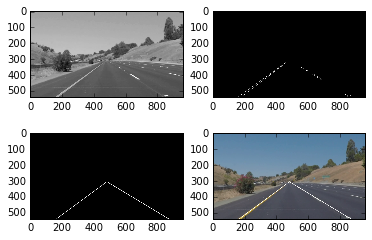

In [93]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [94]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


### Pipeline Description

#### Pipeline Steps:
1. Read in and grayscale the image
2. Define a kernel size and apply Gaussian smoothing
3. Define our parameters for Canny and apply to get edges image
4. Mask edges image using cv2.fillPoly() (ignore everything outside region of interest)
5. Define Hough transform parameters and run Hough transform on masked edge-detected image
6. Draw line segments
7. Draw lines extrapolated from line segments
8. Combine line image with original image to see how accurate the line annotations are.

#### Focus on Step 7 (Drawing lines extrapolated from line segments)
The time I spent the most time on was Step 7, drawing lines extrapolated from line segments. This step required custom code in addition to the helper functions provided.
1. Divide the hough line segments into those with positive slopes (left lane line) and negative slopes (negative lane line). Take only those with length greater than 50 to remove noise.
    * For each Hough line segment (two points), if (1) the slope of the line is positive and (2) if the line segment length is greater than 50 pixels (length chosen by observation), add the slope and intercept to an array `positive_slope_intercept`. I also added the clause that if the array is empty, we should go through the Hough lines again and add at least one pair of points to the array `positive_slope_intercept`. 
    * Do the same for Hough line segments with negative slope.
    * Line segments with positive slope belong to the negative 
2. Fit a line to the points belonging to the left lane line and to the points belonging to the right lane line separately using `find_line_fit`. Get the intercept and coefficient of the fitted lines.
    * If there is only one slope and intercept, return those.
    * Remove noise: remove points with slope not within 1.5 standard deviations of the mean. (1.5 chosen arbitrarily) This may fail if there is only one datapoint (it failed on one frame of the yellow lane line video), which is why I added the clause above.
    * Take the estimate of the slope and intercept to be that of the remaining values.
3. Calculate where the lane lines intersect.
4. Draw the lines from the intersection point to the bottom of the image.


### Shortcomings

* There are a few instances in the yellow lane line video where the lane lines are marked incorrectly. The error is always (to my knowledge) in the lane line that is not solid.
    * I tried adjusting the Hough parameters further but this often resulted in no hough lines being created in at least one frame in the yellow lane line video.
* Image dimensions were hard-coded in at least one case.
* If the lane lines are not straight lines but have high curvature, this algorithm may give weird results.
* The algorithm was trained on a specific type of lane and type of day (daytime, moderately bright with no snow, rain or hail), so it may not generalise well.

### Possible Improvements

* Tune Hough transform parameters more systematically with more test images instead of by 'feel'.
* Currently the lane lines are drawn in solid white. It would be nice if they were drawn in thicker, semi-transparent red (say).

Reflection describes the current pipeline, identifies its potential shortcomings and suggests possible improvements. There is no minimum length. Writing in English is preferred but you may use any language.



I have included some debugging plots below for fun.


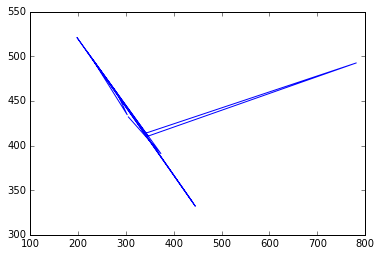

In [95]:
# Debugging plot 1: Plotting the midpoints of the Hough line segments
# for a test image to see why the final line plotted was wrong.
plt.plot([305.0, 373.0, 229.0, 302.5, 281.5, 197.5, 445.0, 339.5, 781.5, 346.0, 217.0, 439.5],
         [432.0, 391.0, 497.5, 434.5, 458.5, 521.0, 332.0, 413.5, 492.5, 410.5, 506.5, 336.5])
plt.show()

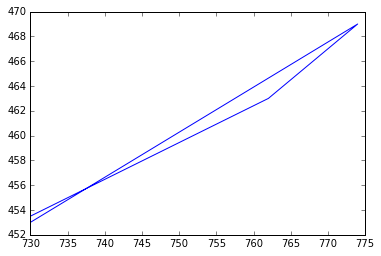

In [96]:
# Debugging plot 2: Plotting the midpoints of the Hough line segments
# for a test image to see why the final line plotted was wrong.
plt.plot([730.0, 762.0, 774.0, 730.0],[453.5, 463.0, 469.0, 453.0])
plt.show()

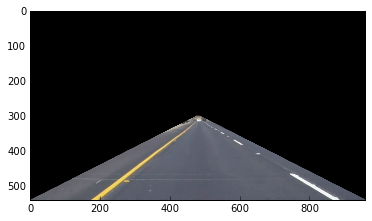

In [97]:
# Debugging mask
border = 80
imshape = [540, 960]
vertices = np.array([[(0,imshape[0]),(475, 300), (485, 300), 
                      (imshape[1],imshape[0])]], 
                    dtype=np.int32)    
plt.imshow(region_of_interest(test_images[5], vertices))

## Submission

If you're satisfied with your video outputs it's time to submit!


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

Slope & intercept:  [[0.5757575757575758, 46.272727272727252], [0.60509554140127386, 27.547770700636988], [0.55621301775147924, 63.834319526627269], [0.061403508771929821, 619.32456140350882], [0.34061135371179041, 219.96506550218339], [0.59259259259259256, 27.296296296296305], [0.64792899408284022, -14.76035502958581], [0.32653061224489793, 208.20408163265307], [0.028571428571428571, 673.51428571428573], [0.14035087719298245, 547.70175438596493], [0.36363636363636365, 189.0], [0.48466257668711654, 129.36196319018407], [0.64864864864864868, -14.081081081081095], [0.06363636363636363, 616.56363636363642], [0.55172413793103448, 67.655172413793139], [0.28813559322033899, 240.9830508474576]]
Slope:  0.392218699115 Intercept:  228.023953071
Slope & intercept:  [[-0.72628726287262868, 890.53929539295393], [-0.6718146718146718, 855.96911196911196], [-0.070287539936102233, 461.96805111821084], [-0.2620689655172414, 593.97931034482758], [-0.067073170731707321, 463.0], [-0.25409836065573771, 590








  0%|          | 0/251 [00:00<?, ?it/s]






  0%|          | 1/251 [00:00<00:28,  8.67it/s]

Slope & intercept:  [[0.5757575757575758, 46.272727272727252], [0.60509554140127386, 27.547770700636988], [0.55621301775147924, 63.834319526627269], [0.061403508771929821, 619.32456140350882], [0.34061135371179041, 219.96506550218339], [0.59259259259259256, 27.296296296296305], [0.64792899408284022, -14.76035502958581], [0.32653061224489793, 208.20408163265307], [0.028571428571428571, 673.51428571428573], [0.14035087719298245, 547.70175438596493], [0.36363636363636365, 189.0], [0.48466257668711654, 129.36196319018407], [0.64864864864864868, -14.081081081081095], [0.06363636363636363, 616.56363636363642], [0.55172413793103448, 67.655172413793139], [0.28813559322033899, 240.9830508474576]]
Slope:  0.392218699115 Intercept:  228.023953071
Slope & intercept:  [[-0.72628726287262868, 890.53929539295393], [-0.6718146718146718, 855.96911196911196], [-0.070287539936102233, 461.96805111821084], [-0.2620689655172414, 593.97931034482758], [-0.067073170731707321, 463.0], [-0.25409836065573771, 590








  1%|          | 2/251 [00:00<00:28,  8.79it/s]

(720, 1280, 3)









  1%|          | 3/251 [00:00<00:28,  8.56it/s]

Slope & intercept:  [[0.57894736842105265, 43.10526315789474], [0.59649122807017541, 23.035087719298303], [0.032051282051282048, 671.84615384615381], [0.59909909909909909, 21.779279279279308], [0.21686746987951808, 273.91566265060243], [0.63636363636363635, -5.5454545454545041], [0.061403508771929821, 618.46491228070181], [0.5761316872427984, 42.646090534979407], [0.64864864864864868, -15.540540540540576], [0.14141414141414141, 573.59595959595958], [0.038461538461538464, 673.76923076923072], [0.625, 4.125], [0.022727272727272728, 355.40909090909093], [0.60256410256410253, 26.807692307692321], [0.59649122807017541, 35.368421052631561]]
Slope:  0.398177480786 Intercept:  222.852123268
Slope & intercept:  [[-0.67226890756302526, 856.42857142857144], [-0.72602739726027399, 889.64383561643831], [-0.26250000000000001, 593.5625], [-0.24890829694323144, 588.94323144104806], [-0.070063694267515922, 460.19108280254778], [-0.069565217391304349, 463.53913043478263], [-0.051671732522796353, 699.331








  2%|▏         | 4/251 [00:00<00:28,  8.74it/s]

(720, 1280, 3)









  2%|▏         | 5/251 [00:00<00:28,  8.76it/s]

Slope & intercept:  [[0.67521367521367526, -36.444444444444457], [0.061946902654867256, 618.07964601769913], [0.72388059701492535, -70.067164179104452], [0.016393442622950821, 678.93442622950818], [0.14136125654450263, 573.22513089005236], [0.092307692307692313, 616.12307692307695], [0.25, 261.75], [0.57718120805369133, 42.261744966442905], [0.32380952380952382, 210.50476190476189], [0.34188034188034189, 202.84615384615384], [0.57777777777777772, 47.466666666666697], [0.36206896551724138, 192.13793103448276], [0.625, 3.5], [0.068181818181818177, 336.63636363636363]]
Slope:  0.316394046505 Intercept:  288.232419821
Slope & intercept:  [[-0.69870129870129871, 879.93766233766235], [-0.67346938775510201, 858.75510204081638], [-0.26839826839826841, 596.82683982683989], [-0.071216617210682495, 462.28783382789317], [-0.068965517241379309, 464.27586206896552], [-0.26989619377162632, 600.59861591695505], [-0.67317073170731712, 860.31219512195116], [-0.045454545454545456, 696.09090909090912], [-








  2%|▏         | 6/251 [00:00<00:27,  8.95it/s]

(720, 1280, 3)









  3%|▎         | 7/251 [00:00<00:27,  9.00it/s]

Slope & intercept:  [[0.625, 2.0], [0.64953271028037385, -11.504672897196258], [0.046783625730994149, 631.41520467836256], [0.10062893081761007, 608.47798742138366], [0.048484848484848485, 629.16363636363633], [0.12, 593.12], [0.24107142857142858, 267.91071428571428], [0.60185185185185186, 22.416666666666686], [0.34210526315789475, 201.65789473684211], [0.025974025974025976, 677.98701298701303]]
Slope:  0.239099997177 Intercept:  403.794346349
Slope & intercept:  [[-0.67241379310344829, 861.13793103448279], [-0.69973890339425593, 883.72584856396873], [-0.069364161849710976, 464.40462427745666], [-0.04878048780487805, 696.92682926829264], [-0.071641791044776124, 462.42686567164179], [-0.27064220183486237, 602.85779816513764], [-0.2680115273775216, 597.88760806916423], [-0.64925373134328357, 853.35074626865674], [-0.031847133757961783, 693.70700636942672], [-0.69724770642201839, 869.07339449541291], [-0.25268817204301075, 594.6559139784946], [-0.25225225225225223, 589.24324324324323], [-








  3%|▎         | 8/251 [00:00<00:26,  9.03it/s]

(720, 1280, 3)









  4%|▎         | 9/251 [00:01<00:26,  9.02it/s]

Slope & intercept:  [[0.035714285714285712, 641.85714285714289], [0.60215053763440862, 20.043010752688133], [0.016666666666666666, 655.61666666666667], [0.67346938775510201, -32.979591836734699], [0.32110091743119268, 213.77064220183485], [0.60073260073260071, 22.934065934065927], [0.014285714285714285, 424.68571428571431], [0.34710743801652894, 200.0], [0.32743362831858408, 211.57522123893804], [0.30630630630630629, 221.76576576576576], [0.67592592592592593, -37.277777777777771]]
Slope:  0.356444855344 Intercept:  231.09007819
Slope & intercept:  [[-0.72554347826086951, 895.85869565217388], [-0.67901234567901236, 865.61728395061732], [-0.069486404833836862, 460.79154078549851], [-0.27333333333333332, 599.60666666666668], [-0.27091633466135456, 597.24302788844625], [-0.67713004484304928, 862.90582959641256], [-0.28755364806866951, 607.93562231759654], [-0.032051282051282048, 693.62820512820508], [-0.069364161849710976, 464.40462427745666], [-0.28665207877461707, 608.77024070021878], [-








  4%|▍         | 10/251 [00:01<00:26,  9.06it/s]

(720, 1280, 3)









  4%|▍         | 11/251 [00:01<00:25,  9.24it/s]

Slope & intercept:  [[0.62631578947368416, 8.0789473684210975], [0.57684210526315793, 43.934736842105224], [0.061403508771929821, 618.28070175438597], [0.59999999999999998, 21.400000000000034], [0.59957627118644063, 23.661016949152554], [0.10084033613445378, 610.53781512605042], [0.33050847457627119, 209.37288135593221], [0.30555555555555558, 222.30555555555554], [0.26923076923076922, 256.53846153846155], [0.57796257796257799, 41.553014553014521], [0.34108527131782945, 208.34883720930233], [0.30434782608695654, 224.86956521739128]]
Slope:  0.391139040463 Intercept:  207.406794456
Slope & intercept:  [[-0.69946808510638303, 875.25531914893622], [-0.069182389937106917, 464.55345911949684], [-0.26736842105263159, 600.7410526315789], [-0.72807017543859653, 898.15789473684208], [-0.051446945337620578, 451.08038585209005], [-0.72932330827067671, 900.1503759398496], [-0.065727699530516437, 705.04694835680755], [-0.29896907216494845, 613.28865979381442], [-0.24822695035460993, 586.326241134751








  5%|▍         | 12/251 [00:01<00:25,  9.28it/s]

(720, 1280, 3)









  5%|▌         | 13/251 [00:01<00:25,  9.21it/s]

Slope & intercept:  [[0.62272727272727268, 9.795454545454561], [0.59183673469387754, 26.938775510204096], [0.59740259740259738, 23.233766233766232], [0.64885496183206104, -18.328244274809151], [0.046783625730994149, 632.30409356725147], [0.57971014492753625, 36.840579710144937], [0.17808219178082191, 300.97260273972603], [0.6470588235294118, -14.764705882352985], [0.26000000000000001, 261.13999999999999], [0.32000000000000001, 217.31999999999999], [0.59999999999999998, 21.399999999999977], [0.31192660550458717, 217.66055045871559], [0.26865671641791045, 259.88059701492534], [0.53416149068322982, 73.093167701863365], [0.061946902654867256, 617.89380530973449], [0.21568627450980393, 284.56862745098039], [0.0703125, 636.171875], [0.23999999999999999, 272.36000000000001], [0.30841121495327101, 221.63551401869159], [0.049019607843137254, 659.46078431372553]]
Slope:  0.35762888326 Intercept:  236.978862171
Slope & intercept:  [[-0.70026525198938994, 875.47214854111405], [-0.72499999999999998








  6%|▌         | 14/251 [00:01<00:25,  9.22it/s]

(720, 1280, 3)









  6%|▌         | 15/251 [00:01<00:25,  9.27it/s]

Slope & intercept:  [[0.012903225806451613, 663.27096774193546], [0.57751937984496127, 39.135658914728651], [0.59322033898305082, 33.322033898305108], [0.55555555555555558, 63.444444444444457], [0.59999999999999998, 28.199999999999989], [0.40000000000000002, 179.0], [0.60159362549800799, 25.027888446215115], [0.10294117647058823, 606.07352941176475], [0.34615384615384615, 200.69230769230771], [0.34722222222222221, 204.09722222222223], [0.43103448275862066, 167.13793103448276], [0.18478260869565216, 298.23913043478262], [0.38461538461538464, 184.69230769230768], [0.62173913043478257, 5.8173913043478365], [0.014925373134328358, 680.98507462686564], [0.077777777777777779, 603.82222222222219]]
Slope:  0.365749007997 Intercept:  248.93488188
Slope & intercept:  [[-0.75297619047619047, 908.38690476190482], [-0.69889502762430944, 874.79834254143645], [-0.30420711974110032, 612.01618122977345], [-0.068750000000000006, 462.34375], [-0.070063694267515922, 460.05095541401272], [-0.051282051282051








  6%|▋         | 16/251 [00:01<00:25,  9.15it/s]

(720, 1280, 3)









  7%|▋         | 17/251 [00:01<00:26,  8.98it/s]

Slope & intercept:  [[0.1875, 296.1875], [0.55665024630541871, 58.433497536945822], [0.074999999999999997, 605.47500000000002], [0.59932659932659937, 23.023569023568996], [0.57638888888888884, 46.569444444444457], [0.23134328358208955, 279.73880597014926], [0.3188405797101449, 219.56521739130437], [0.10344827586206896, 604.51724137931035], [0.12437810945273632, 588.51243781094524], [0.34931506849315069, 201.9041095890411]]
Slope:  0.312219105162 Intercept:  292.392682315
Slope & intercept:  [[-0.75211267605633803, 907.37746478873237], [-0.70292887029288698, 875.25104602510464], [-0.28508771929824561, 604.87280701754389], [-0.26779661016949152, 595.51864406779657], [-0.070588235294117646, 462.94117647058823], [-0.067114093959731544, 458.14765100671138], [-0.036529680365296802, 690.10958904109589], [-0.6767676767676768, 867.40404040404042], [-0.73750000000000004, 903.67499999999995], [-0.070588235294117646, 462.08235294117645], [-0.020618556701030927, 688.24742268041234], [-0.01716738197








  7%|▋         | 18/251 [00:02<00:29,  7.87it/s]






  8%|▊         | 19/251 [00:02<00:28,  8.05it/s]

(720, 1280, 3)
Slope & intercept:  [[0.59615384615384615, 33.865384615384642], [0.60301507537688437, 20.613065326633205], [0.5791505791505791, 42.088803088803104], [0.034090909090909088, 641.72727272727275], [0.3263888888888889, 216.40972222222223], [0.60377358490566035, 26.792452830188722], [0.23134328358208955, 278.12686567164178], [0.10328638497652583, 609.40845070422529], [0.24822695035460993, 271.03546099290782], [0.64893617021276595, -16.489361702127667], [0.15238095238095239, 560.35238095238094], [0.28654970760233917, 254.94736842105263], [0.21052631578947367, 285.63157894736844], [0.22689075630252101, 279.0924369747899], [0.03669724770642202, 640.37614678899081], [0.24475524475524477, 271.79720279720277], [0.44444444444444442, 185.88888888888889], [0.017064846416382253, 411.34470989761093]]
Slope:  0.290867001052 Intercept:  295.852834815
Slope & intercept:  [[-0.72432432432432436, 883.91351351351352], [-0.75297619047619047, 909.13988095238096], [-0.06725146198830409, 461.85672








  8%|▊         | 20/251 [00:02<00:28,  8.24it/s]






  8%|▊         | 21/251 [00:02<00:27,  8.49it/s]

(720, 1280, 3)
Slope & intercept:  [[0.57692307692307687, 45.26923076923083], [0.69696969696969702, -51.060606060606119], [0.061946902654867256, 618.2035398230089], [0.67391304347826086, -33.521739130434753], [0.67136150234741787, -28.342723004694847], [0.21212121212121213, 285.33333333333331], [0.24832214765100671, 270.96644295302013]]
Slope:  0.448793940307 Intercept:  158.121068383
Slope & intercept:  [[-0.7528089887640449, 909.33707865168537], [-0.72448979591836737, 884.23469387755108], [-0.28603104212860309, 606.35254988913528], [-0.28368794326241137, 601.87234042553189], [-0.034810126582278479, 444.62658227848101], [-0.070336391437308868, 463.42201834862385], [-0.050632911392405063, 698.4683544303798], [-0.67632850241545894, 862.96618357487921], [-0.018018018018018018, 689.89189189189187], [-0.0695970695970696, 460.1062271062271], [-0.53278688524590168, 782.03278688524597], [-0.016949152542372881, 688.45762711864404], [-0.14492753623188406, 832.95652173913049], [-0.21511627906976








  9%|▉         | 22/251 [00:02<00:25,  8.82it/s]






  9%|▉         | 23/251 [00:02<00:25,  8.95it/s]

(720, 1280, 3)
Slope & intercept:  [[0.60227272727272729, 32.488636363636374], [0.59999999999999998, 32.199999999999989], [0.59999999999999998, 33.800000000000068], [0.60079840319361277, 23.532934131736511], [0.57727272727272727, 52.968181818181847], [0.57581573896353166, 45.057581573896357], [0.12440191387559808, 353.55502392344499], [0.6333333333333333, -6.3333333333333144], [0.18803418803418803, 298.94017094017096], [0.5544554455445545, 67.871287128712822], [0.55092592592592593, 69.666666666666686], [0.34591194968553457, 209.0251572327044], [1.5272727272727273, -499.4909090909091], [0.32575757575757575, 220.52272727272728], [0.62666666666666671, 3.3333333333332575], [0.44311377245508982, 188.76646706586826], [0.15306122448979592, 559.5]]
Slope:  0.468863849529 Intercept:  136.555927132
Slope & intercept:  [[-0.75423728813559321, 909.51694915254234], [-0.69895287958115182, 874.11518324607323], [-0.069767441860465115, 463.60465116279067], [-0.26771653543307089, 600.48031496062993], [-








 10%|▉         | 24/251 [00:02<00:24,  9.13it/s]






 10%|▉         | 25/251 [00:02<00:24,  9.26it/s]

(720, 1280, 3)
Slope & intercept:  [[0.62295081967213117, 11.18032786885243], [0.59999999999999998, 23.200000000000045], [0.026666666666666668, 649.91999999999996], [0.55555555555555558, 67.777777777777715], [0.27027027027027029, 252.59459459459458], [0.3411764705882353, 212.8235294117647], [0.2608695652173913, 248.43478260869566], [0.64668769716088326, -9.5331230283911736], [0.19008264462809918, 297.51239669421489], [0.65000000000000002, -18.200000000000045], [0.08771929824561403, 622.50877192982455], [0.51030927835051543, 93.448453608247462], [0.24539877300613497, 275.10429447852761], [0.066666666666666666, 612.79999999999995], [0.08461538461538462, 622.53076923076924], [0.55223880597014929, 72.044776119402968], [0.67307692307692313, -34.730769230769283], [0.59893048128342241, 24.026737967914471], [0.57692307692307687, 46.153846153846189], [0.027777777777777776, 422.69444444444446]]
Slope:  0.379395807784 Intercept:  224.614580531
Slope & intercept:  [[-0.69895287958115182, 872.71727








 10%|█         | 26/251 [00:02<00:23,  9.43it/s]






 11%|█         | 27/251 [00:03<00:23,  9.39it/s]

(720, 1280, 3)
Slope & intercept:  [[0.013986013986013986, 661.30069930069931], [0.62589928057553956, 8.9784172661870798], [0.64676616915422891, -14.452736318407972], [0.57928802588996764, 42.336569579288039], [0.076923076923076927, 604.30769230769226], [0.62605042016806722, 4.2226890756302282], [0.52000000000000002, 106.15999999999997], [0.62295081967213117, 8.393442622950829], [0.57746478873239437, 57.605633802816897], [0.546875, 96.828125], [0.21052631578947367, 289.63157894736844], [0.54794520547945202, 86.479452054794535], [0.23376623376623376, 279.4545454545455], [0.26911314984709478, 264.00917431192659], [0.092783505154639179, 614.89690721649481], [0.076923076923076927, 603.53846153846155], [0.60204081632653061, 30.663265306122469], [0.48677248677248675, 154.63492063492063], [0.64824120603015079, -14.7286432160804]]
Slope:  0.421279767957 Intercept:  204.434747099
Slope & intercept:  [[-0.7528089887640449, 906.0786516853932], [-0.053691275167785234, 455.24161073825502], [-0.7224








 11%|█         | 28/251 [00:03<00:23,  9.49it/s]






 12%|█▏        | 29/251 [00:03<00:23,  9.49it/s]

(720, 1280, 3)
Slope & intercept:  [[0.60171919770773641, 23.604584527220595], [0.032000000000000001, 643.45600000000002], [0.64983164983164987, -10.595959595959641], [0.60465116279069764, 28.302325581395394], [0.77380952380952384, -108.59523809523807], [0.21656050955414013, 286.29299363057328], [0.58088235294117652, 39.485294117647015], [0.10000000000000001, 608.60000000000002], [0.58088235294117652, 45.264705882352928], [0.19047619047619047, 300.76190476190476], [0.22981366459627328, 284.38509316770188], [0.53439153439153442, 64.428571428571388], [1.5925925925925926, -517.48148148148141], [0.1875, 299.875], [0.061403508771929821, 618.32456140350882], [0.2129032258064516, 290.34838709677422]]
Slope:  0.370454991575 Intercept:  227.595881594
Slope & intercept:  [[-0.69946808510638303, 870.35904255319156], [-0.77941176470588236, 915.04411764705878], [-0.70285714285714285, 879.58857142857141], [-0.033149171270718231, 693.39226519337012], [-0.053459119496855348, 455.08490566037733], [-0.0








 12%|█▏        | 30/251 [00:03<00:23,  9.57it/s]






 12%|█▏        | 31/251 [00:03<00:22,  9.60it/s]

(720, 1280, 3)
Slope & intercept:  [[0.59861591695501726, 27.387543252595208], [0.061403508771929821, 619.14035087719299], [0.57928802588996764, 42.398058252427177], [0.67045454545454541, -25.545454545454504], [0.21518987341772153, 288.27848101265823], [0.64835164835164838, -15.582417582417577], [0.18965517241379309, 300.60344827586209], [0.23076923076923078, 283.69230769230768], [0.64739884393063585, -10.820809248554895], [1.8, -626.20000000000005], [0.57761732851985559, 42.285198555956697]]
Slope:  0.441874409447 Intercept:  155.183670654
Slope & intercept:  [[-0.75433526011560692, 904.51156069364163], [-0.69402985074626866, 868.81343283582089], [-0.051987767584097858, 452.25993883792052], [-0.28444444444444444, 600.88], [-0.72142857142857142, 878.82142857142856], [-0.049450549450549448, 698.26373626373629], [-0.72180451127819545, 879.79699248120301], [-0.052795031055900624, 455.74223602484471], [-0.578125, 811.765625], [-0.23076923076923078, 577.15384615384619], [-0.0173410404624277








 13%|█▎        | 32/251 [00:03<00:22,  9.64it/s]






 13%|█▎        | 33/251 [00:03<00:22,  9.74it/s]

(720, 1280, 3)
Slope & intercept:  [[0.032520325203252036, 642.41463414634143], [0.62333333333333329, 5.7800000000000296], [0.69950738916256161, -52.16748768472911], [0.015228426395939087, 418.62944162436548], [0.62318840579710144, 11.724637681159436], [0.61194029850746268, 23.970149253731392], [0.58156028368794321, 42.546099290780205], [0.5280898876404494, 92.573033707865193], [0.57794676806083645, 42.733840304182536], [0.11627906976744186, 354.62790697674416], [0.081081081081081086, 371.05405405405406], [0.052419354838709679, 400.24596774193549], [0.15625, 325.90625], [0.60240963855421692, 31.012048192771033]]
Slope:  0.378696733002 Intercept:  193.646469664
Slope & intercept:  [[-0.69834710743801653, 869.06198347107443], [-0.70124481327800825, 880.40663900414938], [-0.2670299727520436, 597.30790190735695], [-0.72535211267605637, 891.65492957746483], [-0.26815642458100558, 594.35195530726253], [-0.069486404833836862, 462.58308157099697], [-0.75366568914956011, 902.5777126099706], [-0








 14%|█▎        | 34/251 [00:03<00:22,  9.48it/s]






 14%|█▍        | 35/251 [00:03<00:22,  9.50it/s]

(720, 1280, 3)
Slope & intercept:  [[0.59957173447537471, 27.237687366167052], [0.625, 14.375], [0.59763313609467461, 27.568047337278017], [0.59701492537313428, 36.985074626865696], [0.64921465968586389, -10.513089005235599], [0.037735849056603772, 403.07547169811323], [0.59999999999999998, 24.0], [0.032258064516129031, 409.38709677419354], [0.64516129032258063, -5.8387096774193878], [0.578125, 54.859375], [0.57885304659498205, 45.629032258064512], [0.67479674796747968, -31.260162601626007], [1.6712328767123288, -531.72602739726028], [0.12101910828025478, 344.13375796178343], [0.1404494382022472, 340.01685393258424], [0.60129310344827591, 26.681034482758605], [0.59589041095890416, 33.116438356164338]]
Slope:  0.479626032186 Intercept:  108.715806782
Slope & intercept:  [[-0.69841269841269837, 879.15873015873012], [-0.67519181585677746, 859.19948849104856], [-0.052307692307692305, 452.09846153846155], [-0.26748971193415638, 595.17283950617286], [-0.03125, 693.53125], [-0.052795031055900








 14%|█▍        | 36/251 [00:03<00:22,  9.59it/s]






 15%|█▍        | 37/251 [00:04<00:22,  9.53it/s]

(720, 1280, 3)
Slope & intercept:  [[0.57534246575342463, 50.60273972602738], [0.59868421052631582, 37.671052631578959], [0.031578947368421054, 644.06315789473683], [0.6029411764705882, 34.264705882352928], [0.57342657342657344, 51.111888111888106], [0.036231884057971016, 676.85507246376812], [0.033707865168539325, 408.48314606741576], [0.57763975155279501, 42.248447204968954], [0.57499999999999996, 63.950000000000045], [0.21465968586387435, 293.44502617801049], [0.052631578947368418, 626.1052631578948], [0.140625, 341.890625], [0.55737704918032782, 61.672131147540995], [0.57499999999999996, 62.800000000000011], [0.4642857142857143, 134.5], [0.65116279069767447, -14.883720930232585], [0.57894736842105265, 43.157894736842081], [0.034722222222222224, 679.31944444444446], [0.83823529411764708, -152.92647058823536], [0.28440366972477066, 264.55045871559633], [0.57746478873239437, 45.225352112676035], [0.52542372881355937, 88.322033898305051], [0.24878048780487805, 279.13658536585365], [0.1








 15%|█▌        | 38/251 [00:04<00:22,  9.44it/s]






 16%|█▌        | 39/251 [00:04<00:22,  9.45it/s]

(720, 1280, 3)
Slope & intercept:  [[0.032467532467532464, 643.62337662337666], [0.034013605442176874, 409.08843537414964], [0.57627118644067798, 48.474576271186436], [0.60162601626016265, 23.57723577235771], [0.029411764705882353, 647.61764705882354], [0.48739495798319327, 118.73109243697479], [0.13775510204081631, 341.95408163265307], [0.57742782152230976, 45.905511811023587], [0.031914893617021274, 681.97872340425533], [0.57599999999999996, 63.296000000000049], [0.55223880597014929, 73.626865671641781], [0.5368421052631579, 95.199999999999989], [0.51320754716981132, 91.158490566037756], [0.65217391304347827, -11.52173913043481], [0.012987012987012988, 660.25974025974028], [0.054054054054054057, 655.29729729729729], [0.25, 275.25], [0.61538461538461542, 19.230769230769226], [0.57861635220125784, 50.955974842767318], [0.90322580645161288, -107.0]]
Slope:  0.360515120345 Intercept:  259.668635743
Slope & intercept:  [[-0.26732673267326734, 598.06930693069307], [-0.72602739726027399, 88








 16%|█▌        | 40/251 [00:04<00:22,  9.24it/s]






 16%|█▋        | 41/251 [00:04<00:22,  9.36it/s]

(720, 1280, 3)
Slope & intercept:  [[0.014285714285714285, 658.57142857142856], [0.017341040462427744, 659.35838150289021], [0.55654761904761907, 60.065476190476204], [0.088541666666666671, 371.578125], [0.57309941520467833, 53.31578947368422], [0.625, 36.375], [0.62318840579710144, 37.550724637681185], [0.036363636363636362, 676.85454545454547], [0.04790419161676647, 630.67664670658678], [0.19387755102040816, 305.79591836734693], [0.53333333333333333, 97.933333333333337], [0.50793650793650791, 106.82539682539687], [0.57668711656441718, 52.539877300613512], [0.19811320754716982, 311.57547169811323], [0.62204724409448819, 39.755905511811022], [0.21674876847290642, 296.42364532019701], [0.6216216216216216, 13.89189189189193], [0.052264808362369339, 398.09407665505228], [0.5089285714285714, 114.74107142857144], [0.55350553505535061, 57.228782287822867], [0.57831325301204817, 52.734939759036138]]
Slope:  0.368840438471 Intercept:  239.613639425
Slope & intercept:  [[-0.72527472527472525, 8








 17%|█▋        | 42/251 [00:04<00:22,  9.46it/s]






 17%|█▋        | 43/251 [00:04<00:22,  9.38it/s]

(720, 1280, 3)
Slope & intercept:  [[0.625, 11.125], [0.57783641160949872, 43.860158311345629], [0.032786885245901641, 642.57377049180332], [0.53333333333333333, 104.26666666666665], [0.17488789237668162, 319.90582959641256], [0.57541899441340782, 56.223463687150854], [0.088669950738916259, 372.31034482758622], [0.085227272727272721, 376.70454545454544], [0.48076923076923078, 118.0], [0.55244755244755239, 81.804195804195842], [0.030534351145038167, 646.64122137404581], [0.55434782608695654, 77.010869565217376], [0.42460317460317459, 136.28571428571428], [0.64864864864864868, -14.081081081081095], [0.15555555555555556, 546.02222222222224], [0.60106382978723405, 35.090425531914889], [0.57714285714285718, 56.817142857142812], [0.55555555555555558, 79.222222222222229], [0.57763975155279501, 53.689440993788821], [0.60344827586206895, 30.482758620689651], [0.53543307086614178, 100.71653543307082], [0.625, 7.25], [0.6033519553072626, 34.994413407821241], [0.052631578947368418, 653.31578947368








 18%|█▊        | 44/251 [00:04<00:21,  9.48it/s]






 18%|█▊        | 45/251 [00:04<00:21,  9.38it/s]

(720, 1280, 3)
Slope & intercept:  [[0.013793103448275862, 663.44827586206895], [0.57692307692307687, 44.307692307692321], [0.60227272727272729, 30.909090909090878], [0.34399999999999997, 195.976], [0.1050228310502283, 366.59360730593608], [0.44486692015209123, 127.1406844106464], [0.62658227848101267, 55.25316455696202], [0.20000000000000001, 497.60000000000002], [0.90410958904109584, -107.45205479452051], [0.36575875486381321, 191.43579766536965], [0.48936170212765956, 104.97872340425533], [0.086538461538461536, 664.45192307692309], [0.90140845070422537, -102.07042253521126], [0.80769230769230771, -36.307692307692321], [0.44400000000000001, 124.876], [0.8660714285714286, -72.1875], [0.02, 652.96000000000004], [0.578125, 49.8125], [0.53061224489795922, 90.0], [0.57435897435897432, 69.092307692307713], [0.48823529411764705, 116.52941176470588], [0.42574257425742573, 159.51485148514851], [0.67400881057268724, -32.651982378854655], [0.84126984126984128, -83.0], [0.5770925110132159, 45.57








 18%|█▊        | 46/251 [00:05<00:22,  9.25it/s]






 19%|█▊        | 47/251 [00:05<00:22,  9.23it/s]

(720, 1280, 3)
Slope & intercept:  [[0.57635467980295563, 45.044334975369452], [0.59798994974874375, 35.356783919598001], [0.034482758620689655, 642.0344827586207], [0.55555555555555558, 64.111111111111086], [0.4456140350877193, 134.80000000000001], [0.46745562130177515, 137.08875739644969], [0.57936507936507942, 40.293650793650784], [0.53000000000000003, 91.439999999999998], [0.57711442786069655, 50.910447761194007], [0.44654088050314467, 152.74842767295596], [0.19047619047619047, 507.14285714285717], [0.10480349344978165, 368.33187772925766], [0.013513513513513514, 662.74324324324323], [0.5311475409836065, 76.016393442622984], [0.01834862385321101, 689.60550458715602], [0.58620689655172409, 34.517241379310349], [0.32579185520361992, 219.52036199095022], [0.57530864197530862, 47.577777777777783], [0.93006993006993011, -99.692307692307736], [0.08666666666666667, 373.5333333333333], [0.46743295019157088, 109.11111111111111], [0.55614973262032086, 71.946524064171115], [0.3417721518987341








 19%|█▉        | 48/251 [00:05<00:22,  9.08it/s]

(720, 1280, 3)
Slope & intercept:  [[0.59649122807017541, 36.157894736842138], [0.020408163265306121, 653.24489795918362], [0.5714285714285714, 49.85714285714289], [0.59999999999999998, 33.199999999999989], [0.57731958762886593, 57.546391752577335], [0.61333333333333329, 20.786666666666747], [0.62385321100917435, 7.7064220183485759], [0.011764705882352941, 660.47058823529414], [0.48797250859106528, 103.99656357388318], [0.65088757396449703, -19.443786982248525], [0.57638888888888884, 41.986111111111143], [0.44736842105263158, 155.0], [0.53066666666666662, 82.301333333333361], [0.5074626865671642, 129.28358208955223], [0.14473684210526316, 557.0526315789474], [0.56000000000000005, 75.439999999999941], [0.10416666666666667, 366.20833333333331], [0.46376811594202899, 141.53623188405797], [0.44137931034482758, 161.19310344827588], [0.75147928994082835, -32.443786982248525], [0.016, 691.03999999999996], [0.016574585635359115, 655.81215469613255], [0.1111111111111111, 577.55555555555554], [0

ValueError: cannot convert float NaN to integer

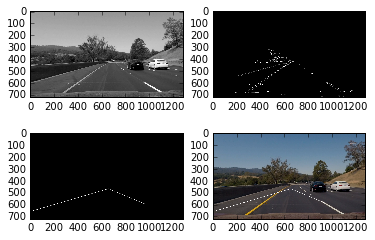

In [98]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

## Misc